In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from data_utils import FaceData
import time
import os

from classifiers.segmentation_bis import SegmentationNN

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.ion()   # interactive mode

In [2]:
train_data = FaceData(image_paths_file='LAG_background/train/train.txt')
val_data = FaceData(image_paths_file='LAG_background/val/val.txt')
print(train_data[0][1].size)
print(train_data[0][0].size())

<built-in method size of torch.FloatTensor object at 0x0000026503BD2D48>
torch.Size([3, 200, 200])


Train size: 1489
Validation size: 260
Img size:  torch.Size([3, 200, 200])
Segmentation size:  torch.Size([200, 200])


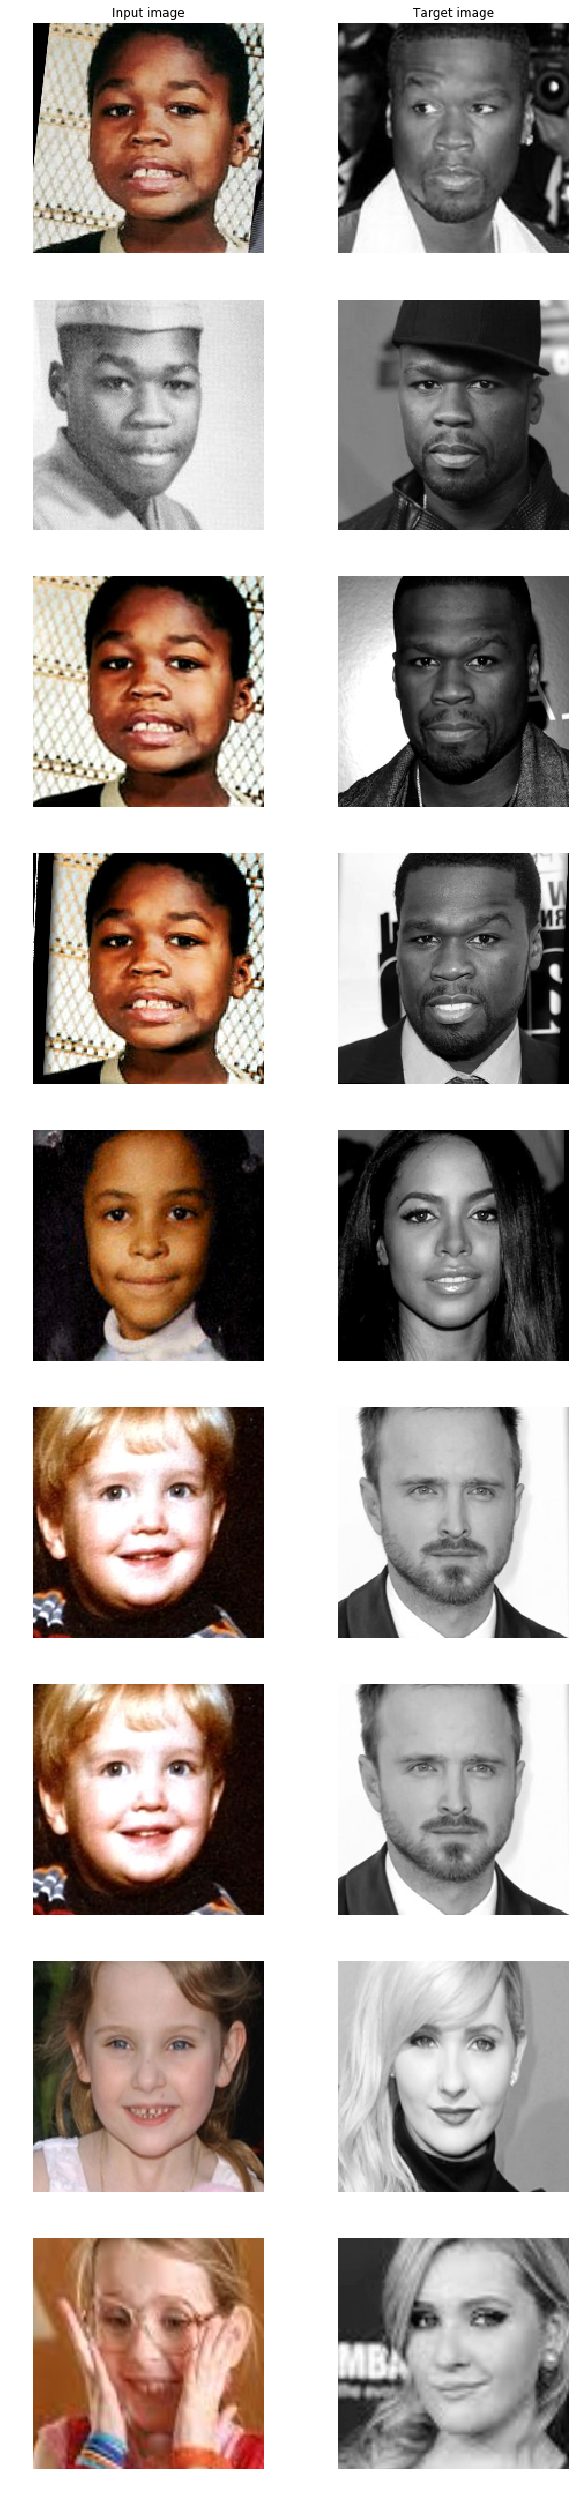

In [3]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 9
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    targetsc = target.numpy() / 255
    plt.imshow(targetsc.reshape(200, 200), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

In [23]:
#Background removing
from PIL import Image, ExifTags
from scipy.misc import imresize
import numpy as np
import tensorflow as tf
import keras
from keras.models import load_model

model = load_model('.\models\Background.hdf5', compile=False)
graph = tf.get_default_graph()

def ml_predict(image):
    with graph.as_default():
        # Add a dimension for the batch
        prediction = model.predict(image[None, :, :, :])
    prediction = prediction.reshape((224,224, -1))
    return prediction

def make_background(image):
    resized_image = imresize(image, (224, 224)) / 255.0
    THRESHOLD = 0.5
    prediction = ml_predict(resized_image[:, :, 0:3])
    prediction = imresize(prediction[:, :, 1], (image.height, image.width))
    prediction[prediction>THRESHOLD*255] = 255
    prediction[prediction<THRESHOLD*255] = 0
    transparent_image = np.append(np.array(image)[:, :, 0:3], prediction[: , :, None], axis=-1)
    transparent_image = Image.fromarray(transparent_image)
    return transparent_image

#image processing
import os
dirict=next(os.walk('LAG_background/train'))[1]

for i in range(1489):
    put_in=dirict[i]
    img=Image.open('LAG_background/train/'+put_in+'/y/1.png')
    target=Image.open('LAG_background/train/'+put_in+'/1.png')
    result_young=make_background(img)
    result_target=make_background(target)
    result_young.save('LAG_background/train/'+put_in+'/y/1.png','PNG')
    result_target.save('LAG_background/train/'+put_in+'/1.png','PNG')


D:\Anaconda\envs\pytorchenv\lib\site-packages\keras\engine\topology.py:1253: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [3]:
from classifiers.convage_nn_2 import ConvAgeNN
from solver import Solver
import torch.nn.functional as F
import torchvision.models as models

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=1,
                                           shuffle=True,
                                           num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=1)
model = ConvAgeNN()
print(len(list(model.parameters())))

for param in list(model.parameters())[:1]:
    param.requires_grad = False    

solver = Solver(optim_args={"lr": 1e-3,
                            "eps": 1e-8
                            },
                loss_func = torch.nn.CrossEntropyLoss(ignore_index = -1))

solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=500)

40
START TRAIN.
[Iteration 1/744500] TRAIN loss: 5.640
[Iteration 2/744500] TRAIN loss: 5.608
[Iteration 3/744500] TRAIN loss: 5.628
[Iteration 4/744500] TRAIN loss: 5.606
[Iteration 5/744500] TRAIN loss: 5.607
[Iteration 6/744500] TRAIN loss: 5.614
[Iteration 7/744500] TRAIN loss: 5.533
[Iteration 8/744500] TRAIN loss: 5.564
[Iteration 9/744500] TRAIN loss: 5.640
[Iteration 10/744500] TRAIN loss: 5.569
[Iteration 11/744500] TRAIN loss: 5.472
[Iteration 12/744500] TRAIN loss: 5.616
[Iteration 13/744500] TRAIN loss: 5.575
[Iteration 14/744500] TRAIN loss: 5.587
[Iteration 15/744500] TRAIN loss: 5.590
[Iteration 16/744500] TRAIN loss: 5.582
[Iteration 17/744500] TRAIN loss: 5.552
[Iteration 18/744500] TRAIN loss: 5.563
[Iteration 19/744500] TRAIN loss: 5.588
[Iteration 20/744500] TRAIN loss: 5.573
[Iteration 21/744500] TRAIN loss: 5.584
[Iteration 22/744500] TRAIN loss: 5.552
[Iteration 23/744500] TRAIN loss: 5.577
[Iteration 24/744500] TRAIN loss: 5.568
[Iteration 25/744500] TRAIN loss:

[Iteration 204/744500] TRAIN loss: 5.506
[Iteration 205/744500] TRAIN loss: 5.518
[Iteration 206/744500] TRAIN loss: 5.480
[Iteration 207/744500] TRAIN loss: 5.476
[Iteration 208/744500] TRAIN loss: 5.557
[Iteration 209/744500] TRAIN loss: 5.428
[Iteration 210/744500] TRAIN loss: 5.416
[Iteration 211/744500] TRAIN loss: 5.468
[Iteration 212/744500] TRAIN loss: 5.553
[Iteration 213/744500] TRAIN loss: 5.562
[Iteration 214/744500] TRAIN loss: 5.483
[Iteration 215/744500] TRAIN loss: 5.556
[Iteration 216/744500] TRAIN loss: 5.478
[Iteration 217/744500] TRAIN loss: 5.415
[Iteration 218/744500] TRAIN loss: 5.579
[Iteration 219/744500] TRAIN loss: 5.488
[Iteration 220/744500] TRAIN loss: 5.532
[Iteration 221/744500] TRAIN loss: 5.480
[Iteration 222/744500] TRAIN loss: 5.482
[Iteration 223/744500] TRAIN loss: 5.456
[Iteration 224/744500] TRAIN loss: 5.435
[Iteration 225/744500] TRAIN loss: 5.451
[Iteration 226/744500] TRAIN loss: 5.517
[Iteration 227/744500] TRAIN loss: 5.524
[Iteration 228/7

[Iteration 404/744500] TRAIN loss: 5.410
[Iteration 405/744500] TRAIN loss: 5.523
[Iteration 406/744500] TRAIN loss: 5.533
[Iteration 407/744500] TRAIN loss: 5.508
[Iteration 408/744500] TRAIN loss: 5.565
[Iteration 409/744500] TRAIN loss: 5.494
[Iteration 410/744500] TRAIN loss: 5.552
[Iteration 411/744500] TRAIN loss: 5.485
[Iteration 412/744500] TRAIN loss: 5.510
[Iteration 413/744500] TRAIN loss: 5.454
[Iteration 414/744500] TRAIN loss: 5.519
[Iteration 415/744500] TRAIN loss: 5.515
[Iteration 416/744500] TRAIN loss: 5.433
[Iteration 417/744500] TRAIN loss: 5.407
[Iteration 418/744500] TRAIN loss: 5.451
[Iteration 419/744500] TRAIN loss: 5.530
[Iteration 420/744500] TRAIN loss: 5.448
[Iteration 421/744500] TRAIN loss: 5.460
[Iteration 422/744500] TRAIN loss: 5.484
[Iteration 423/744500] TRAIN loss: 5.384
[Iteration 424/744500] TRAIN loss: 5.481
[Iteration 425/744500] TRAIN loss: 5.456
[Iteration 426/744500] TRAIN loss: 5.390
[Iteration 427/744500] TRAIN loss: 5.377
[Iteration 428/7

[Iteration 604/744500] TRAIN loss: 5.488
[Iteration 605/744500] TRAIN loss: 5.523
[Iteration 606/744500] TRAIN loss: 5.445
[Iteration 607/744500] TRAIN loss: 5.436
[Iteration 608/744500] TRAIN loss: 5.194
[Iteration 609/744500] TRAIN loss: 5.324
[Iteration 610/744500] TRAIN loss: 5.613
[Iteration 611/744500] TRAIN loss: 5.325
[Iteration 612/744500] TRAIN loss: 5.563
[Iteration 613/744500] TRAIN loss: 5.534
[Iteration 614/744500] TRAIN loss: 5.551
[Iteration 615/744500] TRAIN loss: 5.499
[Iteration 616/744500] TRAIN loss: 5.386
[Iteration 617/744500] TRAIN loss: 5.408
[Iteration 618/744500] TRAIN loss: 5.300
[Iteration 619/744500] TRAIN loss: 5.223
[Iteration 620/744500] TRAIN loss: 5.378
[Iteration 621/744500] TRAIN loss: 5.502
[Iteration 622/744500] TRAIN loss: 5.354
[Iteration 623/744500] TRAIN loss: 5.504
[Iteration 624/744500] TRAIN loss: 5.474
[Iteration 625/744500] TRAIN loss: 5.320
[Iteration 626/744500] TRAIN loss: 5.322
[Iteration 627/744500] TRAIN loss: 5.435
[Iteration 628/7

[Iteration 804/744500] TRAIN loss: 5.479
[Iteration 805/744500] TRAIN loss: 5.500
[Iteration 806/744500] TRAIN loss: 5.477
[Iteration 807/744500] TRAIN loss: 5.482
[Iteration 808/744500] TRAIN loss: 5.302
[Iteration 809/744500] TRAIN loss: 5.502
[Iteration 810/744500] TRAIN loss: 5.487
[Iteration 811/744500] TRAIN loss: 5.540
[Iteration 812/744500] TRAIN loss: 5.472
[Iteration 813/744500] TRAIN loss: 5.476
[Iteration 814/744500] TRAIN loss: 5.232
[Iteration 815/744500] TRAIN loss: 5.478
[Iteration 816/744500] TRAIN loss: 5.566
[Iteration 817/744500] TRAIN loss: 5.421
[Iteration 818/744500] TRAIN loss: 5.383
[Iteration 819/744500] TRAIN loss: 5.341
[Iteration 820/744500] TRAIN loss: 5.279
[Iteration 821/744500] TRAIN loss: 5.394
[Iteration 822/744500] TRAIN loss: 5.321
[Iteration 823/744500] TRAIN loss: 5.372
[Iteration 824/744500] TRAIN loss: 5.425
[Iteration 825/744500] TRAIN loss: 5.478
[Iteration 826/744500] TRAIN loss: 5.284
[Iteration 827/744500] TRAIN loss: 5.430
[Iteration 828/7

[Iteration 1004/744500] TRAIN loss: 5.363
[Iteration 1005/744500] TRAIN loss: 5.412
[Iteration 1006/744500] TRAIN loss: 5.482
[Iteration 1007/744500] TRAIN loss: 5.485
[Iteration 1008/744500] TRAIN loss: 5.530
[Iteration 1009/744500] TRAIN loss: 5.497
[Iteration 1010/744500] TRAIN loss: 5.422
[Iteration 1011/744500] TRAIN loss: 5.467
[Iteration 1012/744500] TRAIN loss: 5.341
[Iteration 1013/744500] TRAIN loss: 5.454
[Iteration 1014/744500] TRAIN loss: 5.084
[Iteration 1015/744500] TRAIN loss: 5.375
[Iteration 1016/744500] TRAIN loss: 5.485
[Iteration 1017/744500] TRAIN loss: 5.478
[Iteration 1018/744500] TRAIN loss: 5.522
[Iteration 1019/744500] TRAIN loss: 5.418
[Iteration 1020/744500] TRAIN loss: 5.508
[Iteration 1021/744500] TRAIN loss: 5.250
[Iteration 1022/744500] TRAIN loss: 5.491
[Iteration 1023/744500] TRAIN loss: 5.559
[Iteration 1024/744500] TRAIN loss: 5.400
[Iteration 1025/744500] TRAIN loss: 5.477
[Iteration 1026/744500] TRAIN loss: 5.431
[Iteration 1027/744500] TRAIN loss

[Iteration 1200/744500] TRAIN loss: 5.424
[Iteration 1201/744500] TRAIN loss: 5.511
[Iteration 1202/744500] TRAIN loss: 5.408
[Iteration 1203/744500] TRAIN loss: 5.537
[Iteration 1204/744500] TRAIN loss: 5.305
[Iteration 1205/744500] TRAIN loss: 5.479
[Iteration 1206/744500] TRAIN loss: 5.348
[Iteration 1207/744500] TRAIN loss: 5.431
[Iteration 1208/744500] TRAIN loss: 5.465
[Iteration 1209/744500] TRAIN loss: 5.328
[Iteration 1210/744500] TRAIN loss: 5.015
[Iteration 1211/744500] TRAIN loss: 5.419
[Iteration 1212/744500] TRAIN loss: 5.587
[Iteration 1213/744500] TRAIN loss: 5.467
[Iteration 1214/744500] TRAIN loss: 5.501
[Iteration 1215/744500] TRAIN loss: 5.345
[Iteration 1216/744500] TRAIN loss: 5.478
[Iteration 1217/744500] TRAIN loss: 5.542
[Iteration 1218/744500] TRAIN loss: 5.500
[Iteration 1219/744500] TRAIN loss: 5.482
[Iteration 1220/744500] TRAIN loss: 5.281
[Iteration 1221/744500] TRAIN loss: 5.485
[Iteration 1222/744500] TRAIN loss: 5.448
[Iteration 1223/744500] TRAIN loss

[Iteration 1396/744500] TRAIN loss: 5.501
[Iteration 1397/744500] TRAIN loss: 5.603
[Iteration 1398/744500] TRAIN loss: 5.187
[Iteration 1399/744500] TRAIN loss: 5.271
[Iteration 1400/744500] TRAIN loss: 5.377
[Iteration 1401/744500] TRAIN loss: 5.405
[Iteration 1402/744500] TRAIN loss: 5.489
[Iteration 1403/744500] TRAIN loss: 5.377
[Iteration 1404/744500] TRAIN loss: 5.310
[Iteration 1405/744500] TRAIN loss: 5.504
[Iteration 1406/744500] TRAIN loss: 5.588
[Iteration 1407/744500] TRAIN loss: 5.454
[Iteration 1408/744500] TRAIN loss: 5.455
[Iteration 1409/744500] TRAIN loss: 5.434
[Iteration 1410/744500] TRAIN loss: 5.230
[Iteration 1411/744500] TRAIN loss: 5.432
[Iteration 1412/744500] TRAIN loss: 5.407
[Iteration 1413/744500] TRAIN loss: 5.217
[Iteration 1414/744500] TRAIN loss: 5.316
[Iteration 1415/744500] TRAIN loss: 5.271
[Iteration 1416/744500] TRAIN loss: 5.453
[Iteration 1417/744500] TRAIN loss: 5.493
[Iteration 1418/744500] TRAIN loss: 5.516
[Iteration 1419/744500] TRAIN loss

[Iteration 1590/744500] TRAIN loss: 4.955
[Iteration 1591/744500] TRAIN loss: 5.248
[Iteration 1592/744500] TRAIN loss: 5.407
[Iteration 1593/744500] TRAIN loss: 5.351
[Iteration 1594/744500] TRAIN loss: 5.300
[Iteration 1595/744500] TRAIN loss: 5.167
[Iteration 1596/744500] TRAIN loss: 5.295
[Iteration 1597/744500] TRAIN loss: 5.480
[Iteration 1598/744500] TRAIN loss: 5.438
[Iteration 1599/744500] TRAIN loss: 5.106
[Iteration 1600/744500] TRAIN loss: 5.395
[Iteration 1601/744500] TRAIN loss: 5.278
[Iteration 1602/744500] TRAIN loss: 5.489
[Iteration 1603/744500] TRAIN loss: 5.517
[Iteration 1604/744500] TRAIN loss: 5.420
[Iteration 1605/744500] TRAIN loss: 5.383
[Iteration 1606/744500] TRAIN loss: 5.359
[Iteration 1607/744500] TRAIN loss: 5.432
[Iteration 1608/744500] TRAIN loss: 5.511
[Iteration 1609/744500] TRAIN loss: 5.091
[Iteration 1610/744500] TRAIN loss: 5.451
[Iteration 1611/744500] TRAIN loss: 5.219
[Iteration 1612/744500] TRAIN loss: 5.749
[Iteration 1613/744500] TRAIN loss

[Iteration 1786/744500] TRAIN loss: 5.583
[Iteration 1787/744500] TRAIN loss: 5.479
[Iteration 1788/744500] TRAIN loss: 5.375
[Iteration 1789/744500] TRAIN loss: 5.350
[Iteration 1790/744500] TRAIN loss: 5.429
[Iteration 1791/744500] TRAIN loss: 5.552
[Iteration 1792/744500] TRAIN loss: 5.484
[Iteration 1793/744500] TRAIN loss: 5.280
[Iteration 1794/744500] TRAIN loss: 5.329
[Iteration 1795/744500] TRAIN loss: 5.185
[Iteration 1796/744500] TRAIN loss: 5.225
[Iteration 1797/744500] TRAIN loss: 5.559
[Iteration 1798/744500] TRAIN loss: 5.428
[Iteration 1799/744500] TRAIN loss: 5.123
[Iteration 1800/744500] TRAIN loss: 5.346
[Iteration 1801/744500] TRAIN loss: 5.550
[Iteration 1802/744500] TRAIN loss: 5.398
[Iteration 1803/744500] TRAIN loss: 5.498
[Iteration 1804/744500] TRAIN loss: 5.369
[Iteration 1805/744500] TRAIN loss: 5.315
[Iteration 1806/744500] TRAIN loss: 5.335
[Iteration 1807/744500] TRAIN loss: 5.024
[Iteration 1808/744500] TRAIN loss: 5.365
[Iteration 1809/744500] TRAIN loss

[Iteration 1982/744500] TRAIN loss: 5.493
[Iteration 1983/744500] TRAIN loss: 5.332
[Iteration 1984/744500] TRAIN loss: 5.490
[Iteration 1985/744500] TRAIN loss: 5.310
[Iteration 1986/744500] TRAIN loss: 5.468
[Iteration 1987/744500] TRAIN loss: 5.091
[Iteration 1988/744500] TRAIN loss: 5.510
[Iteration 1989/744500] TRAIN loss: 5.558
[Iteration 1990/744500] TRAIN loss: 5.412
[Iteration 1991/744500] TRAIN loss: 5.518
[Iteration 1992/744500] TRAIN loss: 5.428
[Iteration 1993/744500] TRAIN loss: 5.010
[Iteration 1994/744500] TRAIN loss: 5.255
[Iteration 1995/744500] TRAIN loss: 5.395
[Iteration 1996/744500] TRAIN loss: 5.689
[Iteration 1997/744500] TRAIN loss: 5.438
[Iteration 1998/744500] TRAIN loss: 5.501
[Iteration 1999/744500] TRAIN loss: 5.254
[Iteration 2000/744500] TRAIN loss: 5.427
[Iteration 2001/744500] TRAIN loss: 5.419
[Iteration 2002/744500] TRAIN loss: 5.362
[Iteration 2003/744500] TRAIN loss: 5.448
[Iteration 2004/744500] TRAIN loss: 5.404
[Iteration 2005/744500] TRAIN loss

[Iteration 2178/744500] TRAIN loss: 5.358
[Iteration 2179/744500] TRAIN loss: 5.226
[Iteration 2180/744500] TRAIN loss: 5.089
[Iteration 2181/744500] TRAIN loss: 5.310
[Iteration 2182/744500] TRAIN loss: 5.380
[Iteration 2183/744500] TRAIN loss: 5.482
[Iteration 2184/744500] TRAIN loss: 5.499
[Iteration 2185/744500] TRAIN loss: 5.101
[Iteration 2186/744500] TRAIN loss: 5.428
[Iteration 2187/744500] TRAIN loss: 5.402
[Iteration 2188/744500] TRAIN loss: 5.539
[Iteration 2189/744500] TRAIN loss: 5.391
[Iteration 2190/744500] TRAIN loss: 5.373
[Iteration 2191/744500] TRAIN loss: 5.223
[Iteration 2192/744500] TRAIN loss: 5.391
[Iteration 2193/744500] TRAIN loss: 5.278
[Iteration 2194/744500] TRAIN loss: 5.603
[Iteration 2195/744500] TRAIN loss: 5.202
[Iteration 2196/744500] TRAIN loss: 5.364
[Iteration 2197/744500] TRAIN loss: 5.524
[Iteration 2198/744500] TRAIN loss: 5.433
[Iteration 2199/744500] TRAIN loss: 4.674
[Iteration 2200/744500] TRAIN loss: 5.432
[Iteration 2201/744500] TRAIN loss

[Iteration 2374/744500] TRAIN loss: 5.463
[Iteration 2375/744500] TRAIN loss: 5.510
[Iteration 2376/744500] TRAIN loss: 5.470
[Iteration 2377/744500] TRAIN loss: 5.522
[Iteration 2378/744500] TRAIN loss: 5.499
[Iteration 2379/744500] TRAIN loss: 5.464
[Iteration 2380/744500] TRAIN loss: 5.375
[Iteration 2381/744500] TRAIN loss: 5.485
[Iteration 2382/744500] TRAIN loss: 5.385
[Iteration 2383/744500] TRAIN loss: 5.305
[Iteration 2384/744500] TRAIN loss: 5.089
[Iteration 2385/744500] TRAIN loss: 5.213
[Iteration 2386/744500] TRAIN loss: 5.379
[Iteration 2387/744500] TRAIN loss: 5.366
[Iteration 2388/744500] TRAIN loss: 5.415
[Iteration 2389/744500] TRAIN loss: 5.504
[Iteration 2390/744500] TRAIN loss: 5.429
[Iteration 2391/744500] TRAIN loss: 5.190
[Iteration 2392/744500] TRAIN loss: 5.424
[Iteration 2393/744500] TRAIN loss: 5.366
[Iteration 2394/744500] TRAIN loss: 5.620
[Iteration 2395/744500] TRAIN loss: 5.449
[Iteration 2396/744500] TRAIN loss: 5.530
[Iteration 2397/744500] TRAIN loss

[Iteration 2570/744500] TRAIN loss: 5.530
[Iteration 2571/744500] TRAIN loss: 5.200
[Iteration 2572/744500] TRAIN loss: 5.490
[Iteration 2573/744500] TRAIN loss: 5.604
[Iteration 2574/744500] TRAIN loss: 5.510
[Iteration 2575/744500] TRAIN loss: 5.199
[Iteration 2576/744500] TRAIN loss: 5.344
[Iteration 2577/744500] TRAIN loss: 5.413
[Iteration 2578/744500] TRAIN loss: 5.391
[Iteration 2579/744500] TRAIN loss: 5.200
[Iteration 2580/744500] TRAIN loss: 5.444
[Iteration 2581/744500] TRAIN loss: 5.503
[Iteration 2582/744500] TRAIN loss: 5.034
[Iteration 2583/744500] TRAIN loss: 5.497
[Iteration 2584/744500] TRAIN loss: 4.940
[Iteration 2585/744500] TRAIN loss: 5.331
[Iteration 2586/744500] TRAIN loss: 5.469
[Iteration 2587/744500] TRAIN loss: 5.381
[Iteration 2588/744500] TRAIN loss: 4.840
[Iteration 2589/744500] TRAIN loss: 5.272
[Iteration 2590/744500] TRAIN loss: 5.493
[Iteration 2591/744500] TRAIN loss: 5.423
[Iteration 2592/744500] TRAIN loss: 5.168
[Iteration 2593/744500] TRAIN loss

[Iteration 2766/744500] TRAIN loss: 4.652
[Iteration 2767/744500] TRAIN loss: 5.373
[Iteration 2768/744500] TRAIN loss: 5.440
[Iteration 2769/744500] TRAIN loss: 5.616
[Iteration 2770/744500] TRAIN loss: 5.503
[Iteration 2771/744500] TRAIN loss: 5.392
[Iteration 2772/744500] TRAIN loss: 5.414
[Iteration 2773/744500] TRAIN loss: 5.252
[Iteration 2774/744500] TRAIN loss: 5.155
[Iteration 2775/744500] TRAIN loss: 5.401
[Iteration 2776/744500] TRAIN loss: 5.248
[Iteration 2777/744500] TRAIN loss: 5.232
[Iteration 2778/744500] TRAIN loss: 5.233
[Iteration 2779/744500] TRAIN loss: 5.208
[Iteration 2780/744500] TRAIN loss: 5.466
[Iteration 2781/744500] TRAIN loss: 5.429
[Iteration 2782/744500] TRAIN loss: 5.383
[Iteration 2783/744500] TRAIN loss: 5.485
[Iteration 2784/744500] TRAIN loss: 5.056
[Iteration 2785/744500] TRAIN loss: 5.173
[Iteration 2786/744500] TRAIN loss: 5.434
[Iteration 2787/744500] TRAIN loss: 5.353
[Iteration 2788/744500] TRAIN loss: 5.112
[Iteration 2789/744500] TRAIN loss

[Iteration 2962/744500] TRAIN loss: 5.416
[Iteration 2963/744500] TRAIN loss: 5.558
[Iteration 2964/744500] TRAIN loss: 5.634
[Iteration 2965/744500] TRAIN loss: 5.467
[Iteration 2966/744500] TRAIN loss: 5.291
[Iteration 2967/744500] TRAIN loss: 4.856
[Iteration 2968/744500] TRAIN loss: 5.125
[Iteration 2969/744500] TRAIN loss: 5.564
[Iteration 2970/744500] TRAIN loss: 5.000
[Iteration 2971/744500] TRAIN loss: 5.426
[Iteration 2972/744500] TRAIN loss: 5.495
[Iteration 2973/744500] TRAIN loss: 5.526
[Iteration 2974/744500] TRAIN loss: 5.317
[Iteration 2975/744500] TRAIN loss: 5.256
[Iteration 2976/744500] TRAIN loss: 5.392
[Iteration 2977/744500] TRAIN loss: 5.485
[Iteration 2978/744500] TRAIN loss: 5.519
[Epoch 2/500] TRAIN acc/loss: 0.004/5.519
[Epoch 2/500] VAL   acc/loss: 0.041/5.418
[Iteration 2979/744500] TRAIN loss: 5.433
[Iteration 2980/744500] TRAIN loss: 5.220
[Iteration 2981/744500] TRAIN loss: 4.745
[Iteration 2982/744500] TRAIN loss: 5.375
[Iteration 2983/744500] TRAIN loss

[Iteration 3156/744500] TRAIN loss: 5.389
[Iteration 3157/744500] TRAIN loss: 5.402
[Iteration 3158/744500] TRAIN loss: 4.983
[Iteration 3159/744500] TRAIN loss: 5.604
[Iteration 3160/744500] TRAIN loss: 5.096
[Iteration 3161/744500] TRAIN loss: 5.188
[Iteration 3162/744500] TRAIN loss: 5.291
[Iteration 3163/744500] TRAIN loss: 5.252
[Iteration 3164/744500] TRAIN loss: 5.448
[Iteration 3165/744500] TRAIN loss: 5.141
[Iteration 3166/744500] TRAIN loss: 5.258
[Iteration 3167/744500] TRAIN loss: 5.309
[Iteration 3168/744500] TRAIN loss: 5.363
[Iteration 3169/744500] TRAIN loss: 5.291
[Iteration 3170/744500] TRAIN loss: 5.336
[Iteration 3171/744500] TRAIN loss: 5.517
[Iteration 3172/744500] TRAIN loss: 5.452
[Iteration 3173/744500] TRAIN loss: 5.514
[Iteration 3174/744500] TRAIN loss: 5.437
[Iteration 3175/744500] TRAIN loss: 4.973
[Iteration 3176/744500] TRAIN loss: 5.395
[Iteration 3177/744500] TRAIN loss: 5.508
[Iteration 3178/744500] TRAIN loss: 5.251
[Iteration 3179/744500] TRAIN loss

[Iteration 3352/744500] TRAIN loss: 5.501
[Iteration 3353/744500] TRAIN loss: 5.298
[Iteration 3354/744500] TRAIN loss: 5.216
[Iteration 3355/744500] TRAIN loss: 4.853
[Iteration 3356/744500] TRAIN loss: 5.653
[Iteration 3357/744500] TRAIN loss: 5.522
[Iteration 3358/744500] TRAIN loss: 5.341
[Iteration 3359/744500] TRAIN loss: 5.449
[Iteration 3360/744500] TRAIN loss: 5.369
[Iteration 3361/744500] TRAIN loss: 5.385
[Iteration 3362/744500] TRAIN loss: 5.326
[Iteration 3363/744500] TRAIN loss: 5.779
[Iteration 3364/744500] TRAIN loss: 5.437
[Iteration 3365/744500] TRAIN loss: 4.910
[Iteration 3366/744500] TRAIN loss: 5.087
[Iteration 3367/744500] TRAIN loss: 5.123
[Iteration 3368/744500] TRAIN loss: 5.388
[Iteration 3369/744500] TRAIN loss: 5.561
[Iteration 3370/744500] TRAIN loss: 4.876
[Iteration 3371/744500] TRAIN loss: 4.758
[Iteration 3372/744500] TRAIN loss: 5.188
[Iteration 3373/744500] TRAIN loss: 5.529
[Iteration 3374/744500] TRAIN loss: 5.132
[Iteration 3375/744500] TRAIN loss

[Iteration 3548/744500] TRAIN loss: 5.450
[Iteration 3549/744500] TRAIN loss: 5.338
[Iteration 3550/744500] TRAIN loss: 5.459
[Iteration 3551/744500] TRAIN loss: 5.340
[Iteration 3552/744500] TRAIN loss: 5.439
[Iteration 3553/744500] TRAIN loss: 5.443
[Iteration 3554/744500] TRAIN loss: 5.239
[Iteration 3555/744500] TRAIN loss: 5.338
[Iteration 3556/744500] TRAIN loss: 5.234
[Iteration 3557/744500] TRAIN loss: 5.550
[Iteration 3558/744500] TRAIN loss: 5.371
[Iteration 3559/744500] TRAIN loss: 5.492
[Iteration 3560/744500] TRAIN loss: 5.086
[Iteration 3561/744500] TRAIN loss: 5.436
[Iteration 3562/744500] TRAIN loss: 5.223
[Iteration 3563/744500] TRAIN loss: 5.456
[Iteration 3564/744500] TRAIN loss: 5.173
[Iteration 3565/744500] TRAIN loss: 5.547
[Iteration 3566/744500] TRAIN loss: 5.395
[Iteration 3567/744500] TRAIN loss: 5.402
[Iteration 3568/744500] TRAIN loss: 5.139
[Iteration 3569/744500] TRAIN loss: 5.155
[Iteration 3570/744500] TRAIN loss: 4.942
[Iteration 3571/744500] TRAIN loss

[Iteration 3744/744500] TRAIN loss: 5.340
[Iteration 3745/744500] TRAIN loss: 5.417
[Iteration 3746/744500] TRAIN loss: 5.323
[Iteration 3747/744500] TRAIN loss: 4.907
[Iteration 3748/744500] TRAIN loss: 5.423
[Iteration 3749/744500] TRAIN loss: 5.143
[Iteration 3750/744500] TRAIN loss: 5.420
[Iteration 3751/744500] TRAIN loss: 5.110
[Iteration 3752/744500] TRAIN loss: 5.400
[Iteration 3753/744500] TRAIN loss: 5.313
[Iteration 3754/744500] TRAIN loss: 5.503
[Iteration 3755/744500] TRAIN loss: 5.449
[Iteration 3756/744500] TRAIN loss: 5.677
[Iteration 3757/744500] TRAIN loss: 5.439
[Iteration 3758/744500] TRAIN loss: 5.406
[Iteration 3759/744500] TRAIN loss: 5.480
[Iteration 3760/744500] TRAIN loss: 5.304
[Iteration 3761/744500] TRAIN loss: 5.410
[Iteration 3762/744500] TRAIN loss: 5.319
[Iteration 3763/744500] TRAIN loss: 5.211
[Iteration 3764/744500] TRAIN loss: 5.416
[Iteration 3765/744500] TRAIN loss: 5.149
[Iteration 3766/744500] TRAIN loss: 5.095
[Iteration 3767/744500] TRAIN loss

[Iteration 3940/744500] TRAIN loss: 5.348
[Iteration 3941/744500] TRAIN loss: 5.368
[Iteration 3942/744500] TRAIN loss: 5.381
[Iteration 3943/744500] TRAIN loss: 5.310
[Iteration 3944/744500] TRAIN loss: 5.489
[Iteration 3945/744500] TRAIN loss: 5.244
[Iteration 3946/744500] TRAIN loss: 5.515
[Iteration 3947/744500] TRAIN loss: 5.380
[Iteration 3948/744500] TRAIN loss: 4.825
[Iteration 3949/744500] TRAIN loss: 5.401
[Iteration 3950/744500] TRAIN loss: 5.287
[Iteration 3951/744500] TRAIN loss: 5.236
[Iteration 3952/744500] TRAIN loss: 5.406
[Iteration 3953/744500] TRAIN loss: 5.107
[Iteration 3954/744500] TRAIN loss: 5.354
[Iteration 3955/744500] TRAIN loss: 5.380
[Iteration 3956/744500] TRAIN loss: 5.440
[Iteration 3957/744500] TRAIN loss: 5.270
[Iteration 3958/744500] TRAIN loss: 5.517
[Iteration 3959/744500] TRAIN loss: 5.311
[Iteration 3960/744500] TRAIN loss: 5.585
[Iteration 3961/744500] TRAIN loss: 5.339
[Iteration 3962/744500] TRAIN loss: 5.099
[Iteration 3963/744500] TRAIN loss

[Iteration 4136/744500] TRAIN loss: 5.427
[Iteration 4137/744500] TRAIN loss: 5.587
[Iteration 4138/744500] TRAIN loss: 5.350
[Iteration 4139/744500] TRAIN loss: 5.558
[Iteration 4140/744500] TRAIN loss: 5.680
[Iteration 4141/744500] TRAIN loss: 5.466
[Iteration 4142/744500] TRAIN loss: 5.241
[Iteration 4143/744500] TRAIN loss: 4.768
[Iteration 4144/744500] TRAIN loss: 5.385
[Iteration 4145/744500] TRAIN loss: 5.518
[Iteration 4146/744500] TRAIN loss: 5.437
[Iteration 4147/744500] TRAIN loss: 5.109
[Iteration 4148/744500] TRAIN loss: 5.432
[Iteration 4149/744500] TRAIN loss: 5.496
[Iteration 4150/744500] TRAIN loss: 4.971
[Iteration 4151/744500] TRAIN loss: 5.165
[Iteration 4152/744500] TRAIN loss: 5.548
[Iteration 4153/744500] TRAIN loss: 5.400
[Iteration 4154/744500] TRAIN loss: 5.294
[Iteration 4155/744500] TRAIN loss: 5.166
[Iteration 4156/744500] TRAIN loss: 5.332
[Iteration 4157/744500] TRAIN loss: 5.485
[Iteration 4158/744500] TRAIN loss: 5.320
[Iteration 4159/744500] TRAIN loss

[Iteration 4332/744500] TRAIN loss: 5.390
[Iteration 4333/744500] TRAIN loss: 5.400
[Iteration 4334/744500] TRAIN loss: 5.575
[Iteration 4335/744500] TRAIN loss: 5.530
[Iteration 4336/744500] TRAIN loss: 5.056
[Iteration 4337/744500] TRAIN loss: 5.142
[Iteration 4338/744500] TRAIN loss: 5.736
[Iteration 4339/744500] TRAIN loss: 5.463
[Iteration 4340/744500] TRAIN loss: 5.549
[Iteration 4341/744500] TRAIN loss: 5.403
[Iteration 4342/744500] TRAIN loss: 4.755
[Iteration 4343/744500] TRAIN loss: 5.380
[Iteration 4344/744500] TRAIN loss: 5.376
[Iteration 4345/744500] TRAIN loss: 5.532
[Iteration 4346/744500] TRAIN loss: 5.328
[Iteration 4347/744500] TRAIN loss: 5.629
[Iteration 4348/744500] TRAIN loss: 5.733
[Iteration 4349/744500] TRAIN loss: 5.326
[Iteration 4350/744500] TRAIN loss: 5.388
[Iteration 4351/744500] TRAIN loss: 5.334
[Iteration 4352/744500] TRAIN loss: 4.667
[Iteration 4353/744500] TRAIN loss: 5.292
[Iteration 4354/744500] TRAIN loss: 4.492
[Iteration 4355/744500] TRAIN loss

[Iteration 4526/744500] TRAIN loss: 5.282
[Iteration 4527/744500] TRAIN loss: 5.499
[Iteration 4528/744500] TRAIN loss: 5.465
[Iteration 4529/744500] TRAIN loss: 5.567
[Iteration 4530/744500] TRAIN loss: 5.284
[Iteration 4531/744500] TRAIN loss: 5.569
[Iteration 4532/744500] TRAIN loss: 5.412
[Iteration 4533/744500] TRAIN loss: 5.466
[Iteration 4534/744500] TRAIN loss: 5.124
[Iteration 4535/744500] TRAIN loss: 5.516
[Iteration 4536/744500] TRAIN loss: 5.368
[Iteration 4537/744500] TRAIN loss: 5.523
[Iteration 4538/744500] TRAIN loss: 4.874
[Iteration 4539/744500] TRAIN loss: 5.276
[Iteration 4540/744500] TRAIN loss: 4.882
[Iteration 4541/744500] TRAIN loss: 5.257
[Iteration 4542/744500] TRAIN loss: 5.397
[Iteration 4543/744500] TRAIN loss: 5.359
[Iteration 4544/744500] TRAIN loss: 5.505
[Iteration 4545/744500] TRAIN loss: 5.387
[Iteration 4546/744500] TRAIN loss: 5.425
[Iteration 4547/744500] TRAIN loss: 5.072
[Iteration 4548/744500] TRAIN loss: 5.574
[Iteration 4549/744500] TRAIN loss

[Iteration 4722/744500] TRAIN loss: 5.266
[Iteration 4723/744500] TRAIN loss: 5.530
[Iteration 4724/744500] TRAIN loss: 4.811
[Iteration 4725/744500] TRAIN loss: 5.416
[Iteration 4726/744500] TRAIN loss: 4.680
[Iteration 4727/744500] TRAIN loss: 5.288
[Iteration 4728/744500] TRAIN loss: 5.253
[Iteration 4729/744500] TRAIN loss: 4.982
[Iteration 4730/744500] TRAIN loss: 5.490
[Iteration 4731/744500] TRAIN loss: 5.397
[Iteration 4732/744500] TRAIN loss: 5.004
[Iteration 4733/744500] TRAIN loss: 5.469
[Iteration 4734/744500] TRAIN loss: 5.316
[Iteration 4735/744500] TRAIN loss: 5.460
[Iteration 4736/744500] TRAIN loss: 5.431
[Iteration 4737/744500] TRAIN loss: 5.243
[Iteration 4738/744500] TRAIN loss: 5.458
[Iteration 4739/744500] TRAIN loss: 5.240
[Iteration 4740/744500] TRAIN loss: 5.416
[Iteration 4741/744500] TRAIN loss: 5.055
[Iteration 4742/744500] TRAIN loss: 5.146
[Iteration 4743/744500] TRAIN loss: 5.371
[Iteration 4744/744500] TRAIN loss: 5.369
[Iteration 4745/744500] TRAIN loss

[Iteration 4918/744500] TRAIN loss: 5.494
[Iteration 4919/744500] TRAIN loss: 4.489
[Iteration 4920/744500] TRAIN loss: 5.276
[Iteration 4921/744500] TRAIN loss: 5.521
[Iteration 4922/744500] TRAIN loss: 4.988
[Iteration 4923/744500] TRAIN loss: 5.235
[Iteration 4924/744500] TRAIN loss: 5.018
[Iteration 4925/744500] TRAIN loss: 5.184
[Iteration 4926/744500] TRAIN loss: 5.374
[Iteration 4927/744500] TRAIN loss: 4.519
[Iteration 4928/744500] TRAIN loss: 5.335
[Iteration 4929/744500] TRAIN loss: 5.543
[Iteration 4930/744500] TRAIN loss: 5.549
[Iteration 4931/744500] TRAIN loss: 5.389
[Iteration 4932/744500] TRAIN loss: 5.149
[Iteration 4933/744500] TRAIN loss: 5.418
[Iteration 4934/744500] TRAIN loss: 4.592
[Iteration 4935/744500] TRAIN loss: 5.393
[Iteration 4936/744500] TRAIN loss: 5.276
[Iteration 4937/744500] TRAIN loss: 5.171
[Iteration 4938/744500] TRAIN loss: 5.287
[Iteration 4939/744500] TRAIN loss: 5.182
[Iteration 4940/744500] TRAIN loss: 4.887
[Iteration 4941/744500] TRAIN loss

[Iteration 5114/744500] TRAIN loss: 5.205
[Iteration 5115/744500] TRAIN loss: 5.464
[Iteration 5116/744500] TRAIN loss: 5.117
[Iteration 5117/744500] TRAIN loss: 5.087
[Iteration 5118/744500] TRAIN loss: 5.445
[Iteration 5119/744500] TRAIN loss: 5.472
[Iteration 5120/744500] TRAIN loss: 5.532
[Iteration 5121/744500] TRAIN loss: 4.555
[Iteration 5122/744500] TRAIN loss: 5.360
[Iteration 5123/744500] TRAIN loss: 4.829
[Iteration 5124/744500] TRAIN loss: 5.286
[Iteration 5125/744500] TRAIN loss: 5.534
[Iteration 5126/744500] TRAIN loss: 5.055
[Iteration 5127/744500] TRAIN loss: 5.247
[Iteration 5128/744500] TRAIN loss: 5.727
[Iteration 5129/744500] TRAIN loss: 5.789
[Iteration 5130/744500] TRAIN loss: 5.344
[Iteration 5131/744500] TRAIN loss: 5.539
[Iteration 5132/744500] TRAIN loss: 5.373
[Iteration 5133/744500] TRAIN loss: 5.474
[Iteration 5134/744500] TRAIN loss: 5.409
[Iteration 5135/744500] TRAIN loss: 4.938
[Iteration 5136/744500] TRAIN loss: 5.551
[Iteration 5137/744500] TRAIN loss

[Iteration 5310/744500] TRAIN loss: 5.425
[Iteration 5311/744500] TRAIN loss: 5.478
[Iteration 5312/744500] TRAIN loss: 5.646
[Iteration 5313/744500] TRAIN loss: 5.412
[Iteration 5314/744500] TRAIN loss: 5.516
[Iteration 5315/744500] TRAIN loss: 5.498
[Iteration 5316/744500] TRAIN loss: 5.482
[Iteration 5317/744500] TRAIN loss: 5.462
[Iteration 5318/744500] TRAIN loss: 5.202
[Iteration 5319/744500] TRAIN loss: 5.350
[Iteration 5320/744500] TRAIN loss: 5.324
[Iteration 5321/744500] TRAIN loss: 5.375
[Iteration 5322/744500] TRAIN loss: 5.435
[Iteration 5323/744500] TRAIN loss: 5.398
[Iteration 5324/744500] TRAIN loss: 5.671
[Iteration 5325/744500] TRAIN loss: 4.940
[Iteration 5326/744500] TRAIN loss: 5.411
[Iteration 5327/744500] TRAIN loss: 5.042
[Iteration 5328/744500] TRAIN loss: 5.434
[Iteration 5329/744500] TRAIN loss: 5.402
[Iteration 5330/744500] TRAIN loss: 5.569
[Iteration 5331/744500] TRAIN loss: 5.072
[Iteration 5332/744500] TRAIN loss: 5.372
[Iteration 5333/744500] TRAIN loss

[Iteration 5506/744500] TRAIN loss: 5.423
[Iteration 5507/744500] TRAIN loss: 5.278
[Iteration 5508/744500] TRAIN loss: 5.445
[Iteration 5509/744500] TRAIN loss: 5.155
[Iteration 5510/744500] TRAIN loss: 5.122
[Iteration 5511/744500] TRAIN loss: 5.290
[Iteration 5512/744500] TRAIN loss: 5.130
[Iteration 5513/744500] TRAIN loss: 5.514
[Iteration 5514/744500] TRAIN loss: 5.456
[Iteration 5515/744500] TRAIN loss: 5.043
[Iteration 5516/744500] TRAIN loss: 5.443
[Iteration 5517/744500] TRAIN loss: 4.968
[Iteration 5518/744500] TRAIN loss: 5.462
[Iteration 5519/744500] TRAIN loss: 5.300
[Iteration 5520/744500] TRAIN loss: 5.509
[Iteration 5521/744500] TRAIN loss: 5.499
[Iteration 5522/744500] TRAIN loss: 5.488
[Iteration 5523/744500] TRAIN loss: 5.602
[Iteration 5524/744500] TRAIN loss: 5.071
[Iteration 5525/744500] TRAIN loss: 5.503
[Iteration 5526/744500] TRAIN loss: 5.482
[Iteration 5527/744500] TRAIN loss: 5.482
[Iteration 5528/744500] TRAIN loss: 5.429
[Iteration 5529/744500] TRAIN loss

[Iteration 5702/744500] TRAIN loss: 5.342
[Iteration 5703/744500] TRAIN loss: 5.443
[Iteration 5704/744500] TRAIN loss: 5.255
[Iteration 5705/744500] TRAIN loss: 5.531
[Iteration 5706/744500] TRAIN loss: 5.401
[Iteration 5707/744500] TRAIN loss: 5.360
[Iteration 5708/744500] TRAIN loss: 5.465
[Iteration 5709/744500] TRAIN loss: 5.257
[Iteration 5710/744500] TRAIN loss: 4.942
[Iteration 5711/744500] TRAIN loss: 5.429
[Iteration 5712/744500] TRAIN loss: 5.477
[Iteration 5713/744500] TRAIN loss: 5.706
[Iteration 5714/744500] TRAIN loss: 5.775
[Iteration 5715/744500] TRAIN loss: 5.350
[Iteration 5716/744500] TRAIN loss: 5.435
[Iteration 5717/744500] TRAIN loss: 4.690
[Iteration 5718/744500] TRAIN loss: 5.385
[Iteration 5719/744500] TRAIN loss: 5.447
[Iteration 5720/744500] TRAIN loss: 5.533
[Iteration 5721/744500] TRAIN loss: 5.006
[Iteration 5722/744500] TRAIN loss: 5.021
[Iteration 5723/744500] TRAIN loss: 5.673
[Iteration 5724/744500] TRAIN loss: 5.509
[Iteration 5725/744500] TRAIN loss

[Iteration 5898/744500] TRAIN loss: 5.399
[Iteration 5899/744500] TRAIN loss: 5.229
[Iteration 5900/744500] TRAIN loss: 5.434
[Iteration 5901/744500] TRAIN loss: 5.361
[Iteration 5902/744500] TRAIN loss: 5.565
[Iteration 5903/744500] TRAIN loss: 5.175
[Iteration 5904/744500] TRAIN loss: 5.665
[Iteration 5905/744500] TRAIN loss: 5.623
[Iteration 5906/744500] TRAIN loss: 5.477
[Iteration 5907/744500] TRAIN loss: 5.234
[Iteration 5908/744500] TRAIN loss: 5.324
[Iteration 5909/744500] TRAIN loss: 5.272
[Iteration 5910/744500] TRAIN loss: 5.011
[Iteration 5911/744500] TRAIN loss: 5.360
[Iteration 5912/744500] TRAIN loss: 5.486
[Iteration 5913/744500] TRAIN loss: 5.223
[Iteration 5914/744500] TRAIN loss: 5.092
[Iteration 5915/744500] TRAIN loss: 5.315
[Iteration 5916/744500] TRAIN loss: 5.384
[Iteration 5917/744500] TRAIN loss: 5.168
[Iteration 5918/744500] TRAIN loss: 4.369
[Iteration 5919/744500] TRAIN loss: 5.592
[Iteration 5920/744500] TRAIN loss: 5.416
[Iteration 5921/744500] TRAIN loss

[Iteration 6092/744500] TRAIN loss: 5.448
[Iteration 6093/744500] TRAIN loss: 5.484
[Iteration 6094/744500] TRAIN loss: 5.352
[Iteration 6095/744500] TRAIN loss: 5.388
[Iteration 6096/744500] TRAIN loss: 5.267
[Iteration 6097/744500] TRAIN loss: 5.471
[Iteration 6098/744500] TRAIN loss: 5.547
[Iteration 6099/744500] TRAIN loss: 5.470
[Iteration 6100/744500] TRAIN loss: 5.562
[Iteration 6101/744500] TRAIN loss: 5.302
[Iteration 6102/744500] TRAIN loss: 5.397
[Iteration 6103/744500] TRAIN loss: 5.455
[Iteration 6104/744500] TRAIN loss: 5.517
[Iteration 6105/744500] TRAIN loss: 5.411
[Iteration 6106/744500] TRAIN loss: 5.020
[Iteration 6107/744500] TRAIN loss: 5.453
[Iteration 6108/744500] TRAIN loss: 5.402
[Iteration 6109/744500] TRAIN loss: 5.626
[Iteration 6110/744500] TRAIN loss: 5.266
[Iteration 6111/744500] TRAIN loss: 5.367
[Iteration 6112/744500] TRAIN loss: 5.134
[Iteration 6113/744500] TRAIN loss: 5.392
[Iteration 6114/744500] TRAIN loss: 5.295
[Iteration 6115/744500] TRAIN loss

[Iteration 6288/744500] TRAIN loss: 5.430
[Iteration 6289/744500] TRAIN loss: 5.334
[Iteration 6290/744500] TRAIN loss: 5.469
[Iteration 6291/744500] TRAIN loss: 4.312
[Iteration 6292/744500] TRAIN loss: 5.402
[Iteration 6293/744500] TRAIN loss: 5.242
[Iteration 6294/744500] TRAIN loss: 5.348
[Iteration 6295/744500] TRAIN loss: 5.391
[Iteration 6296/744500] TRAIN loss: 5.338
[Iteration 6297/744500] TRAIN loss: 5.618
[Iteration 6298/744500] TRAIN loss: 5.390
[Iteration 6299/744500] TRAIN loss: 5.428
[Iteration 6300/744500] TRAIN loss: 5.413
[Iteration 6301/744500] TRAIN loss: 5.781
[Iteration 6302/744500] TRAIN loss: 5.428
[Iteration 6303/744500] TRAIN loss: 4.722
[Iteration 6304/744500] TRAIN loss: 5.137
[Iteration 6305/744500] TRAIN loss: 5.465
[Iteration 6306/744500] TRAIN loss: 5.394
[Iteration 6307/744500] TRAIN loss: 5.504
[Iteration 6308/744500] TRAIN loss: 5.116
[Iteration 6309/744500] TRAIN loss: 5.542
[Iteration 6310/744500] TRAIN loss: 5.282
[Iteration 6311/744500] TRAIN loss

[Iteration 6484/744500] TRAIN loss: 4.323
[Iteration 6485/744500] TRAIN loss: 5.471
[Iteration 6486/744500] TRAIN loss: 5.409
[Iteration 6487/744500] TRAIN loss: 4.844
[Iteration 6488/744500] TRAIN loss: 5.434
[Iteration 6489/744500] TRAIN loss: 5.549
[Iteration 6490/744500] TRAIN loss: 5.728
[Iteration 6491/744500] TRAIN loss: 4.336
[Iteration 6492/744500] TRAIN loss: 5.396
[Iteration 6493/744500] TRAIN loss: 5.476
[Iteration 6494/744500] TRAIN loss: 5.360
[Iteration 6495/744500] TRAIN loss: 5.463
[Iteration 6496/744500] TRAIN loss: 5.307
[Iteration 6497/744500] TRAIN loss: 5.667
[Iteration 6498/744500] TRAIN loss: 5.297
[Iteration 6499/744500] TRAIN loss: 5.142
[Iteration 6500/744500] TRAIN loss: 5.451
[Iteration 6501/744500] TRAIN loss: 5.436
[Iteration 6502/744500] TRAIN loss: 5.023
[Iteration 6503/744500] TRAIN loss: 5.424
[Iteration 6504/744500] TRAIN loss: 4.569
[Iteration 6505/744500] TRAIN loss: 5.402
[Iteration 6506/744500] TRAIN loss: 5.308
[Iteration 6507/744500] TRAIN loss

[Iteration 6680/744500] TRAIN loss: 5.448
[Iteration 6681/744500] TRAIN loss: 4.454
[Iteration 6682/744500] TRAIN loss: 5.360
[Iteration 6683/744500] TRAIN loss: 5.349
[Iteration 6684/744500] TRAIN loss: 5.268
[Iteration 6685/744500] TRAIN loss: 5.530
[Iteration 6686/744500] TRAIN loss: 5.797
[Iteration 6687/744500] TRAIN loss: 5.465
[Iteration 6688/744500] TRAIN loss: 5.512
[Iteration 6689/744500] TRAIN loss: 5.338
[Iteration 6690/744500] TRAIN loss: 5.537
[Iteration 6691/744500] TRAIN loss: 5.432
[Iteration 6692/744500] TRAIN loss: 5.422
[Iteration 6693/744500] TRAIN loss: 5.641
[Iteration 6694/744500] TRAIN loss: 4.859
[Iteration 6695/744500] TRAIN loss: 5.120
[Iteration 6696/744500] TRAIN loss: 4.844
[Iteration 6697/744500] TRAIN loss: 5.436
[Iteration 6698/744500] TRAIN loss: 5.491
[Iteration 6699/744500] TRAIN loss: 4.555
[Iteration 6700/744500] TRAIN loss: 5.413
[Iteration 6701/744500] TRAIN loss: 4.844
[Iteration 6702/744500] TRAIN loss: 5.315
[Iteration 6703/744500] TRAIN loss

[Iteration 6876/744500] TRAIN loss: 5.320
[Iteration 6877/744500] TRAIN loss: 5.137
[Iteration 6878/744500] TRAIN loss: 5.311
[Iteration 6879/744500] TRAIN loss: 5.455
[Iteration 6880/744500] TRAIN loss: 5.136
[Iteration 6881/744500] TRAIN loss: 5.652
[Iteration 6882/744500] TRAIN loss: 4.877
[Iteration 6883/744500] TRAIN loss: 5.268
[Iteration 6884/744500] TRAIN loss: 5.153
[Iteration 6885/744500] TRAIN loss: 5.138
[Iteration 6886/744500] TRAIN loss: 5.331
[Iteration 6887/744500] TRAIN loss: 4.741
[Iteration 6888/744500] TRAIN loss: 5.207
[Iteration 6889/744500] TRAIN loss: 4.921
[Iteration 6890/744500] TRAIN loss: 5.479
[Iteration 6891/744500] TRAIN loss: 5.442
[Iteration 6892/744500] TRAIN loss: 5.505
[Iteration 6893/744500] TRAIN loss: 5.341
[Iteration 6894/744500] TRAIN loss: 4.612
[Iteration 6895/744500] TRAIN loss: 5.367
[Iteration 6896/744500] TRAIN loss: 5.315
[Iteration 6897/744500] TRAIN loss: 5.456
[Iteration 6898/744500] TRAIN loss: 5.226
[Iteration 6899/744500] TRAIN loss

[Iteration 7072/744500] TRAIN loss: 4.789
[Iteration 7073/744500] TRAIN loss: 5.405
[Iteration 7074/744500] TRAIN loss: 4.977
[Iteration 7075/744500] TRAIN loss: 5.686
[Iteration 7076/744500] TRAIN loss: 5.516
[Iteration 7077/744500] TRAIN loss: 5.322
[Iteration 7078/744500] TRAIN loss: 5.048
[Iteration 7079/744500] TRAIN loss: 5.350
[Iteration 7080/744500] TRAIN loss: 5.396
[Iteration 7081/744500] TRAIN loss: 5.350
[Iteration 7082/744500] TRAIN loss: 5.500
[Iteration 7083/744500] TRAIN loss: 5.475
[Iteration 7084/744500] TRAIN loss: 5.411
[Iteration 7085/744500] TRAIN loss: 5.248
[Iteration 7086/744500] TRAIN loss: 5.458
[Iteration 7087/744500] TRAIN loss: 5.396
[Iteration 7088/744500] TRAIN loss: 4.968
[Iteration 7089/744500] TRAIN loss: 5.394
[Iteration 7090/744500] TRAIN loss: 5.472
[Iteration 7091/744500] TRAIN loss: 5.445
[Iteration 7092/744500] TRAIN loss: 5.272
[Iteration 7093/744500] TRAIN loss: 5.219
[Iteration 7094/744500] TRAIN loss: 5.553
[Iteration 7095/744500] TRAIN loss

[Iteration 7268/744500] TRAIN loss: 5.405
[Iteration 7269/744500] TRAIN loss: 5.555
[Iteration 7270/744500] TRAIN loss: 5.570
[Iteration 7271/744500] TRAIN loss: 5.408
[Iteration 7272/744500] TRAIN loss: 5.027
[Iteration 7273/744500] TRAIN loss: 5.626
[Iteration 7274/744500] TRAIN loss: 5.450
[Iteration 7275/744500] TRAIN loss: 5.431
[Iteration 7276/744500] TRAIN loss: 5.429
[Iteration 7277/744500] TRAIN loss: 5.302
[Iteration 7278/744500] TRAIN loss: 4.968
[Iteration 7279/744500] TRAIN loss: 5.427
[Iteration 7280/744500] TRAIN loss: 5.292
[Iteration 7281/744500] TRAIN loss: 5.344
[Iteration 7282/744500] TRAIN loss: 4.935
[Iteration 7283/744500] TRAIN loss: 5.521
[Iteration 7284/744500] TRAIN loss: 5.483
[Iteration 7285/744500] TRAIN loss: 5.075
[Iteration 7286/744500] TRAIN loss: 4.770
[Iteration 7287/744500] TRAIN loss: 5.487
[Iteration 7288/744500] TRAIN loss: 5.118
[Iteration 7289/744500] TRAIN loss: 5.354
[Iteration 7290/744500] TRAIN loss: 5.059
[Iteration 7291/744500] TRAIN loss

[Iteration 7462/744500] TRAIN loss: 5.384
[Iteration 7463/744500] TRAIN loss: 5.158
[Iteration 7464/744500] TRAIN loss: 5.445
[Iteration 7465/744500] TRAIN loss: 5.422
[Iteration 7466/744500] TRAIN loss: 5.277
[Iteration 7467/744500] TRAIN loss: 5.365
[Iteration 7468/744500] TRAIN loss: 4.945
[Iteration 7469/744500] TRAIN loss: 5.360
[Iteration 7470/744500] TRAIN loss: 5.084
[Iteration 7471/744500] TRAIN loss: 5.303
[Iteration 7472/744500] TRAIN loss: 5.431
[Iteration 7473/744500] TRAIN loss: 4.750
[Iteration 7474/744500] TRAIN loss: 5.512
[Iteration 7475/744500] TRAIN loss: 5.288
[Iteration 7476/744500] TRAIN loss: 5.199
[Iteration 7477/744500] TRAIN loss: 5.262
[Iteration 7478/744500] TRAIN loss: 5.222
[Iteration 7479/744500] TRAIN loss: 5.507
[Iteration 7480/744500] TRAIN loss: 5.104
[Iteration 7481/744500] TRAIN loss: 5.299
[Iteration 7482/744500] TRAIN loss: 5.756
[Iteration 7483/744500] TRAIN loss: 4.814
[Iteration 7484/744500] TRAIN loss: 5.550
[Iteration 7485/744500] TRAIN loss

[Iteration 7658/744500] TRAIN loss: 5.380
[Iteration 7659/744500] TRAIN loss: 5.031
[Iteration 7660/744500] TRAIN loss: 4.955
[Iteration 7661/744500] TRAIN loss: 4.724
[Iteration 7662/744500] TRAIN loss: 5.365
[Iteration 7663/744500] TRAIN loss: 5.316
[Iteration 7664/744500] TRAIN loss: 4.799
[Iteration 7665/744500] TRAIN loss: 5.269
[Iteration 7666/744500] TRAIN loss: 5.681
[Iteration 7667/744500] TRAIN loss: 5.107
[Iteration 7668/744500] TRAIN loss: 5.267
[Iteration 7669/744500] TRAIN loss: 4.144
[Iteration 7670/744500] TRAIN loss: 4.943
[Iteration 7671/744500] TRAIN loss: 5.456
[Iteration 7672/744500] TRAIN loss: 5.366
[Iteration 7673/744500] TRAIN loss: 5.251
[Iteration 7674/744500] TRAIN loss: 5.433
[Iteration 7675/744500] TRAIN loss: 5.617
[Iteration 7676/744500] TRAIN loss: 5.514
[Iteration 7677/744500] TRAIN loss: 4.956
[Iteration 7678/744500] TRAIN loss: 5.493
[Iteration 7679/744500] TRAIN loss: 5.461
[Iteration 7680/744500] TRAIN loss: 5.299
[Iteration 7681/744500] TRAIN loss

[Iteration 7854/744500] TRAIN loss: 5.268
[Iteration 7855/744500] TRAIN loss: 5.350
[Iteration 7856/744500] TRAIN loss: 5.437
[Iteration 7857/744500] TRAIN loss: 5.355
[Iteration 7858/744500] TRAIN loss: 5.657
[Iteration 7859/744500] TRAIN loss: 5.213
[Iteration 7860/744500] TRAIN loss: 5.051
[Iteration 7861/744500] TRAIN loss: 5.603
[Iteration 7862/744500] TRAIN loss: 5.505
[Iteration 7863/744500] TRAIN loss: 4.876
[Iteration 7864/744500] TRAIN loss: 5.577
[Iteration 7865/744500] TRAIN loss: 5.634
[Iteration 7866/744500] TRAIN loss: 5.435
[Iteration 7867/744500] TRAIN loss: 5.368
[Iteration 7868/744500] TRAIN loss: 5.550
[Iteration 7869/744500] TRAIN loss: 5.585
[Iteration 7870/744500] TRAIN loss: 5.380
[Iteration 7871/744500] TRAIN loss: 5.406
[Iteration 7872/744500] TRAIN loss: 5.381
[Iteration 7873/744500] TRAIN loss: 5.448
[Iteration 7874/744500] TRAIN loss: 5.311
[Iteration 7875/744500] TRAIN loss: 5.368
[Iteration 7876/744500] TRAIN loss: 4.588
[Iteration 7877/744500] TRAIN loss

[Iteration 8050/744500] TRAIN loss: 5.617
[Iteration 8051/744500] TRAIN loss: 4.930
[Iteration 8052/744500] TRAIN loss: 5.381
[Iteration 8053/744500] TRAIN loss: 5.453
[Iteration 8054/744500] TRAIN loss: 5.196
[Iteration 8055/744500] TRAIN loss: 5.076
[Iteration 8056/744500] TRAIN loss: 5.092
[Iteration 8057/744500] TRAIN loss: 5.302
[Iteration 8058/744500] TRAIN loss: 5.305
[Iteration 8059/744500] TRAIN loss: 5.061
[Iteration 8060/744500] TRAIN loss: 5.509
[Iteration 8061/744500] TRAIN loss: 5.061
[Iteration 8062/744500] TRAIN loss: 5.000
[Iteration 8063/744500] TRAIN loss: 5.307
[Iteration 8064/744500] TRAIN loss: 4.858
[Iteration 8065/744500] TRAIN loss: 5.085
[Iteration 8066/744500] TRAIN loss: 4.458
[Iteration 8067/744500] TRAIN loss: 5.323
[Iteration 8068/744500] TRAIN loss: 5.104
[Iteration 8069/744500] TRAIN loss: 5.250
[Iteration 8070/744500] TRAIN loss: 5.342
[Iteration 8071/744500] TRAIN loss: 5.438
[Iteration 8072/744500] TRAIN loss: 5.235
[Iteration 8073/744500] TRAIN loss

[Iteration 8246/744500] TRAIN loss: 5.584
[Iteration 8247/744500] TRAIN loss: 5.453
[Iteration 8248/744500] TRAIN loss: 5.270
[Iteration 8249/744500] TRAIN loss: 5.434
[Iteration 8250/744500] TRAIN loss: 4.825
[Iteration 8251/744500] TRAIN loss: 5.095
[Iteration 8252/744500] TRAIN loss: 5.477
[Iteration 8253/744500] TRAIN loss: 5.394
[Iteration 8254/744500] TRAIN loss: 5.566
[Iteration 8255/744500] TRAIN loss: 5.475
[Iteration 8256/744500] TRAIN loss: 5.065
[Iteration 8257/744500] TRAIN loss: 5.371
[Iteration 8258/744500] TRAIN loss: 4.560
[Iteration 8259/744500] TRAIN loss: 5.688
[Iteration 8260/744500] TRAIN loss: 5.001
[Iteration 8261/744500] TRAIN loss: 5.393
[Iteration 8262/744500] TRAIN loss: 5.367
[Iteration 8263/744500] TRAIN loss: 5.476
[Iteration 8264/744500] TRAIN loss: 5.490
[Iteration 8265/744500] TRAIN loss: 4.755
[Iteration 8266/744500] TRAIN loss: 5.240
[Iteration 8267/744500] TRAIN loss: 5.486
[Iteration 8268/744500] TRAIN loss: 5.115
[Iteration 8269/744500] TRAIN loss

[Iteration 8442/744500] TRAIN loss: 5.534
[Iteration 8443/744500] TRAIN loss: 5.412
[Iteration 8444/744500] TRAIN loss: 5.355
[Iteration 8445/744500] TRAIN loss: 5.168
[Iteration 8446/744500] TRAIN loss: 5.693
[Iteration 8447/744500] TRAIN loss: 5.348
[Iteration 8448/744500] TRAIN loss: 5.009
[Iteration 8449/744500] TRAIN loss: 5.413
[Iteration 8450/744500] TRAIN loss: 4.850
[Iteration 8451/744500] TRAIN loss: 4.882
[Iteration 8452/744500] TRAIN loss: 5.231
[Iteration 8453/744500] TRAIN loss: 4.887
[Iteration 8454/744500] TRAIN loss: 5.423
[Iteration 8455/744500] TRAIN loss: 5.080
[Iteration 8456/744500] TRAIN loss: 5.440
[Iteration 8457/744500] TRAIN loss: 5.409
[Iteration 8458/744500] TRAIN loss: 5.419
[Iteration 8459/744500] TRAIN loss: 5.466
[Iteration 8460/744500] TRAIN loss: 5.460
[Iteration 8461/744500] TRAIN loss: 5.246
[Iteration 8462/744500] TRAIN loss: 5.493
[Iteration 8463/744500] TRAIN loss: 5.314
[Iteration 8464/744500] TRAIN loss: 5.571
[Iteration 8465/744500] TRAIN loss

[Iteration 8638/744500] TRAIN loss: 5.557
[Iteration 8639/744500] TRAIN loss: 5.252
[Iteration 8640/744500] TRAIN loss: 5.038
[Iteration 8641/744500] TRAIN loss: 5.142
[Iteration 8642/744500] TRAIN loss: 5.151
[Iteration 8643/744500] TRAIN loss: 5.322
[Iteration 8644/744500] TRAIN loss: 5.428
[Iteration 8645/744500] TRAIN loss: 5.248
[Iteration 8646/744500] TRAIN loss: 5.283
[Iteration 8647/744500] TRAIN loss: 4.881
[Iteration 8648/744500] TRAIN loss: 5.342
[Iteration 8649/744500] TRAIN loss: 5.530
[Iteration 8650/744500] TRAIN loss: 5.219
[Iteration 8651/744500] TRAIN loss: 5.343
[Iteration 8652/744500] TRAIN loss: 5.387
[Iteration 8653/744500] TRAIN loss: 5.368
[Iteration 8654/744500] TRAIN loss: 5.567
[Iteration 8655/744500] TRAIN loss: 5.490
[Iteration 8656/744500] TRAIN loss: 5.195
[Iteration 8657/744500] TRAIN loss: 5.481
[Iteration 8658/744500] TRAIN loss: 5.298
[Iteration 8659/744500] TRAIN loss: 4.623
[Iteration 8660/744500] TRAIN loss: 5.730
[Iteration 8661/744500] TRAIN loss

[Iteration 8834/744500] TRAIN loss: 5.489
[Iteration 8835/744500] TRAIN loss: 5.395
[Iteration 8836/744500] TRAIN loss: 5.459
[Iteration 8837/744500] TRAIN loss: 5.323
[Iteration 8838/744500] TRAIN loss: 5.386
[Iteration 8839/744500] TRAIN loss: 5.460
[Iteration 8840/744500] TRAIN loss: 5.130
[Iteration 8841/744500] TRAIN loss: 5.217
[Iteration 8842/744500] TRAIN loss: 5.490
[Iteration 8843/744500] TRAIN loss: 5.184
[Iteration 8844/744500] TRAIN loss: 5.005
[Iteration 8845/744500] TRAIN loss: 5.603
[Iteration 8846/744500] TRAIN loss: 5.111
[Iteration 8847/744500] TRAIN loss: 5.211
[Iteration 8848/744500] TRAIN loss: 4.736
[Iteration 8849/744500] TRAIN loss: 5.253
[Iteration 8850/744500] TRAIN loss: 5.202
[Iteration 8851/744500] TRAIN loss: 5.326
[Iteration 8852/744500] TRAIN loss: 5.301
[Iteration 8853/744500] TRAIN loss: 5.412
[Iteration 8854/744500] TRAIN loss: 5.023
[Iteration 8855/744500] TRAIN loss: 4.836
[Iteration 8856/744500] TRAIN loss: 5.325
[Iteration 8857/744500] TRAIN loss

[Iteration 9028/744500] TRAIN loss: 5.354
[Iteration 9029/744500] TRAIN loss: 4.833
[Iteration 9030/744500] TRAIN loss: 5.467
[Iteration 9031/744500] TRAIN loss: 5.185
[Iteration 9032/744500] TRAIN loss: 5.592
[Iteration 9033/744500] TRAIN loss: 5.395
[Iteration 9034/744500] TRAIN loss: 5.565
[Iteration 9035/744500] TRAIN loss: 5.475
[Iteration 9036/744500] TRAIN loss: 4.610
[Iteration 9037/744500] TRAIN loss: 5.355
[Iteration 9038/744500] TRAIN loss: 5.434
[Iteration 9039/744500] TRAIN loss: 5.514
[Iteration 9040/744500] TRAIN loss: 5.482
[Iteration 9041/744500] TRAIN loss: 5.153
[Iteration 9042/744500] TRAIN loss: 5.516
[Iteration 9043/744500] TRAIN loss: 5.311
[Iteration 9044/744500] TRAIN loss: 5.178
[Iteration 9045/744500] TRAIN loss: 5.137
[Iteration 9046/744500] TRAIN loss: 4.953
[Iteration 9047/744500] TRAIN loss: 5.276
[Iteration 9048/744500] TRAIN loss: 5.493
[Iteration 9049/744500] TRAIN loss: 5.439
[Iteration 9050/744500] TRAIN loss: 5.345
[Iteration 9051/744500] TRAIN loss

[Iteration 9224/744500] TRAIN loss: 5.138
[Iteration 9225/744500] TRAIN loss: 5.008
[Iteration 9226/744500] TRAIN loss: 5.396
[Iteration 9227/744500] TRAIN loss: 5.418
[Iteration 9228/744500] TRAIN loss: 5.352
[Iteration 9229/744500] TRAIN loss: 5.154
[Iteration 9230/744500] TRAIN loss: 5.338
[Iteration 9231/744500] TRAIN loss: 5.538
[Iteration 9232/744500] TRAIN loss: 5.261
[Iteration 9233/744500] TRAIN loss: 4.815
[Iteration 9234/744500] TRAIN loss: 5.268
[Iteration 9235/744500] TRAIN loss: 5.438
[Iteration 9236/744500] TRAIN loss: 5.385
[Iteration 9237/744500] TRAIN loss: 5.396
[Iteration 9238/744500] TRAIN loss: 5.473
[Iteration 9239/744500] TRAIN loss: 5.201
[Iteration 9240/744500] TRAIN loss: 5.568
[Iteration 9241/744500] TRAIN loss: 5.446
[Iteration 9242/744500] TRAIN loss: 5.375
[Iteration 9243/744500] TRAIN loss: 5.345
[Iteration 9244/744500] TRAIN loss: 5.529
[Iteration 9245/744500] TRAIN loss: 5.163
[Iteration 9246/744500] TRAIN loss: 5.218
[Iteration 9247/744500] TRAIN loss

[Iteration 9420/744500] TRAIN loss: 5.708
[Iteration 9421/744500] TRAIN loss: 5.304
[Iteration 9422/744500] TRAIN loss: 5.464
[Iteration 9423/744500] TRAIN loss: 5.610
[Iteration 9424/744500] TRAIN loss: 5.360
[Iteration 9425/744500] TRAIN loss: 5.359
[Iteration 9426/744500] TRAIN loss: 5.372
[Iteration 9427/744500] TRAIN loss: 5.262
[Iteration 9428/744500] TRAIN loss: 5.627
[Iteration 9429/744500] TRAIN loss: 4.988
[Iteration 9430/744500] TRAIN loss: 5.487
[Iteration 9431/744500] TRAIN loss: 5.014
[Iteration 9432/744500] TRAIN loss: 5.452
[Iteration 9433/744500] TRAIN loss: 5.381
[Iteration 9434/744500] TRAIN loss: 5.034
[Iteration 9435/744500] TRAIN loss: 5.588
[Iteration 9436/744500] TRAIN loss: 5.306
[Iteration 9437/744500] TRAIN loss: 5.568
[Iteration 9438/744500] TRAIN loss: 5.415
[Iteration 9439/744500] TRAIN loss: 5.512
[Iteration 9440/744500] TRAIN loss: 5.433
[Iteration 9441/744500] TRAIN loss: 5.442
[Iteration 9442/744500] TRAIN loss: 5.162
[Iteration 9443/744500] TRAIN loss

[Iteration 9616/744500] TRAIN loss: 5.338
[Iteration 9617/744500] TRAIN loss: 5.298
[Iteration 9618/744500] TRAIN loss: 5.499
[Iteration 9619/744500] TRAIN loss: 5.311
[Iteration 9620/744500] TRAIN loss: 5.062
[Iteration 9621/744500] TRAIN loss: 5.479
[Iteration 9622/744500] TRAIN loss: 5.393
[Iteration 9623/744500] TRAIN loss: 5.430
[Iteration 9624/744500] TRAIN loss: 4.856
[Iteration 9625/744500] TRAIN loss: 5.446
[Iteration 9626/744500] TRAIN loss: 4.851
[Iteration 9627/744500] TRAIN loss: 5.198
[Iteration 9628/744500] TRAIN loss: 5.026
[Iteration 9629/744500] TRAIN loss: 5.341
[Iteration 9630/744500] TRAIN loss: 5.721
[Iteration 9631/744500] TRAIN loss: 4.854
[Iteration 9632/744500] TRAIN loss: 4.896
[Iteration 9633/744500] TRAIN loss: 5.502
[Iteration 9634/744500] TRAIN loss: 5.488
[Iteration 9635/744500] TRAIN loss: 5.597
[Iteration 9636/744500] TRAIN loss: 5.264
[Iteration 9637/744500] TRAIN loss: 5.355
[Iteration 9638/744500] TRAIN loss: 5.285
[Iteration 9639/744500] TRAIN loss

[Iteration 9812/744500] TRAIN loss: 5.277
[Iteration 9813/744500] TRAIN loss: 5.408
[Iteration 9814/744500] TRAIN loss: 5.436
[Iteration 9815/744500] TRAIN loss: 5.283
[Iteration 9816/744500] TRAIN loss: 5.215
[Iteration 9817/744500] TRAIN loss: 5.244
[Iteration 9818/744500] TRAIN loss: 5.528
[Iteration 9819/744500] TRAIN loss: 5.389
[Iteration 9820/744500] TRAIN loss: 5.232
[Iteration 9821/744500] TRAIN loss: 4.432
[Iteration 9822/744500] TRAIN loss: 4.965
[Iteration 9823/744500] TRAIN loss: 5.871
[Iteration 9824/744500] TRAIN loss: 5.296
[Iteration 9825/744500] TRAIN loss: 5.091
[Iteration 9826/744500] TRAIN loss: 5.211
[Iteration 9827/744500] TRAIN loss: 5.421
[Iteration 9828/744500] TRAIN loss: 5.290
[Iteration 9829/744500] TRAIN loss: 5.379
[Iteration 9830/744500] TRAIN loss: 4.697
[Iteration 9831/744500] TRAIN loss: 5.312
[Iteration 9832/744500] TRAIN loss: 5.310
[Iteration 9833/744500] TRAIN loss: 5.454
[Iteration 9834/744500] TRAIN loss: 5.453
[Iteration 9835/744500] TRAIN loss

[Iteration 10007/744500] TRAIN loss: 5.355
[Iteration 10008/744500] TRAIN loss: 5.235
[Iteration 10009/744500] TRAIN loss: 5.494
[Iteration 10010/744500] TRAIN loss: 5.113
[Iteration 10011/744500] TRAIN loss: 5.363
[Iteration 10012/744500] TRAIN loss: 5.547
[Iteration 10013/744500] TRAIN loss: 5.616
[Iteration 10014/744500] TRAIN loss: 5.443
[Iteration 10015/744500] TRAIN loss: 5.725
[Iteration 10016/744500] TRAIN loss: 5.114
[Iteration 10017/744500] TRAIN loss: 5.320
[Iteration 10018/744500] TRAIN loss: 5.499
[Iteration 10019/744500] TRAIN loss: 5.277
[Iteration 10020/744500] TRAIN loss: 5.513
[Iteration 10021/744500] TRAIN loss: 5.502
[Iteration 10022/744500] TRAIN loss: 4.631
[Iteration 10023/744500] TRAIN loss: 5.656
[Iteration 10024/744500] TRAIN loss: 5.327
[Iteration 10025/744500] TRAIN loss: 5.141
[Iteration 10026/744500] TRAIN loss: 4.998
[Iteration 10027/744500] TRAIN loss: 5.653
[Iteration 10028/744500] TRAIN loss: 4.865
[Iteration 10029/744500] TRAIN loss: 4.908
[Iteration 

[Iteration 10198/744500] TRAIN loss: 5.493
[Iteration 10199/744500] TRAIN loss: 5.462
[Iteration 10200/744500] TRAIN loss: 5.249
[Iteration 10201/744500] TRAIN loss: 5.264
[Iteration 10202/744500] TRAIN loss: 5.084
[Iteration 10203/744500] TRAIN loss: 5.387
[Iteration 10204/744500] TRAIN loss: 5.169
[Iteration 10205/744500] TRAIN loss: 5.344
[Iteration 10206/744500] TRAIN loss: 5.260
[Iteration 10207/744500] TRAIN loss: 4.900
[Iteration 10208/744500] TRAIN loss: 5.245
[Iteration 10209/744500] TRAIN loss: 4.690
[Iteration 10210/744500] TRAIN loss: 4.999
[Iteration 10211/744500] TRAIN loss: 5.531
[Iteration 10212/744500] TRAIN loss: 5.632
[Iteration 10213/744500] TRAIN loss: 5.346
[Iteration 10214/744500] TRAIN loss: 5.354
[Iteration 10215/744500] TRAIN loss: 5.389
[Iteration 10216/744500] TRAIN loss: 5.391
[Iteration 10217/744500] TRAIN loss: 5.245
[Iteration 10218/744500] TRAIN loss: 5.116
[Iteration 10219/744500] TRAIN loss: 5.607
[Iteration 10220/744500] TRAIN loss: 5.361
[Iteration 

[Iteration 10389/744500] TRAIN loss: 4.647
[Iteration 10390/744500] TRAIN loss: 5.513
[Iteration 10391/744500] TRAIN loss: 5.186
[Iteration 10392/744500] TRAIN loss: 5.397
[Iteration 10393/744500] TRAIN loss: 5.144
[Iteration 10394/744500] TRAIN loss: 5.205
[Iteration 10395/744500] TRAIN loss: 5.568
[Iteration 10396/744500] TRAIN loss: 4.785
[Iteration 10397/744500] TRAIN loss: 5.405
[Iteration 10398/744500] TRAIN loss: 5.423
[Iteration 10399/744500] TRAIN loss: 4.948
[Iteration 10400/744500] TRAIN loss: 5.253
[Iteration 10401/744500] TRAIN loss: 5.500
[Iteration 10402/744500] TRAIN loss: 5.264
[Iteration 10403/744500] TRAIN loss: 5.497
[Iteration 10404/744500] TRAIN loss: 5.279
[Iteration 10405/744500] TRAIN loss: 5.360
[Iteration 10406/744500] TRAIN loss: 5.402
[Iteration 10407/744500] TRAIN loss: 5.328
[Iteration 10408/744500] TRAIN loss: 5.361
[Iteration 10409/744500] TRAIN loss: 5.326
[Iteration 10410/744500] TRAIN loss: 5.671
[Iteration 10411/744500] TRAIN loss: 5.434
[Iteration 

[Iteration 10578/744500] TRAIN loss: 4.904
[Iteration 10579/744500] TRAIN loss: 5.549
[Iteration 10580/744500] TRAIN loss: 5.507
[Iteration 10581/744500] TRAIN loss: 5.125
[Iteration 10582/744500] TRAIN loss: 5.458
[Iteration 10583/744500] TRAIN loss: 5.503
[Iteration 10584/744500] TRAIN loss: 5.048
[Iteration 10585/744500] TRAIN loss: 5.462
[Iteration 10586/744500] TRAIN loss: 5.661
[Iteration 10587/744500] TRAIN loss: 5.225
[Iteration 10588/744500] TRAIN loss: 5.389
[Iteration 10589/744500] TRAIN loss: 5.440
[Iteration 10590/744500] TRAIN loss: 5.069
[Iteration 10591/744500] TRAIN loss: 4.806
[Iteration 10592/744500] TRAIN loss: 5.384
[Iteration 10593/744500] TRAIN loss: 5.070
[Iteration 10594/744500] TRAIN loss: 5.601
[Iteration 10595/744500] TRAIN loss: 5.009
[Iteration 10596/744500] TRAIN loss: 5.392
[Iteration 10597/744500] TRAIN loss: 5.323
[Iteration 10598/744500] TRAIN loss: 5.552
[Iteration 10599/744500] TRAIN loss: 5.329
[Iteration 10600/744500] TRAIN loss: 5.390
[Iteration 

[Iteration 10769/744500] TRAIN loss: 5.368
[Iteration 10770/744500] TRAIN loss: 5.530
[Iteration 10771/744500] TRAIN loss: 5.190
[Iteration 10772/744500] TRAIN loss: 5.072
[Iteration 10773/744500] TRAIN loss: 5.321
[Iteration 10774/744500] TRAIN loss: 5.172
[Iteration 10775/744500] TRAIN loss: 5.016
[Iteration 10776/744500] TRAIN loss: 5.614
[Iteration 10777/744500] TRAIN loss: 5.557
[Iteration 10778/744500] TRAIN loss: 5.397
[Iteration 10779/744500] TRAIN loss: 4.958
[Iteration 10780/744500] TRAIN loss: 5.460
[Iteration 10781/744500] TRAIN loss: 5.645
[Iteration 10782/744500] TRAIN loss: 5.498
[Iteration 10783/744500] TRAIN loss: 5.550
[Iteration 10784/744500] TRAIN loss: 5.146
[Iteration 10785/744500] TRAIN loss: 5.825
[Iteration 10786/744500] TRAIN loss: 4.995
[Iteration 10787/744500] TRAIN loss: 5.449
[Iteration 10788/744500] TRAIN loss: 5.010
[Iteration 10789/744500] TRAIN loss: 4.288
[Iteration 10790/744500] TRAIN loss: 4.973
[Iteration 10791/744500] TRAIN loss: 5.606
[Iteration 

[Iteration 10960/744500] TRAIN loss: 5.425
[Iteration 10961/744500] TRAIN loss: 5.494
[Iteration 10962/744500] TRAIN loss: 5.181
[Iteration 10963/744500] TRAIN loss: 5.514
[Iteration 10964/744500] TRAIN loss: 5.333
[Iteration 10965/744500] TRAIN loss: 5.299
[Iteration 10966/744500] TRAIN loss: 5.441
[Iteration 10967/744500] TRAIN loss: 5.344
[Iteration 10968/744500] TRAIN loss: 5.415
[Iteration 10969/744500] TRAIN loss: 5.137
[Iteration 10970/744500] TRAIN loss: 5.419
[Iteration 10971/744500] TRAIN loss: 5.294
[Iteration 10972/744500] TRAIN loss: 5.284
[Iteration 10973/744500] TRAIN loss: 5.462
[Iteration 10974/744500] TRAIN loss: 5.296
[Iteration 10975/744500] TRAIN loss: 5.764
[Iteration 10976/744500] TRAIN loss: 4.758
[Iteration 10977/744500] TRAIN loss: 5.285
[Iteration 10978/744500] TRAIN loss: 5.482
[Iteration 10979/744500] TRAIN loss: 5.284
[Iteration 10980/744500] TRAIN loss: 5.605
[Iteration 10981/744500] TRAIN loss: 5.111
[Iteration 10982/744500] TRAIN loss: 5.478
[Iteration 

[Iteration 11151/744500] TRAIN loss: 5.467
[Iteration 11152/744500] TRAIN loss: 5.418
[Iteration 11153/744500] TRAIN loss: 5.458
[Iteration 11154/744500] TRAIN loss: 5.354
[Iteration 11155/744500] TRAIN loss: 5.428
[Iteration 11156/744500] TRAIN loss: 4.857
[Iteration 11157/744500] TRAIN loss: 5.321
[Iteration 11158/744500] TRAIN loss: 5.197
[Iteration 11159/744500] TRAIN loss: 4.886
[Iteration 11160/744500] TRAIN loss: 5.029
[Iteration 11161/744500] TRAIN loss: 5.108
[Iteration 11162/744500] TRAIN loss: 5.326
[Iteration 11163/744500] TRAIN loss: 5.530
[Iteration 11164/744500] TRAIN loss: 5.502
[Iteration 11165/744500] TRAIN loss: 5.195
[Iteration 11166/744500] TRAIN loss: 5.328
[Iteration 11167/744500] TRAIN loss: 4.662
[Iteration 11168/744500] TRAIN loss: 5.298
[Iteration 11169/744500] TRAIN loss: 4.405
[Iteration 11170/744500] TRAIN loss: 5.443
[Iteration 11171/744500] TRAIN loss: 5.347
[Iteration 11172/744500] TRAIN loss: 5.040
[Iteration 11173/744500] TRAIN loss: 5.299
[Iteration 

[Iteration 11342/744500] TRAIN loss: 5.485
[Iteration 11343/744500] TRAIN loss: 5.494
[Iteration 11344/744500] TRAIN loss: 5.333
[Iteration 11345/744500] TRAIN loss: 4.966
[Iteration 11346/744500] TRAIN loss: 5.563
[Iteration 11347/744500] TRAIN loss: 5.378
[Iteration 11348/744500] TRAIN loss: 4.975
[Iteration 11349/744500] TRAIN loss: 5.409
[Iteration 11350/744500] TRAIN loss: 5.439
[Iteration 11351/744500] TRAIN loss: 5.456
[Iteration 11352/744500] TRAIN loss: 5.239
[Iteration 11353/744500] TRAIN loss: 5.747
[Iteration 11354/744500] TRAIN loss: 5.354
[Iteration 11355/744500] TRAIN loss: 5.255
[Iteration 11356/744500] TRAIN loss: 4.700
[Iteration 11357/744500] TRAIN loss: 5.358
[Iteration 11358/744500] TRAIN loss: 4.965
[Iteration 11359/744500] TRAIN loss: 5.386
[Iteration 11360/744500] TRAIN loss: 5.578
[Iteration 11361/744500] TRAIN loss: 5.350
[Iteration 11362/744500] TRAIN loss: 5.590
[Iteration 11363/744500] TRAIN loss: 5.048
[Iteration 11364/744500] TRAIN loss: 5.079
[Iteration 

[Iteration 11533/744500] TRAIN loss: 5.357
[Iteration 11534/744500] TRAIN loss: 5.327
[Iteration 11535/744500] TRAIN loss: 5.195
[Iteration 11536/744500] TRAIN loss: 5.514
[Iteration 11537/744500] TRAIN loss: 5.567
[Iteration 11538/744500] TRAIN loss: 4.041
[Iteration 11539/744500] TRAIN loss: 5.413
[Iteration 11540/744500] TRAIN loss: 5.435
[Iteration 11541/744500] TRAIN loss: 5.472
[Iteration 11542/744500] TRAIN loss: 5.579
[Iteration 11543/744500] TRAIN loss: 5.483
[Iteration 11544/744500] TRAIN loss: 5.412
[Iteration 11545/744500] TRAIN loss: 4.640
[Iteration 11546/744500] TRAIN loss: 5.297
[Iteration 11547/744500] TRAIN loss: 5.483
[Iteration 11548/744500] TRAIN loss: 5.617
[Iteration 11549/744500] TRAIN loss: 5.414
[Iteration 11550/744500] TRAIN loss: 5.612
[Iteration 11551/744500] TRAIN loss: 5.444
[Iteration 11552/744500] TRAIN loss: 5.260
[Iteration 11553/744500] TRAIN loss: 5.404
[Iteration 11554/744500] TRAIN loss: 5.419
[Iteration 11555/744500] TRAIN loss: 5.296
[Iteration 

[Iteration 11724/744500] TRAIN loss: 4.915
[Iteration 11725/744500] TRAIN loss: 5.263
[Iteration 11726/744500] TRAIN loss: 5.201
[Iteration 11727/744500] TRAIN loss: 5.012
[Iteration 11728/744500] TRAIN loss: 5.522
[Iteration 11729/744500] TRAIN loss: 4.635
[Iteration 11730/744500] TRAIN loss: 4.737
[Iteration 11731/744500] TRAIN loss: 5.329
[Iteration 11732/744500] TRAIN loss: 5.213
[Iteration 11733/744500] TRAIN loss: 5.635
[Iteration 11734/744500] TRAIN loss: 5.020
[Iteration 11735/744500] TRAIN loss: 5.036
[Iteration 11736/744500] TRAIN loss: 5.515
[Iteration 11737/744500] TRAIN loss: 5.237
[Iteration 11738/744500] TRAIN loss: 5.288
[Iteration 11739/744500] TRAIN loss: 5.323
[Iteration 11740/744500] TRAIN loss: 5.279
[Iteration 11741/744500] TRAIN loss: 5.430
[Iteration 11742/744500] TRAIN loss: 4.778
[Iteration 11743/744500] TRAIN loss: 5.052
[Iteration 11744/744500] TRAIN loss: 5.129
[Iteration 11745/744500] TRAIN loss: 5.513
[Iteration 11746/744500] TRAIN loss: 5.540
[Iteration 

[Iteration 11913/744500] TRAIN loss: 5.430
[Iteration 11914/744500] TRAIN loss: 5.400
[Iteration 11915/744500] TRAIN loss: 5.819
[Iteration 11916/744500] TRAIN loss: 5.677
[Iteration 11917/744500] TRAIN loss: 5.532
[Iteration 11918/744500] TRAIN loss: 5.398
[Iteration 11919/744500] TRAIN loss: 5.206
[Iteration 11920/744500] TRAIN loss: 4.844
[Iteration 11921/744500] TRAIN loss: 5.325
[Iteration 11922/744500] TRAIN loss: 5.685
[Iteration 11923/744500] TRAIN loss: 5.161
[Iteration 11924/744500] TRAIN loss: 5.106
[Iteration 11925/744500] TRAIN loss: 5.529
[Iteration 11926/744500] TRAIN loss: 5.322
[Iteration 11927/744500] TRAIN loss: 5.452
[Iteration 11928/744500] TRAIN loss: 5.117
[Iteration 11929/744500] TRAIN loss: 5.595
[Iteration 11930/744500] TRAIN loss: 5.387
[Iteration 11931/744500] TRAIN loss: 5.010
[Iteration 11932/744500] TRAIN loss: 5.840
[Iteration 11933/744500] TRAIN loss: 4.270
[Iteration 11934/744500] TRAIN loss: 5.306
[Iteration 11935/744500] TRAIN loss: 5.572
[Iteration 

[Iteration 12104/744500] TRAIN loss: 5.350
[Iteration 12105/744500] TRAIN loss: 5.267
[Iteration 12106/744500] TRAIN loss: 5.200
[Iteration 12107/744500] TRAIN loss: 5.188
[Iteration 12108/744500] TRAIN loss: 5.466
[Iteration 12109/744500] TRAIN loss: 5.358
[Iteration 12110/744500] TRAIN loss: 5.420
[Iteration 12111/744500] TRAIN loss: 4.966
[Iteration 12112/744500] TRAIN loss: 5.367
[Iteration 12113/744500] TRAIN loss: 4.662
[Iteration 12114/744500] TRAIN loss: 5.520
[Iteration 12115/744500] TRAIN loss: 5.353
[Iteration 12116/744500] TRAIN loss: 5.445
[Iteration 12117/744500] TRAIN loss: 5.127
[Iteration 12118/744500] TRAIN loss: 5.287
[Iteration 12119/744500] TRAIN loss: 5.448
[Iteration 12120/744500] TRAIN loss: 4.693
[Iteration 12121/744500] TRAIN loss: 5.363
[Iteration 12122/744500] TRAIN loss: 5.274
[Iteration 12123/744500] TRAIN loss: 5.733
[Iteration 12124/744500] TRAIN loss: 5.251
[Iteration 12125/744500] TRAIN loss: 5.376
[Iteration 12126/744500] TRAIN loss: 5.760
[Iteration 

[Iteration 12295/744500] TRAIN loss: 5.715
[Iteration 12296/744500] TRAIN loss: 5.009
[Iteration 12297/744500] TRAIN loss: 5.543
[Iteration 12298/744500] TRAIN loss: 5.490
[Iteration 12299/744500] TRAIN loss: 4.815
[Iteration 12300/744500] TRAIN loss: 5.326
[Iteration 12301/744500] TRAIN loss: 5.180
[Iteration 12302/744500] TRAIN loss: 5.602
[Iteration 12303/744500] TRAIN loss: 5.056
[Iteration 12304/744500] TRAIN loss: 5.032
[Iteration 12305/744500] TRAIN loss: 5.300
[Iteration 12306/744500] TRAIN loss: 5.700
[Iteration 12307/744500] TRAIN loss: 5.479
[Iteration 12308/744500] TRAIN loss: 5.454
[Iteration 12309/744500] TRAIN loss: 5.213
[Iteration 12310/744500] TRAIN loss: 5.589
[Iteration 12311/744500] TRAIN loss: 5.577
[Iteration 12312/744500] TRAIN loss: 5.449
[Iteration 12313/744500] TRAIN loss: 5.397
[Iteration 12314/744500] TRAIN loss: 5.339
[Iteration 12315/744500] TRAIN loss: 5.430
[Iteration 12316/744500] TRAIN loss: 5.604
[Iteration 12317/744500] TRAIN loss: 5.001
[Iteration 

[Iteration 12486/744500] TRAIN loss: 5.430
[Iteration 12487/744500] TRAIN loss: 4.981
[Iteration 12488/744500] TRAIN loss: 4.619
[Iteration 12489/744500] TRAIN loss: 5.914
[Iteration 12490/744500] TRAIN loss: 5.564
[Iteration 12491/744500] TRAIN loss: 5.512
[Iteration 12492/744500] TRAIN loss: 5.423
[Iteration 12493/744500] TRAIN loss: 5.336
[Iteration 12494/744500] TRAIN loss: 5.597
[Iteration 12495/744500] TRAIN loss: 4.675
[Iteration 12496/744500] TRAIN loss: 5.513
[Iteration 12497/744500] TRAIN loss: 5.465
[Iteration 12498/744500] TRAIN loss: 4.848
[Iteration 12499/744500] TRAIN loss: 5.309
[Iteration 12500/744500] TRAIN loss: 5.402
[Iteration 12501/744500] TRAIN loss: 5.558
[Iteration 12502/744500] TRAIN loss: 5.836
[Iteration 12503/744500] TRAIN loss: 5.378
[Iteration 12504/744500] TRAIN loss: 5.429
[Iteration 12505/744500] TRAIN loss: 4.769
[Iteration 12506/744500] TRAIN loss: 5.343
[Iteration 12507/744500] TRAIN loss: 5.166
[Iteration 12508/744500] TRAIN loss: 5.205
[Iteration 

[Iteration 12677/744500] TRAIN loss: 5.601
[Iteration 12678/744500] TRAIN loss: 5.345
[Iteration 12679/744500] TRAIN loss: 5.319
[Iteration 12680/744500] TRAIN loss: 5.021
[Iteration 12681/744500] TRAIN loss: 5.486
[Iteration 12682/744500] TRAIN loss: 5.436
[Iteration 12683/744500] TRAIN loss: 5.499
[Iteration 12684/744500] TRAIN loss: 5.404
[Iteration 12685/744500] TRAIN loss: 5.403
[Iteration 12686/744500] TRAIN loss: 5.206
[Iteration 12687/744500] TRAIN loss: 4.808
[Iteration 12688/744500] TRAIN loss: 5.212
[Iteration 12689/744500] TRAIN loss: 5.434
[Iteration 12690/744500] TRAIN loss: 4.717
[Iteration 12691/744500] TRAIN loss: 5.396
[Iteration 12692/744500] TRAIN loss: 5.457
[Iteration 12693/744500] TRAIN loss: 5.381
[Iteration 12694/744500] TRAIN loss: 5.514
[Iteration 12695/744500] TRAIN loss: 5.404
[Iteration 12696/744500] TRAIN loss: 5.386
[Iteration 12697/744500] TRAIN loss: 5.387
[Iteration 12698/744500] TRAIN loss: 5.514
[Iteration 12699/744500] TRAIN loss: 5.192
[Iteration 

[Iteration 12868/744500] TRAIN loss: 5.255
[Iteration 12869/744500] TRAIN loss: 5.060
[Iteration 12870/744500] TRAIN loss: 4.656
[Iteration 12871/744500] TRAIN loss: 5.461
[Iteration 12872/744500] TRAIN loss: 5.017
[Iteration 12873/744500] TRAIN loss: 4.378
[Iteration 12874/744500] TRAIN loss: 5.219
[Iteration 12875/744500] TRAIN loss: 5.354
[Iteration 12876/744500] TRAIN loss: 5.064
[Iteration 12877/744500] TRAIN loss: 5.137
[Iteration 12878/744500] TRAIN loss: 5.393
[Iteration 12879/744500] TRAIN loss: 5.005
[Iteration 12880/744500] TRAIN loss: 5.486
[Iteration 12881/744500] TRAIN loss: 5.452
[Iteration 12882/744500] TRAIN loss: 5.021
[Iteration 12883/744500] TRAIN loss: 5.534
[Iteration 12884/744500] TRAIN loss: 5.500
[Iteration 12885/744500] TRAIN loss: 4.886
[Iteration 12886/744500] TRAIN loss: 4.933
[Iteration 12887/744500] TRAIN loss: 5.221
[Iteration 12888/744500] TRAIN loss: 5.571
[Iteration 12889/744500] TRAIN loss: 5.271
[Iteration 12890/744500] TRAIN loss: 5.510
[Iteration 

[Iteration 13059/744500] TRAIN loss: 5.440
[Iteration 13060/744500] TRAIN loss: 5.098
[Iteration 13061/744500] TRAIN loss: 4.428
[Iteration 13062/744500] TRAIN loss: 5.490
[Iteration 13063/744500] TRAIN loss: 5.373
[Iteration 13064/744500] TRAIN loss: 4.956
[Iteration 13065/744500] TRAIN loss: 5.436
[Iteration 13066/744500] TRAIN loss: 5.436
[Iteration 13067/744500] TRAIN loss: 4.472
[Iteration 13068/744500] TRAIN loss: 5.494
[Iteration 13069/744500] TRAIN loss: 5.553
[Iteration 13070/744500] TRAIN loss: 5.410
[Iteration 13071/744500] TRAIN loss: 5.534
[Iteration 13072/744500] TRAIN loss: 5.173
[Iteration 13073/744500] TRAIN loss: 4.988
[Iteration 13074/744500] TRAIN loss: 5.187
[Iteration 13075/744500] TRAIN loss: 4.719
[Iteration 13076/744500] TRAIN loss: 5.420
[Iteration 13077/744500] TRAIN loss: 5.464
[Iteration 13078/744500] TRAIN loss: 5.534
[Iteration 13079/744500] TRAIN loss: 5.382
[Iteration 13080/744500] TRAIN loss: 4.800
[Iteration 13081/744500] TRAIN loss: 5.376
[Iteration 

[Iteration 13250/744500] TRAIN loss: 5.422
[Iteration 13251/744500] TRAIN loss: 5.477
[Iteration 13252/744500] TRAIN loss: 5.088
[Iteration 13253/744500] TRAIN loss: 5.400
[Iteration 13254/744500] TRAIN loss: 4.831
[Iteration 13255/744500] TRAIN loss: 5.356
[Iteration 13256/744500] TRAIN loss: 5.375
[Iteration 13257/744500] TRAIN loss: 5.583
[Iteration 13258/744500] TRAIN loss: 5.253
[Iteration 13259/744500] TRAIN loss: 5.218
[Iteration 13260/744500] TRAIN loss: 5.656
[Iteration 13261/744500] TRAIN loss: 5.268
[Iteration 13262/744500] TRAIN loss: 5.567
[Iteration 13263/744500] TRAIN loss: 5.123
[Iteration 13264/744500] TRAIN loss: 5.458
[Iteration 13265/744500] TRAIN loss: 5.430
[Iteration 13266/744500] TRAIN loss: 5.374
[Iteration 13267/744500] TRAIN loss: 4.957
[Iteration 13268/744500] TRAIN loss: 5.458
[Iteration 13269/744500] TRAIN loss: 5.078
[Iteration 13270/744500] TRAIN loss: 4.941
[Iteration 13271/744500] TRAIN loss: 5.420
[Iteration 13272/744500] TRAIN loss: 5.250
[Iteration 

[Iteration 13439/744500] TRAIN loss: 4.442
[Iteration 13440/744500] TRAIN loss: 5.036
[Iteration 13441/744500] TRAIN loss: 5.546
[Iteration 13442/744500] TRAIN loss: 5.535
[Iteration 13443/744500] TRAIN loss: 4.865
[Iteration 13444/744500] TRAIN loss: 4.873
[Iteration 13445/744500] TRAIN loss: 5.364
[Iteration 13446/744500] TRAIN loss: 4.593
[Iteration 13447/744500] TRAIN loss: 5.325
[Iteration 13448/744500] TRAIN loss: 5.257
[Iteration 13449/744500] TRAIN loss: 5.548
[Iteration 13450/744500] TRAIN loss: 5.317
[Iteration 13451/744500] TRAIN loss: 5.499
[Iteration 13452/744500] TRAIN loss: 5.261
[Iteration 13453/744500] TRAIN loss: 5.198
[Iteration 13454/744500] TRAIN loss: 4.853
[Iteration 13455/744500] TRAIN loss: 5.171
[Iteration 13456/744500] TRAIN loss: 5.625
[Iteration 13457/744500] TRAIN loss: 5.317
[Iteration 13458/744500] TRAIN loss: 5.335
[Iteration 13459/744500] TRAIN loss: 5.367
[Iteration 13460/744500] TRAIN loss: 5.118
[Iteration 13461/744500] TRAIN loss: 5.719
[Iteration 

[Iteration 13630/744500] TRAIN loss: 4.294
[Iteration 13631/744500] TRAIN loss: 5.315
[Iteration 13632/744500] TRAIN loss: 5.056
[Iteration 13633/744500] TRAIN loss: 5.400
[Iteration 13634/744500] TRAIN loss: 4.712
[Iteration 13635/744500] TRAIN loss: 5.348
[Iteration 13636/744500] TRAIN loss: 5.513
[Iteration 13637/744500] TRAIN loss: 5.259
[Iteration 13638/744500] TRAIN loss: 5.427
[Iteration 13639/744500] TRAIN loss: 5.565
[Iteration 13640/744500] TRAIN loss: 5.262
[Iteration 13641/744500] TRAIN loss: 4.670
[Iteration 13642/744500] TRAIN loss: 5.715
[Iteration 13643/744500] TRAIN loss: 5.052
[Iteration 13644/744500] TRAIN loss: 5.625
[Iteration 13645/744500] TRAIN loss: 5.408
[Iteration 13646/744500] TRAIN loss: 5.531
[Iteration 13647/744500] TRAIN loss: 5.252
[Iteration 13648/744500] TRAIN loss: 5.589
[Iteration 13649/744500] TRAIN loss: 5.305
[Iteration 13650/744500] TRAIN loss: 5.378
[Iteration 13651/744500] TRAIN loss: 5.555
[Iteration 13652/744500] TRAIN loss: 5.472
[Iteration 

[Iteration 13821/744500] TRAIN loss: 5.579
[Iteration 13822/744500] TRAIN loss: 5.490
[Iteration 13823/744500] TRAIN loss: 5.310
[Iteration 13824/744500] TRAIN loss: 5.300
[Iteration 13825/744500] TRAIN loss: 5.400
[Iteration 13826/744500] TRAIN loss: 5.021
[Iteration 13827/744500] TRAIN loss: 5.216
[Iteration 13828/744500] TRAIN loss: 5.374
[Iteration 13829/744500] TRAIN loss: 5.709
[Iteration 13830/744500] TRAIN loss: 5.570
[Iteration 13831/744500] TRAIN loss: 5.460
[Iteration 13832/744500] TRAIN loss: 5.406
[Iteration 13833/744500] TRAIN loss: 5.342
[Iteration 13834/744500] TRAIN loss: 5.563
[Iteration 13835/744500] TRAIN loss: 5.458
[Iteration 13836/744500] TRAIN loss: 5.180
[Iteration 13837/744500] TRAIN loss: 5.367
[Iteration 13838/744500] TRAIN loss: 4.729
[Iteration 13839/744500] TRAIN loss: 5.399
[Iteration 13840/744500] TRAIN loss: 4.575
[Iteration 13841/744500] TRAIN loss: 5.399
[Iteration 13842/744500] TRAIN loss: 4.861
[Iteration 13843/744500] TRAIN loss: 5.461
[Iteration 

[Iteration 14012/744500] TRAIN loss: 5.611
[Iteration 14013/744500] TRAIN loss: 5.290
[Iteration 14014/744500] TRAIN loss: 4.943
[Iteration 14015/744500] TRAIN loss: 5.419
[Iteration 14016/744500] TRAIN loss: 5.567
[Iteration 14017/744500] TRAIN loss: 5.487
[Iteration 14018/744500] TRAIN loss: 5.402
[Iteration 14019/744500] TRAIN loss: 5.215
[Iteration 14020/744500] TRAIN loss: 5.569
[Iteration 14021/744500] TRAIN loss: 5.254
[Iteration 14022/744500] TRAIN loss: 5.494
[Iteration 14023/744500] TRAIN loss: 5.381
[Iteration 14024/744500] TRAIN loss: 5.075
[Iteration 14025/744500] TRAIN loss: 5.236
[Iteration 14026/744500] TRAIN loss: 5.135
[Iteration 14027/744500] TRAIN loss: 5.640
[Iteration 14028/744500] TRAIN loss: 5.527
[Iteration 14029/744500] TRAIN loss: 4.761
[Iteration 14030/744500] TRAIN loss: 5.268
[Iteration 14031/744500] TRAIN loss: 4.974
[Iteration 14032/744500] TRAIN loss: 5.200
[Iteration 14033/744500] TRAIN loss: 5.173
[Iteration 14034/744500] TRAIN loss: 5.324
[Iteration 

[Iteration 14203/744500] TRAIN loss: 5.138
[Iteration 14204/744500] TRAIN loss: 5.052
[Iteration 14205/744500] TRAIN loss: 5.223
[Iteration 14206/744500] TRAIN loss: 5.351
[Iteration 14207/744500] TRAIN loss: 4.774
[Iteration 14208/744500] TRAIN loss: 5.104
[Iteration 14209/744500] TRAIN loss: 5.552
[Iteration 14210/744500] TRAIN loss: 5.316
[Iteration 14211/744500] TRAIN loss: 5.308
[Iteration 14212/744500] TRAIN loss: 5.083
[Iteration 14213/744500] TRAIN loss: 5.391
[Iteration 14214/744500] TRAIN loss: 5.281
[Iteration 14215/744500] TRAIN loss: 5.522
[Iteration 14216/744500] TRAIN loss: 5.001
[Iteration 14217/744500] TRAIN loss: 5.611
[Iteration 14218/744500] TRAIN loss: 5.124
[Iteration 14219/744500] TRAIN loss: 4.504
[Iteration 14220/744500] TRAIN loss: 4.916
[Iteration 14221/744500] TRAIN loss: 4.864
[Iteration 14222/744500] TRAIN loss: 5.081
[Iteration 14223/744500] TRAIN loss: 5.460
[Iteration 14224/744500] TRAIN loss: 5.021
[Iteration 14225/744500] TRAIN loss: 5.033
[Iteration 

[Iteration 14394/744500] TRAIN loss: 5.254
[Iteration 14395/744500] TRAIN loss: 5.396
[Iteration 14396/744500] TRAIN loss: 5.241
[Iteration 14397/744500] TRAIN loss: 4.843
[Iteration 14398/744500] TRAIN loss: 5.292
[Iteration 14399/744500] TRAIN loss: 4.944
[Iteration 14400/744500] TRAIN loss: 5.099
[Iteration 14401/744500] TRAIN loss: 5.314
[Iteration 14402/744500] TRAIN loss: 4.775
[Iteration 14403/744500] TRAIN loss: 5.206
[Iteration 14404/744500] TRAIN loss: 5.124
[Iteration 14405/744500] TRAIN loss: 5.289
[Iteration 14406/744500] TRAIN loss: 4.731
[Iteration 14407/744500] TRAIN loss: 4.499
[Iteration 14408/744500] TRAIN loss: 5.353
[Iteration 14409/744500] TRAIN loss: 5.517
[Iteration 14410/744500] TRAIN loss: 5.453
[Iteration 14411/744500] TRAIN loss: 5.361
[Iteration 14412/744500] TRAIN loss: 5.307
[Iteration 14413/744500] TRAIN loss: 5.227
[Iteration 14414/744500] TRAIN loss: 4.954
[Iteration 14415/744500] TRAIN loss: 5.057
[Iteration 14416/744500] TRAIN loss: 5.282
[Iteration 

[Iteration 14585/744500] TRAIN loss: 5.467
[Iteration 14586/744500] TRAIN loss: 5.272
[Iteration 14587/744500] TRAIN loss: 5.538
[Iteration 14588/744500] TRAIN loss: 5.428
[Iteration 14589/744500] TRAIN loss: 5.269
[Iteration 14590/744500] TRAIN loss: 5.297
[Iteration 14591/744500] TRAIN loss: 5.493
[Iteration 14592/744500] TRAIN loss: 5.390
[Iteration 14593/744500] TRAIN loss: 4.768
[Iteration 14594/744500] TRAIN loss: 5.370
[Iteration 14595/744500] TRAIN loss: 5.454
[Iteration 14596/744500] TRAIN loss: 5.320
[Iteration 14597/744500] TRAIN loss: 4.735
[Iteration 14598/744500] TRAIN loss: 5.582
[Iteration 14599/744500] TRAIN loss: 5.609
[Iteration 14600/744500] TRAIN loss: 5.588
[Iteration 14601/744500] TRAIN loss: 5.473
[Iteration 14602/744500] TRAIN loss: 5.191
[Iteration 14603/744500] TRAIN loss: 5.323
[Iteration 14604/744500] TRAIN loss: 5.504
[Iteration 14605/744500] TRAIN loss: 5.136
[Iteration 14606/744500] TRAIN loss: 5.560
[Iteration 14607/744500] TRAIN loss: 5.356
[Iteration 

[Iteration 14776/744500] TRAIN loss: 5.491
[Iteration 14777/744500] TRAIN loss: 5.330
[Iteration 14778/744500] TRAIN loss: 5.227
[Iteration 14779/744500] TRAIN loss: 5.634
[Iteration 14780/744500] TRAIN loss: 5.315
[Iteration 14781/744500] TRAIN loss: 5.037
[Iteration 14782/744500] TRAIN loss: 5.548
[Iteration 14783/744500] TRAIN loss: 5.463
[Iteration 14784/744500] TRAIN loss: 5.470
[Iteration 14785/744500] TRAIN loss: 5.556
[Iteration 14786/744500] TRAIN loss: 5.348
[Iteration 14787/744500] TRAIN loss: 5.408
[Iteration 14788/744500] TRAIN loss: 5.479
[Iteration 14789/744500] TRAIN loss: 5.300
[Iteration 14790/744500] TRAIN loss: 5.378
[Iteration 14791/744500] TRAIN loss: 5.292
[Iteration 14792/744500] TRAIN loss: 5.313
[Iteration 14793/744500] TRAIN loss: 5.306
[Iteration 14794/744500] TRAIN loss: 5.089
[Iteration 14795/744500] TRAIN loss: 5.089
[Iteration 14796/744500] TRAIN loss: 5.535
[Iteration 14797/744500] TRAIN loss: 5.206
[Iteration 14798/744500] TRAIN loss: 5.218
[Iteration 

[Iteration 14965/744500] TRAIN loss: 5.384
[Iteration 14966/744500] TRAIN loss: 5.453
[Iteration 14967/744500] TRAIN loss: 5.287
[Iteration 14968/744500] TRAIN loss: 5.572
[Iteration 14969/744500] TRAIN loss: 5.222
[Iteration 14970/744500] TRAIN loss: 5.557
[Iteration 14971/744500] TRAIN loss: 5.179
[Iteration 14972/744500] TRAIN loss: 5.254
[Iteration 14973/744500] TRAIN loss: 5.462
[Iteration 14974/744500] TRAIN loss: 5.103
[Iteration 14975/744500] TRAIN loss: 5.454
[Iteration 14976/744500] TRAIN loss: 5.164
[Iteration 14977/744500] TRAIN loss: 5.078
[Iteration 14978/744500] TRAIN loss: 5.187
[Iteration 14979/744500] TRAIN loss: 5.459
[Iteration 14980/744500] TRAIN loss: 4.824
[Iteration 14981/744500] TRAIN loss: 4.993
[Iteration 14982/744500] TRAIN loss: 5.020
[Iteration 14983/744500] TRAIN loss: 5.365
[Iteration 14984/744500] TRAIN loss: 5.171
[Iteration 14985/744500] TRAIN loss: 5.591
[Iteration 14986/744500] TRAIN loss: 5.255
[Iteration 14987/744500] TRAIN loss: 4.782
[Iteration 

[Iteration 15156/744500] TRAIN loss: 5.570
[Iteration 15157/744500] TRAIN loss: 5.552
[Iteration 15158/744500] TRAIN loss: 5.305
[Iteration 15159/744500] TRAIN loss: 4.838
[Iteration 15160/744500] TRAIN loss: 5.284
[Iteration 15161/744500] TRAIN loss: 5.375
[Iteration 15162/744500] TRAIN loss: 5.214
[Iteration 15163/744500] TRAIN loss: 5.374
[Iteration 15164/744500] TRAIN loss: 5.011
[Iteration 15165/744500] TRAIN loss: 5.482
[Iteration 15166/744500] TRAIN loss: 5.327
[Iteration 15167/744500] TRAIN loss: 5.007
[Iteration 15168/744500] TRAIN loss: 4.964
[Iteration 15169/744500] TRAIN loss: 5.419
[Iteration 15170/744500] TRAIN loss: 5.596
[Iteration 15171/744500] TRAIN loss: 5.539
[Iteration 15172/744500] TRAIN loss: 4.480
[Iteration 15173/744500] TRAIN loss: 5.304
[Iteration 15174/744500] TRAIN loss: 5.477
[Iteration 15175/744500] TRAIN loss: 5.266
[Iteration 15176/744500] TRAIN loss: 5.020
[Iteration 15177/744500] TRAIN loss: 5.321
[Iteration 15178/744500] TRAIN loss: 5.298
[Iteration 

[Iteration 15347/744500] TRAIN loss: 5.389
[Iteration 15348/744500] TRAIN loss: 5.378
[Iteration 15349/744500] TRAIN loss: 5.439
[Iteration 15350/744500] TRAIN loss: 5.356
[Iteration 15351/744500] TRAIN loss: 5.320
[Iteration 15352/744500] TRAIN loss: 5.126
[Iteration 15353/744500] TRAIN loss: 5.143
[Iteration 15354/744500] TRAIN loss: 5.287
[Iteration 15355/744500] TRAIN loss: 4.677
[Iteration 15356/744500] TRAIN loss: 5.446
[Iteration 15357/744500] TRAIN loss: 5.610
[Iteration 15358/744500] TRAIN loss: 5.033
[Iteration 15359/744500] TRAIN loss: 5.343
[Iteration 15360/744500] TRAIN loss: 5.452
[Iteration 15361/744500] TRAIN loss: 5.850
[Iteration 15362/744500] TRAIN loss: 4.865
[Iteration 15363/744500] TRAIN loss: 5.485
[Iteration 15364/744500] TRAIN loss: 5.476
[Iteration 15365/744500] TRAIN loss: 5.808
[Iteration 15366/744500] TRAIN loss: 5.246
[Iteration 15367/744500] TRAIN loss: 5.363
[Iteration 15368/744500] TRAIN loss: 4.586
[Iteration 15369/744500] TRAIN loss: 5.521
[Iteration 

[Iteration 15538/744500] TRAIN loss: 4.853
[Iteration 15539/744500] TRAIN loss: 5.078
[Iteration 15540/744500] TRAIN loss: 5.139
[Iteration 15541/744500] TRAIN loss: 5.306
[Iteration 15542/744500] TRAIN loss: 5.653
[Iteration 15543/744500] TRAIN loss: 4.359
[Iteration 15544/744500] TRAIN loss: 5.292
[Iteration 15545/744500] TRAIN loss: 5.122
[Iteration 15546/744500] TRAIN loss: 4.616
[Iteration 15547/744500] TRAIN loss: 5.124
[Iteration 15548/744500] TRAIN loss: 4.869
[Iteration 15549/744500] TRAIN loss: 5.318
[Iteration 15550/744500] TRAIN loss: 4.972
[Iteration 15551/744500] TRAIN loss: 5.499
[Iteration 15552/744500] TRAIN loss: 4.971
[Iteration 15553/744500] TRAIN loss: 4.678
[Iteration 15554/744500] TRAIN loss: 5.489
[Iteration 15555/744500] TRAIN loss: 5.063
[Iteration 15556/744500] TRAIN loss: 5.045
[Iteration 15557/744500] TRAIN loss: 5.376
[Iteration 15558/744500] TRAIN loss: 4.677
[Iteration 15559/744500] TRAIN loss: 5.873
[Iteration 15560/744500] TRAIN loss: 5.479
[Iteration 

[Iteration 15729/744500] TRAIN loss: 5.270
[Iteration 15730/744500] TRAIN loss: 5.570
[Iteration 15731/744500] TRAIN loss: 5.063
[Iteration 15732/744500] TRAIN loss: 4.749
[Iteration 15733/744500] TRAIN loss: 5.322
[Iteration 15734/744500] TRAIN loss: 5.385
[Iteration 15735/744500] TRAIN loss: 5.225
[Iteration 15736/744500] TRAIN loss: 5.064
[Iteration 15737/744500] TRAIN loss: 5.096
[Iteration 15738/744500] TRAIN loss: 5.045
[Iteration 15739/744500] TRAIN loss: 5.354
[Iteration 15740/744500] TRAIN loss: 5.461
[Iteration 15741/744500] TRAIN loss: 5.243
[Iteration 15742/744500] TRAIN loss: 5.065
[Iteration 15743/744500] TRAIN loss: 5.313
[Iteration 15744/744500] TRAIN loss: 4.603
[Iteration 15745/744500] TRAIN loss: 5.439
[Iteration 15746/744500] TRAIN loss: 5.455
[Iteration 15747/744500] TRAIN loss: 5.303
[Iteration 15748/744500] TRAIN loss: 5.483
[Iteration 15749/744500] TRAIN loss: 4.805
[Iteration 15750/744500] TRAIN loss: 5.207
[Iteration 15751/744500] TRAIN loss: 4.948
[Iteration 

[Iteration 15920/744500] TRAIN loss: 5.189
[Iteration 15921/744500] TRAIN loss: 5.243
[Iteration 15922/744500] TRAIN loss: 5.317
[Iteration 15923/744500] TRAIN loss: 5.302
[Iteration 15924/744500] TRAIN loss: 5.547
[Iteration 15925/744500] TRAIN loss: 4.965
[Iteration 15926/744500] TRAIN loss: 5.532
[Iteration 15927/744500] TRAIN loss: 5.410
[Iteration 15928/744500] TRAIN loss: 4.954
[Iteration 15929/744500] TRAIN loss: 5.558
[Iteration 15930/744500] TRAIN loss: 5.231
[Iteration 15931/744500] TRAIN loss: 5.377
[Iteration 15932/744500] TRAIN loss: 5.622
[Iteration 15933/744500] TRAIN loss: 5.272
[Iteration 15934/744500] TRAIN loss: 5.306
[Iteration 15935/744500] TRAIN loss: 5.488
[Iteration 15936/744500] TRAIN loss: 5.376
[Iteration 15937/744500] TRAIN loss: 5.346
[Iteration 15938/744500] TRAIN loss: 5.443
[Iteration 15939/744500] TRAIN loss: 5.175
[Iteration 15940/744500] TRAIN loss: 4.694
[Iteration 15941/744500] TRAIN loss: 4.865
[Iteration 15942/744500] TRAIN loss: 5.497
[Iteration 

[Iteration 16111/744500] TRAIN loss: 5.386
[Iteration 16112/744500] TRAIN loss: 5.251
[Iteration 16113/744500] TRAIN loss: 5.535
[Iteration 16114/744500] TRAIN loss: 5.505
[Iteration 16115/744500] TRAIN loss: 4.607
[Iteration 16116/744500] TRAIN loss: 5.629
[Iteration 16117/744500] TRAIN loss: 5.466
[Iteration 16118/744500] TRAIN loss: 5.185
[Iteration 16119/744500] TRAIN loss: 5.277
[Iteration 16120/744500] TRAIN loss: 5.058
[Iteration 16121/744500] TRAIN loss: 5.365
[Iteration 16122/744500] TRAIN loss: 4.199
[Iteration 16123/744500] TRAIN loss: 5.437
[Iteration 16124/744500] TRAIN loss: 5.282
[Iteration 16125/744500] TRAIN loss: 4.888
[Iteration 16126/744500] TRAIN loss: 5.397
[Iteration 16127/744500] TRAIN loss: 5.241
[Iteration 16128/744500] TRAIN loss: 5.380
[Iteration 16129/744500] TRAIN loss: 5.274
[Iteration 16130/744500] TRAIN loss: 5.266
[Iteration 16131/744500] TRAIN loss: 5.300
[Iteration 16132/744500] TRAIN loss: 5.351
[Iteration 16133/744500] TRAIN loss: 4.911
[Iteration 

[Iteration 16302/744500] TRAIN loss: 5.449
[Iteration 16303/744500] TRAIN loss: 4.946
[Iteration 16304/744500] TRAIN loss: 5.153
[Iteration 16305/744500] TRAIN loss: 4.866
[Iteration 16306/744500] TRAIN loss: 5.347
[Iteration 16307/744500] TRAIN loss: 5.348
[Iteration 16308/744500] TRAIN loss: 5.352
[Iteration 16309/744500] TRAIN loss: 4.857
[Iteration 16310/744500] TRAIN loss: 5.412
[Iteration 16311/744500] TRAIN loss: 5.417
[Iteration 16312/744500] TRAIN loss: 5.499
[Iteration 16313/744500] TRAIN loss: 5.607
[Iteration 16314/744500] TRAIN loss: 4.677
[Iteration 16315/744500] TRAIN loss: 5.464
[Iteration 16316/744500] TRAIN loss: 4.851
[Iteration 16317/744500] TRAIN loss: 5.368
[Iteration 16318/744500] TRAIN loss: 4.973
[Iteration 16319/744500] TRAIN loss: 5.482
[Iteration 16320/744500] TRAIN loss: 5.071
[Iteration 16321/744500] TRAIN loss: 5.022
[Iteration 16322/744500] TRAIN loss: 5.188
[Iteration 16323/744500] TRAIN loss: 4.936
[Iteration 16324/744500] TRAIN loss: 5.133
[Iteration 

[Iteration 16491/744500] TRAIN loss: 4.928
[Iteration 16492/744500] TRAIN loss: 5.559
[Iteration 16493/744500] TRAIN loss: 5.085
[Iteration 16494/744500] TRAIN loss: 5.251
[Iteration 16495/744500] TRAIN loss: 5.425
[Iteration 16496/744500] TRAIN loss: 5.401
[Iteration 16497/744500] TRAIN loss: 5.426
[Iteration 16498/744500] TRAIN loss: 4.793
[Iteration 16499/744500] TRAIN loss: 5.365
[Iteration 16500/744500] TRAIN loss: 5.173
[Iteration 16501/744500] TRAIN loss: 5.354
[Iteration 16502/744500] TRAIN loss: 5.469
[Iteration 16503/744500] TRAIN loss: 4.895
[Iteration 16504/744500] TRAIN loss: 5.098
[Iteration 16505/744500] TRAIN loss: 5.484
[Iteration 16506/744500] TRAIN loss: 5.392
[Iteration 16507/744500] TRAIN loss: 4.990
[Iteration 16508/744500] TRAIN loss: 5.418
[Iteration 16509/744500] TRAIN loss: 5.188
[Iteration 16510/744500] TRAIN loss: 5.319
[Iteration 16511/744500] TRAIN loss: 5.586
[Iteration 16512/744500] TRAIN loss: 5.567
[Iteration 16513/744500] TRAIN loss: 5.347
[Iteration 

[Iteration 16682/744500] TRAIN loss: 5.386
[Iteration 16683/744500] TRAIN loss: 5.537
[Iteration 16684/744500] TRAIN loss: 5.422
[Iteration 16685/744500] TRAIN loss: 5.585
[Iteration 16686/744500] TRAIN loss: 4.810
[Iteration 16687/744500] TRAIN loss: 5.382
[Iteration 16688/744500] TRAIN loss: 5.438
[Iteration 16689/744500] TRAIN loss: 4.763
[Iteration 16690/744500] TRAIN loss: 5.487
[Iteration 16691/744500] TRAIN loss: 5.343
[Iteration 16692/744500] TRAIN loss: 5.229
[Iteration 16693/744500] TRAIN loss: 5.215
[Iteration 16694/744500] TRAIN loss: 5.174
[Iteration 16695/744500] TRAIN loss: 5.180
[Iteration 16696/744500] TRAIN loss: 5.136
[Iteration 16697/744500] TRAIN loss: 4.515
[Iteration 16698/744500] TRAIN loss: 5.224
[Iteration 16699/744500] TRAIN loss: 5.205
[Iteration 16700/744500] TRAIN loss: 5.548
[Iteration 16701/744500] TRAIN loss: 5.155
[Iteration 16702/744500] TRAIN loss: 5.541
[Iteration 16703/744500] TRAIN loss: 5.191
[Iteration 16704/744500] TRAIN loss: 5.435
[Iteration 

[Iteration 16873/744500] TRAIN loss: 5.278
[Iteration 16874/744500] TRAIN loss: 4.965
[Iteration 16875/744500] TRAIN loss: 5.171
[Iteration 16876/744500] TRAIN loss: 5.008
[Iteration 16877/744500] TRAIN loss: 5.580
[Iteration 16878/744500] TRAIN loss: 4.845
[Iteration 16879/744500] TRAIN loss: 5.491
[Iteration 16880/744500] TRAIN loss: 5.401
[Iteration 16881/744500] TRAIN loss: 5.230
[Iteration 16882/744500] TRAIN loss: 5.378
[Iteration 16883/744500] TRAIN loss: 4.328
[Iteration 16884/744500] TRAIN loss: 5.229
[Iteration 16885/744500] TRAIN loss: 4.908
[Iteration 16886/744500] TRAIN loss: 5.577
[Iteration 16887/744500] TRAIN loss: 4.880
[Iteration 16888/744500] TRAIN loss: 5.414
[Iteration 16889/744500] TRAIN loss: 5.597
[Iteration 16890/744500] TRAIN loss: 5.391
[Iteration 16891/744500] TRAIN loss: 5.321
[Iteration 16892/744500] TRAIN loss: 5.269
[Iteration 16893/744500] TRAIN loss: 5.530
[Iteration 16894/744500] TRAIN loss: 4.429
[Iteration 16895/744500] TRAIN loss: 4.605
[Iteration 

[Iteration 17064/744500] TRAIN loss: 5.459
[Iteration 17065/744500] TRAIN loss: 5.104
[Iteration 17066/744500] TRAIN loss: 4.885
[Iteration 17067/744500] TRAIN loss: 5.372
[Iteration 17068/744500] TRAIN loss: 4.923
[Iteration 17069/744500] TRAIN loss: 4.740
[Iteration 17070/744500] TRAIN loss: 5.372
[Iteration 17071/744500] TRAIN loss: 5.368
[Iteration 17072/744500] TRAIN loss: 5.889
[Iteration 17073/744500] TRAIN loss: 5.586
[Iteration 17074/744500] TRAIN loss: 5.401
[Iteration 17075/744500] TRAIN loss: 5.284
[Iteration 17076/744500] TRAIN loss: 4.818
[Iteration 17077/744500] TRAIN loss: 5.814
[Iteration 17078/744500] TRAIN loss: 5.399
[Iteration 17079/744500] TRAIN loss: 5.773
[Iteration 17080/744500] TRAIN loss: 5.337
[Iteration 17081/744500] TRAIN loss: 5.672
[Iteration 17082/744500] TRAIN loss: 5.610
[Iteration 17083/744500] TRAIN loss: 4.940
[Iteration 17084/744500] TRAIN loss: 5.255
[Iteration 17085/744500] TRAIN loss: 5.251
[Iteration 17086/744500] TRAIN loss: 5.437
[Iteration 

[Iteration 17255/744500] TRAIN loss: 5.840
[Iteration 17256/744500] TRAIN loss: 5.373
[Iteration 17257/744500] TRAIN loss: 4.758
[Iteration 17258/744500] TRAIN loss: 5.308
[Iteration 17259/744500] TRAIN loss: 5.263
[Iteration 17260/744500] TRAIN loss: 5.430
[Iteration 17261/744500] TRAIN loss: 5.307
[Iteration 17262/744500] TRAIN loss: 5.432
[Iteration 17263/744500] TRAIN loss: 5.222
[Iteration 17264/744500] TRAIN loss: 4.985
[Iteration 17265/744500] TRAIN loss: 5.631
[Iteration 17266/744500] TRAIN loss: 5.517
[Iteration 17267/744500] TRAIN loss: 5.585
[Iteration 17268/744500] TRAIN loss: 5.217
[Iteration 17269/744500] TRAIN loss: 5.431
[Iteration 17270/744500] TRAIN loss: 5.303
[Iteration 17271/744500] TRAIN loss: 5.368
[Iteration 17272/744500] TRAIN loss: 5.453
[Iteration 17273/744500] TRAIN loss: 5.411
[Iteration 17274/744500] TRAIN loss: 5.380
[Iteration 17275/744500] TRAIN loss: 5.108
[Iteration 17276/744500] TRAIN loss: 5.306
[Iteration 17277/744500] TRAIN loss: 5.060
[Iteration 

[Iteration 17446/744500] TRAIN loss: 5.334
[Iteration 17447/744500] TRAIN loss: 5.222
[Iteration 17448/744500] TRAIN loss: 5.438
[Iteration 17449/744500] TRAIN loss: 4.996
[Iteration 17450/744500] TRAIN loss: 5.563
[Iteration 17451/744500] TRAIN loss: 5.392
[Iteration 17452/744500] TRAIN loss: 5.379
[Iteration 17453/744500] TRAIN loss: 5.411
[Iteration 17454/744500] TRAIN loss: 4.798
[Iteration 17455/744500] TRAIN loss: 5.379
[Iteration 17456/744500] TRAIN loss: 4.856
[Iteration 17457/744500] TRAIN loss: 5.134
[Iteration 17458/744500] TRAIN loss: 5.458
[Iteration 17459/744500] TRAIN loss: 4.939
[Iteration 17460/744500] TRAIN loss: 5.081
[Iteration 17461/744500] TRAIN loss: 5.499
[Iteration 17462/744500] TRAIN loss: 5.346
[Iteration 17463/744500] TRAIN loss: 4.879
[Iteration 17464/744500] TRAIN loss: 5.281
[Iteration 17465/744500] TRAIN loss: 5.360
[Iteration 17466/744500] TRAIN loss: 5.342
[Iteration 17467/744500] TRAIN loss: 5.252
[Iteration 17468/744500] TRAIN loss: 5.455
[Iteration 

[Iteration 17637/744500] TRAIN loss: 5.519
[Iteration 17638/744500] TRAIN loss: 5.510
[Iteration 17639/744500] TRAIN loss: 5.268
[Iteration 17640/744500] TRAIN loss: 5.312
[Iteration 17641/744500] TRAIN loss: 5.553
[Iteration 17642/744500] TRAIN loss: 5.306
[Iteration 17643/744500] TRAIN loss: 4.285
[Iteration 17644/744500] TRAIN loss: 5.352
[Iteration 17645/744500] TRAIN loss: 5.038
[Iteration 17646/744500] TRAIN loss: 5.148
[Iteration 17647/744500] TRAIN loss: 5.269
[Iteration 17648/744500] TRAIN loss: 5.416
[Iteration 17649/744500] TRAIN loss: 5.445
[Iteration 17650/744500] TRAIN loss: 5.100
[Iteration 17651/744500] TRAIN loss: 4.863
[Iteration 17652/744500] TRAIN loss: 5.105
[Iteration 17653/744500] TRAIN loss: 5.605
[Iteration 17654/744500] TRAIN loss: 5.269
[Iteration 17655/744500] TRAIN loss: 5.311
[Iteration 17656/744500] TRAIN loss: 5.044
[Iteration 17657/744500] TRAIN loss: 3.940
[Iteration 17658/744500] TRAIN loss: 4.367
[Iteration 17659/744500] TRAIN loss: 5.240
[Iteration 

[Iteration 17828/744500] TRAIN loss: 5.503
[Iteration 17829/744500] TRAIN loss: 5.080
[Iteration 17830/744500] TRAIN loss: 4.967
[Iteration 17831/744500] TRAIN loss: 5.052
[Iteration 17832/744500] TRAIN loss: 4.974
[Iteration 17833/744500] TRAIN loss: 5.792
[Iteration 17834/744500] TRAIN loss: 4.971
[Iteration 17835/744500] TRAIN loss: 4.562
[Iteration 17836/744500] TRAIN loss: 5.212
[Iteration 17837/744500] TRAIN loss: 5.431
[Iteration 17838/744500] TRAIN loss: 5.532
[Iteration 17839/744500] TRAIN loss: 5.434
[Iteration 17840/744500] TRAIN loss: 5.376
[Iteration 17841/744500] TRAIN loss: 5.389
[Iteration 17842/744500] TRAIN loss: 4.875
[Iteration 17843/744500] TRAIN loss: 5.442
[Iteration 17844/744500] TRAIN loss: 5.336
[Iteration 17845/744500] TRAIN loss: 5.022
[Iteration 17846/744500] TRAIN loss: 4.856
[Iteration 17847/744500] TRAIN loss: 5.328
[Iteration 17848/744500] TRAIN loss: 4.475
[Iteration 17849/744500] TRAIN loss: 5.725
[Iteration 17850/744500] TRAIN loss: 5.592
[Iteration 

[Iteration 18017/744500] TRAIN loss: 4.941
[Iteration 18018/744500] TRAIN loss: 4.982
[Iteration 18019/744500] TRAIN loss: 5.510
[Iteration 18020/744500] TRAIN loss: 5.411
[Iteration 18021/744500] TRAIN loss: 5.270
[Iteration 18022/744500] TRAIN loss: 5.176
[Iteration 18023/744500] TRAIN loss: 5.215
[Iteration 18024/744500] TRAIN loss: 5.632
[Iteration 18025/744500] TRAIN loss: 5.179
[Iteration 18026/744500] TRAIN loss: 5.106
[Iteration 18027/744500] TRAIN loss: 5.448
[Iteration 18028/744500] TRAIN loss: 5.325
[Iteration 18029/744500] TRAIN loss: 5.482
[Iteration 18030/744500] TRAIN loss: 5.610
[Iteration 18031/744500] TRAIN loss: 5.605
[Iteration 18032/744500] TRAIN loss: 5.369
[Iteration 18033/744500] TRAIN loss: 4.892
[Iteration 18034/744500] TRAIN loss: 4.973
[Iteration 18035/744500] TRAIN loss: 5.170
[Iteration 18036/744500] TRAIN loss: 5.239
[Iteration 18037/744500] TRAIN loss: 5.378
[Iteration 18038/744500] TRAIN loss: 5.563
[Iteration 18039/744500] TRAIN loss: 4.713
[Iteration 

[Iteration 18208/744500] TRAIN loss: 5.314
[Iteration 18209/744500] TRAIN loss: 5.560
[Iteration 18210/744500] TRAIN loss: 5.365
[Iteration 18211/744500] TRAIN loss: 4.981
[Iteration 18212/744500] TRAIN loss: 5.211
[Iteration 18213/744500] TRAIN loss: 5.500
[Iteration 18214/744500] TRAIN loss: 5.527
[Iteration 18215/744500] TRAIN loss: 5.357
[Iteration 18216/744500] TRAIN loss: 5.145
[Iteration 18217/744500] TRAIN loss: 5.239
[Iteration 18218/744500] TRAIN loss: 5.118
[Iteration 18219/744500] TRAIN loss: 5.524
[Iteration 18220/744500] TRAIN loss: 5.416
[Iteration 18221/744500] TRAIN loss: 4.601
[Iteration 18222/744500] TRAIN loss: 5.366
[Iteration 18223/744500] TRAIN loss: 5.419
[Iteration 18224/744500] TRAIN loss: 5.206
[Iteration 18225/744500] TRAIN loss: 5.460
[Iteration 18226/744500] TRAIN loss: 5.518
[Iteration 18227/744500] TRAIN loss: 5.417
[Iteration 18228/744500] TRAIN loss: 5.070
[Iteration 18229/744500] TRAIN loss: 5.203
[Iteration 18230/744500] TRAIN loss: 5.148
[Iteration 

[Iteration 18399/744500] TRAIN loss: 4.867
[Iteration 18400/744500] TRAIN loss: 5.354
[Iteration 18401/744500] TRAIN loss: 5.343
[Iteration 18402/744500] TRAIN loss: 5.444
[Iteration 18403/744500] TRAIN loss: 5.366
[Iteration 18404/744500] TRAIN loss: 5.458
[Iteration 18405/744500] TRAIN loss: 5.513
[Iteration 18406/744500] TRAIN loss: 5.276
[Iteration 18407/744500] TRAIN loss: 5.071
[Iteration 18408/744500] TRAIN loss: 4.440
[Iteration 18409/744500] TRAIN loss: 5.104
[Iteration 18410/744500] TRAIN loss: 5.597
[Iteration 18411/744500] TRAIN loss: 5.572
[Iteration 18412/744500] TRAIN loss: 5.175
[Iteration 18413/744500] TRAIN loss: 5.185
[Iteration 18414/744500] TRAIN loss: 5.746
[Iteration 18415/744500] TRAIN loss: 5.131
[Iteration 18416/744500] TRAIN loss: 5.244
[Iteration 18417/744500] TRAIN loss: 5.023
[Iteration 18418/744500] TRAIN loss: 5.564
[Iteration 18419/744500] TRAIN loss: 5.458
[Iteration 18420/744500] TRAIN loss: 5.080
[Iteration 18421/744500] TRAIN loss: 4.694
[Iteration 

[Iteration 18590/744500] TRAIN loss: 5.384
[Iteration 18591/744500] TRAIN loss: 5.548
[Iteration 18592/744500] TRAIN loss: 5.265
[Iteration 18593/744500] TRAIN loss: 5.317
[Iteration 18594/744500] TRAIN loss: 5.042
[Iteration 18595/744500] TRAIN loss: 5.315
[Iteration 18596/744500] TRAIN loss: 4.851
[Iteration 18597/744500] TRAIN loss: 5.441
[Iteration 18598/744500] TRAIN loss: 5.374
[Iteration 18599/744500] TRAIN loss: 5.456
[Iteration 18600/744500] TRAIN loss: 5.384
[Iteration 18601/744500] TRAIN loss: 5.437
[Iteration 18602/744500] TRAIN loss: 5.335
[Iteration 18603/744500] TRAIN loss: 5.561
[Iteration 18604/744500] TRAIN loss: 5.372
[Iteration 18605/744500] TRAIN loss: 4.467
[Iteration 18606/744500] TRAIN loss: 5.292
[Iteration 18607/744500] TRAIN loss: 5.222
[Iteration 18608/744500] TRAIN loss: 5.280
[Iteration 18609/744500] TRAIN loss: 5.425
[Iteration 18610/744500] TRAIN loss: 5.216
[Iteration 18611/744500] TRAIN loss: 4.813
[Iteration 18612/744500] TRAIN loss: 5.318
[Iteration 

[Iteration 18781/744500] TRAIN loss: 5.343
[Iteration 18782/744500] TRAIN loss: 5.454
[Iteration 18783/744500] TRAIN loss: 5.233
[Iteration 18784/744500] TRAIN loss: 5.250
[Iteration 18785/744500] TRAIN loss: 4.895
[Iteration 18786/744500] TRAIN loss: 4.788
[Iteration 18787/744500] TRAIN loss: 5.691
[Iteration 18788/744500] TRAIN loss: 5.609
[Iteration 18789/744500] TRAIN loss: 4.943
[Iteration 18790/744500] TRAIN loss: 5.831
[Iteration 18791/744500] TRAIN loss: 5.167
[Iteration 18792/744500] TRAIN loss: 5.413
[Iteration 18793/744500] TRAIN loss: 5.024
[Iteration 18794/744500] TRAIN loss: 5.347
[Iteration 18795/744500] TRAIN loss: 5.575
[Iteration 18796/744500] TRAIN loss: 5.200
[Iteration 18797/744500] TRAIN loss: 5.278
[Iteration 18798/744500] TRAIN loss: 5.325
[Iteration 18799/744500] TRAIN loss: 5.331
[Iteration 18800/744500] TRAIN loss: 5.200
[Iteration 18801/744500] TRAIN loss: 5.514
[Iteration 18802/744500] TRAIN loss: 5.318
[Iteration 18803/744500] TRAIN loss: 5.047
[Iteration 

[Iteration 18972/744500] TRAIN loss: 5.463
[Iteration 18973/744500] TRAIN loss: 4.218
[Iteration 18974/744500] TRAIN loss: 5.273
[Iteration 18975/744500] TRAIN loss: 5.350
[Iteration 18976/744500] TRAIN loss: 5.179
[Iteration 18977/744500] TRAIN loss: 5.240
[Iteration 18978/744500] TRAIN loss: 4.911
[Iteration 18979/744500] TRAIN loss: 5.321
[Iteration 18980/744500] TRAIN loss: 5.136
[Iteration 18981/744500] TRAIN loss: 5.564
[Iteration 18982/744500] TRAIN loss: 4.729
[Iteration 18983/744500] TRAIN loss: 5.081
[Iteration 18984/744500] TRAIN loss: 5.215
[Iteration 18985/744500] TRAIN loss: 5.440
[Iteration 18986/744500] TRAIN loss: 5.539
[Iteration 18987/744500] TRAIN loss: 5.321
[Iteration 18988/744500] TRAIN loss: 5.445
[Iteration 18989/744500] TRAIN loss: 4.769
[Iteration 18990/744500] TRAIN loss: 5.898
[Iteration 18991/744500] TRAIN loss: 5.521
[Iteration 18992/744500] TRAIN loss: 5.190
[Iteration 18993/744500] TRAIN loss: 5.019
[Iteration 18994/744500] TRAIN loss: 5.374
[Iteration 

[Iteration 19163/744500] TRAIN loss: 5.324
[Iteration 19164/744500] TRAIN loss: 5.313
[Iteration 19165/744500] TRAIN loss: 5.612
[Iteration 19166/744500] TRAIN loss: 5.629
[Iteration 19167/744500] TRAIN loss: 5.403
[Iteration 19168/744500] TRAIN loss: 4.605
[Iteration 19169/744500] TRAIN loss: 5.184
[Iteration 19170/744500] TRAIN loss: 5.482
[Iteration 19171/744500] TRAIN loss: 5.295
[Iteration 19172/744500] TRAIN loss: 5.039
[Iteration 19173/744500] TRAIN loss: 5.064
[Iteration 19174/744500] TRAIN loss: 5.618
[Iteration 19175/744500] TRAIN loss: 5.482
[Iteration 19176/744500] TRAIN loss: 4.723
[Iteration 19177/744500] TRAIN loss: 5.218
[Iteration 19178/744500] TRAIN loss: 5.369
[Iteration 19179/744500] TRAIN loss: 5.273
[Iteration 19180/744500] TRAIN loss: 5.620
[Iteration 19181/744500] TRAIN loss: 5.204
[Iteration 19182/744500] TRAIN loss: 4.958
[Iteration 19183/744500] TRAIN loss: 4.681
[Iteration 19184/744500] TRAIN loss: 5.367
[Iteration 19185/744500] TRAIN loss: 5.277
[Iteration 

[Iteration 19354/744500] TRAIN loss: 5.535
[Iteration 19355/744500] TRAIN loss: 5.141
[Iteration 19356/744500] TRAIN loss: 5.658
[Iteration 19357/744500] TRAIN loss: 5.081
[Epoch 13/500] TRAIN acc/loss: 0.095/5.081
[Epoch 13/500] VAL   acc/loss: 0.042/5.342
[Iteration 19358/744500] TRAIN loss: 5.431
[Iteration 19359/744500] TRAIN loss: 5.345
[Iteration 19360/744500] TRAIN loss: 5.171
[Iteration 19361/744500] TRAIN loss: 5.158
[Iteration 19362/744500] TRAIN loss: 5.447
[Iteration 19363/744500] TRAIN loss: 4.981
[Iteration 19364/744500] TRAIN loss: 5.420
[Iteration 19365/744500] TRAIN loss: 5.053
[Iteration 19366/744500] TRAIN loss: 5.261
[Iteration 19367/744500] TRAIN loss: 4.998
[Iteration 19368/744500] TRAIN loss: 5.492
[Iteration 19369/744500] TRAIN loss: 4.998
[Iteration 19370/744500] TRAIN loss: 5.265
[Iteration 19371/744500] TRAIN loss: 5.363
[Iteration 19372/744500] TRAIN loss: 5.005
[Iteration 19373/744500] TRAIN loss: 5.324
[Iteration 19374/744500] TRAIN loss: 5.312
[Iteration 

[Iteration 19543/744500] TRAIN loss: 5.841
[Iteration 19544/744500] TRAIN loss: 5.533
[Iteration 19545/744500] TRAIN loss: 5.719
[Iteration 19546/744500] TRAIN loss: 4.652
[Iteration 19547/744500] TRAIN loss: 5.500
[Iteration 19548/744500] TRAIN loss: 5.396
[Iteration 19549/744500] TRAIN loss: 4.984
[Iteration 19550/744500] TRAIN loss: 4.568
[Iteration 19551/744500] TRAIN loss: 4.232
[Iteration 19552/744500] TRAIN loss: 4.436
[Iteration 19553/744500] TRAIN loss: 5.491
[Iteration 19554/744500] TRAIN loss: 5.095
[Iteration 19555/744500] TRAIN loss: 5.291
[Iteration 19556/744500] TRAIN loss: 5.286
[Iteration 19557/744500] TRAIN loss: 5.634
[Iteration 19558/744500] TRAIN loss: 5.084
[Iteration 19559/744500] TRAIN loss: 5.240
[Iteration 19560/744500] TRAIN loss: 4.991
[Iteration 19561/744500] TRAIN loss: 5.396
[Iteration 19562/744500] TRAIN loss: 5.143
[Iteration 19563/744500] TRAIN loss: 5.424
[Iteration 19564/744500] TRAIN loss: 5.332
[Iteration 19565/744500] TRAIN loss: 5.452
[Iteration 

[Iteration 19734/744500] TRAIN loss: 5.400
[Iteration 19735/744500] TRAIN loss: 5.552
[Iteration 19736/744500] TRAIN loss: 4.845
[Iteration 19737/744500] TRAIN loss: 5.516
[Iteration 19738/744500] TRAIN loss: 5.751
[Iteration 19739/744500] TRAIN loss: 5.136
[Iteration 19740/744500] TRAIN loss: 5.068
[Iteration 19741/744500] TRAIN loss: 5.221
[Iteration 19742/744500] TRAIN loss: 4.892
[Iteration 19743/744500] TRAIN loss: 5.368
[Iteration 19744/744500] TRAIN loss: 5.214
[Iteration 19745/744500] TRAIN loss: 4.567
[Iteration 19746/744500] TRAIN loss: 5.455
[Iteration 19747/744500] TRAIN loss: 5.033
[Iteration 19748/744500] TRAIN loss: 5.155
[Iteration 19749/744500] TRAIN loss: 4.832
[Iteration 19750/744500] TRAIN loss: 4.647
[Iteration 19751/744500] TRAIN loss: 5.503
[Iteration 19752/744500] TRAIN loss: 5.454
[Iteration 19753/744500] TRAIN loss: 5.163
[Iteration 19754/744500] TRAIN loss: 5.276
[Iteration 19755/744500] TRAIN loss: 5.412
[Iteration 19756/744500] TRAIN loss: 5.350
[Iteration 

[Iteration 19925/744500] TRAIN loss: 5.276
[Iteration 19926/744500] TRAIN loss: 5.358
[Iteration 19927/744500] TRAIN loss: 5.377
[Iteration 19928/744500] TRAIN loss: 5.260
[Iteration 19929/744500] TRAIN loss: 5.495
[Iteration 19930/744500] TRAIN loss: 5.159
[Iteration 19931/744500] TRAIN loss: 5.295
[Iteration 19932/744500] TRAIN loss: 5.201
[Iteration 19933/744500] TRAIN loss: 5.424
[Iteration 19934/744500] TRAIN loss: 5.449
[Iteration 19935/744500] TRAIN loss: 5.378
[Iteration 19936/744500] TRAIN loss: 5.197
[Iteration 19937/744500] TRAIN loss: 5.069
[Iteration 19938/744500] TRAIN loss: 5.503
[Iteration 19939/744500] TRAIN loss: 4.442
[Iteration 19940/744500] TRAIN loss: 5.555
[Iteration 19941/744500] TRAIN loss: 5.530
[Iteration 19942/744500] TRAIN loss: 5.057
[Iteration 19943/744500] TRAIN loss: 5.062
[Iteration 19944/744500] TRAIN loss: 5.338
[Iteration 19945/744500] TRAIN loss: 5.780
[Iteration 19946/744500] TRAIN loss: 5.792
[Iteration 19947/744500] TRAIN loss: 5.163
[Iteration 

[Iteration 20116/744500] TRAIN loss: 5.361
[Iteration 20117/744500] TRAIN loss: 5.154
[Iteration 20118/744500] TRAIN loss: 4.958
[Iteration 20119/744500] TRAIN loss: 5.115
[Iteration 20120/744500] TRAIN loss: 5.380
[Iteration 20121/744500] TRAIN loss: 5.252
[Iteration 20122/744500] TRAIN loss: 5.243
[Iteration 20123/744500] TRAIN loss: 5.035
[Iteration 20124/744500] TRAIN loss: 5.293
[Iteration 20125/744500] TRAIN loss: 5.476
[Iteration 20126/744500] TRAIN loss: 5.451
[Iteration 20127/744500] TRAIN loss: 5.642
[Iteration 20128/744500] TRAIN loss: 5.141
[Iteration 20129/744500] TRAIN loss: 5.481
[Iteration 20130/744500] TRAIN loss: 4.824
[Iteration 20131/744500] TRAIN loss: 5.342
[Iteration 20132/744500] TRAIN loss: 5.563
[Iteration 20133/744500] TRAIN loss: 5.655
[Iteration 20134/744500] TRAIN loss: 5.287
[Iteration 20135/744500] TRAIN loss: 4.563
[Iteration 20136/744500] TRAIN loss: 5.497
[Iteration 20137/744500] TRAIN loss: 5.238
[Iteration 20138/744500] TRAIN loss: 5.225
[Iteration 

[Iteration 20307/744500] TRAIN loss: 5.609
[Iteration 20308/744500] TRAIN loss: 4.892
[Iteration 20309/744500] TRAIN loss: 5.565
[Iteration 20310/744500] TRAIN loss: 5.194
[Iteration 20311/744500] TRAIN loss: 5.478
[Iteration 20312/744500] TRAIN loss: 5.530
[Iteration 20313/744500] TRAIN loss: 5.485
[Iteration 20314/744500] TRAIN loss: 5.386
[Iteration 20315/744500] TRAIN loss: 4.759
[Iteration 20316/744500] TRAIN loss: 5.294
[Iteration 20317/744500] TRAIN loss: 5.655
[Iteration 20318/744500] TRAIN loss: 5.556
[Iteration 20319/744500] TRAIN loss: 5.267
[Iteration 20320/744500] TRAIN loss: 5.249
[Iteration 20321/744500] TRAIN loss: 5.442
[Iteration 20322/744500] TRAIN loss: 4.985
[Iteration 20323/744500] TRAIN loss: 4.903
[Iteration 20324/744500] TRAIN loss: 5.337
[Iteration 20325/744500] TRAIN loss: 4.948
[Iteration 20326/744500] TRAIN loss: 5.442
[Iteration 20327/744500] TRAIN loss: 5.137
[Iteration 20328/744500] TRAIN loss: 5.497
[Iteration 20329/744500] TRAIN loss: 5.338
[Iteration 

[Iteration 20498/744500] TRAIN loss: 5.395
[Iteration 20499/744500] TRAIN loss: 5.259
[Iteration 20500/744500] TRAIN loss: 5.579
[Iteration 20501/744500] TRAIN loss: 5.486
[Iteration 20502/744500] TRAIN loss: 5.345
[Iteration 20503/744500] TRAIN loss: 5.638
[Iteration 20504/744500] TRAIN loss: 5.244
[Iteration 20505/744500] TRAIN loss: 4.443
[Iteration 20506/744500] TRAIN loss: 4.907
[Iteration 20507/744500] TRAIN loss: 4.457
[Iteration 20508/744500] TRAIN loss: 5.539
[Iteration 20509/744500] TRAIN loss: 4.882
[Iteration 20510/744500] TRAIN loss: 5.328
[Iteration 20511/744500] TRAIN loss: 5.312
[Iteration 20512/744500] TRAIN loss: 5.352
[Iteration 20513/744500] TRAIN loss: 4.119
[Iteration 20514/744500] TRAIN loss: 5.551
[Iteration 20515/744500] TRAIN loss: 5.342
[Iteration 20516/744500] TRAIN loss: 5.610
[Iteration 20517/744500] TRAIN loss: 5.247
[Iteration 20518/744500] TRAIN loss: 4.824
[Iteration 20519/744500] TRAIN loss: 5.447
[Iteration 20520/744500] TRAIN loss: 5.423
[Iteration 

[Iteration 20689/744500] TRAIN loss: 5.142
[Iteration 20690/744500] TRAIN loss: 5.221
[Iteration 20691/744500] TRAIN loss: 5.458
[Iteration 20692/744500] TRAIN loss: 5.087
[Iteration 20693/744500] TRAIN loss: 5.595
[Iteration 20694/744500] TRAIN loss: 5.495
[Iteration 20695/744500] TRAIN loss: 4.366
[Iteration 20696/744500] TRAIN loss: 5.312
[Iteration 20697/744500] TRAIN loss: 5.488
[Iteration 20698/744500] TRAIN loss: 5.287
[Iteration 20699/744500] TRAIN loss: 5.385
[Iteration 20700/744500] TRAIN loss: 5.405
[Iteration 20701/744500] TRAIN loss: 4.982
[Iteration 20702/744500] TRAIN loss: 5.648
[Iteration 20703/744500] TRAIN loss: 5.341
[Iteration 20704/744500] TRAIN loss: 5.206
[Iteration 20705/744500] TRAIN loss: 5.386
[Iteration 20706/744500] TRAIN loss: 5.204
[Iteration 20707/744500] TRAIN loss: 5.306
[Iteration 20708/744500] TRAIN loss: 5.207
[Iteration 20709/744500] TRAIN loss: 5.177
[Iteration 20710/744500] TRAIN loss: 5.488
[Iteration 20711/744500] TRAIN loss: 4.870
[Iteration 

[Iteration 20878/744500] TRAIN loss: 5.403
[Iteration 20879/744500] TRAIN loss: 5.302
[Iteration 20880/744500] TRAIN loss: 5.102
[Iteration 20881/744500] TRAIN loss: 4.949
[Iteration 20882/744500] TRAIN loss: 5.277
[Iteration 20883/744500] TRAIN loss: 5.364
[Iteration 20884/744500] TRAIN loss: 5.233
[Iteration 20885/744500] TRAIN loss: 5.027
[Iteration 20886/744500] TRAIN loss: 5.223
[Iteration 20887/744500] TRAIN loss: 5.289
[Iteration 20888/744500] TRAIN loss: 5.248
[Iteration 20889/744500] TRAIN loss: 5.355
[Iteration 20890/744500] TRAIN loss: 5.356
[Iteration 20891/744500] TRAIN loss: 5.423
[Iteration 20892/744500] TRAIN loss: 5.576
[Iteration 20893/744500] TRAIN loss: 5.420
[Iteration 20894/744500] TRAIN loss: 5.253
[Iteration 20895/744500] TRAIN loss: 5.476
[Iteration 20896/744500] TRAIN loss: 5.015
[Iteration 20897/744500] TRAIN loss: 5.075
[Iteration 20898/744500] TRAIN loss: 4.108
[Iteration 20899/744500] TRAIN loss: 5.537
[Iteration 20900/744500] TRAIN loss: 5.409
[Iteration 

[Iteration 21069/744500] TRAIN loss: 4.900
[Iteration 21070/744500] TRAIN loss: 5.431
[Iteration 21071/744500] TRAIN loss: 5.182
[Iteration 21072/744500] TRAIN loss: 5.600
[Iteration 21073/744500] TRAIN loss: 3.929
[Iteration 21074/744500] TRAIN loss: 5.027
[Iteration 21075/744500] TRAIN loss: 5.317
[Iteration 21076/744500] TRAIN loss: 5.494
[Iteration 21077/744500] TRAIN loss: 4.826
[Iteration 21078/744500] TRAIN loss: 5.045
[Iteration 21079/744500] TRAIN loss: 5.341
[Iteration 21080/744500] TRAIN loss: 5.388
[Iteration 21081/744500] TRAIN loss: 5.637
[Iteration 21082/744500] TRAIN loss: 5.059
[Iteration 21083/744500] TRAIN loss: 4.908
[Iteration 21084/744500] TRAIN loss: 5.289
[Iteration 21085/744500] TRAIN loss: 4.272
[Iteration 21086/744500] TRAIN loss: 5.112
[Iteration 21087/744500] TRAIN loss: 5.360
[Iteration 21088/744500] TRAIN loss: 4.859
[Iteration 21089/744500] TRAIN loss: 5.358
[Iteration 21090/744500] TRAIN loss: 5.393
[Iteration 21091/744500] TRAIN loss: 5.444
[Iteration 

[Iteration 21260/744500] TRAIN loss: 5.014
[Iteration 21261/744500] TRAIN loss: 5.115
[Iteration 21262/744500] TRAIN loss: 4.924
[Iteration 21263/744500] TRAIN loss: 5.380
[Iteration 21264/744500] TRAIN loss: 5.446
[Iteration 21265/744500] TRAIN loss: 5.199
[Iteration 21266/744500] TRAIN loss: 4.915
[Iteration 21267/744500] TRAIN loss: 5.405
[Iteration 21268/744500] TRAIN loss: 5.169
[Iteration 21269/744500] TRAIN loss: 5.488
[Iteration 21270/744500] TRAIN loss: 5.147
[Iteration 21271/744500] TRAIN loss: 5.079
[Iteration 21272/744500] TRAIN loss: 5.563
[Iteration 21273/744500] TRAIN loss: 4.946
[Iteration 21274/744500] TRAIN loss: 5.305
[Iteration 21275/744500] TRAIN loss: 5.559
[Iteration 21276/744500] TRAIN loss: 5.143
[Iteration 21277/744500] TRAIN loss: 5.776
[Iteration 21278/744500] TRAIN loss: 5.168
[Iteration 21279/744500] TRAIN loss: 5.378
[Iteration 21280/744500] TRAIN loss: 3.801
[Iteration 21281/744500] TRAIN loss: 5.053
[Iteration 21282/744500] TRAIN loss: 5.333
[Iteration 

[Iteration 21451/744500] TRAIN loss: 5.627
[Iteration 21452/744500] TRAIN loss: 4.934
[Iteration 21453/744500] TRAIN loss: 4.758
[Iteration 21454/744500] TRAIN loss: 5.407
[Iteration 21455/744500] TRAIN loss: 5.170
[Iteration 21456/744500] TRAIN loss: 5.422
[Iteration 21457/744500] TRAIN loss: 5.410
[Iteration 21458/744500] TRAIN loss: 5.467
[Iteration 21459/744500] TRAIN loss: 5.014
[Iteration 21460/744500] TRAIN loss: 5.147
[Iteration 21461/744500] TRAIN loss: 4.958
[Iteration 21462/744500] TRAIN loss: 5.148
[Iteration 21463/744500] TRAIN loss: 5.617
[Iteration 21464/744500] TRAIN loss: 5.052
[Iteration 21465/744500] TRAIN loss: 5.410
[Iteration 21466/744500] TRAIN loss: 5.201
[Iteration 21467/744500] TRAIN loss: 5.561
[Iteration 21468/744500] TRAIN loss: 5.315
[Iteration 21469/744500] TRAIN loss: 4.753
[Iteration 21470/744500] TRAIN loss: 5.333
[Iteration 21471/744500] TRAIN loss: 5.080
[Iteration 21472/744500] TRAIN loss: 5.137
[Iteration 21473/744500] TRAIN loss: 5.111
[Iteration 

[Iteration 21642/744500] TRAIN loss: 5.371
[Iteration 21643/744500] TRAIN loss: 5.446
[Iteration 21644/744500] TRAIN loss: 5.094
[Iteration 21645/744500] TRAIN loss: 5.554
[Iteration 21646/744500] TRAIN loss: 5.422
[Iteration 21647/744500] TRAIN loss: 5.324
[Iteration 21648/744500] TRAIN loss: 4.831
[Iteration 21649/744500] TRAIN loss: 5.024
[Iteration 21650/744500] TRAIN loss: 5.586
[Iteration 21651/744500] TRAIN loss: 5.610
[Iteration 21652/744500] TRAIN loss: 4.800
[Iteration 21653/744500] TRAIN loss: 5.170
[Iteration 21654/744500] TRAIN loss: 5.766
[Iteration 21655/744500] TRAIN loss: 5.082
[Iteration 21656/744500] TRAIN loss: 5.141
[Iteration 21657/744500] TRAIN loss: 5.229
[Iteration 21658/744500] TRAIN loss: 4.439
[Iteration 21659/744500] TRAIN loss: 5.211
[Iteration 21660/744500] TRAIN loss: 5.293
[Iteration 21661/744500] TRAIN loss: 5.446
[Iteration 21662/744500] TRAIN loss: 5.307
[Iteration 21663/744500] TRAIN loss: 5.419
[Iteration 21664/744500] TRAIN loss: 5.530
[Iteration 

[Iteration 21833/744500] TRAIN loss: 5.552
[Iteration 21834/744500] TRAIN loss: 4.301
[Iteration 21835/744500] TRAIN loss: 5.335
[Iteration 21836/744500] TRAIN loss: 5.462
[Iteration 21837/744500] TRAIN loss: 5.570
[Iteration 21838/744500] TRAIN loss: 5.541
[Iteration 21839/744500] TRAIN loss: 5.267
[Iteration 21840/744500] TRAIN loss: 5.452
[Iteration 21841/744500] TRAIN loss: 5.424
[Iteration 21842/744500] TRAIN loss: 5.274
[Iteration 21843/744500] TRAIN loss: 5.460
[Iteration 21844/744500] TRAIN loss: 5.015
[Iteration 21845/744500] TRAIN loss: 5.150
[Iteration 21846/744500] TRAIN loss: 5.106
[Iteration 21847/744500] TRAIN loss: 4.840
[Iteration 21848/744500] TRAIN loss: 4.566
[Iteration 21849/744500] TRAIN loss: 5.205
[Iteration 21850/744500] TRAIN loss: 4.443
[Iteration 21851/744500] TRAIN loss: 5.438
[Iteration 21852/744500] TRAIN loss: 4.745
[Iteration 21853/744500] TRAIN loss: 5.280
[Iteration 21854/744500] TRAIN loss: 5.031
[Iteration 21855/744500] TRAIN loss: 5.589
[Iteration 

[Iteration 22024/744500] TRAIN loss: 5.295
[Iteration 22025/744500] TRAIN loss: 4.923
[Iteration 22026/744500] TRAIN loss: 4.877
[Iteration 22027/744500] TRAIN loss: 5.261
[Iteration 22028/744500] TRAIN loss: 5.420
[Iteration 22029/744500] TRAIN loss: 5.561
[Iteration 22030/744500] TRAIN loss: 5.246
[Iteration 22031/744500] TRAIN loss: 5.416
[Iteration 22032/744500] TRAIN loss: 5.338
[Iteration 22033/744500] TRAIN loss: 5.212
[Iteration 22034/744500] TRAIN loss: 5.051
[Iteration 22035/744500] TRAIN loss: 5.378
[Iteration 22036/744500] TRAIN loss: 5.540
[Iteration 22037/744500] TRAIN loss: 5.549
[Iteration 22038/744500] TRAIN loss: 5.219
[Iteration 22039/744500] TRAIN loss: 5.241
[Iteration 22040/744500] TRAIN loss: 4.718
[Iteration 22041/744500] TRAIN loss: 5.352
[Iteration 22042/744500] TRAIN loss: 4.809
[Iteration 22043/744500] TRAIN loss: 5.278
[Iteration 22044/744500] TRAIN loss: 5.338
[Iteration 22045/744500] TRAIN loss: 5.186
[Iteration 22046/744500] TRAIN loss: 4.611
[Iteration 

[Iteration 22215/744500] TRAIN loss: 5.081
[Iteration 22216/744500] TRAIN loss: 4.603
[Iteration 22217/744500] TRAIN loss: 5.099
[Iteration 22218/744500] TRAIN loss: 5.686
[Iteration 22219/744500] TRAIN loss: 5.409
[Iteration 22220/744500] TRAIN loss: 5.532
[Iteration 22221/744500] TRAIN loss: 5.504
[Iteration 22222/744500] TRAIN loss: 5.328
[Iteration 22223/744500] TRAIN loss: 5.218
[Iteration 22224/744500] TRAIN loss: 5.015
[Iteration 22225/744500] TRAIN loss: 5.453
[Iteration 22226/744500] TRAIN loss: 5.082
[Iteration 22227/744500] TRAIN loss: 5.298
[Iteration 22228/744500] TRAIN loss: 5.003
[Iteration 22229/744500] TRAIN loss: 5.187
[Iteration 22230/744500] TRAIN loss: 5.399
[Iteration 22231/744500] TRAIN loss: 5.287
[Iteration 22232/744500] TRAIN loss: 5.524
[Iteration 22233/744500] TRAIN loss: 5.031
[Iteration 22234/744500] TRAIN loss: 5.225
[Iteration 22235/744500] TRAIN loss: 5.568
[Iteration 22236/744500] TRAIN loss: 5.731
[Iteration 22237/744500] TRAIN loss: 4.735
[Iteration 

[Iteration 22404/744500] TRAIN loss: 4.969
[Iteration 22405/744500] TRAIN loss: 5.341
[Iteration 22406/744500] TRAIN loss: 5.787
[Iteration 22407/744500] TRAIN loss: 5.033
[Iteration 22408/744500] TRAIN loss: 5.417
[Iteration 22409/744500] TRAIN loss: 5.462
[Iteration 22410/744500] TRAIN loss: 5.389
[Iteration 22411/744500] TRAIN loss: 5.349
[Iteration 22412/744500] TRAIN loss: 5.299
[Iteration 22413/744500] TRAIN loss: 5.417
[Iteration 22414/744500] TRAIN loss: 5.558
[Iteration 22415/744500] TRAIN loss: 5.437
[Iteration 22416/744500] TRAIN loss: 5.404
[Iteration 22417/744500] TRAIN loss: 5.214
[Iteration 22418/744500] TRAIN loss: 5.107
[Iteration 22419/744500] TRAIN loss: 5.144
[Iteration 22420/744500] TRAIN loss: 5.079
[Iteration 22421/744500] TRAIN loss: 5.438
[Iteration 22422/744500] TRAIN loss: 5.178
[Iteration 22423/744500] TRAIN loss: 4.984
[Iteration 22424/744500] TRAIN loss: 5.341
[Iteration 22425/744500] TRAIN loss: 4.656
[Iteration 22426/744500] TRAIN loss: 5.242
[Iteration 

[Iteration 22595/744500] TRAIN loss: 5.466
[Iteration 22596/744500] TRAIN loss: 5.116
[Iteration 22597/744500] TRAIN loss: 5.348
[Iteration 22598/744500] TRAIN loss: 4.786
[Iteration 22599/744500] TRAIN loss: 5.333
[Iteration 22600/744500] TRAIN loss: 5.310
[Iteration 22601/744500] TRAIN loss: 5.127
[Iteration 22602/744500] TRAIN loss: 5.740
[Iteration 22603/744500] TRAIN loss: 5.385
[Iteration 22604/744500] TRAIN loss: 4.785
[Iteration 22605/744500] TRAIN loss: 4.844
[Iteration 22606/744500] TRAIN loss: 4.992
[Iteration 22607/744500] TRAIN loss: 5.391
[Iteration 22608/744500] TRAIN loss: 5.093
[Iteration 22609/744500] TRAIN loss: 5.274
[Iteration 22610/744500] TRAIN loss: 5.466
[Iteration 22611/744500] TRAIN loss: 5.142
[Iteration 22612/744500] TRAIN loss: 5.127
[Iteration 22613/744500] TRAIN loss: 5.311
[Iteration 22614/744500] TRAIN loss: 5.231
[Iteration 22615/744500] TRAIN loss: 4.729
[Iteration 22616/744500] TRAIN loss: 5.238
[Iteration 22617/744500] TRAIN loss: 5.507
[Iteration 

[Iteration 22786/744500] TRAIN loss: 5.454
[Iteration 22787/744500] TRAIN loss: 4.987
[Iteration 22788/744500] TRAIN loss: 5.089
[Iteration 22789/744500] TRAIN loss: 5.642
[Iteration 22790/744500] TRAIN loss: 5.268
[Iteration 22791/744500] TRAIN loss: 5.134
[Iteration 22792/744500] TRAIN loss: 5.450
[Iteration 22793/744500] TRAIN loss: 5.526
[Iteration 22794/744500] TRAIN loss: 5.524
[Iteration 22795/744500] TRAIN loss: 5.540
[Iteration 22796/744500] TRAIN loss: 5.375
[Iteration 22797/744500] TRAIN loss: 4.895
[Iteration 22798/744500] TRAIN loss: 4.853
[Iteration 22799/744500] TRAIN loss: 4.824
[Iteration 22800/744500] TRAIN loss: 5.562
[Iteration 22801/744500] TRAIN loss: 5.527
[Iteration 22802/744500] TRAIN loss: 5.392
[Iteration 22803/744500] TRAIN loss: 5.434
[Iteration 22804/744500] TRAIN loss: 4.512
[Iteration 22805/744500] TRAIN loss: 4.932
[Iteration 22806/744500] TRAIN loss: 4.386
[Iteration 22807/744500] TRAIN loss: 4.291
[Iteration 22808/744500] TRAIN loss: 5.211
[Iteration 

[Iteration 22977/744500] TRAIN loss: 5.142
[Iteration 22978/744500] TRAIN loss: 5.542
[Iteration 22979/744500] TRAIN loss: 5.301
[Iteration 22980/744500] TRAIN loss: 5.310
[Iteration 22981/744500] TRAIN loss: 5.145
[Iteration 22982/744500] TRAIN loss: 5.301
[Iteration 22983/744500] TRAIN loss: 5.399
[Iteration 22984/744500] TRAIN loss: 5.524
[Iteration 22985/744500] TRAIN loss: 5.271
[Iteration 22986/744500] TRAIN loss: 5.229
[Iteration 22987/744500] TRAIN loss: 5.417
[Iteration 22988/744500] TRAIN loss: 5.427
[Iteration 22989/744500] TRAIN loss: 5.355
[Iteration 22990/744500] TRAIN loss: 5.145
[Iteration 22991/744500] TRAIN loss: 5.263
[Iteration 22992/744500] TRAIN loss: 5.263
[Iteration 22993/744500] TRAIN loss: 5.245
[Iteration 22994/744500] TRAIN loss: 5.230
[Iteration 22995/744500] TRAIN loss: 5.245
[Iteration 22996/744500] TRAIN loss: 5.406
[Iteration 22997/744500] TRAIN loss: 5.185
[Iteration 22998/744500] TRAIN loss: 5.255
[Iteration 22999/744500] TRAIN loss: 4.773
[Iteration 

[Iteration 23168/744500] TRAIN loss: 5.339
[Iteration 23169/744500] TRAIN loss: 5.298
[Iteration 23170/744500] TRAIN loss: 4.898
[Iteration 23171/744500] TRAIN loss: 5.541
[Iteration 23172/744500] TRAIN loss: 5.442
[Iteration 23173/744500] TRAIN loss: 5.370
[Iteration 23174/744500] TRAIN loss: 5.415
[Iteration 23175/744500] TRAIN loss: 5.363
[Iteration 23176/744500] TRAIN loss: 5.223
[Iteration 23177/744500] TRAIN loss: 5.279
[Iteration 23178/744500] TRAIN loss: 5.319
[Iteration 23179/744500] TRAIN loss: 5.245
[Iteration 23180/744500] TRAIN loss: 5.083
[Iteration 23181/744500] TRAIN loss: 5.313
[Iteration 23182/744500] TRAIN loss: 5.136
[Iteration 23183/744500] TRAIN loss: 5.233
[Iteration 23184/744500] TRAIN loss: 4.458
[Iteration 23185/744500] TRAIN loss: 5.223
[Iteration 23186/744500] TRAIN loss: 4.323
[Iteration 23187/744500] TRAIN loss: 5.221
[Iteration 23188/744500] TRAIN loss: 5.161
[Iteration 23189/744500] TRAIN loss: 5.566
[Iteration 23190/744500] TRAIN loss: 5.241
[Iteration 

[Iteration 23359/744500] TRAIN loss: 5.399
[Iteration 23360/744500] TRAIN loss: 5.281
[Iteration 23361/744500] TRAIN loss: 5.258
[Iteration 23362/744500] TRAIN loss: 5.422
[Iteration 23363/744500] TRAIN loss: 5.331
[Iteration 23364/744500] TRAIN loss: 4.993
[Iteration 23365/744500] TRAIN loss: 5.345
[Iteration 23366/744500] TRAIN loss: 4.954
[Iteration 23367/744500] TRAIN loss: 4.579
[Iteration 23368/744500] TRAIN loss: 5.360
[Iteration 23369/744500] TRAIN loss: 5.548
[Iteration 23370/744500] TRAIN loss: 5.484
[Iteration 23371/744500] TRAIN loss: 5.546
[Iteration 23372/744500] TRAIN loss: 5.334
[Iteration 23373/744500] TRAIN loss: 5.273
[Iteration 23374/744500] TRAIN loss: 5.057
[Iteration 23375/744500] TRAIN loss: 4.193
[Iteration 23376/744500] TRAIN loss: 5.497
[Iteration 23377/744500] TRAIN loss: 5.442
[Iteration 23378/744500] TRAIN loss: 5.322
[Iteration 23379/744500] TRAIN loss: 5.459
[Iteration 23380/744500] TRAIN loss: 5.290
[Iteration 23381/744500] TRAIN loss: 5.151
[Iteration 

[Iteration 23550/744500] TRAIN loss: 4.850
[Iteration 23551/744500] TRAIN loss: 5.155
[Iteration 23552/744500] TRAIN loss: 4.909
[Iteration 23553/744500] TRAIN loss: 5.307
[Iteration 23554/744500] TRAIN loss: 5.260
[Iteration 23555/744500] TRAIN loss: 5.028
[Iteration 23556/744500] TRAIN loss: 5.510
[Iteration 23557/744500] TRAIN loss: 5.030
[Iteration 23558/744500] TRAIN loss: 5.481
[Iteration 23559/744500] TRAIN loss: 5.528
[Iteration 23560/744500] TRAIN loss: 4.849
[Iteration 23561/744500] TRAIN loss: 5.230
[Iteration 23562/744500] TRAIN loss: 5.226
[Iteration 23563/744500] TRAIN loss: 5.381
[Iteration 23564/744500] TRAIN loss: 5.423
[Iteration 23565/744500] TRAIN loss: 5.404
[Iteration 23566/744500] TRAIN loss: 5.616
[Iteration 23567/744500] TRAIN loss: 5.639
[Iteration 23568/744500] TRAIN loss: 5.062
[Iteration 23569/744500] TRAIN loss: 5.434
[Iteration 23570/744500] TRAIN loss: 5.007
[Iteration 23571/744500] TRAIN loss: 5.033
[Iteration 23572/744500] TRAIN loss: 5.312
[Iteration 

[Iteration 23741/744500] TRAIN loss: 5.364
[Iteration 23742/744500] TRAIN loss: 5.398
[Iteration 23743/744500] TRAIN loss: 5.855
[Iteration 23744/744500] TRAIN loss: 5.451
[Iteration 23745/744500] TRAIN loss: 5.375
[Iteration 23746/744500] TRAIN loss: 5.405
[Iteration 23747/744500] TRAIN loss: 5.313
[Iteration 23748/744500] TRAIN loss: 5.151
[Iteration 23749/744500] TRAIN loss: 5.336
[Iteration 23750/744500] TRAIN loss: 5.209
[Iteration 23751/744500] TRAIN loss: 5.334
[Iteration 23752/744500] TRAIN loss: 5.085
[Iteration 23753/744500] TRAIN loss: 5.201
[Iteration 23754/744500] TRAIN loss: 5.297
[Iteration 23755/744500] TRAIN loss: 5.403
[Iteration 23756/744500] TRAIN loss: 5.346
[Iteration 23757/744500] TRAIN loss: 5.032
[Iteration 23758/744500] TRAIN loss: 5.332
[Iteration 23759/744500] TRAIN loss: 5.557
[Iteration 23760/744500] TRAIN loss: 5.397
[Iteration 23761/744500] TRAIN loss: 5.616
[Iteration 23762/744500] TRAIN loss: 5.278
[Iteration 23763/744500] TRAIN loss: 5.398
[Iteration 

[Iteration 23930/744500] TRAIN loss: 5.415
[Iteration 23931/744500] TRAIN loss: 5.388
[Iteration 23932/744500] TRAIN loss: 5.451
[Iteration 23933/744500] TRAIN loss: 5.343
[Iteration 23934/744500] TRAIN loss: 5.031
[Iteration 23935/744500] TRAIN loss: 5.172
[Iteration 23936/744500] TRAIN loss: 5.627
[Iteration 23937/744500] TRAIN loss: 5.188
[Iteration 23938/744500] TRAIN loss: 5.345
[Iteration 23939/744500] TRAIN loss: 5.154
[Iteration 23940/744500] TRAIN loss: 5.576
[Iteration 23941/744500] TRAIN loss: 5.112
[Iteration 23942/744500] TRAIN loss: 5.098
[Iteration 23943/744500] TRAIN loss: 5.288
[Iteration 23944/744500] TRAIN loss: 4.612
[Iteration 23945/744500] TRAIN loss: 5.481
[Iteration 23946/744500] TRAIN loss: 4.621
[Iteration 23947/744500] TRAIN loss: 4.600
[Iteration 23948/744500] TRAIN loss: 5.326
[Iteration 23949/744500] TRAIN loss: 5.245
[Iteration 23950/744500] TRAIN loss: 5.316
[Iteration 23951/744500] TRAIN loss: 5.287
[Iteration 23952/744500] TRAIN loss: 5.464
[Iteration 

[Iteration 24121/744500] TRAIN loss: 5.464
[Iteration 24122/744500] TRAIN loss: 5.506
[Iteration 24123/744500] TRAIN loss: 5.441
[Iteration 24124/744500] TRAIN loss: 5.408
[Iteration 24125/744500] TRAIN loss: 4.514
[Iteration 24126/744500] TRAIN loss: 5.339
[Iteration 24127/744500] TRAIN loss: 5.106
[Iteration 24128/744500] TRAIN loss: 4.849
[Iteration 24129/744500] TRAIN loss: 5.447
[Iteration 24130/744500] TRAIN loss: 5.335
[Iteration 24131/744500] TRAIN loss: 5.365
[Iteration 24132/744500] TRAIN loss: 5.284
[Iteration 24133/744500] TRAIN loss: 4.992
[Iteration 24134/744500] TRAIN loss: 5.475
[Iteration 24135/744500] TRAIN loss: 4.792
[Iteration 24136/744500] TRAIN loss: 4.869
[Iteration 24137/744500] TRAIN loss: 5.084
[Iteration 24138/744500] TRAIN loss: 5.064
[Iteration 24139/744500] TRAIN loss: 5.549
[Iteration 24140/744500] TRAIN loss: 5.344
[Iteration 24141/744500] TRAIN loss: 5.380
[Iteration 24142/744500] TRAIN loss: 5.499
[Iteration 24143/744500] TRAIN loss: 5.374
[Iteration 

[Iteration 24312/744500] TRAIN loss: 5.262
[Iteration 24313/744500] TRAIN loss: 5.198
[Iteration 24314/744500] TRAIN loss: 4.795
[Iteration 24315/744500] TRAIN loss: 5.119
[Iteration 24316/744500] TRAIN loss: 5.380
[Iteration 24317/744500] TRAIN loss: 5.238
[Iteration 24318/744500] TRAIN loss: 4.338
[Iteration 24319/744500] TRAIN loss: 5.566
[Iteration 24320/744500] TRAIN loss: 4.992
[Iteration 24321/744500] TRAIN loss: 5.266
[Iteration 24322/744500] TRAIN loss: 5.010
[Iteration 24323/744500] TRAIN loss: 5.203
[Iteration 24324/744500] TRAIN loss: 5.542
[Iteration 24325/744500] TRAIN loss: 5.330
[Iteration 24326/744500] TRAIN loss: 5.350
[Iteration 24327/744500] TRAIN loss: 5.468
[Iteration 24328/744500] TRAIN loss: 4.231
[Iteration 24329/744500] TRAIN loss: 5.073
[Iteration 24330/744500] TRAIN loss: 4.920
[Iteration 24331/744500] TRAIN loss: 5.402
[Iteration 24332/744500] TRAIN loss: 5.227
[Iteration 24333/744500] TRAIN loss: 5.434
[Iteration 24334/744500] TRAIN loss: 5.522
[Iteration 

[Iteration 24503/744500] TRAIN loss: 4.947
[Iteration 24504/744500] TRAIN loss: 4.822
[Iteration 24505/744500] TRAIN loss: 5.558
[Iteration 24506/744500] TRAIN loss: 4.959
[Iteration 24507/744500] TRAIN loss: 5.264
[Iteration 24508/744500] TRAIN loss: 4.843
[Iteration 24509/744500] TRAIN loss: 5.236
[Iteration 24510/744500] TRAIN loss: 5.469
[Iteration 24511/744500] TRAIN loss: 5.684
[Iteration 24512/744500] TRAIN loss: 4.704
[Iteration 24513/744500] TRAIN loss: 4.710
[Iteration 24514/744500] TRAIN loss: 4.733
[Iteration 24515/744500] TRAIN loss: 5.090
[Iteration 24516/744500] TRAIN loss: 5.281
[Iteration 24517/744500] TRAIN loss: 5.479
[Iteration 24518/744500] TRAIN loss: 5.461
[Iteration 24519/744500] TRAIN loss: 5.041
[Iteration 24520/744500] TRAIN loss: 5.447
[Iteration 24521/744500] TRAIN loss: 4.750
[Iteration 24522/744500] TRAIN loss: 5.724
[Iteration 24523/744500] TRAIN loss: 5.655
[Iteration 24524/744500] TRAIN loss: 5.420
[Iteration 24525/744500] TRAIN loss: 5.053
[Iteration 

[Iteration 24694/744500] TRAIN loss: 5.301
[Iteration 24695/744500] TRAIN loss: 4.851
[Iteration 24696/744500] TRAIN loss: 5.369
[Iteration 24697/744500] TRAIN loss: 5.529
[Iteration 24698/744500] TRAIN loss: 5.013
[Iteration 24699/744500] TRAIN loss: 5.581
[Iteration 24700/744500] TRAIN loss: 5.455
[Iteration 24701/744500] TRAIN loss: 5.395
[Iteration 24702/744500] TRAIN loss: 4.914
[Iteration 24703/744500] TRAIN loss: 5.204
[Iteration 24704/744500] TRAIN loss: 4.681
[Iteration 24705/744500] TRAIN loss: 5.389
[Iteration 24706/744500] TRAIN loss: 4.891
[Iteration 24707/744500] TRAIN loss: 5.246
[Iteration 24708/744500] TRAIN loss: 5.151
[Iteration 24709/744500] TRAIN loss: 5.555
[Iteration 24710/744500] TRAIN loss: 5.303
[Iteration 24711/744500] TRAIN loss: 5.509
[Iteration 24712/744500] TRAIN loss: 5.112
[Iteration 24713/744500] TRAIN loss: 4.936
[Iteration 24714/744500] TRAIN loss: 4.905
[Iteration 24715/744500] TRAIN loss: 5.454
[Iteration 24716/744500] TRAIN loss: 5.131
[Iteration 

[Iteration 24885/744500] TRAIN loss: 5.442
[Iteration 24886/744500] TRAIN loss: 5.419
[Iteration 24887/744500] TRAIN loss: 5.318
[Iteration 24888/744500] TRAIN loss: 5.287
[Iteration 24889/744500] TRAIN loss: 5.287
[Iteration 24890/744500] TRAIN loss: 5.392
[Iteration 24891/744500] TRAIN loss: 5.450
[Iteration 24892/744500] TRAIN loss: 5.242
[Iteration 24893/744500] TRAIN loss: 4.844
[Iteration 24894/744500] TRAIN loss: 5.569
[Iteration 24895/744500] TRAIN loss: 5.577
[Iteration 24896/744500] TRAIN loss: 5.568
[Iteration 24897/744500] TRAIN loss: 4.969
[Iteration 24898/744500] TRAIN loss: 5.240
[Iteration 24899/744500] TRAIN loss: 5.283
[Iteration 24900/744500] TRAIN loss: 5.566
[Iteration 24901/744500] TRAIN loss: 5.408
[Iteration 24902/744500] TRAIN loss: 5.268
[Iteration 24903/744500] TRAIN loss: 5.355
[Iteration 24904/744500] TRAIN loss: 5.173
[Iteration 24905/744500] TRAIN loss: 5.378
[Iteration 24906/744500] TRAIN loss: 5.187
[Iteration 24907/744500] TRAIN loss: 5.032
[Iteration 

[Iteration 25076/744500] TRAIN loss: 5.293
[Iteration 25077/744500] TRAIN loss: 5.187
[Iteration 25078/744500] TRAIN loss: 5.109
[Iteration 25079/744500] TRAIN loss: 5.257
[Iteration 25080/744500] TRAIN loss: 5.427
[Iteration 25081/744500] TRAIN loss: 5.373
[Iteration 25082/744500] TRAIN loss: 5.279
[Iteration 25083/744500] TRAIN loss: 5.260
[Iteration 25084/744500] TRAIN loss: 5.040
[Iteration 25085/744500] TRAIN loss: 5.485
[Iteration 25086/744500] TRAIN loss: 5.456
[Iteration 25087/744500] TRAIN loss: 4.520
[Iteration 25088/744500] TRAIN loss: 5.318
[Iteration 25089/744500] TRAIN loss: 5.553
[Iteration 25090/744500] TRAIN loss: 5.834
[Iteration 25091/744500] TRAIN loss: 5.406
[Iteration 25092/744500] TRAIN loss: 5.414
[Iteration 25093/744500] TRAIN loss: 5.401
[Iteration 25094/744500] TRAIN loss: 5.449
[Iteration 25095/744500] TRAIN loss: 5.500
[Iteration 25096/744500] TRAIN loss: 5.197
[Iteration 25097/744500] TRAIN loss: 5.523
[Iteration 25098/744500] TRAIN loss: 5.485
[Iteration 

[Iteration 25267/744500] TRAIN loss: 5.287
[Iteration 25268/744500] TRAIN loss: 5.216
[Iteration 25269/744500] TRAIN loss: 5.357
[Iteration 25270/744500] TRAIN loss: 5.223
[Iteration 25271/744500] TRAIN loss: 5.470
[Iteration 25272/744500] TRAIN loss: 5.305
[Iteration 25273/744500] TRAIN loss: 5.172
[Iteration 25274/744500] TRAIN loss: 5.281
[Iteration 25275/744500] TRAIN loss: 4.550
[Iteration 25276/744500] TRAIN loss: 5.582
[Iteration 25277/744500] TRAIN loss: 5.251
[Iteration 25278/744500] TRAIN loss: 5.317
[Iteration 25279/744500] TRAIN loss: 5.057
[Iteration 25280/744500] TRAIN loss: 5.508
[Iteration 25281/744500] TRAIN loss: 4.657
[Iteration 25282/744500] TRAIN loss: 4.509
[Iteration 25283/744500] TRAIN loss: 5.440
[Iteration 25284/744500] TRAIN loss: 5.190
[Iteration 25285/744500] TRAIN loss: 5.368
[Iteration 25286/744500] TRAIN loss: 4.570
[Iteration 25287/744500] TRAIN loss: 5.286
[Iteration 25288/744500] TRAIN loss: 5.239
[Iteration 25289/744500] TRAIN loss: 5.409
[Iteration 

[Iteration 25456/744500] TRAIN loss: 5.537
[Iteration 25457/744500] TRAIN loss: 5.236
[Iteration 25458/744500] TRAIN loss: 5.360
[Iteration 25459/744500] TRAIN loss: 5.358
[Iteration 25460/744500] TRAIN loss: 4.711
[Iteration 25461/744500] TRAIN loss: 5.391
[Iteration 25462/744500] TRAIN loss: 4.738
[Iteration 25463/744500] TRAIN loss: 5.021
[Iteration 25464/744500] TRAIN loss: 5.327
[Iteration 25465/744500] TRAIN loss: 5.203
[Iteration 25466/744500] TRAIN loss: 5.258
[Iteration 25467/744500] TRAIN loss: 5.239
[Iteration 25468/744500] TRAIN loss: 4.818
[Iteration 25469/744500] TRAIN loss: 5.395
[Iteration 25470/744500] TRAIN loss: 5.123
[Iteration 25471/744500] TRAIN loss: 4.460
[Iteration 25472/744500] TRAIN loss: 5.322
[Iteration 25473/744500] TRAIN loss: 4.934
[Iteration 25474/744500] TRAIN loss: 5.420
[Iteration 25475/744500] TRAIN loss: 5.158
[Iteration 25476/744500] TRAIN loss: 5.428
[Iteration 25477/744500] TRAIN loss: 5.237
[Iteration 25478/744500] TRAIN loss: 5.011
[Iteration 

[Iteration 25647/744500] TRAIN loss: 4.983
[Iteration 25648/744500] TRAIN loss: 5.442
[Iteration 25649/744500] TRAIN loss: 5.239
[Iteration 25650/744500] TRAIN loss: 5.704
[Iteration 25651/744500] TRAIN loss: 5.446
[Iteration 25652/744500] TRAIN loss: 5.037
[Iteration 25653/744500] TRAIN loss: 5.471
[Iteration 25654/744500] TRAIN loss: 4.929
[Iteration 25655/744500] TRAIN loss: 5.345
[Iteration 25656/744500] TRAIN loss: 5.302
[Iteration 25657/744500] TRAIN loss: 5.264
[Iteration 25658/744500] TRAIN loss: 5.028
[Iteration 25659/744500] TRAIN loss: 5.694
[Iteration 25660/744500] TRAIN loss: 4.616
[Iteration 25661/744500] TRAIN loss: 5.026
[Iteration 25662/744500] TRAIN loss: 5.349
[Iteration 25663/744500] TRAIN loss: 4.496
[Iteration 25664/744500] TRAIN loss: 5.529
[Iteration 25665/744500] TRAIN loss: 5.336
[Iteration 25666/744500] TRAIN loss: 5.104
[Iteration 25667/744500] TRAIN loss: 4.162
[Iteration 25668/744500] TRAIN loss: 5.290
[Iteration 25669/744500] TRAIN loss: 5.318
[Iteration 

[Iteration 25838/744500] TRAIN loss: 4.815
[Iteration 25839/744500] TRAIN loss: 5.049
[Iteration 25840/744500] TRAIN loss: 5.716
[Iteration 25841/744500] TRAIN loss: 5.089
[Iteration 25842/744500] TRAIN loss: 4.497
[Iteration 25843/744500] TRAIN loss: 4.897
[Iteration 25844/744500] TRAIN loss: 5.315
[Iteration 25845/744500] TRAIN loss: 4.695
[Iteration 25846/744500] TRAIN loss: 5.467
[Iteration 25847/744500] TRAIN loss: 4.956
[Iteration 25848/744500] TRAIN loss: 5.418
[Iteration 25849/744500] TRAIN loss: 5.409
[Iteration 25850/744500] TRAIN loss: 5.102
[Iteration 25851/744500] TRAIN loss: 5.403
[Iteration 25852/744500] TRAIN loss: 5.173
[Iteration 25853/744500] TRAIN loss: 5.063
[Iteration 25854/744500] TRAIN loss: 5.150
[Iteration 25855/744500] TRAIN loss: 4.699
[Iteration 25856/744500] TRAIN loss: 4.983
[Iteration 25857/744500] TRAIN loss: 4.744
[Iteration 25858/744500] TRAIN loss: 5.669
[Iteration 25859/744500] TRAIN loss: 5.301
[Iteration 25860/744500] TRAIN loss: 4.576
[Iteration 

[Iteration 26029/744500] TRAIN loss: 5.409
[Iteration 26030/744500] TRAIN loss: 5.235
[Iteration 26031/744500] TRAIN loss: 5.232
[Iteration 26032/744500] TRAIN loss: 5.678
[Iteration 26033/744500] TRAIN loss: 5.301
[Iteration 26034/744500] TRAIN loss: 5.123
[Iteration 26035/744500] TRAIN loss: 5.050
[Iteration 26036/744500] TRAIN loss: 5.661
[Iteration 26037/744500] TRAIN loss: 5.212
[Iteration 26038/744500] TRAIN loss: 4.700
[Iteration 26039/744500] TRAIN loss: 4.922
[Iteration 26040/744500] TRAIN loss: 5.427
[Iteration 26041/744500] TRAIN loss: 5.330
[Iteration 26042/744500] TRAIN loss: 5.140
[Iteration 26043/744500] TRAIN loss: 5.115
[Iteration 26044/744500] TRAIN loss: 4.636
[Iteration 26045/744500] TRAIN loss: 5.378
[Iteration 26046/744500] TRAIN loss: 5.187
[Iteration 26047/744500] TRAIN loss: 4.909
[Iteration 26048/744500] TRAIN loss: 5.099
[Iteration 26049/744500] TRAIN loss: 5.298
[Iteration 26050/744500] TRAIN loss: 5.371
[Iteration 26051/744500] TRAIN loss: 5.439
[Iteration 

[Iteration 26220/744500] TRAIN loss: 5.164
[Iteration 26221/744500] TRAIN loss: 5.359
[Iteration 26222/744500] TRAIN loss: 5.430
[Iteration 26223/744500] TRAIN loss: 4.996
[Iteration 26224/744500] TRAIN loss: 5.476
[Iteration 26225/744500] TRAIN loss: 5.378
[Iteration 26226/744500] TRAIN loss: 4.931
[Iteration 26227/744500] TRAIN loss: 4.741
[Iteration 26228/744500] TRAIN loss: 5.564
[Iteration 26229/744500] TRAIN loss: 5.242
[Iteration 26230/744500] TRAIN loss: 5.377
[Iteration 26231/744500] TRAIN loss: 5.420
[Iteration 26232/744500] TRAIN loss: 5.227
[Iteration 26233/744500] TRAIN loss: 5.207
[Iteration 26234/744500] TRAIN loss: 5.224
[Iteration 26235/744500] TRAIN loss: 4.779
[Iteration 26236/744500] TRAIN loss: 5.186
[Iteration 26237/744500] TRAIN loss: 5.306
[Iteration 26238/744500] TRAIN loss: 5.378
[Iteration 26239/744500] TRAIN loss: 5.436
[Iteration 26240/744500] TRAIN loss: 5.159
[Iteration 26241/744500] TRAIN loss: 5.439
[Iteration 26242/744500] TRAIN loss: 5.132
[Iteration 

[Iteration 26411/744500] TRAIN loss: 5.821
[Iteration 26412/744500] TRAIN loss: 5.205
[Iteration 26413/744500] TRAIN loss: 5.485
[Iteration 26414/744500] TRAIN loss: 5.283
[Iteration 26415/744500] TRAIN loss: 5.030
[Iteration 26416/744500] TRAIN loss: 5.103
[Iteration 26417/744500] TRAIN loss: 5.435
[Iteration 26418/744500] TRAIN loss: 5.215
[Iteration 26419/744500] TRAIN loss: 5.432
[Iteration 26420/744500] TRAIN loss: 4.692
[Iteration 26421/744500] TRAIN loss: 5.288
[Iteration 26422/744500] TRAIN loss: 4.815
[Iteration 26423/744500] TRAIN loss: 5.060
[Iteration 26424/744500] TRAIN loss: 5.409
[Iteration 26425/744500] TRAIN loss: 5.324
[Iteration 26426/744500] TRAIN loss: 5.119
[Iteration 26427/744500] TRAIN loss: 4.892
[Iteration 26428/744500] TRAIN loss: 5.349
[Iteration 26429/744500] TRAIN loss: 5.503
[Iteration 26430/744500] TRAIN loss: 5.386
[Iteration 26431/744500] TRAIN loss: 5.079
[Iteration 26432/744500] TRAIN loss: 5.042
[Iteration 26433/744500] TRAIN loss: 5.503
[Iteration 

[Iteration 26602/744500] TRAIN loss: 5.490
[Iteration 26603/744500] TRAIN loss: 5.376
[Iteration 26604/744500] TRAIN loss: 5.233
[Iteration 26605/744500] TRAIN loss: 5.560
[Iteration 26606/744500] TRAIN loss: 5.009
[Iteration 26607/744500] TRAIN loss: 4.590
[Iteration 26608/744500] TRAIN loss: 5.244
[Iteration 26609/744500] TRAIN loss: 4.991
[Iteration 26610/744500] TRAIN loss: 5.372
[Iteration 26611/744500] TRAIN loss: 5.428
[Iteration 26612/744500] TRAIN loss: 5.363
[Iteration 26613/744500] TRAIN loss: 5.384
[Iteration 26614/744500] TRAIN loss: 5.564
[Iteration 26615/744500] TRAIN loss: 5.156
[Iteration 26616/744500] TRAIN loss: 4.961
[Iteration 26617/744500] TRAIN loss: 5.600
[Iteration 26618/744500] TRAIN loss: 5.422
[Iteration 26619/744500] TRAIN loss: 5.294
[Iteration 26620/744500] TRAIN loss: 5.542
[Iteration 26621/744500] TRAIN loss: 5.342
[Iteration 26622/744500] TRAIN loss: 5.242
[Iteration 26623/744500] TRAIN loss: 5.190
[Iteration 26624/744500] TRAIN loss: 5.578
[Iteration 

[Iteration 26793/744500] TRAIN loss: 5.306
[Iteration 26794/744500] TRAIN loss: 4.884
[Iteration 26795/744500] TRAIN loss: 5.122
[Iteration 26796/744500] TRAIN loss: 5.356
[Iteration 26797/744500] TRAIN loss: 4.901
[Iteration 26798/744500] TRAIN loss: 5.339
[Iteration 26799/744500] TRAIN loss: 4.787
[Iteration 26800/744500] TRAIN loss: 5.101
[Iteration 26801/744500] TRAIN loss: 5.055
[Iteration 26802/744500] TRAIN loss: 5.509
[Epoch 18/500] TRAIN acc/loss: 0.128/5.509
[Epoch 18/500] VAL   acc/loss: 0.042/5.331
[Iteration 26803/744500] TRAIN loss: 5.332
[Iteration 26804/744500] TRAIN loss: 4.565
[Iteration 26805/744500] TRAIN loss: 5.312
[Iteration 26806/744500] TRAIN loss: 5.354
[Iteration 26807/744500] TRAIN loss: 5.638
[Iteration 26808/744500] TRAIN loss: 5.410
[Iteration 26809/744500] TRAIN loss: 4.997
[Iteration 26810/744500] TRAIN loss: 5.216
[Iteration 26811/744500] TRAIN loss: 5.083
[Iteration 26812/744500] TRAIN loss: 4.976
[Iteration 26813/744500] TRAIN loss: 5.555
[Iteration 

[Iteration 26982/744500] TRAIN loss: 5.497
[Iteration 26983/744500] TRAIN loss: 5.327
[Iteration 26984/744500] TRAIN loss: 5.554
[Iteration 26985/744500] TRAIN loss: 5.278
[Iteration 26986/744500] TRAIN loss: 5.149
[Iteration 26987/744500] TRAIN loss: 5.448
[Iteration 26988/744500] TRAIN loss: 5.308
[Iteration 26989/744500] TRAIN loss: 4.789
[Iteration 26990/744500] TRAIN loss: 5.169
[Iteration 26991/744500] TRAIN loss: 4.987
[Iteration 26992/744500] TRAIN loss: 5.468
[Iteration 26993/744500] TRAIN loss: 5.515
[Iteration 26994/744500] TRAIN loss: 5.440
[Iteration 26995/744500] TRAIN loss: 5.429
[Iteration 26996/744500] TRAIN loss: 5.302
[Iteration 26997/744500] TRAIN loss: 5.455
[Iteration 26998/744500] TRAIN loss: 5.649
[Iteration 26999/744500] TRAIN loss: 4.693
[Iteration 27000/744500] TRAIN loss: 5.347
[Iteration 27001/744500] TRAIN loss: 4.764
[Iteration 27002/744500] TRAIN loss: 4.664
[Iteration 27003/744500] TRAIN loss: 4.851
[Iteration 27004/744500] TRAIN loss: 4.353
[Iteration 

[Iteration 27173/744500] TRAIN loss: 4.712
[Iteration 27174/744500] TRAIN loss: 5.301
[Iteration 27175/744500] TRAIN loss: 4.669
[Iteration 27176/744500] TRAIN loss: 5.145
[Iteration 27177/744500] TRAIN loss: 4.469
[Iteration 27178/744500] TRAIN loss: 5.424
[Iteration 27179/744500] TRAIN loss: 5.559
[Iteration 27180/744500] TRAIN loss: 5.318
[Iteration 27181/744500] TRAIN loss: 5.616
[Iteration 27182/744500] TRAIN loss: 4.983
[Iteration 27183/744500] TRAIN loss: 5.122
[Iteration 27184/744500] TRAIN loss: 4.595
[Iteration 27185/744500] TRAIN loss: 5.245
[Iteration 27186/744500] TRAIN loss: 5.217
[Iteration 27187/744500] TRAIN loss: 4.952
[Iteration 27188/744500] TRAIN loss: 5.471
[Iteration 27189/744500] TRAIN loss: 5.259
[Iteration 27190/744500] TRAIN loss: 5.339
[Iteration 27191/744500] TRAIN loss: 5.568
[Iteration 27192/744500] TRAIN loss: 5.204
[Iteration 27193/744500] TRAIN loss: 5.084
[Iteration 27194/744500] TRAIN loss: 5.081
[Iteration 27195/744500] TRAIN loss: 5.006
[Iteration 

[Iteration 27364/744500] TRAIN loss: 5.043
[Iteration 27365/744500] TRAIN loss: 5.453
[Iteration 27366/744500] TRAIN loss: 5.326
[Iteration 27367/744500] TRAIN loss: 4.793
[Iteration 27368/744500] TRAIN loss: 5.750
[Iteration 27369/744500] TRAIN loss: 4.992
[Iteration 27370/744500] TRAIN loss: 5.184
[Iteration 27371/744500] TRAIN loss: 5.330
[Iteration 27372/744500] TRAIN loss: 5.422
[Iteration 27373/744500] TRAIN loss: 5.092
[Iteration 27374/744500] TRAIN loss: 4.846
[Iteration 27375/744500] TRAIN loss: 5.200
[Iteration 27376/744500] TRAIN loss: 5.535
[Iteration 27377/744500] TRAIN loss: 4.985
[Iteration 27378/744500] TRAIN loss: 5.394
[Iteration 27379/744500] TRAIN loss: 5.777
[Iteration 27380/744500] TRAIN loss: 4.930
[Iteration 27381/744500] TRAIN loss: 5.247
[Iteration 27382/744500] TRAIN loss: 5.304
[Iteration 27383/744500] TRAIN loss: 4.882
[Iteration 27384/744500] TRAIN loss: 5.133
[Iteration 27385/744500] TRAIN loss: 4.923
[Iteration 27386/744500] TRAIN loss: 5.300
[Iteration 

[Iteration 27555/744500] TRAIN loss: 5.448
[Iteration 27556/744500] TRAIN loss: 5.125
[Iteration 27557/744500] TRAIN loss: 5.099
[Iteration 27558/744500] TRAIN loss: 5.220
[Iteration 27559/744500] TRAIN loss: 5.406
[Iteration 27560/744500] TRAIN loss: 5.023
[Iteration 27561/744500] TRAIN loss: 5.290
[Iteration 27562/744500] TRAIN loss: 5.190
[Iteration 27563/744500] TRAIN loss: 5.363
[Iteration 27564/744500] TRAIN loss: 5.356
[Iteration 27565/744500] TRAIN loss: 5.461
[Iteration 27566/744500] TRAIN loss: 5.360
[Iteration 27567/744500] TRAIN loss: 5.244
[Iteration 27568/744500] TRAIN loss: 5.554
[Iteration 27569/744500] TRAIN loss: 5.550
[Iteration 27570/744500] TRAIN loss: 4.680
[Iteration 27571/744500] TRAIN loss: 4.285
[Iteration 27572/744500] TRAIN loss: 5.239
[Iteration 27573/744500] TRAIN loss: 5.388
[Iteration 27574/744500] TRAIN loss: 5.052
[Iteration 27575/744500] TRAIN loss: 5.427
[Iteration 27576/744500] TRAIN loss: 5.355
[Iteration 27577/744500] TRAIN loss: 5.157
[Iteration 

[Iteration 27746/744500] TRAIN loss: 5.360
[Iteration 27747/744500] TRAIN loss: 5.545
[Iteration 27748/744500] TRAIN loss: 4.972
[Iteration 27749/744500] TRAIN loss: 5.364
[Iteration 27750/744500] TRAIN loss: 5.357
[Iteration 27751/744500] TRAIN loss: 5.461
[Iteration 27752/744500] TRAIN loss: 4.726
[Iteration 27753/744500] TRAIN loss: 4.704
[Iteration 27754/744500] TRAIN loss: 4.941
[Iteration 27755/744500] TRAIN loss: 5.262
[Iteration 27756/744500] TRAIN loss: 5.097
[Iteration 27757/744500] TRAIN loss: 5.323
[Iteration 27758/744500] TRAIN loss: 5.531
[Iteration 27759/744500] TRAIN loss: 5.325
[Iteration 27760/744500] TRAIN loss: 5.510
[Iteration 27761/744500] TRAIN loss: 5.280
[Iteration 27762/744500] TRAIN loss: 5.052
[Iteration 27763/744500] TRAIN loss: 5.148
[Iteration 27764/744500] TRAIN loss: 5.326
[Iteration 27765/744500] TRAIN loss: 5.438
[Iteration 27766/744500] TRAIN loss: 5.524
[Iteration 27767/744500] TRAIN loss: 4.676
[Iteration 27768/744500] TRAIN loss: 3.671
[Iteration 

[Iteration 27937/744500] TRAIN loss: 4.659
[Iteration 27938/744500] TRAIN loss: 5.526
[Iteration 27939/744500] TRAIN loss: 4.255
[Iteration 27940/744500] TRAIN loss: 5.223
[Iteration 27941/744500] TRAIN loss: 5.018
[Iteration 27942/744500] TRAIN loss: 5.480
[Iteration 27943/744500] TRAIN loss: 5.261
[Iteration 27944/744500] TRAIN loss: 5.561
[Iteration 27945/744500] TRAIN loss: 5.271
[Iteration 27946/744500] TRAIN loss: 4.406
[Iteration 27947/744500] TRAIN loss: 4.869
[Iteration 27948/744500] TRAIN loss: 4.992
[Iteration 27949/744500] TRAIN loss: 5.015
[Iteration 27950/744500] TRAIN loss: 4.072
[Iteration 27951/744500] TRAIN loss: 5.513
[Iteration 27952/744500] TRAIN loss: 5.655
[Iteration 27953/744500] TRAIN loss: 4.310
[Iteration 27954/744500] TRAIN loss: 5.016
[Iteration 27955/744500] TRAIN loss: 4.702
[Iteration 27956/744500] TRAIN loss: 4.815
[Iteration 27957/744500] TRAIN loss: 5.184
[Iteration 27958/744500] TRAIN loss: 5.442
[Iteration 27959/744500] TRAIN loss: 5.674
[Iteration 

[Iteration 28128/744500] TRAIN loss: 5.087
[Iteration 28129/744500] TRAIN loss: 5.352
[Iteration 28130/744500] TRAIN loss: 5.167
[Iteration 28131/744500] TRAIN loss: 5.320
[Iteration 28132/744500] TRAIN loss: 5.522
[Iteration 28133/744500] TRAIN loss: 5.582
[Iteration 28134/744500] TRAIN loss: 5.226
[Iteration 28135/744500] TRAIN loss: 5.440
[Iteration 28136/744500] TRAIN loss: 5.440
[Iteration 28137/744500] TRAIN loss: 5.403
[Iteration 28138/744500] TRAIN loss: 5.382
[Iteration 28139/744500] TRAIN loss: 5.432
[Iteration 28140/744500] TRAIN loss: 5.188
[Iteration 28141/744500] TRAIN loss: 5.598
[Iteration 28142/744500] TRAIN loss: 5.089
[Iteration 28143/744500] TRAIN loss: 5.426
[Iteration 28144/744500] TRAIN loss: 5.371
[Iteration 28145/744500] TRAIN loss: 5.404
[Iteration 28146/744500] TRAIN loss: 5.476
[Iteration 28147/744500] TRAIN loss: 5.169
[Iteration 28148/744500] TRAIN loss: 5.546
[Iteration 28149/744500] TRAIN loss: 5.078
[Iteration 28150/744500] TRAIN loss: 5.142
[Iteration 

[Iteration 28317/744500] TRAIN loss: 4.984
[Iteration 28318/744500] TRAIN loss: 5.318
[Iteration 28319/744500] TRAIN loss: 5.120
[Iteration 28320/744500] TRAIN loss: 5.223
[Iteration 28321/744500] TRAIN loss: 5.106
[Iteration 28322/744500] TRAIN loss: 5.263
[Iteration 28323/744500] TRAIN loss: 5.160
[Iteration 28324/744500] TRAIN loss: 5.413
[Iteration 28325/744500] TRAIN loss: 4.740
[Iteration 28326/744500] TRAIN loss: 5.164
[Iteration 28327/744500] TRAIN loss: 5.360
[Iteration 28328/744500] TRAIN loss: 4.926
[Iteration 28329/744500] TRAIN loss: 5.188
[Iteration 28330/744500] TRAIN loss: 5.417
[Iteration 28331/744500] TRAIN loss: 5.648
[Iteration 28332/744500] TRAIN loss: 5.407
[Iteration 28333/744500] TRAIN loss: 5.005
[Iteration 28334/744500] TRAIN loss: 5.535
[Iteration 28335/744500] TRAIN loss: 4.833
[Iteration 28336/744500] TRAIN loss: 4.849
[Iteration 28337/744500] TRAIN loss: 5.175
[Iteration 28338/744500] TRAIN loss: 5.671
[Iteration 28339/744500] TRAIN loss: 4.810
[Iteration 

[Iteration 28508/744500] TRAIN loss: 4.225
[Iteration 28509/744500] TRAIN loss: 4.589
[Iteration 28510/744500] TRAIN loss: 5.492
[Iteration 28511/744500] TRAIN loss: 5.593
[Iteration 28512/744500] TRAIN loss: 5.668
[Iteration 28513/744500] TRAIN loss: 4.413
[Iteration 28514/744500] TRAIN loss: 5.309
[Iteration 28515/744500] TRAIN loss: 5.390
[Iteration 28516/744500] TRAIN loss: 5.293
[Iteration 28517/744500] TRAIN loss: 5.202
[Iteration 28518/744500] TRAIN loss: 5.027
[Iteration 28519/744500] TRAIN loss: 5.394
[Iteration 28520/744500] TRAIN loss: 5.489
[Iteration 28521/744500] TRAIN loss: 5.366
[Iteration 28522/744500] TRAIN loss: 4.865
[Iteration 28523/744500] TRAIN loss: 5.202
[Iteration 28524/744500] TRAIN loss: 4.718
[Iteration 28525/744500] TRAIN loss: 4.355
[Iteration 28526/744500] TRAIN loss: 5.302
[Iteration 28527/744500] TRAIN loss: 4.951
[Iteration 28528/744500] TRAIN loss: 5.197
[Iteration 28529/744500] TRAIN loss: 4.436
[Iteration 28530/744500] TRAIN loss: 5.272
[Iteration 

[Iteration 28699/744500] TRAIN loss: 5.254
[Iteration 28700/744500] TRAIN loss: 5.222
[Iteration 28701/744500] TRAIN loss: 5.068
[Iteration 28702/744500] TRAIN loss: 5.092
[Iteration 28703/744500] TRAIN loss: 4.191
[Iteration 28704/744500] TRAIN loss: 4.975
[Iteration 28705/744500] TRAIN loss: 4.448
[Iteration 28706/744500] TRAIN loss: 5.444
[Iteration 28707/744500] TRAIN loss: 5.660
[Iteration 28708/744500] TRAIN loss: 4.948
[Iteration 28709/744500] TRAIN loss: 5.287
[Iteration 28710/744500] TRAIN loss: 4.975
[Iteration 28711/744500] TRAIN loss: 5.368
[Iteration 28712/744500] TRAIN loss: 5.189
[Iteration 28713/744500] TRAIN loss: 5.426
[Iteration 28714/744500] TRAIN loss: 5.271
[Iteration 28715/744500] TRAIN loss: 5.366
[Iteration 28716/744500] TRAIN loss: 5.579
[Iteration 28717/744500] TRAIN loss: 5.568
[Iteration 28718/744500] TRAIN loss: 5.397
[Iteration 28719/744500] TRAIN loss: 4.812
[Iteration 28720/744500] TRAIN loss: 4.603
[Iteration 28721/744500] TRAIN loss: 5.375
[Iteration 

[Iteration 28890/744500] TRAIN loss: 5.835
[Iteration 28891/744500] TRAIN loss: 5.328
[Iteration 28892/744500] TRAIN loss: 5.166
[Iteration 28893/744500] TRAIN loss: 5.230
[Iteration 28894/744500] TRAIN loss: 5.302
[Iteration 28895/744500] TRAIN loss: 4.389
[Iteration 28896/744500] TRAIN loss: 5.390
[Iteration 28897/744500] TRAIN loss: 4.675
[Iteration 28898/744500] TRAIN loss: 5.056
[Iteration 28899/744500] TRAIN loss: 4.909
[Iteration 28900/744500] TRAIN loss: 5.277
[Iteration 28901/744500] TRAIN loss: 5.382
[Iteration 28902/744500] TRAIN loss: 5.041
[Iteration 28903/744500] TRAIN loss: 4.571
[Iteration 28904/744500] TRAIN loss: 5.376
[Iteration 28905/744500] TRAIN loss: 5.476
[Iteration 28906/744500] TRAIN loss: 5.294
[Iteration 28907/744500] TRAIN loss: 5.658
[Iteration 28908/744500] TRAIN loss: 5.252
[Iteration 28909/744500] TRAIN loss: 5.198
[Iteration 28910/744500] TRAIN loss: 4.769
[Iteration 28911/744500] TRAIN loss: 4.989
[Iteration 28912/744500] TRAIN loss: 5.124
[Iteration 

[Iteration 29081/744500] TRAIN loss: 5.645
[Iteration 29082/744500] TRAIN loss: 5.824
[Iteration 29083/744500] TRAIN loss: 5.290
[Iteration 29084/744500] TRAIN loss: 4.850
[Iteration 29085/744500] TRAIN loss: 4.980
[Iteration 29086/744500] TRAIN loss: 4.348
[Iteration 29087/744500] TRAIN loss: 5.409
[Iteration 29088/744500] TRAIN loss: 5.178
[Iteration 29089/744500] TRAIN loss: 5.133
[Iteration 29090/744500] TRAIN loss: 5.401
[Iteration 29091/744500] TRAIN loss: 5.414
[Iteration 29092/744500] TRAIN loss: 4.121
[Iteration 29093/744500] TRAIN loss: 4.638
[Iteration 29094/744500] TRAIN loss: 5.039
[Iteration 29095/744500] TRAIN loss: 5.380
[Iteration 29096/744500] TRAIN loss: 5.375
[Iteration 29097/744500] TRAIN loss: 4.942
[Iteration 29098/744500] TRAIN loss: 5.440
[Iteration 29099/744500] TRAIN loss: 5.834
[Iteration 29100/744500] TRAIN loss: 5.481
[Iteration 29101/744500] TRAIN loss: 4.946
[Iteration 29102/744500] TRAIN loss: 5.149
[Iteration 29103/744500] TRAIN loss: 4.156
[Iteration 

[Iteration 29272/744500] TRAIN loss: 5.310
[Iteration 29273/744500] TRAIN loss: 5.520
[Iteration 29274/744500] TRAIN loss: 4.863
[Iteration 29275/744500] TRAIN loss: 4.590
[Iteration 29276/744500] TRAIN loss: 5.129
[Iteration 29277/744500] TRAIN loss: 5.410
[Iteration 29278/744500] TRAIN loss: 5.599
[Iteration 29279/744500] TRAIN loss: 5.315
[Iteration 29280/744500] TRAIN loss: 5.677
[Iteration 29281/744500] TRAIN loss: 5.383
[Iteration 29282/744500] TRAIN loss: 5.412
[Iteration 29283/744500] TRAIN loss: 5.138
[Iteration 29284/744500] TRAIN loss: 5.272
[Iteration 29285/744500] TRAIN loss: 5.392
[Iteration 29286/744500] TRAIN loss: 4.912
[Iteration 29287/744500] TRAIN loss: 5.382
[Iteration 29288/744500] TRAIN loss: 5.185
[Iteration 29289/744500] TRAIN loss: 5.466
[Iteration 29290/744500] TRAIN loss: 5.154
[Iteration 29291/744500] TRAIN loss: 4.682
[Iteration 29292/744500] TRAIN loss: 4.966
[Iteration 29293/744500] TRAIN loss: 5.374
[Iteration 29294/744500] TRAIN loss: 5.317
[Iteration 

[Iteration 29463/744500] TRAIN loss: 5.811
[Iteration 29464/744500] TRAIN loss: 5.246
[Iteration 29465/744500] TRAIN loss: 5.033
[Iteration 29466/744500] TRAIN loss: 4.880
[Iteration 29467/744500] TRAIN loss: 5.147
[Iteration 29468/744500] TRAIN loss: 5.641
[Iteration 29469/744500] TRAIN loss: 4.653
[Iteration 29470/744500] TRAIN loss: 5.406
[Iteration 29471/744500] TRAIN loss: 5.165
[Iteration 29472/744500] TRAIN loss: 4.489
[Iteration 29473/744500] TRAIN loss: 5.036
[Iteration 29474/744500] TRAIN loss: 5.330
[Iteration 29475/744500] TRAIN loss: 5.432
[Iteration 29476/744500] TRAIN loss: 5.363
[Iteration 29477/744500] TRAIN loss: 5.247
[Iteration 29478/744500] TRAIN loss: 5.095
[Iteration 29479/744500] TRAIN loss: 4.931
[Iteration 29480/744500] TRAIN loss: 5.227
[Iteration 29481/744500] TRAIN loss: 5.452
[Iteration 29482/744500] TRAIN loss: 5.459
[Iteration 29483/744500] TRAIN loss: 5.327
[Iteration 29484/744500] TRAIN loss: 5.112
[Iteration 29485/744500] TRAIN loss: 5.488
[Iteration 

[Iteration 29654/744500] TRAIN loss: 5.346
[Iteration 29655/744500] TRAIN loss: 5.537
[Iteration 29656/744500] TRAIN loss: 5.415
[Iteration 29657/744500] TRAIN loss: 5.257
[Iteration 29658/744500] TRAIN loss: 5.237
[Iteration 29659/744500] TRAIN loss: 5.433
[Iteration 29660/744500] TRAIN loss: 4.966
[Iteration 29661/744500] TRAIN loss: 5.302
[Iteration 29662/744500] TRAIN loss: 5.326
[Iteration 29663/744500] TRAIN loss: 5.649
[Iteration 29664/744500] TRAIN loss: 5.648
[Iteration 29665/744500] TRAIN loss: 4.281
[Iteration 29666/744500] TRAIN loss: 5.459
[Iteration 29667/744500] TRAIN loss: 4.910
[Iteration 29668/744500] TRAIN loss: 5.180
[Iteration 29669/744500] TRAIN loss: 5.010
[Iteration 29670/744500] TRAIN loss: 5.224
[Iteration 29671/744500] TRAIN loss: 5.429
[Iteration 29672/744500] TRAIN loss: 4.468
[Iteration 29673/744500] TRAIN loss: 5.310
[Iteration 29674/744500] TRAIN loss: 5.135
[Iteration 29675/744500] TRAIN loss: 4.848
[Iteration 29676/744500] TRAIN loss: 5.244
[Iteration 

[Iteration 29843/744500] TRAIN loss: 4.549
[Iteration 29844/744500] TRAIN loss: 5.208
[Iteration 29845/744500] TRAIN loss: 5.644
[Iteration 29846/744500] TRAIN loss: 5.314
[Iteration 29847/744500] TRAIN loss: 5.094
[Iteration 29848/744500] TRAIN loss: 5.046
[Iteration 29849/744500] TRAIN loss: 4.830
[Iteration 29850/744500] TRAIN loss: 5.212
[Iteration 29851/744500] TRAIN loss: 5.254
[Iteration 29852/744500] TRAIN loss: 4.800
[Iteration 29853/744500] TRAIN loss: 5.290
[Iteration 29854/744500] TRAIN loss: 5.104
[Iteration 29855/744500] TRAIN loss: 5.365
[Iteration 29856/744500] TRAIN loss: 5.284
[Iteration 29857/744500] TRAIN loss: 5.510
[Iteration 29858/744500] TRAIN loss: 4.938
[Iteration 29859/744500] TRAIN loss: 5.103
[Iteration 29860/744500] TRAIN loss: 4.612
[Iteration 29861/744500] TRAIN loss: 5.381
[Iteration 29862/744500] TRAIN loss: 5.379
[Iteration 29863/744500] TRAIN loss: 5.116
[Iteration 29864/744500] TRAIN loss: 5.328
[Iteration 29865/744500] TRAIN loss: 5.308
[Iteration 

[Iteration 30034/744500] TRAIN loss: 5.219
[Iteration 30035/744500] TRAIN loss: 5.646
[Iteration 30036/744500] TRAIN loss: 5.512
[Iteration 30037/744500] TRAIN loss: 5.215
[Iteration 30038/744500] TRAIN loss: 5.583
[Iteration 30039/744500] TRAIN loss: 5.230
[Iteration 30040/744500] TRAIN loss: 5.793
[Iteration 30041/744500] TRAIN loss: 4.914
[Iteration 30042/744500] TRAIN loss: 4.605
[Iteration 30043/744500] TRAIN loss: 5.309
[Iteration 30044/744500] TRAIN loss: 5.004
[Iteration 30045/744500] TRAIN loss: 5.230
[Iteration 30046/744500] TRAIN loss: 5.341
[Iteration 30047/744500] TRAIN loss: 5.356
[Iteration 30048/744500] TRAIN loss: 5.039
[Iteration 30049/744500] TRAIN loss: 5.323
[Iteration 30050/744500] TRAIN loss: 5.106
[Iteration 30051/744500] TRAIN loss: 5.218
[Iteration 30052/744500] TRAIN loss: 5.416
[Iteration 30053/744500] TRAIN loss: 5.381
[Iteration 30054/744500] TRAIN loss: 5.373
[Iteration 30055/744500] TRAIN loss: 4.253
[Iteration 30056/744500] TRAIN loss: 5.591
[Iteration 

[Iteration 30225/744500] TRAIN loss: 5.165
[Iteration 30226/744500] TRAIN loss: 4.100
[Iteration 30227/744500] TRAIN loss: 4.719
[Iteration 30228/744500] TRAIN loss: 5.427
[Iteration 30229/744500] TRAIN loss: 5.276
[Iteration 30230/744500] TRAIN loss: 5.827
[Iteration 30231/744500] TRAIN loss: 5.254
[Iteration 30232/744500] TRAIN loss: 5.191
[Iteration 30233/744500] TRAIN loss: 4.880
[Iteration 30234/744500] TRAIN loss: 5.354
[Iteration 30235/744500] TRAIN loss: 5.426
[Iteration 30236/744500] TRAIN loss: 5.364
[Iteration 30237/744500] TRAIN loss: 5.432
[Iteration 30238/744500] TRAIN loss: 5.415
[Iteration 30239/744500] TRAIN loss: 5.437
[Iteration 30240/744500] TRAIN loss: 5.137
[Iteration 30241/744500] TRAIN loss: 5.341
[Iteration 30242/744500] TRAIN loss: 5.241
[Iteration 30243/744500] TRAIN loss: 5.346
[Iteration 30244/744500] TRAIN loss: 5.436
[Iteration 30245/744500] TRAIN loss: 5.748
[Iteration 30246/744500] TRAIN loss: 5.471
[Iteration 30247/744500] TRAIN loss: 5.265
[Iteration 

[Iteration 30416/744500] TRAIN loss: 5.636
[Iteration 30417/744500] TRAIN loss: 4.364
[Iteration 30418/744500] TRAIN loss: 4.381
[Iteration 30419/744500] TRAIN loss: 5.167
[Iteration 30420/744500] TRAIN loss: 5.426
[Iteration 30421/744500] TRAIN loss: 5.543
[Iteration 30422/744500] TRAIN loss: 5.887
[Iteration 30423/744500] TRAIN loss: 5.190
[Iteration 30424/744500] TRAIN loss: 5.009
[Iteration 30425/744500] TRAIN loss: 5.183
[Iteration 30426/744500] TRAIN loss: 4.191
[Iteration 30427/744500] TRAIN loss: 5.092
[Iteration 30428/744500] TRAIN loss: 5.148
[Iteration 30429/744500] TRAIN loss: 5.324
[Iteration 30430/744500] TRAIN loss: 5.258
[Iteration 30431/744500] TRAIN loss: 4.995
[Iteration 30432/744500] TRAIN loss: 5.225
[Iteration 30433/744500] TRAIN loss: 5.589
[Iteration 30434/744500] TRAIN loss: 5.370
[Iteration 30435/744500] TRAIN loss: 4.418
[Iteration 30436/744500] TRAIN loss: 5.267
[Iteration 30437/744500] TRAIN loss: 5.185
[Iteration 30438/744500] TRAIN loss: 5.466
[Iteration 

[Iteration 30607/744500] TRAIN loss: 4.991
[Iteration 30608/744500] TRAIN loss: 5.165
[Iteration 30609/744500] TRAIN loss: 5.374
[Iteration 30610/744500] TRAIN loss: 5.261
[Iteration 30611/744500] TRAIN loss: 5.328
[Iteration 30612/744500] TRAIN loss: 5.236
[Iteration 30613/744500] TRAIN loss: 5.276
[Iteration 30614/744500] TRAIN loss: 5.563
[Iteration 30615/744500] TRAIN loss: 5.195
[Iteration 30616/744500] TRAIN loss: 5.227
[Iteration 30617/744500] TRAIN loss: 5.536
[Iteration 30618/744500] TRAIN loss: 5.396
[Iteration 30619/744500] TRAIN loss: 4.992
[Iteration 30620/744500] TRAIN loss: 5.566
[Iteration 30621/744500] TRAIN loss: 5.282
[Iteration 30622/744500] TRAIN loss: 5.314
[Iteration 30623/744500] TRAIN loss: 5.300
[Iteration 30624/744500] TRAIN loss: 5.144
[Iteration 30625/744500] TRAIN loss: 5.007
[Iteration 30626/744500] TRAIN loss: 4.140
[Iteration 30627/744500] TRAIN loss: 4.711
[Iteration 30628/744500] TRAIN loss: 5.390
[Iteration 30629/744500] TRAIN loss: 5.132
[Iteration 

[Iteration 30798/744500] TRAIN loss: 4.698
[Iteration 30799/744500] TRAIN loss: 4.624
[Iteration 30800/744500] TRAIN loss: 5.337
[Iteration 30801/744500] TRAIN loss: 5.541
[Iteration 30802/744500] TRAIN loss: 4.502
[Iteration 30803/744500] TRAIN loss: 5.726
[Iteration 30804/744500] TRAIN loss: 5.162
[Iteration 30805/744500] TRAIN loss: 5.466
[Iteration 30806/744500] TRAIN loss: 5.340
[Iteration 30807/744500] TRAIN loss: 5.131
[Iteration 30808/744500] TRAIN loss: 5.423
[Iteration 30809/744500] TRAIN loss: 5.381
[Iteration 30810/744500] TRAIN loss: 5.228
[Iteration 30811/744500] TRAIN loss: 4.817
[Iteration 30812/744500] TRAIN loss: 5.398
[Iteration 30813/744500] TRAIN loss: 5.432
[Iteration 30814/744500] TRAIN loss: 4.999
[Iteration 30815/744500] TRAIN loss: 4.406
[Iteration 30816/744500] TRAIN loss: 5.410
[Iteration 30817/744500] TRAIN loss: 5.264
[Iteration 30818/744500] TRAIN loss: 4.935
[Iteration 30819/744500] TRAIN loss: 5.023
[Iteration 30820/744500] TRAIN loss: 5.155
[Iteration 

[Iteration 30989/744500] TRAIN loss: 5.179
[Iteration 30990/744500] TRAIN loss: 4.916
[Iteration 30991/744500] TRAIN loss: 4.868
[Iteration 30992/744500] TRAIN loss: 5.756
[Iteration 30993/744500] TRAIN loss: 5.110
[Iteration 30994/744500] TRAIN loss: 4.484
[Iteration 30995/744500] TRAIN loss: 5.247
[Iteration 30996/744500] TRAIN loss: 4.681
[Iteration 30997/744500] TRAIN loss: 5.031
[Iteration 30998/744500] TRAIN loss: 4.295
[Iteration 30999/744500] TRAIN loss: 4.065
[Iteration 31000/744500] TRAIN loss: 4.649
[Iteration 31001/744500] TRAIN loss: 4.648
[Iteration 31002/744500] TRAIN loss: 4.130
[Iteration 31003/744500] TRAIN loss: 3.884
[Iteration 31004/744500] TRAIN loss: 5.780
[Iteration 31005/744500] TRAIN loss: 5.279
[Iteration 31006/744500] TRAIN loss: 4.884
[Iteration 31007/744500] TRAIN loss: 5.183
[Iteration 31008/744500] TRAIN loss: 4.566
[Iteration 31009/744500] TRAIN loss: 5.332
[Iteration 31010/744500] TRAIN loss: 5.572
[Iteration 31011/744500] TRAIN loss: 5.228
[Iteration 

[Iteration 31180/744500] TRAIN loss: 4.929
[Iteration 31181/744500] TRAIN loss: 5.512
[Iteration 31182/744500] TRAIN loss: 5.342
[Iteration 31183/744500] TRAIN loss: 3.946
[Iteration 31184/744500] TRAIN loss: 5.357
[Iteration 31185/744500] TRAIN loss: 5.181
[Iteration 31186/744500] TRAIN loss: 5.281
[Iteration 31187/744500] TRAIN loss: 4.929
[Iteration 31188/744500] TRAIN loss: 5.407
[Iteration 31189/744500] TRAIN loss: 5.512
[Iteration 31190/744500] TRAIN loss: 5.071
[Iteration 31191/744500] TRAIN loss: 5.086
[Iteration 31192/744500] TRAIN loss: 5.298
[Iteration 31193/744500] TRAIN loss: 5.295
[Iteration 31194/744500] TRAIN loss: 5.429
[Iteration 31195/744500] TRAIN loss: 5.267
[Iteration 31196/744500] TRAIN loss: 5.292
[Iteration 31197/744500] TRAIN loss: 5.198
[Iteration 31198/744500] TRAIN loss: 4.867
[Iteration 31199/744500] TRAIN loss: 5.343
[Iteration 31200/744500] TRAIN loss: 5.507
[Iteration 31201/744500] TRAIN loss: 5.301
[Iteration 31202/744500] TRAIN loss: 4.330
[Iteration 

[Iteration 31369/744500] TRAIN loss: 5.050
[Iteration 31370/744500] TRAIN loss: 5.232
[Iteration 31371/744500] TRAIN loss: 4.549
[Iteration 31372/744500] TRAIN loss: 4.794
[Iteration 31373/744500] TRAIN loss: 4.104
[Iteration 31374/744500] TRAIN loss: 5.280
[Iteration 31375/744500] TRAIN loss: 4.717
[Iteration 31376/744500] TRAIN loss: 5.354
[Iteration 31377/744500] TRAIN loss: 5.233
[Iteration 31378/744500] TRAIN loss: 5.137
[Iteration 31379/744500] TRAIN loss: 5.350
[Iteration 31380/744500] TRAIN loss: 5.138
[Iteration 31381/744500] TRAIN loss: 4.991
[Iteration 31382/744500] TRAIN loss: 4.541
[Iteration 31383/744500] TRAIN loss: 5.202
[Iteration 31384/744500] TRAIN loss: 4.803
[Iteration 31385/744500] TRAIN loss: 4.698
[Iteration 31386/744500] TRAIN loss: 5.196
[Iteration 31387/744500] TRAIN loss: 5.557
[Iteration 31388/744500] TRAIN loss: 5.094
[Iteration 31389/744500] TRAIN loss: 5.149
[Iteration 31390/744500] TRAIN loss: 5.304
[Iteration 31391/744500] TRAIN loss: 5.116
[Iteration 

[Iteration 31560/744500] TRAIN loss: 5.222
[Iteration 31561/744500] TRAIN loss: 5.205
[Iteration 31562/744500] TRAIN loss: 5.419
[Iteration 31563/744500] TRAIN loss: 5.014
[Iteration 31564/744500] TRAIN loss: 4.978
[Iteration 31565/744500] TRAIN loss: 5.249
[Iteration 31566/744500] TRAIN loss: 5.203
[Iteration 31567/744500] TRAIN loss: 4.373
[Iteration 31568/744500] TRAIN loss: 5.317
[Iteration 31569/744500] TRAIN loss: 4.275
[Iteration 31570/744500] TRAIN loss: 5.352
[Iteration 31571/744500] TRAIN loss: 5.128
[Iteration 31572/744500] TRAIN loss: 5.628
[Iteration 31573/744500] TRAIN loss: 5.566
[Iteration 31574/744500] TRAIN loss: 5.396
[Iteration 31575/744500] TRAIN loss: 5.359
[Iteration 31576/744500] TRAIN loss: 5.437
[Iteration 31577/744500] TRAIN loss: 5.520
[Iteration 31578/744500] TRAIN loss: 5.655
[Iteration 31579/744500] TRAIN loss: 5.194
[Iteration 31580/744500] TRAIN loss: 5.350
[Iteration 31581/744500] TRAIN loss: 5.265
[Iteration 31582/744500] TRAIN loss: 5.284
[Iteration 

[Iteration 31751/744500] TRAIN loss: 5.206
[Iteration 31752/744500] TRAIN loss: 5.353
[Iteration 31753/744500] TRAIN loss: 5.275
[Iteration 31754/744500] TRAIN loss: 4.144
[Iteration 31755/744500] TRAIN loss: 4.517
[Iteration 31756/744500] TRAIN loss: 5.111
[Iteration 31757/744500] TRAIN loss: 5.582
[Iteration 31758/744500] TRAIN loss: 5.253
[Iteration 31759/744500] TRAIN loss: 4.911
[Iteration 31760/744500] TRAIN loss: 5.328
[Iteration 31761/744500] TRAIN loss: 4.594
[Iteration 31762/744500] TRAIN loss: 5.217
[Iteration 31763/744500] TRAIN loss: 5.201
[Iteration 31764/744500] TRAIN loss: 4.870
[Iteration 31765/744500] TRAIN loss: 5.274
[Iteration 31766/744500] TRAIN loss: 4.470
[Iteration 31767/744500] TRAIN loss: 5.508
[Iteration 31768/744500] TRAIN loss: 5.101
[Iteration 31769/744500] TRAIN loss: 5.671
[Iteration 31770/744500] TRAIN loss: 4.547
[Iteration 31771/744500] TRAIN loss: 5.269
[Iteration 31772/744500] TRAIN loss: 5.065
[Iteration 31773/744500] TRAIN loss: 5.363
[Iteration 

[Iteration 31942/744500] TRAIN loss: 5.366
[Iteration 31943/744500] TRAIN loss: 5.205
[Iteration 31944/744500] TRAIN loss: 4.712
[Iteration 31945/744500] TRAIN loss: 5.074
[Iteration 31946/744500] TRAIN loss: 5.265
[Iteration 31947/744500] TRAIN loss: 5.428
[Iteration 31948/744500] TRAIN loss: 5.208
[Iteration 31949/744500] TRAIN loss: 4.614
[Iteration 31950/744500] TRAIN loss: 5.152
[Iteration 31951/744500] TRAIN loss: 4.492
[Iteration 31952/744500] TRAIN loss: 5.392
[Iteration 31953/744500] TRAIN loss: 5.340
[Iteration 31954/744500] TRAIN loss: 5.696
[Iteration 31955/744500] TRAIN loss: 5.021
[Iteration 31956/744500] TRAIN loss: 5.272
[Iteration 31957/744500] TRAIN loss: 5.381
[Iteration 31958/744500] TRAIN loss: 5.393
[Iteration 31959/744500] TRAIN loss: 5.187
[Iteration 31960/744500] TRAIN loss: 5.545
[Iteration 31961/744500] TRAIN loss: 5.234
[Iteration 31962/744500] TRAIN loss: 5.287
[Iteration 31963/744500] TRAIN loss: 5.364
[Iteration 31964/744500] TRAIN loss: 4.996
[Iteration 

[Iteration 32133/744500] TRAIN loss: 5.212
[Iteration 32134/744500] TRAIN loss: 5.445
[Iteration 32135/744500] TRAIN loss: 5.433
[Iteration 32136/744500] TRAIN loss: 5.424
[Iteration 32137/744500] TRAIN loss: 5.402
[Iteration 32138/744500] TRAIN loss: 4.689
[Iteration 32139/744500] TRAIN loss: 4.964
[Iteration 32140/744500] TRAIN loss: 5.501
[Iteration 32141/744500] TRAIN loss: 4.968
[Iteration 32142/744500] TRAIN loss: 4.373
[Iteration 32143/744500] TRAIN loss: 5.342
[Iteration 32144/744500] TRAIN loss: 5.477
[Iteration 32145/744500] TRAIN loss: 5.207
[Iteration 32146/744500] TRAIN loss: 4.973
[Iteration 32147/744500] TRAIN loss: 4.860
[Iteration 32148/744500] TRAIN loss: 5.223
[Iteration 32149/744500] TRAIN loss: 5.318
[Iteration 32150/744500] TRAIN loss: 4.762
[Iteration 32151/744500] TRAIN loss: 4.976
[Iteration 32152/744500] TRAIN loss: 5.322
[Iteration 32153/744500] TRAIN loss: 5.300
[Iteration 32154/744500] TRAIN loss: 5.367
[Iteration 32155/744500] TRAIN loss: 4.984
[Iteration 

[Iteration 32324/744500] TRAIN loss: 5.339
[Iteration 32325/744500] TRAIN loss: 5.160
[Iteration 32326/744500] TRAIN loss: 5.352
[Iteration 32327/744500] TRAIN loss: 5.187
[Iteration 32328/744500] TRAIN loss: 5.434
[Iteration 32329/744500] TRAIN loss: 5.213
[Iteration 32330/744500] TRAIN loss: 5.655
[Iteration 32331/744500] TRAIN loss: 4.147
[Iteration 32332/744500] TRAIN loss: 5.270
[Iteration 32333/744500] TRAIN loss: 4.643
[Iteration 32334/744500] TRAIN loss: 5.309
[Iteration 32335/744500] TRAIN loss: 4.949
[Iteration 32336/744500] TRAIN loss: 5.198
[Iteration 32337/744500] TRAIN loss: 5.218
[Iteration 32338/744500] TRAIN loss: 5.117
[Iteration 32339/744500] TRAIN loss: 4.875
[Iteration 32340/744500] TRAIN loss: 5.368
[Iteration 32341/744500] TRAIN loss: 5.143
[Iteration 32342/744500] TRAIN loss: 5.216
[Iteration 32343/744500] TRAIN loss: 5.852
[Iteration 32344/744500] TRAIN loss: 5.604
[Iteration 32345/744500] TRAIN loss: 4.784
[Iteration 32346/744500] TRAIN loss: 4.977
[Iteration 

[Iteration 32515/744500] TRAIN loss: 4.267
[Iteration 32516/744500] TRAIN loss: 5.595
[Iteration 32517/744500] TRAIN loss: 5.564
[Iteration 32518/744500] TRAIN loss: 5.113
[Iteration 32519/744500] TRAIN loss: 5.156
[Iteration 32520/744500] TRAIN loss: 5.297
[Iteration 32521/744500] TRAIN loss: 5.402
[Iteration 32522/744500] TRAIN loss: 5.411
[Iteration 32523/744500] TRAIN loss: 5.157
[Iteration 32524/744500] TRAIN loss: 5.129
[Iteration 32525/744500] TRAIN loss: 5.042
[Iteration 32526/744500] TRAIN loss: 5.420
[Iteration 32527/744500] TRAIN loss: 5.353
[Iteration 32528/744500] TRAIN loss: 4.939
[Iteration 32529/744500] TRAIN loss: 4.907
[Iteration 32530/744500] TRAIN loss: 5.685
[Iteration 32531/744500] TRAIN loss: 4.938
[Iteration 32532/744500] TRAIN loss: 4.956
[Iteration 32533/744500] TRAIN loss: 5.509
[Iteration 32534/744500] TRAIN loss: 4.872
[Iteration 32535/744500] TRAIN loss: 5.343
[Iteration 32536/744500] TRAIN loss: 5.339
[Iteration 32537/744500] TRAIN loss: 5.159
[Iteration 

[Iteration 32706/744500] TRAIN loss: 5.239
[Iteration 32707/744500] TRAIN loss: 5.207
[Iteration 32708/744500] TRAIN loss: 5.027
[Iteration 32709/744500] TRAIN loss: 5.619
[Iteration 32710/744500] TRAIN loss: 5.380
[Iteration 32711/744500] TRAIN loss: 5.364
[Iteration 32712/744500] TRAIN loss: 5.558
[Iteration 32713/744500] TRAIN loss: 5.528
[Iteration 32714/744500] TRAIN loss: 5.214
[Iteration 32715/744500] TRAIN loss: 5.664
[Iteration 32716/744500] TRAIN loss: 5.560
[Iteration 32717/744500] TRAIN loss: 4.188
[Iteration 32718/744500] TRAIN loss: 5.092
[Iteration 32719/744500] TRAIN loss: 5.407
[Iteration 32720/744500] TRAIN loss: 4.843
[Iteration 32721/744500] TRAIN loss: 5.178
[Iteration 32722/744500] TRAIN loss: 5.273
[Iteration 32723/744500] TRAIN loss: 4.979
[Iteration 32724/744500] TRAIN loss: 5.108
[Iteration 32725/744500] TRAIN loss: 5.270
[Iteration 32726/744500] TRAIN loss: 5.572
[Iteration 32727/744500] TRAIN loss: 5.446
[Iteration 32728/744500] TRAIN loss: 5.416
[Iteration 

[Iteration 32895/744500] TRAIN loss: 5.591
[Iteration 32896/744500] TRAIN loss: 4.580
[Iteration 32897/744500] TRAIN loss: 5.208
[Iteration 32898/744500] TRAIN loss: 5.536
[Iteration 32899/744500] TRAIN loss: 5.408
[Iteration 32900/744500] TRAIN loss: 5.485
[Iteration 32901/744500] TRAIN loss: 5.682
[Iteration 32902/744500] TRAIN loss: 4.978
[Iteration 32903/744500] TRAIN loss: 4.317
[Iteration 32904/744500] TRAIN loss: 5.102
[Iteration 32905/744500] TRAIN loss: 4.807
[Iteration 32906/744500] TRAIN loss: 5.373
[Iteration 32907/744500] TRAIN loss: 5.671
[Iteration 32908/744500] TRAIN loss: 5.048
[Iteration 32909/744500] TRAIN loss: 5.280
[Iteration 32910/744500] TRAIN loss: 5.245
[Iteration 32911/744500] TRAIN loss: 5.140
[Iteration 32912/744500] TRAIN loss: 5.605
[Iteration 32913/744500] TRAIN loss: 5.800
[Iteration 32914/744500] TRAIN loss: 4.905
[Iteration 32915/744500] TRAIN loss: 5.813
[Iteration 32916/744500] TRAIN loss: 5.376
[Iteration 32917/744500] TRAIN loss: 5.127
[Iteration 

[Iteration 33086/744500] TRAIN loss: 5.327
[Iteration 33087/744500] TRAIN loss: 5.275
[Iteration 33088/744500] TRAIN loss: 5.363
[Iteration 33089/744500] TRAIN loss: 5.314
[Iteration 33090/744500] TRAIN loss: 4.727
[Iteration 33091/744500] TRAIN loss: 5.595
[Iteration 33092/744500] TRAIN loss: 4.957
[Iteration 33093/744500] TRAIN loss: 4.183
[Iteration 33094/744500] TRAIN loss: 5.228
[Iteration 33095/744500] TRAIN loss: 5.225
[Iteration 33096/744500] TRAIN loss: 5.250
[Iteration 33097/744500] TRAIN loss: 5.211
[Iteration 33098/744500] TRAIN loss: 5.001
[Iteration 33099/744500] TRAIN loss: 5.229
[Iteration 33100/744500] TRAIN loss: 4.870
[Iteration 33101/744500] TRAIN loss: 5.442
[Iteration 33102/744500] TRAIN loss: 5.325
[Iteration 33103/744500] TRAIN loss: 5.124
[Iteration 33104/744500] TRAIN loss: 5.211
[Iteration 33105/744500] TRAIN loss: 5.498
[Iteration 33106/744500] TRAIN loss: 5.241
[Iteration 33107/744500] TRAIN loss: 5.180
[Iteration 33108/744500] TRAIN loss: 4.983
[Iteration 

[Iteration 33277/744500] TRAIN loss: 5.047
[Iteration 33278/744500] TRAIN loss: 5.451
[Iteration 33279/744500] TRAIN loss: 5.394
[Iteration 33280/744500] TRAIN loss: 5.173
[Iteration 33281/744500] TRAIN loss: 5.108
[Iteration 33282/744500] TRAIN loss: 5.404
[Iteration 33283/744500] TRAIN loss: 4.346
[Iteration 33284/744500] TRAIN loss: 4.174
[Iteration 33285/744500] TRAIN loss: 5.146
[Iteration 33286/744500] TRAIN loss: 5.174
[Iteration 33287/744500] TRAIN loss: 5.159
[Iteration 33288/744500] TRAIN loss: 4.992
[Iteration 33289/744500] TRAIN loss: 5.140
[Iteration 33290/744500] TRAIN loss: 5.080
[Iteration 33291/744500] TRAIN loss: 5.168
[Iteration 33292/744500] TRAIN loss: 4.974
[Iteration 33293/744500] TRAIN loss: 5.019
[Iteration 33294/744500] TRAIN loss: 4.833
[Iteration 33295/744500] TRAIN loss: 5.490
[Iteration 33296/744500] TRAIN loss: 5.410
[Iteration 33297/744500] TRAIN loss: 4.935
[Iteration 33298/744500] TRAIN loss: 4.526
[Iteration 33299/744500] TRAIN loss: 5.230
[Iteration 

[Iteration 33468/744500] TRAIN loss: 5.342
[Iteration 33469/744500] TRAIN loss: 5.537
[Iteration 33470/744500] TRAIN loss: 5.284
[Iteration 33471/744500] TRAIN loss: 5.253
[Iteration 33472/744500] TRAIN loss: 5.261
[Iteration 33473/744500] TRAIN loss: 5.506
[Iteration 33474/744500] TRAIN loss: 5.409
[Iteration 33475/744500] TRAIN loss: 5.190
[Iteration 33476/744500] TRAIN loss: 5.047
[Iteration 33477/744500] TRAIN loss: 5.123
[Iteration 33478/744500] TRAIN loss: 5.550
[Iteration 33479/744500] TRAIN loss: 5.026
[Iteration 33480/744500] TRAIN loss: 5.400
[Iteration 33481/744500] TRAIN loss: 5.542
[Iteration 33482/744500] TRAIN loss: 5.436
[Iteration 33483/744500] TRAIN loss: 5.719
[Iteration 33484/744500] TRAIN loss: 5.384
[Iteration 33485/744500] TRAIN loss: 5.327
[Iteration 33486/744500] TRAIN loss: 5.992
[Iteration 33487/744500] TRAIN loss: 4.650
[Iteration 33488/744500] TRAIN loss: 5.088
[Iteration 33489/744500] TRAIN loss: 5.256
[Iteration 33490/744500] TRAIN loss: 5.390
[Iteration 

[Iteration 33659/744500] TRAIN loss: 5.155
[Iteration 33660/744500] TRAIN loss: 5.010
[Iteration 33661/744500] TRAIN loss: 4.317
[Iteration 33662/744500] TRAIN loss: 5.627
[Iteration 33663/744500] TRAIN loss: 5.393
[Iteration 33664/744500] TRAIN loss: 5.372
[Iteration 33665/744500] TRAIN loss: 5.137
[Iteration 33666/744500] TRAIN loss: 5.134
[Iteration 33667/744500] TRAIN loss: 4.539
[Iteration 33668/744500] TRAIN loss: 5.436
[Iteration 33669/744500] TRAIN loss: 5.239
[Iteration 33670/744500] TRAIN loss: 4.897
[Iteration 33671/744500] TRAIN loss: 4.967
[Iteration 33672/744500] TRAIN loss: 4.945
[Iteration 33673/744500] TRAIN loss: 5.174
[Iteration 33674/744500] TRAIN loss: 5.306
[Iteration 33675/744500] TRAIN loss: 5.348
[Iteration 33676/744500] TRAIN loss: 4.985
[Iteration 33677/744500] TRAIN loss: 4.946
[Iteration 33678/744500] TRAIN loss: 5.454
[Iteration 33679/744500] TRAIN loss: 5.042
[Iteration 33680/744500] TRAIN loss: 5.370
[Iteration 33681/744500] TRAIN loss: 5.138
[Iteration 

[Iteration 33850/744500] TRAIN loss: 5.272
[Iteration 33851/744500] TRAIN loss: 5.361
[Iteration 33852/744500] TRAIN loss: 5.195
[Iteration 33853/744500] TRAIN loss: 5.482
[Iteration 33854/744500] TRAIN loss: 5.075
[Iteration 33855/744500] TRAIN loss: 5.530
[Iteration 33856/744500] TRAIN loss: 5.115
[Iteration 33857/744500] TRAIN loss: 5.196
[Iteration 33858/744500] TRAIN loss: 5.081
[Iteration 33859/744500] TRAIN loss: 5.222
[Iteration 33860/744500] TRAIN loss: 5.270
[Iteration 33861/744500] TRAIN loss: 4.915
[Iteration 33862/744500] TRAIN loss: 4.313
[Iteration 33863/744500] TRAIN loss: 5.174
[Iteration 33864/744500] TRAIN loss: 5.476
[Iteration 33865/744500] TRAIN loss: 5.515
[Iteration 33866/744500] TRAIN loss: 5.342
[Iteration 33867/744500] TRAIN loss: 4.738
[Iteration 33868/744500] TRAIN loss: 5.310
[Iteration 33869/744500] TRAIN loss: 5.416
[Iteration 33870/744500] TRAIN loss: 4.314
[Iteration 33871/744500] TRAIN loss: 5.041
[Iteration 33872/744500] TRAIN loss: 4.843
[Iteration 

[Iteration 34041/744500] TRAIN loss: 5.352
[Iteration 34042/744500] TRAIN loss: 5.204
[Iteration 34043/744500] TRAIN loss: 5.489
[Iteration 34044/744500] TRAIN loss: 5.115
[Iteration 34045/744500] TRAIN loss: 4.818
[Iteration 34046/744500] TRAIN loss: 5.189
[Iteration 34047/744500] TRAIN loss: 5.246
[Iteration 34048/744500] TRAIN loss: 4.629
[Iteration 34049/744500] TRAIN loss: 5.807
[Iteration 34050/744500] TRAIN loss: 4.053
[Iteration 34051/744500] TRAIN loss: 5.473
[Iteration 34052/744500] TRAIN loss: 5.021
[Iteration 34053/744500] TRAIN loss: 4.877
[Iteration 34054/744500] TRAIN loss: 5.481
[Iteration 34055/744500] TRAIN loss: 5.370
[Iteration 34056/744500] TRAIN loss: 5.403
[Iteration 34057/744500] TRAIN loss: 4.331
[Iteration 34058/744500] TRAIN loss: 5.167
[Iteration 34059/744500] TRAIN loss: 5.432
[Iteration 34060/744500] TRAIN loss: 4.363
[Iteration 34061/744500] TRAIN loss: 5.423
[Iteration 34062/744500] TRAIN loss: 4.295
[Iteration 34063/744500] TRAIN loss: 4.938
[Iteration 

[Iteration 34232/744500] TRAIN loss: 5.525
[Iteration 34233/744500] TRAIN loss: 5.345
[Iteration 34234/744500] TRAIN loss: 5.257
[Iteration 34235/744500] TRAIN loss: 5.369
[Iteration 34236/744500] TRAIN loss: 4.203
[Iteration 34237/744500] TRAIN loss: 5.355
[Iteration 34238/744500] TRAIN loss: 5.228
[Iteration 34239/744500] TRAIN loss: 3.492
[Iteration 34240/744500] TRAIN loss: 4.984
[Iteration 34241/744500] TRAIN loss: 5.271
[Iteration 34242/744500] TRAIN loss: 5.151
[Iteration 34243/744500] TRAIN loss: 5.083
[Iteration 34244/744500] TRAIN loss: 4.977
[Iteration 34245/744500] TRAIN loss: 5.180
[Iteration 34246/744500] TRAIN loss: 5.259
[Iteration 34247/744500] TRAIN loss: 4.996
[Epoch 23/500] TRAIN acc/loss: 0.007/4.996
[Epoch 23/500] VAL   acc/loss: 0.042/5.353
[Iteration 34248/744500] TRAIN loss: 5.231
[Iteration 34249/744500] TRAIN loss: 5.161
[Iteration 34250/744500] TRAIN loss: 5.586
[Iteration 34251/744500] TRAIN loss: 5.214
[Iteration 34252/744500] TRAIN loss: 5.325
[Iteration 

[Iteration 34421/744500] TRAIN loss: 5.340
[Iteration 34422/744500] TRAIN loss: 4.444
[Iteration 34423/744500] TRAIN loss: 5.075
[Iteration 34424/744500] TRAIN loss: 5.185
[Iteration 34425/744500] TRAIN loss: 5.347
[Iteration 34426/744500] TRAIN loss: 4.908
[Iteration 34427/744500] TRAIN loss: 5.386
[Iteration 34428/744500] TRAIN loss: 5.348
[Iteration 34429/744500] TRAIN loss: 5.529
[Iteration 34430/744500] TRAIN loss: 4.939
[Iteration 34431/744500] TRAIN loss: 4.284
[Iteration 34432/744500] TRAIN loss: 5.238
[Iteration 34433/744500] TRAIN loss: 5.515
[Iteration 34434/744500] TRAIN loss: 5.439
[Iteration 34435/744500] TRAIN loss: 5.154
[Iteration 34436/744500] TRAIN loss: 5.153
[Iteration 34437/744500] TRAIN loss: 5.292
[Iteration 34438/744500] TRAIN loss: 4.607
[Iteration 34439/744500] TRAIN loss: 5.079
[Iteration 34440/744500] TRAIN loss: 5.585
[Iteration 34441/744500] TRAIN loss: 4.740
[Iteration 34442/744500] TRAIN loss: 5.277
[Iteration 34443/744500] TRAIN loss: 5.126
[Iteration 

[Iteration 34612/744500] TRAIN loss: 5.027
[Iteration 34613/744500] TRAIN loss: 5.336
[Iteration 34614/744500] TRAIN loss: 5.233
[Iteration 34615/744500] TRAIN loss: 4.989
[Iteration 34616/744500] TRAIN loss: 5.294
[Iteration 34617/744500] TRAIN loss: 5.060
[Iteration 34618/744500] TRAIN loss: 5.006
[Iteration 34619/744500] TRAIN loss: 5.076
[Iteration 34620/744500] TRAIN loss: 5.163
[Iteration 34621/744500] TRAIN loss: 5.687
[Iteration 34622/744500] TRAIN loss: 5.805
[Iteration 34623/744500] TRAIN loss: 5.288
[Iteration 34624/744500] TRAIN loss: 3.745
[Iteration 34625/744500] TRAIN loss: 5.031
[Iteration 34626/744500] TRAIN loss: 4.463
[Iteration 34627/744500] TRAIN loss: 5.136
[Iteration 34628/744500] TRAIN loss: 4.199
[Iteration 34629/744500] TRAIN loss: 5.329
[Iteration 34630/744500] TRAIN loss: 4.711
[Iteration 34631/744500] TRAIN loss: 5.132
[Iteration 34632/744500] TRAIN loss: 5.699
[Iteration 34633/744500] TRAIN loss: 5.130
[Iteration 34634/744500] TRAIN loss: 5.058
[Iteration 

[Iteration 34803/744500] TRAIN loss: 5.033
[Iteration 34804/744500] TRAIN loss: 5.399
[Iteration 34805/744500] TRAIN loss: 4.018
[Iteration 34806/744500] TRAIN loss: 5.694
[Iteration 34807/744500] TRAIN loss: 5.356
[Iteration 34808/744500] TRAIN loss: 5.062
[Iteration 34809/744500] TRAIN loss: 4.231
[Iteration 34810/744500] TRAIN loss: 5.260
[Iteration 34811/744500] TRAIN loss: 4.916
[Iteration 34812/744500] TRAIN loss: 4.805
[Iteration 34813/744500] TRAIN loss: 4.930
[Iteration 34814/744500] TRAIN loss: 5.428
[Iteration 34815/744500] TRAIN loss: 4.633
[Iteration 34816/744500] TRAIN loss: 5.233
[Iteration 34817/744500] TRAIN loss: 4.904
[Iteration 34818/744500] TRAIN loss: 5.352
[Iteration 34819/744500] TRAIN loss: 5.145
[Iteration 34820/744500] TRAIN loss: 5.327
[Iteration 34821/744500] TRAIN loss: 5.863
[Iteration 34822/744500] TRAIN loss: 5.522
[Iteration 34823/744500] TRAIN loss: 5.504
[Iteration 34824/744500] TRAIN loss: 5.388
[Iteration 34825/744500] TRAIN loss: 5.394
[Iteration 

[Iteration 34994/744500] TRAIN loss: 5.303
[Iteration 34995/744500] TRAIN loss: 5.610
[Iteration 34996/744500] TRAIN loss: 5.214
[Iteration 34997/744500] TRAIN loss: 5.268
[Iteration 34998/744500] TRAIN loss: 5.408
[Iteration 34999/744500] TRAIN loss: 4.938
[Iteration 35000/744500] TRAIN loss: 5.422
[Iteration 35001/744500] TRAIN loss: 5.229
[Iteration 35002/744500] TRAIN loss: 5.425
[Iteration 35003/744500] TRAIN loss: 5.353
[Iteration 35004/744500] TRAIN loss: 5.348
[Iteration 35005/744500] TRAIN loss: 5.396
[Iteration 35006/744500] TRAIN loss: 5.476
[Iteration 35007/744500] TRAIN loss: 5.191
[Iteration 35008/744500] TRAIN loss: 4.244
[Iteration 35009/744500] TRAIN loss: 5.381
[Iteration 35010/744500] TRAIN loss: 5.218
[Iteration 35011/744500] TRAIN loss: 5.058
[Iteration 35012/744500] TRAIN loss: 4.918
[Iteration 35013/744500] TRAIN loss: 5.373
[Iteration 35014/744500] TRAIN loss: 5.325
[Iteration 35015/744500] TRAIN loss: 5.621
[Iteration 35016/744500] TRAIN loss: 4.821
[Iteration 

[Iteration 35185/744500] TRAIN loss: 5.172
[Iteration 35186/744500] TRAIN loss: 5.557
[Iteration 35187/744500] TRAIN loss: 5.524
[Iteration 35188/744500] TRAIN loss: 4.803
[Iteration 35189/744500] TRAIN loss: 5.514
[Iteration 35190/744500] TRAIN loss: 5.239
[Iteration 35191/744500] TRAIN loss: 5.266
[Iteration 35192/744500] TRAIN loss: 4.759
[Iteration 35193/744500] TRAIN loss: 4.371
[Iteration 35194/744500] TRAIN loss: 5.251
[Iteration 35195/744500] TRAIN loss: 5.437
[Iteration 35196/744500] TRAIN loss: 5.362
[Iteration 35197/744500] TRAIN loss: 4.468
[Iteration 35198/744500] TRAIN loss: 4.884
[Iteration 35199/744500] TRAIN loss: 5.067
[Iteration 35200/744500] TRAIN loss: 5.385
[Iteration 35201/744500] TRAIN loss: 5.258
[Iteration 35202/744500] TRAIN loss: 5.201
[Iteration 35203/744500] TRAIN loss: 5.172
[Iteration 35204/744500] TRAIN loss: 4.835
[Iteration 35205/744500] TRAIN loss: 4.461
[Iteration 35206/744500] TRAIN loss: 5.210
[Iteration 35207/744500] TRAIN loss: 3.444
[Iteration 

[Iteration 35376/744500] TRAIN loss: 4.957
[Iteration 35377/744500] TRAIN loss: 5.191
[Iteration 35378/744500] TRAIN loss: 5.162
[Iteration 35379/744500] TRAIN loss: 4.390
[Iteration 35380/744500] TRAIN loss: 5.002
[Iteration 35381/744500] TRAIN loss: 3.728
[Iteration 35382/744500] TRAIN loss: 5.093
[Iteration 35383/744500] TRAIN loss: 5.078
[Iteration 35384/744500] TRAIN loss: 5.410
[Iteration 35385/744500] TRAIN loss: 5.430
[Iteration 35386/744500] TRAIN loss: 5.240
[Iteration 35387/744500] TRAIN loss: 5.477
[Iteration 35388/744500] TRAIN loss: 5.117
[Iteration 35389/744500] TRAIN loss: 5.150
[Iteration 35390/744500] TRAIN loss: 5.342
[Iteration 35391/744500] TRAIN loss: 5.876
[Iteration 35392/744500] TRAIN loss: 5.446
[Iteration 35393/744500] TRAIN loss: 5.317
[Iteration 35394/744500] TRAIN loss: 5.353
[Iteration 35395/744500] TRAIN loss: 5.212
[Iteration 35396/744500] TRAIN loss: 5.329
[Iteration 35397/744500] TRAIN loss: 5.136
[Iteration 35398/744500] TRAIN loss: 5.111
[Iteration 

[Iteration 35567/744500] TRAIN loss: 5.570
[Iteration 35568/744500] TRAIN loss: 5.420
[Iteration 35569/744500] TRAIN loss: 5.369
[Iteration 35570/744500] TRAIN loss: 5.434
[Iteration 35571/744500] TRAIN loss: 5.408
[Iteration 35572/744500] TRAIN loss: 4.480
[Iteration 35573/744500] TRAIN loss: 4.522
[Iteration 35574/744500] TRAIN loss: 5.020
[Iteration 35575/744500] TRAIN loss: 4.881
[Iteration 35576/744500] TRAIN loss: 5.240
[Iteration 35577/744500] TRAIN loss: 5.340
[Iteration 35578/744500] TRAIN loss: 5.630
[Iteration 35579/744500] TRAIN loss: 5.257
[Iteration 35580/744500] TRAIN loss: 5.164
[Iteration 35581/744500] TRAIN loss: 4.149
[Iteration 35582/744500] TRAIN loss: 4.564
[Iteration 35583/744500] TRAIN loss: 5.518
[Iteration 35584/744500] TRAIN loss: 5.342
[Iteration 35585/744500] TRAIN loss: 5.295
[Iteration 35586/744500] TRAIN loss: 5.218
[Iteration 35587/744500] TRAIN loss: 4.916
[Iteration 35588/744500] TRAIN loss: 5.349
[Iteration 35589/744500] TRAIN loss: 4.891
[Iteration 

[Iteration 35756/744500] TRAIN loss: 4.270
[Iteration 35757/744500] TRAIN loss: 5.244
[Iteration 35758/744500] TRAIN loss: 5.241
[Iteration 35759/744500] TRAIN loss: 5.533
[Iteration 35760/744500] TRAIN loss: 5.415
[Iteration 35761/744500] TRAIN loss: 4.414
[Iteration 35762/744500] TRAIN loss: 5.161
[Iteration 35763/744500] TRAIN loss: 4.652
[Iteration 35764/744500] TRAIN loss: 5.389
[Iteration 35765/744500] TRAIN loss: 5.074
[Iteration 35766/744500] TRAIN loss: 5.205
[Iteration 35767/744500] TRAIN loss: 5.161
[Iteration 35768/744500] TRAIN loss: 5.250
[Iteration 35769/744500] TRAIN loss: 5.261
[Iteration 35770/744500] TRAIN loss: 5.160
[Iteration 35771/744500] TRAIN loss: 5.298
[Iteration 35772/744500] TRAIN loss: 5.244
[Iteration 35773/744500] TRAIN loss: 5.300
[Iteration 35774/744500] TRAIN loss: 5.128
[Iteration 35775/744500] TRAIN loss: 5.193
[Iteration 35776/744500] TRAIN loss: 5.550
[Iteration 35777/744500] TRAIN loss: 5.112
[Iteration 35778/744500] TRAIN loss: 4.737
[Iteration 

[Iteration 35947/744500] TRAIN loss: 5.294
[Iteration 35948/744500] TRAIN loss: 5.734
[Iteration 35949/744500] TRAIN loss: 5.208
[Iteration 35950/744500] TRAIN loss: 5.190
[Iteration 35951/744500] TRAIN loss: 4.546
[Iteration 35952/744500] TRAIN loss: 5.271
[Iteration 35953/744500] TRAIN loss: 4.969
[Iteration 35954/744500] TRAIN loss: 4.367
[Iteration 35955/744500] TRAIN loss: 5.516
[Iteration 35956/744500] TRAIN loss: 4.975
[Iteration 35957/744500] TRAIN loss: 4.744
[Iteration 35958/744500] TRAIN loss: 4.448
[Iteration 35959/744500] TRAIN loss: 5.313
[Iteration 35960/744500] TRAIN loss: 4.101
[Iteration 35961/744500] TRAIN loss: 5.352
[Iteration 35962/744500] TRAIN loss: 5.323
[Iteration 35963/744500] TRAIN loss: 4.877
[Iteration 35964/744500] TRAIN loss: 5.226
[Iteration 35965/744500] TRAIN loss: 5.148
[Iteration 35966/744500] TRAIN loss: 5.457
[Iteration 35967/744500] TRAIN loss: 5.192
[Iteration 35968/744500] TRAIN loss: 4.245
[Iteration 35969/744500] TRAIN loss: 4.709
[Iteration 

[Iteration 36138/744500] TRAIN loss: 5.109
[Iteration 36139/744500] TRAIN loss: 5.037
[Iteration 36140/744500] TRAIN loss: 4.426
[Iteration 36141/744500] TRAIN loss: 5.300
[Iteration 36142/744500] TRAIN loss: 4.766
[Iteration 36143/744500] TRAIN loss: 5.135
[Iteration 36144/744500] TRAIN loss: 4.521
[Iteration 36145/744500] TRAIN loss: 5.009
[Iteration 36146/744500] TRAIN loss: 5.494
[Iteration 36147/744500] TRAIN loss: 5.347
[Iteration 36148/744500] TRAIN loss: 5.101
[Iteration 36149/744500] TRAIN loss: 5.588
[Iteration 36150/744500] TRAIN loss: 5.634
[Iteration 36151/744500] TRAIN loss: 5.264
[Iteration 36152/744500] TRAIN loss: 5.284
[Iteration 36153/744500] TRAIN loss: 5.725
[Iteration 36154/744500] TRAIN loss: 4.443
[Iteration 36155/744500] TRAIN loss: 4.736
[Iteration 36156/744500] TRAIN loss: 5.142
[Iteration 36157/744500] TRAIN loss: 5.049
[Iteration 36158/744500] TRAIN loss: 4.498
[Iteration 36159/744500] TRAIN loss: 5.536
[Iteration 36160/744500] TRAIN loss: 5.265
[Iteration 

[Iteration 36329/744500] TRAIN loss: 5.078
[Iteration 36330/744500] TRAIN loss: 4.713
[Iteration 36331/744500] TRAIN loss: 5.462
[Iteration 36332/744500] TRAIN loss: 5.053
[Iteration 36333/744500] TRAIN loss: 5.385
[Iteration 36334/744500] TRAIN loss: 4.664
[Iteration 36335/744500] TRAIN loss: 5.191
[Iteration 36336/744500] TRAIN loss: 5.335
[Iteration 36337/744500] TRAIN loss: 4.932
[Iteration 36338/744500] TRAIN loss: 5.746
[Iteration 36339/744500] TRAIN loss: 4.473
[Iteration 36340/744500] TRAIN loss: 5.195
[Iteration 36341/744500] TRAIN loss: 5.212
[Iteration 36342/744500] TRAIN loss: 5.675
[Iteration 36343/744500] TRAIN loss: 5.628
[Iteration 36344/744500] TRAIN loss: 5.327
[Iteration 36345/744500] TRAIN loss: 5.355
[Iteration 36346/744500] TRAIN loss: 5.432
[Iteration 36347/744500] TRAIN loss: 4.890
[Iteration 36348/744500] TRAIN loss: 5.515
[Iteration 36349/744500] TRAIN loss: 5.450
[Iteration 36350/744500] TRAIN loss: 5.122
[Iteration 36351/744500] TRAIN loss: 4.117
[Iteration 

[Iteration 36520/744500] TRAIN loss: 5.275
[Iteration 36521/744500] TRAIN loss: 5.034
[Iteration 36522/744500] TRAIN loss: 5.373
[Iteration 36523/744500] TRAIN loss: 4.790
[Iteration 36524/744500] TRAIN loss: 4.251
[Iteration 36525/744500] TRAIN loss: 5.031
[Iteration 36526/744500] TRAIN loss: 5.564
[Iteration 36527/744500] TRAIN loss: 5.204
[Iteration 36528/744500] TRAIN loss: 4.409
[Iteration 36529/744500] TRAIN loss: 5.105
[Iteration 36530/744500] TRAIN loss: 5.329
[Iteration 36531/744500] TRAIN loss: 4.924
[Iteration 36532/744500] TRAIN loss: 5.146
[Iteration 36533/744500] TRAIN loss: 5.834
[Iteration 36534/744500] TRAIN loss: 5.283
[Iteration 36535/744500] TRAIN loss: 4.968
[Iteration 36536/744500] TRAIN loss: 4.080
[Iteration 36537/744500] TRAIN loss: 5.441
[Iteration 36538/744500] TRAIN loss: 5.101
[Iteration 36539/744500] TRAIN loss: 5.459
[Iteration 36540/744500] TRAIN loss: 5.174
[Iteration 36541/744500] TRAIN loss: 5.355
[Iteration 36542/744500] TRAIN loss: 5.094
[Iteration 

[Iteration 36711/744500] TRAIN loss: 5.339
[Iteration 36712/744500] TRAIN loss: 5.200
[Iteration 36713/744500] TRAIN loss: 5.023
[Iteration 36714/744500] TRAIN loss: 5.115
[Iteration 36715/744500] TRAIN loss: 4.545
[Iteration 36716/744500] TRAIN loss: 5.215
[Iteration 36717/744500] TRAIN loss: 5.228
[Iteration 36718/744500] TRAIN loss: 5.476
[Iteration 36719/744500] TRAIN loss: 5.188
[Iteration 36720/744500] TRAIN loss: 5.286
[Iteration 36721/744500] TRAIN loss: 5.168
[Iteration 36722/744500] TRAIN loss: 5.200
[Iteration 36723/744500] TRAIN loss: 4.858
[Iteration 36724/744500] TRAIN loss: 5.417
[Iteration 36725/744500] TRAIN loss: 5.366
[Iteration 36726/744500] TRAIN loss: 5.436
[Iteration 36727/744500] TRAIN loss: 5.227
[Iteration 36728/744500] TRAIN loss: 5.666
[Iteration 36729/744500] TRAIN loss: 5.020
[Iteration 36730/744500] TRAIN loss: 5.479
[Iteration 36731/744500] TRAIN loss: 5.226
[Iteration 36732/744500] TRAIN loss: 5.568
[Iteration 36733/744500] TRAIN loss: 5.579
[Iteration 

[Iteration 36902/744500] TRAIN loss: 4.842
[Iteration 36903/744500] TRAIN loss: 5.449
[Iteration 36904/744500] TRAIN loss: 5.400
[Iteration 36905/744500] TRAIN loss: 4.279
[Iteration 36906/744500] TRAIN loss: 5.535
[Iteration 36907/744500] TRAIN loss: 5.498
[Iteration 36908/744500] TRAIN loss: 4.945
[Iteration 36909/744500] TRAIN loss: 5.332
[Iteration 36910/744500] TRAIN loss: 4.830
[Iteration 36911/744500] TRAIN loss: 5.370
[Iteration 36912/744500] TRAIN loss: 5.213
[Iteration 36913/744500] TRAIN loss: 4.887
[Iteration 36914/744500] TRAIN loss: 5.022
[Iteration 36915/744500] TRAIN loss: 4.318
[Iteration 36916/744500] TRAIN loss: 5.293
[Iteration 36917/744500] TRAIN loss: 5.566
[Iteration 36918/744500] TRAIN loss: 4.771
[Iteration 36919/744500] TRAIN loss: 4.718
[Iteration 36920/744500] TRAIN loss: 5.387
[Iteration 36921/744500] TRAIN loss: 4.987
[Iteration 36922/744500] TRAIN loss: 4.357
[Iteration 36923/744500] TRAIN loss: 5.479
[Iteration 36924/744500] TRAIN loss: 4.883
[Iteration 

[Iteration 37093/744500] TRAIN loss: 5.202
[Iteration 37094/744500] TRAIN loss: 5.136
[Iteration 37095/744500] TRAIN loss: 5.155
[Iteration 37096/744500] TRAIN loss: 4.842
[Iteration 37097/744500] TRAIN loss: 5.064
[Iteration 37098/744500] TRAIN loss: 4.770
[Iteration 37099/744500] TRAIN loss: 5.425
[Iteration 37100/744500] TRAIN loss: 5.368
[Iteration 37101/744500] TRAIN loss: 5.326
[Iteration 37102/744500] TRAIN loss: 5.457
[Iteration 37103/744500] TRAIN loss: 5.136
[Iteration 37104/744500] TRAIN loss: 5.483
[Iteration 37105/744500] TRAIN loss: 5.271
[Iteration 37106/744500] TRAIN loss: 5.356
[Iteration 37107/744500] TRAIN loss: 5.267
[Iteration 37108/744500] TRAIN loss: 5.472
[Iteration 37109/744500] TRAIN loss: 5.106
[Iteration 37110/744500] TRAIN loss: 5.219
[Iteration 37111/744500] TRAIN loss: 4.898
[Iteration 37112/744500] TRAIN loss: 5.248
[Iteration 37113/744500] TRAIN loss: 5.266
[Iteration 37114/744500] TRAIN loss: 4.717
[Iteration 37115/744500] TRAIN loss: 5.183
[Iteration 

[Iteration 37282/744500] TRAIN loss: 4.499
[Iteration 37283/744500] TRAIN loss: 4.864
[Iteration 37284/744500] TRAIN loss: 4.682
[Iteration 37285/744500] TRAIN loss: 4.390
[Iteration 37286/744500] TRAIN loss: 4.083
[Iteration 37287/744500] TRAIN loss: 4.421
[Iteration 37288/744500] TRAIN loss: 5.350
[Iteration 37289/744500] TRAIN loss: 4.261
[Iteration 37290/744500] TRAIN loss: 5.366
[Iteration 37291/744500] TRAIN loss: 5.430
[Iteration 37292/744500] TRAIN loss: 5.682
[Iteration 37293/744500] TRAIN loss: 4.987
[Iteration 37294/744500] TRAIN loss: 3.873
[Iteration 37295/744500] TRAIN loss: 5.142
[Iteration 37296/744500] TRAIN loss: 4.773
[Iteration 37297/744500] TRAIN loss: 5.088
[Iteration 37298/744500] TRAIN loss: 5.610
[Iteration 37299/744500] TRAIN loss: 4.933
[Iteration 37300/744500] TRAIN loss: 5.359
[Iteration 37301/744500] TRAIN loss: 5.434
[Iteration 37302/744500] TRAIN loss: 4.904
[Iteration 37303/744500] TRAIN loss: 5.195
[Iteration 37304/744500] TRAIN loss: 5.294
[Iteration 

[Iteration 37473/744500] TRAIN loss: 5.371
[Iteration 37474/744500] TRAIN loss: 5.081
[Iteration 37475/744500] TRAIN loss: 5.312
[Iteration 37476/744500] TRAIN loss: 5.278
[Iteration 37477/744500] TRAIN loss: 5.099
[Iteration 37478/744500] TRAIN loss: 5.501
[Iteration 37479/744500] TRAIN loss: 5.212
[Iteration 37480/744500] TRAIN loss: 5.421
[Iteration 37481/744500] TRAIN loss: 4.999
[Iteration 37482/744500] TRAIN loss: 5.546
[Iteration 37483/744500] TRAIN loss: 5.060
[Iteration 37484/744500] TRAIN loss: 5.098
[Iteration 37485/744500] TRAIN loss: 5.260
[Iteration 37486/744500] TRAIN loss: 5.228
[Iteration 37487/744500] TRAIN loss: 3.703
[Iteration 37488/744500] TRAIN loss: 4.198
[Iteration 37489/744500] TRAIN loss: 5.823
[Iteration 37490/744500] TRAIN loss: 5.634
[Iteration 37491/744500] TRAIN loss: 5.148
[Iteration 37492/744500] TRAIN loss: 4.862
[Iteration 37493/744500] TRAIN loss: 5.226
[Iteration 37494/744500] TRAIN loss: 5.097
[Iteration 37495/744500] TRAIN loss: 5.030
[Iteration 

[Iteration 37664/744500] TRAIN loss: 3.477
[Iteration 37665/744500] TRAIN loss: 5.170
[Iteration 37666/744500] TRAIN loss: 5.226
[Iteration 37667/744500] TRAIN loss: 4.335
[Iteration 37668/744500] TRAIN loss: 4.880
[Iteration 37669/744500] TRAIN loss: 5.458
[Iteration 37670/744500] TRAIN loss: 4.654
[Iteration 37671/744500] TRAIN loss: 5.151
[Iteration 37672/744500] TRAIN loss: 5.106
[Iteration 37673/744500] TRAIN loss: 5.197
[Iteration 37674/744500] TRAIN loss: 4.405
[Iteration 37675/744500] TRAIN loss: 5.105
[Iteration 37676/744500] TRAIN loss: 5.301
[Iteration 37677/744500] TRAIN loss: 3.976
[Iteration 37678/744500] TRAIN loss: 5.067
[Iteration 37679/744500] TRAIN loss: 5.209
[Iteration 37680/744500] TRAIN loss: 5.381
[Iteration 37681/744500] TRAIN loss: 5.045
[Iteration 37682/744500] TRAIN loss: 5.519
[Iteration 37683/744500] TRAIN loss: 4.896
[Iteration 37684/744500] TRAIN loss: 5.359
[Iteration 37685/744500] TRAIN loss: 5.043
[Iteration 37686/744500] TRAIN loss: 4.502
[Iteration 

[Iteration 37855/744500] TRAIN loss: 5.418
[Iteration 37856/744500] TRAIN loss: 5.180
[Iteration 37857/744500] TRAIN loss: 5.206
[Iteration 37858/744500] TRAIN loss: 5.351
[Iteration 37859/744500] TRAIN loss: 5.601
[Iteration 37860/744500] TRAIN loss: 5.191
[Iteration 37861/744500] TRAIN loss: 5.731
[Iteration 37862/744500] TRAIN loss: 5.166
[Iteration 37863/744500] TRAIN loss: 5.254
[Iteration 37864/744500] TRAIN loss: 5.603
[Iteration 37865/744500] TRAIN loss: 4.721
[Iteration 37866/744500] TRAIN loss: 5.500
[Iteration 37867/744500] TRAIN loss: 5.373
[Iteration 37868/744500] TRAIN loss: 4.015
[Iteration 37869/744500] TRAIN loss: 5.364
[Iteration 37870/744500] TRAIN loss: 4.736
[Iteration 37871/744500] TRAIN loss: 4.329
[Iteration 37872/744500] TRAIN loss: 5.629
[Iteration 37873/744500] TRAIN loss: 5.443
[Iteration 37874/744500] TRAIN loss: 4.516
[Iteration 37875/744500] TRAIN loss: 5.359
[Iteration 37876/744500] TRAIN loss: 5.405
[Iteration 37877/744500] TRAIN loss: 5.571
[Iteration 

[Iteration 38046/744500] TRAIN loss: 4.690
[Iteration 38047/744500] TRAIN loss: 5.059
[Iteration 38048/744500] TRAIN loss: 4.907
[Iteration 38049/744500] TRAIN loss: 5.068
[Iteration 38050/744500] TRAIN loss: 5.332
[Iteration 38051/744500] TRAIN loss: 5.185
[Iteration 38052/744500] TRAIN loss: 5.211
[Iteration 38053/744500] TRAIN loss: 5.138
[Iteration 38054/744500] TRAIN loss: 5.257
[Iteration 38055/744500] TRAIN loss: 5.047
[Iteration 38056/744500] TRAIN loss: 5.321
[Iteration 38057/744500] TRAIN loss: 4.940
[Iteration 38058/744500] TRAIN loss: 5.096
[Iteration 38059/744500] TRAIN loss: 4.992
[Iteration 38060/744500] TRAIN loss: 5.739
[Iteration 38061/744500] TRAIN loss: 4.490
[Iteration 38062/744500] TRAIN loss: 5.217
[Iteration 38063/744500] TRAIN loss: 5.471
[Iteration 38064/744500] TRAIN loss: 4.499
[Iteration 38065/744500] TRAIN loss: 5.445
[Iteration 38066/744500] TRAIN loss: 5.372
[Iteration 38067/744500] TRAIN loss: 4.147
[Iteration 38068/744500] TRAIN loss: 4.600
[Iteration 

[Iteration 38237/744500] TRAIN loss: 4.888
[Iteration 38238/744500] TRAIN loss: 5.295
[Iteration 38239/744500] TRAIN loss: 5.157
[Iteration 38240/744500] TRAIN loss: 5.021
[Iteration 38241/744500] TRAIN loss: 5.130
[Iteration 38242/744500] TRAIN loss: 5.131
[Iteration 38243/744500] TRAIN loss: 5.266
[Iteration 38244/744500] TRAIN loss: 4.043
[Iteration 38245/744500] TRAIN loss: 5.313
[Iteration 38246/744500] TRAIN loss: 5.280
[Iteration 38247/744500] TRAIN loss: 5.125
[Iteration 38248/744500] TRAIN loss: 5.435
[Iteration 38249/744500] TRAIN loss: 5.438
[Iteration 38250/744500] TRAIN loss: 5.181
[Iteration 38251/744500] TRAIN loss: 5.328
[Iteration 38252/744500] TRAIN loss: 4.716
[Iteration 38253/744500] TRAIN loss: 5.276
[Iteration 38254/744500] TRAIN loss: 5.284
[Iteration 38255/744500] TRAIN loss: 5.546
[Iteration 38256/744500] TRAIN loss: 5.431
[Iteration 38257/744500] TRAIN loss: 4.876
[Iteration 38258/744500] TRAIN loss: 4.111
[Iteration 38259/744500] TRAIN loss: 5.222
[Iteration 

[Iteration 38428/744500] TRAIN loss: 5.353
[Iteration 38429/744500] TRAIN loss: 5.414
[Iteration 38430/744500] TRAIN loss: 5.077
[Iteration 38431/744500] TRAIN loss: 5.230
[Iteration 38432/744500] TRAIN loss: 5.413
[Iteration 38433/744500] TRAIN loss: 5.326
[Iteration 38434/744500] TRAIN loss: 4.024
[Iteration 38435/744500] TRAIN loss: 4.089
[Iteration 38436/744500] TRAIN loss: 5.288
[Iteration 38437/744500] TRAIN loss: 5.395
[Iteration 38438/744500] TRAIN loss: 5.419
[Iteration 38439/744500] TRAIN loss: 5.742
[Iteration 38440/744500] TRAIN loss: 5.428
[Iteration 38441/744500] TRAIN loss: 5.041
[Iteration 38442/744500] TRAIN loss: 4.588
[Iteration 38443/744500] TRAIN loss: 5.183
[Iteration 38444/744500] TRAIN loss: 5.272
[Iteration 38445/744500] TRAIN loss: 5.453
[Iteration 38446/744500] TRAIN loss: 5.309
[Iteration 38447/744500] TRAIN loss: 4.858
[Iteration 38448/744500] TRAIN loss: 4.299
[Iteration 38449/744500] TRAIN loss: 4.039
[Iteration 38450/744500] TRAIN loss: 5.419
[Iteration 

[Iteration 38619/744500] TRAIN loss: 4.540
[Iteration 38620/744500] TRAIN loss: 5.318
[Iteration 38621/744500] TRAIN loss: 5.247
[Iteration 38622/744500] TRAIN loss: 4.702
[Iteration 38623/744500] TRAIN loss: 4.499
[Iteration 38624/744500] TRAIN loss: 5.538
[Iteration 38625/744500] TRAIN loss: 4.495
[Iteration 38626/744500] TRAIN loss: 4.905
[Iteration 38627/744500] TRAIN loss: 5.263
[Iteration 38628/744500] TRAIN loss: 5.430
[Iteration 38629/744500] TRAIN loss: 5.276
[Iteration 38630/744500] TRAIN loss: 5.551
[Iteration 38631/744500] TRAIN loss: 4.717
[Iteration 38632/744500] TRAIN loss: 5.157
[Iteration 38633/744500] TRAIN loss: 5.302
[Iteration 38634/744500] TRAIN loss: 5.199
[Iteration 38635/744500] TRAIN loss: 5.011
[Iteration 38636/744500] TRAIN loss: 4.905
[Iteration 38637/744500] TRAIN loss: 4.862
[Iteration 38638/744500] TRAIN loss: 5.154
[Iteration 38639/744500] TRAIN loss: 5.321
[Iteration 38640/744500] TRAIN loss: 5.312
[Iteration 38641/744500] TRAIN loss: 5.190
[Iteration 

[Iteration 38808/744500] TRAIN loss: 5.092
[Iteration 38809/744500] TRAIN loss: 5.539
[Iteration 38810/744500] TRAIN loss: 4.828
[Iteration 38811/744500] TRAIN loss: 4.444
[Iteration 38812/744500] TRAIN loss: 5.148
[Iteration 38813/744500] TRAIN loss: 5.014
[Iteration 38814/744500] TRAIN loss: 5.187
[Iteration 38815/744500] TRAIN loss: 5.392
[Iteration 38816/744500] TRAIN loss: 4.630
[Iteration 38817/744500] TRAIN loss: 4.431
[Iteration 38818/744500] TRAIN loss: 5.103
[Iteration 38819/744500] TRAIN loss: 5.257
[Iteration 38820/744500] TRAIN loss: 5.615
[Iteration 38821/744500] TRAIN loss: 4.823
[Iteration 38822/744500] TRAIN loss: 4.592
[Iteration 38823/744500] TRAIN loss: 4.633
[Iteration 38824/744500] TRAIN loss: 5.122
[Iteration 38825/744500] TRAIN loss: 5.526
[Iteration 38826/744500] TRAIN loss: 5.251
[Iteration 38827/744500] TRAIN loss: 5.472
[Iteration 38828/744500] TRAIN loss: 5.454
[Iteration 38829/744500] TRAIN loss: 4.371
[Iteration 38830/744500] TRAIN loss: 5.264
[Iteration 

[Iteration 38999/744500] TRAIN loss: 5.298
[Iteration 39000/744500] TRAIN loss: 5.125
[Iteration 39001/744500] TRAIN loss: 5.174
[Iteration 39002/744500] TRAIN loss: 5.352
[Iteration 39003/744500] TRAIN loss: 4.663
[Iteration 39004/744500] TRAIN loss: 5.310
[Iteration 39005/744500] TRAIN loss: 5.299
[Iteration 39006/744500] TRAIN loss: 5.432
[Iteration 39007/744500] TRAIN loss: 5.159
[Iteration 39008/744500] TRAIN loss: 5.278
[Iteration 39009/744500] TRAIN loss: 5.201
[Iteration 39010/744500] TRAIN loss: 4.181
[Iteration 39011/744500] TRAIN loss: 5.716
[Iteration 39012/744500] TRAIN loss: 5.138
[Iteration 39013/744500] TRAIN loss: 5.385
[Iteration 39014/744500] TRAIN loss: 5.798
[Iteration 39015/744500] TRAIN loss: 5.123
[Iteration 39016/744500] TRAIN loss: 5.132
[Iteration 39017/744500] TRAIN loss: 5.337
[Iteration 39018/744500] TRAIN loss: 5.162
[Iteration 39019/744500] TRAIN loss: 5.316
[Iteration 39020/744500] TRAIN loss: 5.165
[Iteration 39021/744500] TRAIN loss: 5.155
[Iteration 

[Iteration 39190/744500] TRAIN loss: 5.026
[Iteration 39191/744500] TRAIN loss: 5.056
[Iteration 39192/744500] TRAIN loss: 5.800
[Iteration 39193/744500] TRAIN loss: 5.216
[Iteration 39194/744500] TRAIN loss: 5.569
[Iteration 39195/744500] TRAIN loss: 4.910
[Iteration 39196/744500] TRAIN loss: 3.953
[Iteration 39197/744500] TRAIN loss: 4.895
[Iteration 39198/744500] TRAIN loss: 5.526
[Iteration 39199/744500] TRAIN loss: 5.546
[Iteration 39200/744500] TRAIN loss: 4.520
[Iteration 39201/744500] TRAIN loss: 5.053
[Iteration 39202/744500] TRAIN loss: 5.461
[Iteration 39203/744500] TRAIN loss: 5.481
[Iteration 39204/744500] TRAIN loss: 5.385
[Iteration 39205/744500] TRAIN loss: 5.144
[Iteration 39206/744500] TRAIN loss: 5.259
[Iteration 39207/744500] TRAIN loss: 5.129
[Iteration 39208/744500] TRAIN loss: 4.752
[Iteration 39209/744500] TRAIN loss: 4.953
[Iteration 39210/744500] TRAIN loss: 4.188
[Iteration 39211/744500] TRAIN loss: 4.843
[Iteration 39212/744500] TRAIN loss: 4.900
[Iteration 

[Iteration 39381/744500] TRAIN loss: 5.031
[Iteration 39382/744500] TRAIN loss: 5.300
[Iteration 39383/744500] TRAIN loss: 4.628
[Iteration 39384/744500] TRAIN loss: 4.464
[Iteration 39385/744500] TRAIN loss: 5.634
[Iteration 39386/744500] TRAIN loss: 4.672
[Iteration 39387/744500] TRAIN loss: 5.229
[Iteration 39388/744500] TRAIN loss: 5.276
[Iteration 39389/744500] TRAIN loss: 5.263
[Iteration 39390/744500] TRAIN loss: 5.256
[Iteration 39391/744500] TRAIN loss: 5.499
[Iteration 39392/744500] TRAIN loss: 5.249
[Iteration 39393/744500] TRAIN loss: 4.541
[Iteration 39394/744500] TRAIN loss: 5.294
[Iteration 39395/744500] TRAIN loss: 4.789
[Iteration 39396/744500] TRAIN loss: 5.318
[Iteration 39397/744500] TRAIN loss: 5.413
[Iteration 39398/744500] TRAIN loss: 4.968
[Iteration 39399/744500] TRAIN loss: 5.177
[Iteration 39400/744500] TRAIN loss: 5.126
[Iteration 39401/744500] TRAIN loss: 5.340
[Iteration 39402/744500] TRAIN loss: 5.293
[Iteration 39403/744500] TRAIN loss: 5.378
[Iteration 

[Iteration 39572/744500] TRAIN loss: 5.293
[Iteration 39573/744500] TRAIN loss: 5.372
[Iteration 39574/744500] TRAIN loss: 5.266
[Iteration 39575/744500] TRAIN loss: 5.255
[Iteration 39576/744500] TRAIN loss: 5.279
[Iteration 39577/744500] TRAIN loss: 4.632
[Iteration 39578/744500] TRAIN loss: 5.627
[Iteration 39579/744500] TRAIN loss: 5.336
[Iteration 39580/744500] TRAIN loss: 4.238
[Iteration 39581/744500] TRAIN loss: 5.193
[Iteration 39582/744500] TRAIN loss: 5.212
[Iteration 39583/744500] TRAIN loss: 4.785
[Iteration 39584/744500] TRAIN loss: 5.323
[Iteration 39585/744500] TRAIN loss: 5.671
[Iteration 39586/744500] TRAIN loss: 5.170
[Iteration 39587/744500] TRAIN loss: 5.394
[Iteration 39588/744500] TRAIN loss: 4.427
[Iteration 39589/744500] TRAIN loss: 5.282
[Iteration 39590/744500] TRAIN loss: 5.230
[Iteration 39591/744500] TRAIN loss: 5.395
[Iteration 39592/744500] TRAIN loss: 5.153
[Iteration 39593/744500] TRAIN loss: 5.043
[Iteration 39594/744500] TRAIN loss: 5.096
[Iteration 

[Iteration 39763/744500] TRAIN loss: 5.120
[Iteration 39764/744500] TRAIN loss: 3.981
[Iteration 39765/744500] TRAIN loss: 5.137
[Iteration 39766/744500] TRAIN loss: 5.501
[Iteration 39767/744500] TRAIN loss: 4.422
[Iteration 39768/744500] TRAIN loss: 5.435
[Iteration 39769/744500] TRAIN loss: 5.396
[Iteration 39770/744500] TRAIN loss: 5.574
[Iteration 39771/744500] TRAIN loss: 5.047
[Iteration 39772/744500] TRAIN loss: 5.013
[Iteration 39773/744500] TRAIN loss: 4.885
[Iteration 39774/744500] TRAIN loss: 4.487
[Iteration 39775/744500] TRAIN loss: 5.625
[Iteration 39776/744500] TRAIN loss: 4.991
[Iteration 39777/744500] TRAIN loss: 5.254
[Iteration 39778/744500] TRAIN loss: 4.999
[Iteration 39779/744500] TRAIN loss: 3.959
[Iteration 39780/744500] TRAIN loss: 5.307
[Iteration 39781/744500] TRAIN loss: 5.533
[Iteration 39782/744500] TRAIN loss: 3.970
[Iteration 39783/744500] TRAIN loss: 5.392
[Iteration 39784/744500] TRAIN loss: 5.172
[Iteration 39785/744500] TRAIN loss: 5.240
[Iteration 

[Iteration 39954/744500] TRAIN loss: 5.377
[Iteration 39955/744500] TRAIN loss: 5.270
[Iteration 39956/744500] TRAIN loss: 5.169
[Iteration 39957/744500] TRAIN loss: 4.964
[Iteration 39958/744500] TRAIN loss: 5.397
[Iteration 39959/744500] TRAIN loss: 4.682
[Iteration 39960/744500] TRAIN loss: 5.225
[Iteration 39961/744500] TRAIN loss: 5.158
[Iteration 39962/744500] TRAIN loss: 4.097
[Iteration 39963/744500] TRAIN loss: 5.281
[Iteration 39964/744500] TRAIN loss: 5.170
[Iteration 39965/744500] TRAIN loss: 4.723
[Iteration 39966/744500] TRAIN loss: 5.313
[Iteration 39967/744500] TRAIN loss: 5.393
[Iteration 39968/744500] TRAIN loss: 5.320
[Iteration 39969/744500] TRAIN loss: 5.828
[Iteration 39970/744500] TRAIN loss: 4.843
[Iteration 39971/744500] TRAIN loss: 4.887
[Iteration 39972/744500] TRAIN loss: 5.300
[Iteration 39973/744500] TRAIN loss: 5.412
[Iteration 39974/744500] TRAIN loss: 5.367
[Iteration 39975/744500] TRAIN loss: 4.653
[Iteration 39976/744500] TRAIN loss: 5.380
[Iteration 

[Iteration 40145/744500] TRAIN loss: 5.223
[Iteration 40146/744500] TRAIN loss: 5.208
[Iteration 40147/744500] TRAIN loss: 4.504
[Iteration 40148/744500] TRAIN loss: 4.531
[Iteration 40149/744500] TRAIN loss: 4.522
[Iteration 40150/744500] TRAIN loss: 5.310
[Iteration 40151/744500] TRAIN loss: 5.278
[Iteration 40152/744500] TRAIN loss: 5.336
[Iteration 40153/744500] TRAIN loss: 5.097
[Iteration 40154/744500] TRAIN loss: 5.310
[Iteration 40155/744500] TRAIN loss: 5.129
[Iteration 40156/744500] TRAIN loss: 4.646
[Iteration 40157/744500] TRAIN loss: 5.572
[Iteration 40158/744500] TRAIN loss: 5.084
[Iteration 40159/744500] TRAIN loss: 5.178
[Iteration 40160/744500] TRAIN loss: 4.790
[Iteration 40161/744500] TRAIN loss: 5.401
[Iteration 40162/744500] TRAIN loss: 5.412
[Iteration 40163/744500] TRAIN loss: 5.389
[Iteration 40164/744500] TRAIN loss: 5.320
[Iteration 40165/744500] TRAIN loss: 4.947
[Iteration 40166/744500] TRAIN loss: 4.544
[Iteration 40167/744500] TRAIN loss: 5.183
[Iteration 

[Iteration 40334/744500] TRAIN loss: 5.320
[Iteration 40335/744500] TRAIN loss: 4.788
[Iteration 40336/744500] TRAIN loss: 5.207
[Iteration 40337/744500] TRAIN loss: 4.614
[Iteration 40338/744500] TRAIN loss: 5.163
[Iteration 40339/744500] TRAIN loss: 5.220
[Iteration 40340/744500] TRAIN loss: 5.025
[Iteration 40341/744500] TRAIN loss: 4.932
[Iteration 40342/744500] TRAIN loss: 5.223
[Iteration 40343/744500] TRAIN loss: 5.428
[Iteration 40344/744500] TRAIN loss: 5.462
[Iteration 40345/744500] TRAIN loss: 5.221
[Iteration 40346/744500] TRAIN loss: 5.083
[Iteration 40347/744500] TRAIN loss: 5.273
[Iteration 40348/744500] TRAIN loss: 4.536
[Iteration 40349/744500] TRAIN loss: 5.344
[Iteration 40350/744500] TRAIN loss: 4.940
[Iteration 40351/744500] TRAIN loss: 4.398
[Iteration 40352/744500] TRAIN loss: 5.452
[Iteration 40353/744500] TRAIN loss: 5.247
[Iteration 40354/744500] TRAIN loss: 4.637
[Iteration 40355/744500] TRAIN loss: 5.151
[Iteration 40356/744500] TRAIN loss: 5.460
[Iteration 

[Iteration 40525/744500] TRAIN loss: 3.978
[Iteration 40526/744500] TRAIN loss: 5.496
[Iteration 40527/744500] TRAIN loss: 5.045
[Iteration 40528/744500] TRAIN loss: 4.742
[Iteration 40529/744500] TRAIN loss: 5.213
[Iteration 40530/744500] TRAIN loss: 4.900
[Iteration 40531/744500] TRAIN loss: 4.891
[Iteration 40532/744500] TRAIN loss: 5.044
[Iteration 40533/744500] TRAIN loss: 3.889
[Iteration 40534/744500] TRAIN loss: 5.362
[Iteration 40535/744500] TRAIN loss: 5.208
[Iteration 40536/744500] TRAIN loss: 4.951
[Iteration 40537/744500] TRAIN loss: 5.091
[Iteration 40538/744500] TRAIN loss: 5.193
[Iteration 40539/744500] TRAIN loss: 5.135
[Iteration 40540/744500] TRAIN loss: 5.608
[Iteration 40541/744500] TRAIN loss: 5.224
[Iteration 40542/744500] TRAIN loss: 4.519
[Iteration 40543/744500] TRAIN loss: 5.685
[Iteration 40544/744500] TRAIN loss: 5.664
[Iteration 40545/744500] TRAIN loss: 5.288
[Iteration 40546/744500] TRAIN loss: 5.562
[Iteration 40547/744500] TRAIN loss: 5.441
[Iteration 

[Iteration 40716/744500] TRAIN loss: 5.332
[Iteration 40717/744500] TRAIN loss: 5.211
[Iteration 40718/744500] TRAIN loss: 5.122
[Iteration 40719/744500] TRAIN loss: 5.142
[Iteration 40720/744500] TRAIN loss: 4.786
[Iteration 40721/744500] TRAIN loss: 5.363
[Iteration 40722/744500] TRAIN loss: 5.220
[Iteration 40723/744500] TRAIN loss: 3.657
[Iteration 40724/744500] TRAIN loss: 4.958
[Iteration 40725/744500] TRAIN loss: 4.943
[Iteration 40726/744500] TRAIN loss: 3.463
[Iteration 40727/744500] TRAIN loss: 4.902
[Iteration 40728/744500] TRAIN loss: 4.843
[Iteration 40729/744500] TRAIN loss: 5.201
[Iteration 40730/744500] TRAIN loss: 5.558
[Iteration 40731/744500] TRAIN loss: 4.925
[Iteration 40732/744500] TRAIN loss: 5.088
[Iteration 40733/744500] TRAIN loss: 5.236
[Iteration 40734/744500] TRAIN loss: 5.298
[Iteration 40735/744500] TRAIN loss: 5.388
[Iteration 40736/744500] TRAIN loss: 5.588
[Iteration 40737/744500] TRAIN loss: 5.150
[Iteration 40738/744500] TRAIN loss: 5.358
[Iteration 

[Iteration 40907/744500] TRAIN loss: 5.078
[Iteration 40908/744500] TRAIN loss: 5.228
[Iteration 40909/744500] TRAIN loss: 5.228
[Iteration 40910/744500] TRAIN loss: 5.004
[Iteration 40911/744500] TRAIN loss: 4.439
[Iteration 40912/744500] TRAIN loss: 5.045
[Iteration 40913/744500] TRAIN loss: 4.464
[Iteration 40914/744500] TRAIN loss: 4.569
[Iteration 40915/744500] TRAIN loss: 5.161
[Iteration 40916/744500] TRAIN loss: 5.358
[Iteration 40917/744500] TRAIN loss: 5.175
[Iteration 40918/744500] TRAIN loss: 5.178
[Iteration 40919/744500] TRAIN loss: 5.637
[Iteration 40920/744500] TRAIN loss: 5.421
[Iteration 40921/744500] TRAIN loss: 5.096
[Iteration 40922/744500] TRAIN loss: 5.081
[Iteration 40923/744500] TRAIN loss: 5.505
[Iteration 40924/744500] TRAIN loss: 5.123
[Iteration 40925/744500] TRAIN loss: 5.226
[Iteration 40926/744500] TRAIN loss: 5.072
[Iteration 40927/744500] TRAIN loss: 5.363
[Iteration 40928/744500] TRAIN loss: 5.456
[Iteration 40929/744500] TRAIN loss: 4.053
[Iteration 

[Iteration 41098/744500] TRAIN loss: 5.261
[Iteration 41099/744500] TRAIN loss: 5.288
[Iteration 41100/744500] TRAIN loss: 5.237
[Iteration 41101/744500] TRAIN loss: 5.276
[Iteration 41102/744500] TRAIN loss: 4.943
[Iteration 41103/744500] TRAIN loss: 5.699
[Iteration 41104/744500] TRAIN loss: 4.474
[Iteration 41105/744500] TRAIN loss: 4.739
[Iteration 41106/744500] TRAIN loss: 5.452
[Iteration 41107/744500] TRAIN loss: 4.855
[Iteration 41108/744500] TRAIN loss: 4.651
[Iteration 41109/744500] TRAIN loss: 5.388
[Iteration 41110/744500] TRAIN loss: 5.465
[Iteration 41111/744500] TRAIN loss: 4.918
[Iteration 41112/744500] TRAIN loss: 5.252
[Iteration 41113/744500] TRAIN loss: 5.205
[Iteration 41114/744500] TRAIN loss: 5.053
[Iteration 41115/744500] TRAIN loss: 5.670
[Iteration 41116/744500] TRAIN loss: 4.915
[Iteration 41117/744500] TRAIN loss: 5.187
[Iteration 41118/744500] TRAIN loss: 5.131
[Iteration 41119/744500] TRAIN loss: 4.252
[Iteration 41120/744500] TRAIN loss: 4.900
[Iteration 

[Iteration 41289/744500] TRAIN loss: 5.091
[Iteration 41290/744500] TRAIN loss: 5.394
[Iteration 41291/744500] TRAIN loss: 5.259
[Iteration 41292/744500] TRAIN loss: 4.032
[Iteration 41293/744500] TRAIN loss: 5.300
[Iteration 41294/744500] TRAIN loss: 5.362
[Iteration 41295/744500] TRAIN loss: 5.479
[Iteration 41296/744500] TRAIN loss: 5.381
[Iteration 41297/744500] TRAIN loss: 5.317
[Iteration 41298/744500] TRAIN loss: 4.324
[Iteration 41299/744500] TRAIN loss: 5.273
[Iteration 41300/744500] TRAIN loss: 5.364
[Iteration 41301/744500] TRAIN loss: 5.443
[Iteration 41302/744500] TRAIN loss: 4.918
[Iteration 41303/744500] TRAIN loss: 5.621
[Iteration 41304/744500] TRAIN loss: 5.117
[Iteration 41305/744500] TRAIN loss: 5.003
[Iteration 41306/744500] TRAIN loss: 5.355
[Iteration 41307/744500] TRAIN loss: 5.472
[Iteration 41308/744500] TRAIN loss: 5.230
[Iteration 41309/744500] TRAIN loss: 5.305
[Iteration 41310/744500] TRAIN loss: 5.436
[Iteration 41311/744500] TRAIN loss: 5.302
[Iteration 

[Iteration 41480/744500] TRAIN loss: 5.172
[Iteration 41481/744500] TRAIN loss: 4.856
[Iteration 41482/744500] TRAIN loss: 5.583
[Iteration 41483/744500] TRAIN loss: 5.131
[Iteration 41484/744500] TRAIN loss: 4.132
[Iteration 41485/744500] TRAIN loss: 5.322
[Iteration 41486/744500] TRAIN loss: 5.099
[Iteration 41487/744500] TRAIN loss: 5.091
[Iteration 41488/744500] TRAIN loss: 5.021
[Iteration 41489/744500] TRAIN loss: 5.751
[Iteration 41490/744500] TRAIN loss: 5.394
[Iteration 41491/744500] TRAIN loss: 5.195
[Iteration 41492/744500] TRAIN loss: 4.730
[Iteration 41493/744500] TRAIN loss: 4.880
[Iteration 41494/744500] TRAIN loss: 5.161
[Iteration 41495/744500] TRAIN loss: 4.986
[Iteration 41496/744500] TRAIN loss: 5.183
[Iteration 41497/744500] TRAIN loss: 3.341
[Iteration 41498/744500] TRAIN loss: 5.028
[Iteration 41499/744500] TRAIN loss: 5.074
[Iteration 41500/744500] TRAIN loss: 5.303
[Iteration 41501/744500] TRAIN loss: 5.296
[Iteration 41502/744500] TRAIN loss: 4.948
[Iteration 

[Iteration 41671/744500] TRAIN loss: 4.812
[Iteration 41672/744500] TRAIN loss: 5.239
[Iteration 41673/744500] TRAIN loss: 4.401
[Iteration 41674/744500] TRAIN loss: 5.380
[Iteration 41675/744500] TRAIN loss: 5.437
[Iteration 41676/744500] TRAIN loss: 5.530
[Iteration 41677/744500] TRAIN loss: 4.547
[Iteration 41678/744500] TRAIN loss: 5.272
[Iteration 41679/744500] TRAIN loss: 5.499
[Iteration 41680/744500] TRAIN loss: 5.242
[Iteration 41681/744500] TRAIN loss: 4.250
[Iteration 41682/744500] TRAIN loss: 5.548
[Iteration 41683/744500] TRAIN loss: 5.382
[Iteration 41684/744500] TRAIN loss: 5.427
[Iteration 41685/744500] TRAIN loss: 4.059
[Iteration 41686/744500] TRAIN loss: 5.049
[Iteration 41687/744500] TRAIN loss: 5.489
[Iteration 41688/744500] TRAIN loss: 5.126
[Iteration 41689/744500] TRAIN loss: 5.203
[Iteration 41690/744500] TRAIN loss: 5.128
[Iteration 41691/744500] TRAIN loss: 5.237
[Iteration 41692/744500] TRAIN loss: 5.241
[Epoch 28/500] TRAIN acc/loss: 0.023/5.241
[Epoch 28/5

[Iteration 41860/744500] TRAIN loss: 5.051
[Iteration 41861/744500] TRAIN loss: 5.100
[Iteration 41862/744500] TRAIN loss: 5.244
[Iteration 41863/744500] TRAIN loss: 5.373
[Iteration 41864/744500] TRAIN loss: 4.331
[Iteration 41865/744500] TRAIN loss: 5.508
[Iteration 41866/744500] TRAIN loss: 5.562
[Iteration 41867/744500] TRAIN loss: 5.065
[Iteration 41868/744500] TRAIN loss: 5.294
[Iteration 41869/744500] TRAIN loss: 5.129
[Iteration 41870/744500] TRAIN loss: 4.900
[Iteration 41871/744500] TRAIN loss: 5.122
[Iteration 41872/744500] TRAIN loss: 5.291
[Iteration 41873/744500] TRAIN loss: 4.539
[Iteration 41874/744500] TRAIN loss: 5.445
[Iteration 41875/744500] TRAIN loss: 5.187
[Iteration 41876/744500] TRAIN loss: 5.155
[Iteration 41877/744500] TRAIN loss: 5.132
[Iteration 41878/744500] TRAIN loss: 4.834
[Iteration 41879/744500] TRAIN loss: 5.082
[Iteration 41880/744500] TRAIN loss: 5.238
[Iteration 41881/744500] TRAIN loss: 5.001
[Iteration 41882/744500] TRAIN loss: 5.353
[Iteration 

[Iteration 42051/744500] TRAIN loss: 5.315
[Iteration 42052/744500] TRAIN loss: 4.912
[Iteration 42053/744500] TRAIN loss: 4.614
[Iteration 42054/744500] TRAIN loss: 4.363
[Iteration 42055/744500] TRAIN loss: 5.160
[Iteration 42056/744500] TRAIN loss: 4.838
[Iteration 42057/744500] TRAIN loss: 5.068
[Iteration 42058/744500] TRAIN loss: 5.583
[Iteration 42059/744500] TRAIN loss: 5.256
[Iteration 42060/744500] TRAIN loss: 5.142
[Iteration 42061/744500] TRAIN loss: 5.640
[Iteration 42062/744500] TRAIN loss: 5.079
[Iteration 42063/744500] TRAIN loss: 5.275
[Iteration 42064/744500] TRAIN loss: 4.915
[Iteration 42065/744500] TRAIN loss: 5.170
[Iteration 42066/744500] TRAIN loss: 5.458
[Iteration 42067/744500] TRAIN loss: 5.563
[Iteration 42068/744500] TRAIN loss: 5.480
[Iteration 42069/744500] TRAIN loss: 5.226
[Iteration 42070/744500] TRAIN loss: 5.234
[Iteration 42071/744500] TRAIN loss: 5.190
[Iteration 42072/744500] TRAIN loss: 4.259
[Iteration 42073/744500] TRAIN loss: 4.596
[Iteration 

[Iteration 42242/744500] TRAIN loss: 5.361
[Iteration 42243/744500] TRAIN loss: 4.978
[Iteration 42244/744500] TRAIN loss: 5.349
[Iteration 42245/744500] TRAIN loss: 4.792
[Iteration 42246/744500] TRAIN loss: 4.972
[Iteration 42247/744500] TRAIN loss: 5.187
[Iteration 42248/744500] TRAIN loss: 4.565
[Iteration 42249/744500] TRAIN loss: 5.085
[Iteration 42250/744500] TRAIN loss: 5.167
[Iteration 42251/744500] TRAIN loss: 5.511
[Iteration 42252/744500] TRAIN loss: 5.259
[Iteration 42253/744500] TRAIN loss: 5.147
[Iteration 42254/744500] TRAIN loss: 5.126
[Iteration 42255/744500] TRAIN loss: 5.211
[Iteration 42256/744500] TRAIN loss: 5.039
[Iteration 42257/744500] TRAIN loss: 5.234
[Iteration 42258/744500] TRAIN loss: 4.826
[Iteration 42259/744500] TRAIN loss: 5.107
[Iteration 42260/744500] TRAIN loss: 5.328
[Iteration 42261/744500] TRAIN loss: 4.025
[Iteration 42262/744500] TRAIN loss: 5.257
[Iteration 42263/744500] TRAIN loss: 4.982
[Iteration 42264/744500] TRAIN loss: 5.015
[Iteration 

[Iteration 42433/744500] TRAIN loss: 4.890
[Iteration 42434/744500] TRAIN loss: 5.249
[Iteration 42435/744500] TRAIN loss: 5.676
[Iteration 42436/744500] TRAIN loss: 4.669
[Iteration 42437/744500] TRAIN loss: 5.049
[Iteration 42438/744500] TRAIN loss: 5.408
[Iteration 42439/744500] TRAIN loss: 5.029
[Iteration 42440/744500] TRAIN loss: 4.925
[Iteration 42441/744500] TRAIN loss: 5.249
[Iteration 42442/744500] TRAIN loss: 5.193
[Iteration 42443/744500] TRAIN loss: 4.969
[Iteration 42444/744500] TRAIN loss: 5.233
[Iteration 42445/744500] TRAIN loss: 4.932
[Iteration 42446/744500] TRAIN loss: 4.643
[Iteration 42447/744500] TRAIN loss: 4.946
[Iteration 42448/744500] TRAIN loss: 5.223
[Iteration 42449/744500] TRAIN loss: 4.373
[Iteration 42450/744500] TRAIN loss: 4.392
[Iteration 42451/744500] TRAIN loss: 5.180
[Iteration 42452/744500] TRAIN loss: 5.598
[Iteration 42453/744500] TRAIN loss: 4.937
[Iteration 42454/744500] TRAIN loss: 5.342
[Iteration 42455/744500] TRAIN loss: 5.025
[Iteration 

[Iteration 42624/744500] TRAIN loss: 4.947
[Iteration 42625/744500] TRAIN loss: 3.333
[Iteration 42626/744500] TRAIN loss: 5.189
[Iteration 42627/744500] TRAIN loss: 5.446
[Iteration 42628/744500] TRAIN loss: 4.977
[Iteration 42629/744500] TRAIN loss: 4.521
[Iteration 42630/744500] TRAIN loss: 4.581
[Iteration 42631/744500] TRAIN loss: 4.801
[Iteration 42632/744500] TRAIN loss: 5.142
[Iteration 42633/744500] TRAIN loss: 5.258
[Iteration 42634/744500] TRAIN loss: 5.143
[Iteration 42635/744500] TRAIN loss: 5.322
[Iteration 42636/744500] TRAIN loss: 5.204
[Iteration 42637/744500] TRAIN loss: 4.970
[Iteration 42638/744500] TRAIN loss: 4.580
[Iteration 42639/744500] TRAIN loss: 5.298
[Iteration 42640/744500] TRAIN loss: 5.035
[Iteration 42641/744500] TRAIN loss: 5.644
[Iteration 42642/744500] TRAIN loss: 5.033
[Iteration 42643/744500] TRAIN loss: 5.207
[Iteration 42644/744500] TRAIN loss: 5.362
[Iteration 42645/744500] TRAIN loss: 4.794
[Iteration 42646/744500] TRAIN loss: 5.523
[Iteration 

[Iteration 42815/744500] TRAIN loss: 5.245
[Iteration 42816/744500] TRAIN loss: 5.359
[Iteration 42817/744500] TRAIN loss: 4.770
[Iteration 42818/744500] TRAIN loss: 5.202
[Iteration 42819/744500] TRAIN loss: 5.040
[Iteration 42820/744500] TRAIN loss: 5.181
[Iteration 42821/744500] TRAIN loss: 5.181
[Iteration 42822/744500] TRAIN loss: 5.290
[Iteration 42823/744500] TRAIN loss: 5.274
[Iteration 42824/744500] TRAIN loss: 5.210
[Iteration 42825/744500] TRAIN loss: 5.255
[Iteration 42826/744500] TRAIN loss: 5.574
[Iteration 42827/744500] TRAIN loss: 4.675
[Iteration 42828/744500] TRAIN loss: 4.870
[Iteration 42829/744500] TRAIN loss: 5.245
[Iteration 42830/744500] TRAIN loss: 5.237
[Iteration 42831/744500] TRAIN loss: 4.574
[Iteration 42832/744500] TRAIN loss: 5.234
[Iteration 42833/744500] TRAIN loss: 5.090
[Iteration 42834/744500] TRAIN loss: 5.181
[Iteration 42835/744500] TRAIN loss: 4.689
[Iteration 42836/744500] TRAIN loss: 5.289
[Iteration 42837/744500] TRAIN loss: 5.289
[Iteration 

[Iteration 43006/744500] TRAIN loss: 5.261
[Iteration 43007/744500] TRAIN loss: 4.306
[Iteration 43008/744500] TRAIN loss: 5.059
[Iteration 43009/744500] TRAIN loss: 4.446
[Iteration 43010/744500] TRAIN loss: 5.241
[Iteration 43011/744500] TRAIN loss: 4.752
[Iteration 43012/744500] TRAIN loss: 5.256
[Iteration 43013/744500] TRAIN loss: 4.159
[Iteration 43014/744500] TRAIN loss: 5.305
[Iteration 43015/744500] TRAIN loss: 5.038
[Iteration 43016/744500] TRAIN loss: 3.964
[Iteration 43017/744500] TRAIN loss: 5.391
[Iteration 43018/744500] TRAIN loss: 4.562
[Iteration 43019/744500] TRAIN loss: 5.062
[Iteration 43020/744500] TRAIN loss: 5.179
[Iteration 43021/744500] TRAIN loss: 5.321
[Iteration 43022/744500] TRAIN loss: 5.260
[Iteration 43023/744500] TRAIN loss: 5.346
[Iteration 43024/744500] TRAIN loss: 5.194
[Iteration 43025/744500] TRAIN loss: 5.792
[Iteration 43026/744500] TRAIN loss: 5.155
[Iteration 43027/744500] TRAIN loss: 5.302
[Iteration 43028/744500] TRAIN loss: 5.190
[Iteration 

[Iteration 43195/744500] TRAIN loss: 5.285
[Iteration 43196/744500] TRAIN loss: 4.972
[Iteration 43197/744500] TRAIN loss: 5.402
[Iteration 43198/744500] TRAIN loss: 5.204
[Iteration 43199/744500] TRAIN loss: 4.748
[Iteration 43200/744500] TRAIN loss: 4.976
[Iteration 43201/744500] TRAIN loss: 4.224
[Iteration 43202/744500] TRAIN loss: 4.465
[Iteration 43203/744500] TRAIN loss: 5.544
[Iteration 43204/744500] TRAIN loss: 5.468
[Iteration 43205/744500] TRAIN loss: 5.111
[Iteration 43206/744500] TRAIN loss: 5.041
[Iteration 43207/744500] TRAIN loss: 4.202
[Iteration 43208/744500] TRAIN loss: 5.422
[Iteration 43209/744500] TRAIN loss: 4.870
[Iteration 43210/744500] TRAIN loss: 4.950
[Iteration 43211/744500] TRAIN loss: 4.139
[Iteration 43212/744500] TRAIN loss: 5.051
[Iteration 43213/744500] TRAIN loss: 4.702
[Iteration 43214/744500] TRAIN loss: 5.659
[Iteration 43215/744500] TRAIN loss: 5.194
[Iteration 43216/744500] TRAIN loss: 5.364
[Iteration 43217/744500] TRAIN loss: 5.198
[Iteration 

[Iteration 43386/744500] TRAIN loss: 4.276
[Iteration 43387/744500] TRAIN loss: 5.444
[Iteration 43388/744500] TRAIN loss: 5.042
[Iteration 43389/744500] TRAIN loss: 5.257
[Iteration 43390/744500] TRAIN loss: 5.348
[Iteration 43391/744500] TRAIN loss: 5.423
[Iteration 43392/744500] TRAIN loss: 5.105
[Iteration 43393/744500] TRAIN loss: 5.062
[Iteration 43394/744500] TRAIN loss: 5.517
[Iteration 43395/744500] TRAIN loss: 5.236
[Iteration 43396/744500] TRAIN loss: 5.198
[Iteration 43397/744500] TRAIN loss: 5.114
[Iteration 43398/744500] TRAIN loss: 5.137
[Iteration 43399/744500] TRAIN loss: 4.797
[Iteration 43400/744500] TRAIN loss: 5.217
[Iteration 43401/744500] TRAIN loss: 5.105
[Iteration 43402/744500] TRAIN loss: 5.561
[Iteration 43403/744500] TRAIN loss: 5.290
[Iteration 43404/744500] TRAIN loss: 4.558
[Iteration 43405/744500] TRAIN loss: 5.275
[Iteration 43406/744500] TRAIN loss: 5.517
[Iteration 43407/744500] TRAIN loss: 4.672
[Iteration 43408/744500] TRAIN loss: 4.761
[Iteration 

[Iteration 43577/744500] TRAIN loss: 5.112
[Iteration 43578/744500] TRAIN loss: 5.145
[Iteration 43579/744500] TRAIN loss: 5.560
[Iteration 43580/744500] TRAIN loss: 5.263
[Iteration 43581/744500] TRAIN loss: 5.392
[Iteration 43582/744500] TRAIN loss: 5.175
[Iteration 43583/744500] TRAIN loss: 5.134
[Iteration 43584/744500] TRAIN loss: 4.941
[Iteration 43585/744500] TRAIN loss: 4.888
[Iteration 43586/744500] TRAIN loss: 5.091
[Iteration 43587/744500] TRAIN loss: 5.332
[Iteration 43588/744500] TRAIN loss: 5.197
[Iteration 43589/744500] TRAIN loss: 5.215
[Iteration 43590/744500] TRAIN loss: 5.336
[Iteration 43591/744500] TRAIN loss: 5.238
[Iteration 43592/744500] TRAIN loss: 5.184
[Iteration 43593/744500] TRAIN loss: 5.081
[Iteration 43594/744500] TRAIN loss: 5.125
[Iteration 43595/744500] TRAIN loss: 5.220
[Iteration 43596/744500] TRAIN loss: 5.355
[Iteration 43597/744500] TRAIN loss: 5.137
[Iteration 43598/744500] TRAIN loss: 5.043
[Iteration 43599/744500] TRAIN loss: 5.250
[Iteration 

[Iteration 43768/744500] TRAIN loss: 5.224
[Iteration 43769/744500] TRAIN loss: 5.229
[Iteration 43770/744500] TRAIN loss: 4.731
[Iteration 43771/744500] TRAIN loss: 5.575
[Iteration 43772/744500] TRAIN loss: 4.994
[Iteration 43773/744500] TRAIN loss: 5.129
[Iteration 43774/744500] TRAIN loss: 5.207
[Iteration 43775/744500] TRAIN loss: 5.307
[Iteration 43776/744500] TRAIN loss: 4.305
[Iteration 43777/744500] TRAIN loss: 5.128
[Iteration 43778/744500] TRAIN loss: 5.105
[Iteration 43779/744500] TRAIN loss: 4.837
[Iteration 43780/744500] TRAIN loss: 5.339
[Iteration 43781/744500] TRAIN loss: 5.046
[Iteration 43782/744500] TRAIN loss: 5.181
[Iteration 43783/744500] TRAIN loss: 5.039
[Iteration 43784/744500] TRAIN loss: 5.275
[Iteration 43785/744500] TRAIN loss: 5.086
[Iteration 43786/744500] TRAIN loss: 5.318
[Iteration 43787/744500] TRAIN loss: 5.359
[Iteration 43788/744500] TRAIN loss: 5.534
[Iteration 43789/744500] TRAIN loss: 5.246
[Iteration 43790/744500] TRAIN loss: 5.418
[Iteration 

[Iteration 43959/744500] TRAIN loss: 4.975
[Iteration 43960/744500] TRAIN loss: 4.873
[Iteration 43961/744500] TRAIN loss: 4.241
[Iteration 43962/744500] TRAIN loss: 4.659
[Iteration 43963/744500] TRAIN loss: 5.152
[Iteration 43964/744500] TRAIN loss: 5.328
[Iteration 43965/744500] TRAIN loss: 4.942
[Iteration 43966/744500] TRAIN loss: 5.302
[Iteration 43967/744500] TRAIN loss: 5.040
[Iteration 43968/744500] TRAIN loss: 4.980
[Iteration 43969/744500] TRAIN loss: 5.129
[Iteration 43970/744500] TRAIN loss: 5.440
[Iteration 43971/744500] TRAIN loss: 5.381
[Iteration 43972/744500] TRAIN loss: 4.911
[Iteration 43973/744500] TRAIN loss: 5.157
[Iteration 43974/744500] TRAIN loss: 5.447
[Iteration 43975/744500] TRAIN loss: 5.006
[Iteration 43976/744500] TRAIN loss: 4.931
[Iteration 43977/744500] TRAIN loss: 4.872
[Iteration 43978/744500] TRAIN loss: 5.386
[Iteration 43979/744500] TRAIN loss: 4.297
[Iteration 43980/744500] TRAIN loss: 4.675
[Iteration 43981/744500] TRAIN loss: 5.223
[Iteration 

[Iteration 44150/744500] TRAIN loss: 4.952
[Iteration 44151/744500] TRAIN loss: 4.939
[Iteration 44152/744500] TRAIN loss: 5.404
[Iteration 44153/744500] TRAIN loss: 5.043
[Iteration 44154/744500] TRAIN loss: 5.404
[Iteration 44155/744500] TRAIN loss: 5.588
[Iteration 44156/744500] TRAIN loss: 4.755
[Iteration 44157/744500] TRAIN loss: 5.161
[Iteration 44158/744500] TRAIN loss: 5.254
[Iteration 44159/744500] TRAIN loss: 5.103
[Iteration 44160/744500] TRAIN loss: 5.466
[Iteration 44161/744500] TRAIN loss: 5.212
[Iteration 44162/744500] TRAIN loss: 5.334
[Iteration 44163/744500] TRAIN loss: 4.107
[Iteration 44164/744500] TRAIN loss: 5.254
[Iteration 44165/744500] TRAIN loss: 5.056
[Iteration 44166/744500] TRAIN loss: 4.654
[Iteration 44167/744500] TRAIN loss: 4.696
[Iteration 44168/744500] TRAIN loss: 5.205
[Iteration 44169/744500] TRAIN loss: 5.690
[Iteration 44170/744500] TRAIN loss: 4.478
[Iteration 44171/744500] TRAIN loss: 5.303
[Iteration 44172/744500] TRAIN loss: 5.104
[Iteration 

[Iteration 44341/744500] TRAIN loss: 5.135
[Iteration 44342/744500] TRAIN loss: 4.031
[Iteration 44343/744500] TRAIN loss: 4.858
[Iteration 44344/744500] TRAIN loss: 5.357
[Iteration 44345/744500] TRAIN loss: 5.421
[Iteration 44346/744500] TRAIN loss: 5.172
[Iteration 44347/744500] TRAIN loss: 4.753
[Iteration 44348/744500] TRAIN loss: 4.996
[Iteration 44349/744500] TRAIN loss: 5.416
[Iteration 44350/744500] TRAIN loss: 5.521
[Iteration 44351/744500] TRAIN loss: 3.801
[Iteration 44352/744500] TRAIN loss: 5.093
[Iteration 44353/744500] TRAIN loss: 5.816
[Iteration 44354/744500] TRAIN loss: 4.758
[Iteration 44355/744500] TRAIN loss: 5.377
[Iteration 44356/744500] TRAIN loss: 5.069
[Iteration 44357/744500] TRAIN loss: 4.788
[Iteration 44358/744500] TRAIN loss: 5.433
[Iteration 44359/744500] TRAIN loss: 5.550
[Iteration 44360/744500] TRAIN loss: 5.332
[Iteration 44361/744500] TRAIN loss: 5.273
[Iteration 44362/744500] TRAIN loss: 5.101
[Iteration 44363/744500] TRAIN loss: 5.314
[Iteration 

[Iteration 44532/744500] TRAIN loss: 5.186
[Iteration 44533/744500] TRAIN loss: 5.398
[Iteration 44534/744500] TRAIN loss: 4.943
[Iteration 44535/744500] TRAIN loss: 5.690
[Iteration 44536/744500] TRAIN loss: 4.352
[Iteration 44537/744500] TRAIN loss: 5.042
[Iteration 44538/744500] TRAIN loss: 5.925
[Iteration 44539/744500] TRAIN loss: 4.907
[Iteration 44540/744500] TRAIN loss: 5.887
[Iteration 44541/744500] TRAIN loss: 5.296
[Iteration 44542/744500] TRAIN loss: 4.333
[Iteration 44543/744500] TRAIN loss: 5.147
[Iteration 44544/744500] TRAIN loss: 5.014
[Iteration 44545/744500] TRAIN loss: 5.292
[Iteration 44546/744500] TRAIN loss: 4.227
[Iteration 44547/744500] TRAIN loss: 5.136
[Iteration 44548/744500] TRAIN loss: 3.899
[Iteration 44549/744500] TRAIN loss: 5.240
[Iteration 44550/744500] TRAIN loss: 5.197
[Iteration 44551/744500] TRAIN loss: 5.106
[Iteration 44552/744500] TRAIN loss: 5.232
[Iteration 44553/744500] TRAIN loss: 5.384
[Iteration 44554/744500] TRAIN loss: 5.116
[Iteration 

[Iteration 44721/744500] TRAIN loss: 4.459
[Iteration 44722/744500] TRAIN loss: 5.322
[Iteration 44723/744500] TRAIN loss: 4.998
[Iteration 44724/744500] TRAIN loss: 5.120
[Iteration 44725/744500] TRAIN loss: 5.106
[Iteration 44726/744500] TRAIN loss: 5.174
[Iteration 44727/744500] TRAIN loss: 4.396
[Iteration 44728/744500] TRAIN loss: 3.721
[Iteration 44729/744500] TRAIN loss: 4.904
[Iteration 44730/744500] TRAIN loss: 5.078
[Iteration 44731/744500] TRAIN loss: 5.119
[Iteration 44732/744500] TRAIN loss: 4.801
[Iteration 44733/744500] TRAIN loss: 4.492
[Iteration 44734/744500] TRAIN loss: 5.498
[Iteration 44735/744500] TRAIN loss: 5.225
[Iteration 44736/744500] TRAIN loss: 5.139
[Iteration 44737/744500] TRAIN loss: 5.237
[Iteration 44738/744500] TRAIN loss: 4.538
[Iteration 44739/744500] TRAIN loss: 5.259
[Iteration 44740/744500] TRAIN loss: 4.885
[Iteration 44741/744500] TRAIN loss: 5.294
[Iteration 44742/744500] TRAIN loss: 4.851
[Iteration 44743/744500] TRAIN loss: 4.796
[Iteration 

[Iteration 44912/744500] TRAIN loss: 5.360
[Iteration 44913/744500] TRAIN loss: 5.264
[Iteration 44914/744500] TRAIN loss: 5.079
[Iteration 44915/744500] TRAIN loss: 5.375
[Iteration 44916/744500] TRAIN loss: 5.302
[Iteration 44917/744500] TRAIN loss: 5.037
[Iteration 44918/744500] TRAIN loss: 4.947
[Iteration 44919/744500] TRAIN loss: 4.796
[Iteration 44920/744500] TRAIN loss: 5.403
[Iteration 44921/744500] TRAIN loss: 5.599
[Iteration 44922/744500] TRAIN loss: 4.160
[Iteration 44923/744500] TRAIN loss: 4.689
[Iteration 44924/744500] TRAIN loss: 4.237
[Iteration 44925/744500] TRAIN loss: 5.420
[Iteration 44926/744500] TRAIN loss: 4.740
[Iteration 44927/744500] TRAIN loss: 5.099
[Iteration 44928/744500] TRAIN loss: 5.167
[Iteration 44929/744500] TRAIN loss: 4.506
[Iteration 44930/744500] TRAIN loss: 5.103
[Iteration 44931/744500] TRAIN loss: 5.212
[Iteration 44932/744500] TRAIN loss: 5.226
[Iteration 44933/744500] TRAIN loss: 4.775
[Iteration 44934/744500] TRAIN loss: 5.092
[Iteration 

[Iteration 45103/744500] TRAIN loss: 5.298
[Iteration 45104/744500] TRAIN loss: 5.118
[Iteration 45105/744500] TRAIN loss: 5.679
[Iteration 45106/744500] TRAIN loss: 5.179
[Iteration 45107/744500] TRAIN loss: 5.766
[Iteration 45108/744500] TRAIN loss: 5.110
[Iteration 45109/744500] TRAIN loss: 5.366
[Iteration 45110/744500] TRAIN loss: 4.844
[Iteration 45111/744500] TRAIN loss: 5.327
[Iteration 45112/744500] TRAIN loss: 5.212
[Iteration 45113/744500] TRAIN loss: 5.089
[Iteration 45114/744500] TRAIN loss: 5.441
[Iteration 45115/744500] TRAIN loss: 5.305
[Iteration 45116/744500] TRAIN loss: 5.117
[Iteration 45117/744500] TRAIN loss: 5.387
[Iteration 45118/744500] TRAIN loss: 5.536
[Iteration 45119/744500] TRAIN loss: 5.140
[Iteration 45120/744500] TRAIN loss: 4.995
[Iteration 45121/744500] TRAIN loss: 5.121
[Iteration 45122/744500] TRAIN loss: 5.207
[Iteration 45123/744500] TRAIN loss: 4.465
[Iteration 45124/744500] TRAIN loss: 4.587
[Iteration 45125/744500] TRAIN loss: 5.465
[Iteration 

[Iteration 45294/744500] TRAIN loss: 5.231
[Iteration 45295/744500] TRAIN loss: 5.000
[Iteration 45296/744500] TRAIN loss: 5.375
[Iteration 45297/744500] TRAIN loss: 5.170
[Iteration 45298/744500] TRAIN loss: 4.467
[Iteration 45299/744500] TRAIN loss: 5.432
[Iteration 45300/744500] TRAIN loss: 5.440
[Iteration 45301/744500] TRAIN loss: 5.354
[Iteration 45302/744500] TRAIN loss: 5.045
[Iteration 45303/744500] TRAIN loss: 5.140
[Iteration 45304/744500] TRAIN loss: 5.194
[Iteration 45305/744500] TRAIN loss: 5.239
[Iteration 45306/744500] TRAIN loss: 5.207
[Iteration 45307/744500] TRAIN loss: 5.236
[Iteration 45308/744500] TRAIN loss: 5.404
[Iteration 45309/744500] TRAIN loss: 5.086
[Iteration 45310/744500] TRAIN loss: 4.139
[Iteration 45311/744500] TRAIN loss: 4.217
[Iteration 45312/744500] TRAIN loss: 5.267
[Iteration 45313/744500] TRAIN loss: 5.389
[Iteration 45314/744500] TRAIN loss: 5.006
[Iteration 45315/744500] TRAIN loss: 4.840
[Iteration 45316/744500] TRAIN loss: 5.108
[Iteration 

[Iteration 45485/744500] TRAIN loss: 5.121
[Iteration 45486/744500] TRAIN loss: 5.244
[Iteration 45487/744500] TRAIN loss: 5.673
[Iteration 45488/744500] TRAIN loss: 5.486
[Iteration 45489/744500] TRAIN loss: 5.174
[Iteration 45490/744500] TRAIN loss: 5.014
[Iteration 45491/744500] TRAIN loss: 5.017
[Iteration 45492/744500] TRAIN loss: 4.680
[Iteration 45493/744500] TRAIN loss: 5.249
[Iteration 45494/744500] TRAIN loss: 5.107
[Iteration 45495/744500] TRAIN loss: 5.160
[Iteration 45496/744500] TRAIN loss: 4.358
[Iteration 45497/744500] TRAIN loss: 4.874
[Iteration 45498/744500] TRAIN loss: 5.128
[Iteration 45499/744500] TRAIN loss: 5.107
[Iteration 45500/744500] TRAIN loss: 5.655
[Iteration 45501/744500] TRAIN loss: 5.011
[Iteration 45502/744500] TRAIN loss: 5.299
[Iteration 45503/744500] TRAIN loss: 5.423
[Iteration 45504/744500] TRAIN loss: 5.225
[Iteration 45505/744500] TRAIN loss: 5.143
[Iteration 45506/744500] TRAIN loss: 5.053
[Iteration 45507/744500] TRAIN loss: 4.856
[Iteration 

[Iteration 45676/744500] TRAIN loss: 5.565
[Iteration 45677/744500] TRAIN loss: 5.337
[Iteration 45678/744500] TRAIN loss: 4.931
[Iteration 45679/744500] TRAIN loss: 5.285
[Iteration 45680/744500] TRAIN loss: 5.261
[Iteration 45681/744500] TRAIN loss: 5.079
[Iteration 45682/744500] TRAIN loss: 5.186
[Iteration 45683/744500] TRAIN loss: 5.602
[Iteration 45684/744500] TRAIN loss: 5.028
[Iteration 45685/744500] TRAIN loss: 4.877
[Iteration 45686/744500] TRAIN loss: 5.411
[Iteration 45687/744500] TRAIN loss: 5.232
[Iteration 45688/744500] TRAIN loss: 5.621
[Iteration 45689/744500] TRAIN loss: 5.428
[Iteration 45690/744500] TRAIN loss: 5.007
[Iteration 45691/744500] TRAIN loss: 5.400
[Iteration 45692/744500] TRAIN loss: 5.065
[Iteration 45693/744500] TRAIN loss: 5.024
[Iteration 45694/744500] TRAIN loss: 5.480
[Iteration 45695/744500] TRAIN loss: 5.323
[Iteration 45696/744500] TRAIN loss: 5.446
[Iteration 45697/744500] TRAIN loss: 3.835
[Iteration 45698/744500] TRAIN loss: 5.250
[Iteration 

[Iteration 45867/744500] TRAIN loss: 5.100
[Iteration 45868/744500] TRAIN loss: 4.923
[Iteration 45869/744500] TRAIN loss: 4.429
[Iteration 45870/744500] TRAIN loss: 5.046
[Iteration 45871/744500] TRAIN loss: 5.576
[Iteration 45872/744500] TRAIN loss: 4.547
[Iteration 45873/744500] TRAIN loss: 5.033
[Iteration 45874/744500] TRAIN loss: 5.357
[Iteration 45875/744500] TRAIN loss: 5.226
[Iteration 45876/744500] TRAIN loss: 5.213
[Iteration 45877/744500] TRAIN loss: 5.399
[Iteration 45878/744500] TRAIN loss: 4.585
[Iteration 45879/744500] TRAIN loss: 3.338
[Iteration 45880/744500] TRAIN loss: 5.222
[Iteration 45881/744500] TRAIN loss: 5.057
[Iteration 45882/744500] TRAIN loss: 5.311
[Iteration 45883/744500] TRAIN loss: 5.243
[Iteration 45884/744500] TRAIN loss: 5.085
[Iteration 45885/744500] TRAIN loss: 5.108
[Iteration 45886/744500] TRAIN loss: 5.223
[Iteration 45887/744500] TRAIN loss: 5.109
[Iteration 45888/744500] TRAIN loss: 5.328
[Iteration 45889/744500] TRAIN loss: 5.171
[Iteration 

[Iteration 46058/744500] TRAIN loss: 4.088
[Iteration 46059/744500] TRAIN loss: 4.820
[Iteration 46060/744500] TRAIN loss: 5.418
[Iteration 46061/744500] TRAIN loss: 5.358
[Iteration 46062/744500] TRAIN loss: 5.044
[Iteration 46063/744500] TRAIN loss: 5.654
[Iteration 46064/744500] TRAIN loss: 5.223
[Iteration 46065/744500] TRAIN loss: 4.824
[Iteration 46066/744500] TRAIN loss: 4.686
[Iteration 46067/744500] TRAIN loss: 5.674
[Iteration 46068/744500] TRAIN loss: 5.339
[Iteration 46069/744500] TRAIN loss: 5.085
[Iteration 46070/744500] TRAIN loss: 5.332
[Iteration 46071/744500] TRAIN loss: 5.401
[Iteration 46072/744500] TRAIN loss: 3.811
[Iteration 46073/744500] TRAIN loss: 5.363
[Iteration 46074/744500] TRAIN loss: 5.150
[Iteration 46075/744500] TRAIN loss: 4.722
[Iteration 46076/744500] TRAIN loss: 5.222
[Iteration 46077/744500] TRAIN loss: 5.144
[Iteration 46078/744500] TRAIN loss: 4.812
[Iteration 46079/744500] TRAIN loss: 5.272
[Iteration 46080/744500] TRAIN loss: 5.524
[Iteration 

[Iteration 46247/744500] TRAIN loss: 5.188
[Iteration 46248/744500] TRAIN loss: 5.767
[Iteration 46249/744500] TRAIN loss: 5.140
[Iteration 46250/744500] TRAIN loss: 5.232
[Iteration 46251/744500] TRAIN loss: 5.099
[Iteration 46252/744500] TRAIN loss: 5.381
[Iteration 46253/744500] TRAIN loss: 5.035
[Iteration 46254/744500] TRAIN loss: 4.810
[Iteration 46255/744500] TRAIN loss: 5.006
[Iteration 46256/744500] TRAIN loss: 5.010
[Iteration 46257/744500] TRAIN loss: 5.278
[Iteration 46258/744500] TRAIN loss: 5.184
[Iteration 46259/744500] TRAIN loss: 4.773
[Iteration 46260/744500] TRAIN loss: 4.974
[Iteration 46261/744500] TRAIN loss: 4.677
[Iteration 46262/744500] TRAIN loss: 4.734
[Iteration 46263/744500] TRAIN loss: 4.204
[Iteration 46264/744500] TRAIN loss: 5.429
[Iteration 46265/744500] TRAIN loss: 4.542
[Iteration 46266/744500] TRAIN loss: 5.283
[Iteration 46267/744500] TRAIN loss: 5.244
[Iteration 46268/744500] TRAIN loss: 4.228
[Iteration 46269/744500] TRAIN loss: 5.348
[Iteration 

[Iteration 46438/744500] TRAIN loss: 5.159
[Iteration 46439/744500] TRAIN loss: 5.028
[Iteration 46440/744500] TRAIN loss: 5.299
[Iteration 46441/744500] TRAIN loss: 5.159
[Iteration 46442/744500] TRAIN loss: 5.038
[Iteration 46443/744500] TRAIN loss: 3.973
[Iteration 46444/744500] TRAIN loss: 4.816
[Iteration 46445/744500] TRAIN loss: 4.463
[Iteration 46446/744500] TRAIN loss: 5.103
[Iteration 46447/744500] TRAIN loss: 4.595
[Iteration 46448/744500] TRAIN loss: 4.853
[Iteration 46449/744500] TRAIN loss: 4.627
[Iteration 46450/744500] TRAIN loss: 4.933
[Iteration 46451/744500] TRAIN loss: 4.217
[Iteration 46452/744500] TRAIN loss: 5.157
[Iteration 46453/744500] TRAIN loss: 5.165
[Iteration 46454/744500] TRAIN loss: 5.014
[Iteration 46455/744500] TRAIN loss: 4.089
[Iteration 46456/744500] TRAIN loss: 5.220
[Iteration 46457/744500] TRAIN loss: 5.289
[Iteration 46458/744500] TRAIN loss: 5.248
[Iteration 46459/744500] TRAIN loss: 5.618
[Iteration 46460/744500] TRAIN loss: 4.734
[Iteration 

[Iteration 46629/744500] TRAIN loss: 5.110
[Iteration 46630/744500] TRAIN loss: 4.991
[Iteration 46631/744500] TRAIN loss: 5.098
[Iteration 46632/744500] TRAIN loss: 4.580
[Iteration 46633/744500] TRAIN loss: 4.915
[Iteration 46634/744500] TRAIN loss: 4.890
[Iteration 46635/744500] TRAIN loss: 4.855
[Iteration 46636/744500] TRAIN loss: 4.947
[Iteration 46637/744500] TRAIN loss: 5.062
[Iteration 46638/744500] TRAIN loss: 4.878
[Iteration 46639/744500] TRAIN loss: 5.308
[Iteration 46640/744500] TRAIN loss: 4.715
[Iteration 46641/744500] TRAIN loss: 5.428
[Iteration 46642/744500] TRAIN loss: 3.889
[Iteration 46643/744500] TRAIN loss: 5.204
[Iteration 46644/744500] TRAIN loss: 5.363
[Iteration 46645/744500] TRAIN loss: 5.478
[Iteration 46646/744500] TRAIN loss: 5.561
[Iteration 46647/744500] TRAIN loss: 4.957
[Iteration 46648/744500] TRAIN loss: 5.158
[Iteration 46649/744500] TRAIN loss: 5.422
[Iteration 46650/744500] TRAIN loss: 5.453
[Iteration 46651/744500] TRAIN loss: 5.017
[Iteration 

[Iteration 46820/744500] TRAIN loss: 5.725
[Iteration 46821/744500] TRAIN loss: 5.383
[Iteration 46822/744500] TRAIN loss: 4.764
[Iteration 46823/744500] TRAIN loss: 4.759
[Iteration 46824/744500] TRAIN loss: 4.746
[Iteration 46825/744500] TRAIN loss: 5.260
[Iteration 46826/744500] TRAIN loss: 5.061
[Iteration 46827/744500] TRAIN loss: 5.092
[Iteration 46828/744500] TRAIN loss: 5.358
[Iteration 46829/744500] TRAIN loss: 3.845
[Iteration 46830/744500] TRAIN loss: 5.107
[Iteration 46831/744500] TRAIN loss: 3.868
[Iteration 46832/744500] TRAIN loss: 5.565
[Iteration 46833/744500] TRAIN loss: 4.899
[Iteration 46834/744500] TRAIN loss: 5.267
[Iteration 46835/744500] TRAIN loss: 5.122
[Iteration 46836/744500] TRAIN loss: 5.014
[Iteration 46837/744500] TRAIN loss: 5.153
[Iteration 46838/744500] TRAIN loss: 5.490
[Iteration 46839/744500] TRAIN loss: 3.978
[Iteration 46840/744500] TRAIN loss: 4.608
[Iteration 46841/744500] TRAIN loss: 4.976
[Iteration 46842/744500] TRAIN loss: 5.217
[Iteration 

[Iteration 47011/744500] TRAIN loss: 4.431
[Iteration 47012/744500] TRAIN loss: 5.513
[Iteration 47013/744500] TRAIN loss: 5.235
[Iteration 47014/744500] TRAIN loss: 4.514
[Iteration 47015/744500] TRAIN loss: 5.163
[Iteration 47016/744500] TRAIN loss: 5.299
[Iteration 47017/744500] TRAIN loss: 4.759
[Iteration 47018/744500] TRAIN loss: 5.282
[Iteration 47019/744500] TRAIN loss: 4.545
[Iteration 47020/744500] TRAIN loss: 5.127
[Iteration 47021/744500] TRAIN loss: 5.313
[Iteration 47022/744500] TRAIN loss: 4.092
[Iteration 47023/744500] TRAIN loss: 5.108
[Iteration 47024/744500] TRAIN loss: 4.322
[Iteration 47025/744500] TRAIN loss: 5.132
[Iteration 47026/744500] TRAIN loss: 5.286
[Iteration 47027/744500] TRAIN loss: 5.368
[Iteration 47028/744500] TRAIN loss: 5.300
[Iteration 47029/744500] TRAIN loss: 5.248
[Iteration 47030/744500] TRAIN loss: 5.182
[Iteration 47031/744500] TRAIN loss: 3.852
[Iteration 47032/744500] TRAIN loss: 4.121
[Iteration 47033/744500] TRAIN loss: 4.666
[Iteration 

[Iteration 47202/744500] TRAIN loss: 4.757
[Iteration 47203/744500] TRAIN loss: 4.807
[Iteration 47204/744500] TRAIN loss: 5.455
[Iteration 47205/744500] TRAIN loss: 5.258
[Iteration 47206/744500] TRAIN loss: 5.615
[Iteration 47207/744500] TRAIN loss: 5.193
[Iteration 47208/744500] TRAIN loss: 5.317
[Iteration 47209/744500] TRAIN loss: 5.029
[Iteration 47210/744500] TRAIN loss: 5.140
[Iteration 47211/744500] TRAIN loss: 5.232
[Iteration 47212/744500] TRAIN loss: 5.553
[Iteration 47213/744500] TRAIN loss: 5.490
[Iteration 47214/744500] TRAIN loss: 5.002
[Iteration 47215/744500] TRAIN loss: 5.149
[Iteration 47216/744500] TRAIN loss: 5.319
[Iteration 47217/744500] TRAIN loss: 5.240
[Iteration 47218/744500] TRAIN loss: 5.197
[Iteration 47219/744500] TRAIN loss: 4.511
[Iteration 47220/744500] TRAIN loss: 4.048
[Iteration 47221/744500] TRAIN loss: 5.349
[Iteration 47222/744500] TRAIN loss: 5.147
[Iteration 47223/744500] TRAIN loss: 5.039
[Iteration 47224/744500] TRAIN loss: 3.560
[Iteration 

[Iteration 47393/744500] TRAIN loss: 5.060
[Iteration 47394/744500] TRAIN loss: 5.331
[Iteration 47395/744500] TRAIN loss: 4.809
[Iteration 47396/744500] TRAIN loss: 5.366
[Iteration 47397/744500] TRAIN loss: 5.159
[Iteration 47398/744500] TRAIN loss: 4.874
[Iteration 47399/744500] TRAIN loss: 5.124
[Iteration 47400/744500] TRAIN loss: 4.885
[Iteration 47401/744500] TRAIN loss: 4.986
[Iteration 47402/744500] TRAIN loss: 5.339
[Iteration 47403/744500] TRAIN loss: 5.170
[Iteration 47404/744500] TRAIN loss: 5.271
[Iteration 47405/744500] TRAIN loss: 4.955
[Iteration 47406/744500] TRAIN loss: 4.628
[Iteration 47407/744500] TRAIN loss: 4.755
[Iteration 47408/744500] TRAIN loss: 5.191
[Iteration 47409/744500] TRAIN loss: 4.811
[Iteration 47410/744500] TRAIN loss: 5.256
[Iteration 47411/744500] TRAIN loss: 5.456
[Iteration 47412/744500] TRAIN loss: 5.482
[Iteration 47413/744500] TRAIN loss: 4.909
[Iteration 47414/744500] TRAIN loss: 4.523
[Iteration 47415/744500] TRAIN loss: 5.001
[Iteration 

[Iteration 47584/744500] TRAIN loss: 5.192
[Iteration 47585/744500] TRAIN loss: 5.525
[Iteration 47586/744500] TRAIN loss: 5.011
[Iteration 47587/744500] TRAIN loss: 5.299
[Iteration 47588/744500] TRAIN loss: 5.496
[Iteration 47589/744500] TRAIN loss: 5.416
[Iteration 47590/744500] TRAIN loss: 5.172
[Iteration 47591/744500] TRAIN loss: 5.185
[Iteration 47592/744500] TRAIN loss: 5.421
[Iteration 47593/744500] TRAIN loss: 5.027
[Iteration 47594/744500] TRAIN loss: 4.067
[Iteration 47595/744500] TRAIN loss: 4.913
[Iteration 47596/744500] TRAIN loss: 5.721
[Iteration 47597/744500] TRAIN loss: 5.314
[Iteration 47598/744500] TRAIN loss: 5.200
[Iteration 47599/744500] TRAIN loss: 5.149
[Iteration 47600/744500] TRAIN loss: 5.286
[Iteration 47601/744500] TRAIN loss: 3.808
[Iteration 47602/744500] TRAIN loss: 5.270
[Iteration 47603/744500] TRAIN loss: 5.139
[Iteration 47604/744500] TRAIN loss: 5.167
[Iteration 47605/744500] TRAIN loss: 5.174
[Iteration 47606/744500] TRAIN loss: 4.899
[Iteration 

[Iteration 47773/744500] TRAIN loss: 3.868
[Iteration 47774/744500] TRAIN loss: 4.759
[Iteration 47775/744500] TRAIN loss: 4.587
[Iteration 47776/744500] TRAIN loss: 5.201
[Iteration 47777/744500] TRAIN loss: 5.287
[Iteration 47778/744500] TRAIN loss: 5.369
[Iteration 47779/744500] TRAIN loss: 5.025
[Iteration 47780/744500] TRAIN loss: 5.146
[Iteration 47781/744500] TRAIN loss: 5.072
[Iteration 47782/744500] TRAIN loss: 5.198
[Iteration 47783/744500] TRAIN loss: 5.288
[Iteration 47784/744500] TRAIN loss: 4.828
[Iteration 47785/744500] TRAIN loss: 4.774
[Iteration 47786/744500] TRAIN loss: 4.902
[Iteration 47787/744500] TRAIN loss: 4.787
[Iteration 47788/744500] TRAIN loss: 5.196
[Iteration 47789/744500] TRAIN loss: 5.159
[Iteration 47790/744500] TRAIN loss: 5.240
[Iteration 47791/744500] TRAIN loss: 4.150
[Iteration 47792/744500] TRAIN loss: 5.254
[Iteration 47793/744500] TRAIN loss: 4.841
[Iteration 47794/744500] TRAIN loss: 5.238
[Iteration 47795/744500] TRAIN loss: 5.166
[Iteration 

[Iteration 47964/744500] TRAIN loss: 5.216
[Iteration 47965/744500] TRAIN loss: 4.941
[Iteration 47966/744500] TRAIN loss: 5.645
[Iteration 47967/744500] TRAIN loss: 5.407
[Iteration 47968/744500] TRAIN loss: 5.226
[Iteration 47969/744500] TRAIN loss: 4.956
[Iteration 47970/744500] TRAIN loss: 5.084
[Iteration 47971/744500] TRAIN loss: 5.079
[Iteration 47972/744500] TRAIN loss: 5.253
[Iteration 47973/744500] TRAIN loss: 4.403
[Iteration 47974/744500] TRAIN loss: 5.091
[Iteration 47975/744500] TRAIN loss: 5.469
[Iteration 47976/744500] TRAIN loss: 4.772
[Iteration 47977/744500] TRAIN loss: 5.442
[Iteration 47978/744500] TRAIN loss: 4.422
[Iteration 47979/744500] TRAIN loss: 5.356
[Iteration 47980/744500] TRAIN loss: 5.168
[Iteration 47981/744500] TRAIN loss: 5.285
[Iteration 47982/744500] TRAIN loss: 4.851
[Iteration 47983/744500] TRAIN loss: 5.263
[Iteration 47984/744500] TRAIN loss: 5.118
[Iteration 47985/744500] TRAIN loss: 5.100
[Iteration 47986/744500] TRAIN loss: 4.724
[Iteration 

[Iteration 48155/744500] TRAIN loss: 5.090
[Iteration 48156/744500] TRAIN loss: 4.336
[Iteration 48157/744500] TRAIN loss: 5.168
[Iteration 48158/744500] TRAIN loss: 4.884
[Iteration 48159/744500] TRAIN loss: 5.397
[Iteration 48160/744500] TRAIN loss: 5.198
[Iteration 48161/744500] TRAIN loss: 5.055
[Iteration 48162/744500] TRAIN loss: 4.673
[Iteration 48163/744500] TRAIN loss: 5.197
[Iteration 48164/744500] TRAIN loss: 4.979
[Iteration 48165/744500] TRAIN loss: 5.225
[Iteration 48166/744500] TRAIN loss: 5.294
[Iteration 48167/744500] TRAIN loss: 4.119
[Iteration 48168/744500] TRAIN loss: 4.949
[Iteration 48169/744500] TRAIN loss: 4.206
[Iteration 48170/744500] TRAIN loss: 4.631
[Iteration 48171/744500] TRAIN loss: 4.072
[Iteration 48172/744500] TRAIN loss: 4.577
[Iteration 48173/744500] TRAIN loss: 5.117
[Iteration 48174/744500] TRAIN loss: 5.305
[Iteration 48175/744500] TRAIN loss: 4.909
[Iteration 48176/744500] TRAIN loss: 4.931
[Iteration 48177/744500] TRAIN loss: 4.778
[Iteration 

[Iteration 48346/744500] TRAIN loss: 5.246
[Iteration 48347/744500] TRAIN loss: 4.230
[Iteration 48348/744500] TRAIN loss: 5.125
[Iteration 48349/744500] TRAIN loss: 5.026
[Iteration 48350/744500] TRAIN loss: 5.070
[Iteration 48351/744500] TRAIN loss: 5.443
[Iteration 48352/744500] TRAIN loss: 5.128
[Iteration 48353/744500] TRAIN loss: 4.503
[Iteration 48354/744500] TRAIN loss: 4.777
[Iteration 48355/744500] TRAIN loss: 4.900
[Iteration 48356/744500] TRAIN loss: 4.415
[Iteration 48357/744500] TRAIN loss: 5.145
[Iteration 48358/744500] TRAIN loss: 5.413
[Iteration 48359/744500] TRAIN loss: 4.852
[Iteration 48360/744500] TRAIN loss: 5.390
[Iteration 48361/744500] TRAIN loss: 5.145
[Iteration 48362/744500] TRAIN loss: 5.169
[Iteration 48363/744500] TRAIN loss: 5.128
[Iteration 48364/744500] TRAIN loss: 5.077
[Iteration 48365/744500] TRAIN loss: 5.031
[Iteration 48366/744500] TRAIN loss: 5.205
[Iteration 48367/744500] TRAIN loss: 4.175
[Iteration 48368/744500] TRAIN loss: 5.470
[Iteration 

[Iteration 48537/744500] TRAIN loss: 4.372
[Iteration 48538/744500] TRAIN loss: 5.251
[Iteration 48539/744500] TRAIN loss: 4.798
[Iteration 48540/744500] TRAIN loss: 4.452
[Iteration 48541/744500] TRAIN loss: 5.539
[Iteration 48542/744500] TRAIN loss: 5.060
[Iteration 48543/744500] TRAIN loss: 4.415
[Iteration 48544/744500] TRAIN loss: 5.120
[Iteration 48545/744500] TRAIN loss: 4.164
[Iteration 48546/744500] TRAIN loss: 5.051
[Iteration 48547/744500] TRAIN loss: 5.519
[Iteration 48548/744500] TRAIN loss: 4.998
[Iteration 48549/744500] TRAIN loss: 5.106
[Iteration 48550/744500] TRAIN loss: 5.068
[Iteration 48551/744500] TRAIN loss: 4.471
[Iteration 48552/744500] TRAIN loss: 4.227
[Iteration 48553/744500] TRAIN loss: 5.353
[Iteration 48554/744500] TRAIN loss: 5.057
[Iteration 48555/744500] TRAIN loss: 4.295
[Iteration 48556/744500] TRAIN loss: 4.151
[Iteration 48557/744500] TRAIN loss: 5.492
[Iteration 48558/744500] TRAIN loss: 4.554
[Iteration 48559/744500] TRAIN loss: 5.311
[Iteration 

[Iteration 48728/744500] TRAIN loss: 5.057
[Iteration 48729/744500] TRAIN loss: 4.550
[Iteration 48730/744500] TRAIN loss: 4.959
[Iteration 48731/744500] TRAIN loss: 3.875
[Iteration 48732/744500] TRAIN loss: 5.392
[Iteration 48733/744500] TRAIN loss: 5.176
[Iteration 48734/744500] TRAIN loss: 5.371
[Iteration 48735/744500] TRAIN loss: 5.095
[Iteration 48736/744500] TRAIN loss: 5.392
[Iteration 48737/744500] TRAIN loss: 5.190
[Iteration 48738/744500] TRAIN loss: 5.298
[Iteration 48739/744500] TRAIN loss: 5.434
[Iteration 48740/744500] TRAIN loss: 5.162
[Iteration 48741/744500] TRAIN loss: 5.322
[Iteration 48742/744500] TRAIN loss: 5.119
[Iteration 48743/744500] TRAIN loss: 5.090
[Iteration 48744/744500] TRAIN loss: 5.108
[Iteration 48745/744500] TRAIN loss: 5.267
[Iteration 48746/744500] TRAIN loss: 5.347
[Iteration 48747/744500] TRAIN loss: 4.973
[Iteration 48748/744500] TRAIN loss: 4.981
[Iteration 48749/744500] TRAIN loss: 4.597
[Iteration 48750/744500] TRAIN loss: 5.136
[Iteration 

[Iteration 48919/744500] TRAIN loss: 4.909
[Iteration 48920/744500] TRAIN loss: 5.107
[Iteration 48921/744500] TRAIN loss: 5.246
[Iteration 48922/744500] TRAIN loss: 5.243
[Iteration 48923/744500] TRAIN loss: 5.575
[Iteration 48924/744500] TRAIN loss: 4.730
[Iteration 48925/744500] TRAIN loss: 5.456
[Iteration 48926/744500] TRAIN loss: 5.151
[Iteration 48927/744500] TRAIN loss: 4.920
[Iteration 48928/744500] TRAIN loss: 4.855
[Iteration 48929/744500] TRAIN loss: 4.731
[Iteration 48930/744500] TRAIN loss: 5.320
[Iteration 48931/744500] TRAIN loss: 5.280
[Iteration 48932/744500] TRAIN loss: 5.371
[Iteration 48933/744500] TRAIN loss: 4.426
[Iteration 48934/744500] TRAIN loss: 4.770
[Iteration 48935/744500] TRAIN loss: 5.364
[Iteration 48936/744500] TRAIN loss: 5.228
[Iteration 48937/744500] TRAIN loss: 4.184
[Iteration 48938/744500] TRAIN loss: 5.191
[Iteration 48939/744500] TRAIN loss: 4.792
[Iteration 48940/744500] TRAIN loss: 5.090
[Iteration 48941/744500] TRAIN loss: 4.994
[Iteration 

[Iteration 49110/744500] TRAIN loss: 4.685
[Iteration 49111/744500] TRAIN loss: 5.357
[Iteration 49112/744500] TRAIN loss: 5.109
[Iteration 49113/744500] TRAIN loss: 5.643
[Iteration 49114/744500] TRAIN loss: 5.140
[Iteration 49115/744500] TRAIN loss: 4.803
[Iteration 49116/744500] TRAIN loss: 4.691
[Iteration 49117/744500] TRAIN loss: 5.323
[Iteration 49118/744500] TRAIN loss: 5.349
[Iteration 49119/744500] TRAIN loss: 5.049
[Iteration 49120/744500] TRAIN loss: 4.724
[Iteration 49121/744500] TRAIN loss: 5.233
[Iteration 49122/744500] TRAIN loss: 4.474
[Iteration 49123/744500] TRAIN loss: 5.149
[Iteration 49124/744500] TRAIN loss: 4.964
[Iteration 49125/744500] TRAIN loss: 5.002
[Iteration 49126/744500] TRAIN loss: 4.169
[Iteration 49127/744500] TRAIN loss: 5.145
[Iteration 49128/744500] TRAIN loss: 4.958
[Iteration 49129/744500] TRAIN loss: 4.787
[Iteration 49130/744500] TRAIN loss: 4.951
[Iteration 49131/744500] TRAIN loss: 5.505
[Iteration 49132/744500] TRAIN loss: 5.267
[Iteration 

[Iteration 49299/744500] TRAIN loss: 4.789
[Iteration 49300/744500] TRAIN loss: 5.285
[Iteration 49301/744500] TRAIN loss: 5.184
[Iteration 49302/744500] TRAIN loss: 5.151
[Iteration 49303/744500] TRAIN loss: 5.143
[Iteration 49304/744500] TRAIN loss: 4.983
[Iteration 49305/744500] TRAIN loss: 4.808
[Iteration 49306/744500] TRAIN loss: 5.057
[Iteration 49307/744500] TRAIN loss: 5.189
[Iteration 49308/744500] TRAIN loss: 4.885
[Iteration 49309/744500] TRAIN loss: 4.078
[Iteration 49310/744500] TRAIN loss: 5.172
[Iteration 49311/744500] TRAIN loss: 5.219
[Iteration 49312/744500] TRAIN loss: 5.309
[Iteration 49313/744500] TRAIN loss: 5.233
[Iteration 49314/744500] TRAIN loss: 5.099
[Iteration 49315/744500] TRAIN loss: 5.008
[Iteration 49316/744500] TRAIN loss: 5.393
[Iteration 49317/744500] TRAIN loss: 4.958
[Iteration 49318/744500] TRAIN loss: 5.106
[Iteration 49319/744500] TRAIN loss: 5.325
[Iteration 49320/744500] TRAIN loss: 4.570
[Iteration 49321/744500] TRAIN loss: 5.273
[Iteration 

[Iteration 49490/744500] TRAIN loss: 5.155
[Iteration 49491/744500] TRAIN loss: 5.041
[Iteration 49492/744500] TRAIN loss: 4.466
[Iteration 49493/744500] TRAIN loss: 4.543
[Iteration 49494/744500] TRAIN loss: 4.684
[Iteration 49495/744500] TRAIN loss: 5.292
[Iteration 49496/744500] TRAIN loss: 4.771
[Iteration 49497/744500] TRAIN loss: 5.193
[Iteration 49498/744500] TRAIN loss: 5.022
[Iteration 49499/744500] TRAIN loss: 5.090
[Iteration 49500/744500] TRAIN loss: 5.617
[Iteration 49501/744500] TRAIN loss: 5.269
[Iteration 49502/744500] TRAIN loss: 4.739
[Iteration 49503/744500] TRAIN loss: 5.296
[Iteration 49504/744500] TRAIN loss: 5.206
[Iteration 49505/744500] TRAIN loss: 5.280
[Iteration 49506/744500] TRAIN loss: 5.257
[Iteration 49507/744500] TRAIN loss: 5.311
[Iteration 49508/744500] TRAIN loss: 4.952
[Iteration 49509/744500] TRAIN loss: 5.123
[Iteration 49510/744500] TRAIN loss: 4.723
[Iteration 49511/744500] TRAIN loss: 4.879
[Iteration 49512/744500] TRAIN loss: 5.338
[Iteration 

[Iteration 49681/744500] TRAIN loss: 5.171
[Iteration 49682/744500] TRAIN loss: 4.903
[Iteration 49683/744500] TRAIN loss: 5.178
[Iteration 49684/744500] TRAIN loss: 4.815
[Iteration 49685/744500] TRAIN loss: 5.186
[Iteration 49686/744500] TRAIN loss: 4.496
[Iteration 49687/744500] TRAIN loss: 5.114
[Iteration 49688/744500] TRAIN loss: 4.598
[Iteration 49689/744500] TRAIN loss: 5.348
[Iteration 49690/744500] TRAIN loss: 4.351
[Iteration 49691/744500] TRAIN loss: 5.379
[Iteration 49692/744500] TRAIN loss: 4.399
[Iteration 49693/744500] TRAIN loss: 4.044
[Iteration 49694/744500] TRAIN loss: 5.108
[Iteration 49695/744500] TRAIN loss: 4.811
[Iteration 49696/744500] TRAIN loss: 5.262
[Iteration 49697/744500] TRAIN loss: 4.841
[Iteration 49698/744500] TRAIN loss: 5.091
[Iteration 49699/744500] TRAIN loss: 4.814
[Iteration 49700/744500] TRAIN loss: 5.283
[Iteration 49701/744500] TRAIN loss: 5.290
[Iteration 49702/744500] TRAIN loss: 5.471
[Iteration 49703/744500] TRAIN loss: 4.607
[Iteration 

[Iteration 49872/744500] TRAIN loss: 5.370
[Iteration 49873/744500] TRAIN loss: 4.392
[Iteration 49874/744500] TRAIN loss: 4.851
[Iteration 49875/744500] TRAIN loss: 5.375
[Iteration 49876/744500] TRAIN loss: 5.068
[Iteration 49877/744500] TRAIN loss: 4.911
[Iteration 49878/744500] TRAIN loss: 5.062
[Iteration 49879/744500] TRAIN loss: 5.294
[Iteration 49880/744500] TRAIN loss: 5.427
[Iteration 49881/744500] TRAIN loss: 5.243
[Iteration 49882/744500] TRAIN loss: 5.298
[Iteration 49883/744500] TRAIN loss: 5.100
[Iteration 49884/744500] TRAIN loss: 4.936
[Iteration 49885/744500] TRAIN loss: 4.776
[Iteration 49886/744500] TRAIN loss: 5.026
[Iteration 49887/744500] TRAIN loss: 5.144
[Iteration 49888/744500] TRAIN loss: 5.279
[Iteration 49889/744500] TRAIN loss: 5.092
[Iteration 49890/744500] TRAIN loss: 5.169
[Iteration 49891/744500] TRAIN loss: 4.716
[Iteration 49892/744500] TRAIN loss: 4.673
[Iteration 49893/744500] TRAIN loss: 4.977
[Iteration 49894/744500] TRAIN loss: 5.146
[Iteration 

[Iteration 50063/744500] TRAIN loss: 4.959
[Iteration 50064/744500] TRAIN loss: 4.367
[Iteration 50065/744500] TRAIN loss: 5.012
[Iteration 50066/744500] TRAIN loss: 5.296
[Iteration 50067/744500] TRAIN loss: 5.081
[Iteration 50068/744500] TRAIN loss: 3.733
[Iteration 50069/744500] TRAIN loss: 5.139
[Iteration 50070/744500] TRAIN loss: 4.939
[Iteration 50071/744500] TRAIN loss: 4.721
[Iteration 50072/744500] TRAIN loss: 4.289
[Iteration 50073/744500] TRAIN loss: 4.730
[Iteration 50074/744500] TRAIN loss: 5.050
[Iteration 50075/744500] TRAIN loss: 5.293
[Iteration 50076/744500] TRAIN loss: 4.935
[Iteration 50077/744500] TRAIN loss: 5.273
[Iteration 50078/744500] TRAIN loss: 5.332
[Iteration 50079/744500] TRAIN loss: 5.150
[Iteration 50080/744500] TRAIN loss: 5.241
[Iteration 50081/744500] TRAIN loss: 4.390
[Iteration 50082/744500] TRAIN loss: 5.549
[Iteration 50083/744500] TRAIN loss: 4.683
[Iteration 50084/744500] TRAIN loss: 5.470
[Iteration 50085/744500] TRAIN loss: 3.852
[Iteration 

[Iteration 50254/744500] TRAIN loss: 5.086
[Iteration 50255/744500] TRAIN loss: 4.949
[Iteration 50256/744500] TRAIN loss: 4.069
[Iteration 50257/744500] TRAIN loss: 4.693
[Iteration 50258/744500] TRAIN loss: 5.186
[Iteration 50259/744500] TRAIN loss: 4.787
[Iteration 50260/744500] TRAIN loss: 4.889
[Iteration 50261/744500] TRAIN loss: 4.359
[Iteration 50262/744500] TRAIN loss: 4.658
[Iteration 50263/744500] TRAIN loss: 4.077
[Iteration 50264/744500] TRAIN loss: 5.109
[Iteration 50265/744500] TRAIN loss: 5.163
[Iteration 50266/744500] TRAIN loss: 5.108
[Iteration 50267/744500] TRAIN loss: 5.140
[Iteration 50268/744500] TRAIN loss: 5.257
[Iteration 50269/744500] TRAIN loss: 5.172
[Iteration 50270/744500] TRAIN loss: 4.410
[Iteration 50271/744500] TRAIN loss: 5.109
[Iteration 50272/744500] TRAIN loss: 5.195
[Iteration 50273/744500] TRAIN loss: 5.294
[Iteration 50274/744500] TRAIN loss: 4.332
[Iteration 50275/744500] TRAIN loss: 5.083
[Iteration 50276/744500] TRAIN loss: 4.966
[Iteration 

[Iteration 50445/744500] TRAIN loss: 4.400
[Iteration 50446/744500] TRAIN loss: 5.059
[Iteration 50447/744500] TRAIN loss: 3.866
[Iteration 50448/744500] TRAIN loss: 5.419
[Iteration 50449/744500] TRAIN loss: 5.258
[Iteration 50450/744500] TRAIN loss: 5.077
[Iteration 50451/744500] TRAIN loss: 3.867
[Iteration 50452/744500] TRAIN loss: 5.149
[Iteration 50453/744500] TRAIN loss: 5.364
[Iteration 50454/744500] TRAIN loss: 3.833
[Iteration 50455/744500] TRAIN loss: 4.940
[Iteration 50456/744500] TRAIN loss: 3.784
[Iteration 50457/744500] TRAIN loss: 5.295
[Iteration 50458/744500] TRAIN loss: 5.157
[Iteration 50459/744500] TRAIN loss: 4.962
[Iteration 50460/744500] TRAIN loss: 5.448
[Iteration 50461/744500] TRAIN loss: 5.175
[Iteration 50462/744500] TRAIN loss: 4.058
[Iteration 50463/744500] TRAIN loss: 5.202
[Iteration 50464/744500] TRAIN loss: 5.129
[Iteration 50465/744500] TRAIN loss: 5.099
[Iteration 50466/744500] TRAIN loss: 5.148
[Iteration 50467/744500] TRAIN loss: 5.435
[Iteration 

[Iteration 50634/744500] TRAIN loss: 5.105
[Iteration 50635/744500] TRAIN loss: 5.126
[Iteration 50636/744500] TRAIN loss: 5.318
[Iteration 50637/744500] TRAIN loss: 5.194
[Iteration 50638/744500] TRAIN loss: 4.951
[Iteration 50639/744500] TRAIN loss: 4.254
[Iteration 50640/744500] TRAIN loss: 5.120
[Iteration 50641/744500] TRAIN loss: 5.178
[Iteration 50642/744500] TRAIN loss: 5.016
[Iteration 50643/744500] TRAIN loss: 5.125
[Iteration 50644/744500] TRAIN loss: 5.315
[Iteration 50645/744500] TRAIN loss: 5.293
[Iteration 50646/744500] TRAIN loss: 5.180
[Iteration 50647/744500] TRAIN loss: 4.964
[Iteration 50648/744500] TRAIN loss: 4.819
[Iteration 50649/744500] TRAIN loss: 4.392
[Iteration 50650/744500] TRAIN loss: 5.046
[Iteration 50651/744500] TRAIN loss: 5.113
[Iteration 50652/744500] TRAIN loss: 5.127
[Iteration 50653/744500] TRAIN loss: 3.901
[Iteration 50654/744500] TRAIN loss: 4.469
[Iteration 50655/744500] TRAIN loss: 5.428
[Iteration 50656/744500] TRAIN loss: 5.112
[Iteration 

[Iteration 50825/744500] TRAIN loss: 5.286
[Iteration 50826/744500] TRAIN loss: 5.078
[Iteration 50827/744500] TRAIN loss: 5.662
[Iteration 50828/744500] TRAIN loss: 5.377
[Iteration 50829/744500] TRAIN loss: 4.926
[Iteration 50830/744500] TRAIN loss: 4.255
[Iteration 50831/744500] TRAIN loss: 3.996
[Iteration 50832/744500] TRAIN loss: 5.162
[Iteration 50833/744500] TRAIN loss: 4.437
[Iteration 50834/744500] TRAIN loss: 5.115
[Iteration 50835/744500] TRAIN loss: 5.248
[Iteration 50836/744500] TRAIN loss: 5.229
[Iteration 50837/744500] TRAIN loss: 4.211
[Iteration 50838/744500] TRAIN loss: 5.215
[Iteration 50839/744500] TRAIN loss: 5.423
[Iteration 50840/744500] TRAIN loss: 5.120
[Iteration 50841/744500] TRAIN loss: 5.206
[Iteration 50842/744500] TRAIN loss: 4.997
[Iteration 50843/744500] TRAIN loss: 5.060
[Iteration 50844/744500] TRAIN loss: 4.602
[Iteration 50845/744500] TRAIN loss: 5.379
[Iteration 50846/744500] TRAIN loss: 4.886
[Iteration 50847/744500] TRAIN loss: 5.359
[Iteration 

[Iteration 51016/744500] TRAIN loss: 5.278
[Iteration 51017/744500] TRAIN loss: 5.134
[Iteration 51018/744500] TRAIN loss: 5.299
[Iteration 51019/744500] TRAIN loss: 5.145
[Iteration 51020/744500] TRAIN loss: 3.988
[Iteration 51021/744500] TRAIN loss: 4.220
[Iteration 51022/744500] TRAIN loss: 5.828
[Iteration 51023/744500] TRAIN loss: 4.894
[Iteration 51024/744500] TRAIN loss: 4.061
[Iteration 51025/744500] TRAIN loss: 3.224
[Iteration 51026/744500] TRAIN loss: 4.735
[Iteration 51027/744500] TRAIN loss: 5.574
[Iteration 51028/744500] TRAIN loss: 5.368
[Iteration 51029/744500] TRAIN loss: 5.020
[Iteration 51030/744500] TRAIN loss: 5.202
[Iteration 51031/744500] TRAIN loss: 3.857
[Iteration 51032/744500] TRAIN loss: 5.152
[Iteration 51033/744500] TRAIN loss: 5.444
[Iteration 51034/744500] TRAIN loss: 5.586
[Iteration 51035/744500] TRAIN loss: 5.096
[Iteration 51036/744500] TRAIN loss: 4.951
[Iteration 51037/744500] TRAIN loss: 3.864
[Iteration 51038/744500] TRAIN loss: 5.159
[Iteration 

[Iteration 51207/744500] TRAIN loss: 5.366
[Iteration 51208/744500] TRAIN loss: 5.342
[Iteration 51209/744500] TRAIN loss: 5.290
[Iteration 51210/744500] TRAIN loss: 3.586
[Iteration 51211/744500] TRAIN loss: 5.302
[Iteration 51212/744500] TRAIN loss: 5.025
[Iteration 51213/744500] TRAIN loss: 3.765
[Iteration 51214/744500] TRAIN loss: 5.385
[Iteration 51215/744500] TRAIN loss: 5.289
[Iteration 51216/744500] TRAIN loss: 5.142
[Iteration 51217/744500] TRAIN loss: 5.252
[Iteration 51218/744500] TRAIN loss: 4.364
[Iteration 51219/744500] TRAIN loss: 4.595
[Iteration 51220/744500] TRAIN loss: 4.710
[Iteration 51221/744500] TRAIN loss: 4.052
[Iteration 51222/744500] TRAIN loss: 4.731
[Iteration 51223/744500] TRAIN loss: 4.216
[Iteration 51224/744500] TRAIN loss: 3.787
[Iteration 51225/744500] TRAIN loss: 5.060
[Iteration 51226/744500] TRAIN loss: 5.093
[Iteration 51227/744500] TRAIN loss: 5.519
[Iteration 51228/744500] TRAIN loss: 5.134
[Iteration 51229/744500] TRAIN loss: 4.643
[Iteration 

[Iteration 51398/744500] TRAIN loss: 4.376
[Iteration 51399/744500] TRAIN loss: 4.643
[Iteration 51400/744500] TRAIN loss: 5.337
[Iteration 51401/744500] TRAIN loss: 5.162
[Iteration 51402/744500] TRAIN loss: 4.845
[Iteration 51403/744500] TRAIN loss: 5.080
[Iteration 51404/744500] TRAIN loss: 5.230
[Iteration 51405/744500] TRAIN loss: 4.749
[Iteration 51406/744500] TRAIN loss: 5.240
[Iteration 51407/744500] TRAIN loss: 4.580
[Iteration 51408/744500] TRAIN loss: 5.051
[Iteration 51409/744500] TRAIN loss: 5.209
[Iteration 51410/744500] TRAIN loss: 5.295
[Iteration 51411/744500] TRAIN loss: 5.042
[Iteration 51412/744500] TRAIN loss: 5.431
[Iteration 51413/744500] TRAIN loss: 4.755
[Iteration 51414/744500] TRAIN loss: 5.145
[Iteration 51415/744500] TRAIN loss: 4.810
[Iteration 51416/744500] TRAIN loss: 4.882
[Iteration 51417/744500] TRAIN loss: 5.170
[Iteration 51418/744500] TRAIN loss: 4.977
[Iteration 51419/744500] TRAIN loss: 3.742
[Iteration 51420/744500] TRAIN loss: 5.371
[Iteration 

[Iteration 51589/744500] TRAIN loss: 5.322
[Iteration 51590/744500] TRAIN loss: 5.021
[Iteration 51591/744500] TRAIN loss: 5.125
[Iteration 51592/744500] TRAIN loss: 5.100
[Iteration 51593/744500] TRAIN loss: 5.262
[Iteration 51594/744500] TRAIN loss: 5.100
[Iteration 51595/744500] TRAIN loss: 5.242
[Iteration 51596/744500] TRAIN loss: 5.576
[Iteration 51597/744500] TRAIN loss: 4.916
[Iteration 51598/744500] TRAIN loss: 5.314
[Iteration 51599/744500] TRAIN loss: 4.943
[Iteration 51600/744500] TRAIN loss: 5.313
[Iteration 51601/744500] TRAIN loss: 5.054
[Iteration 51602/744500] TRAIN loss: 5.631
[Iteration 51603/744500] TRAIN loss: 5.071
[Iteration 51604/744500] TRAIN loss: 5.192
[Iteration 51605/744500] TRAIN loss: 5.298
[Iteration 51606/744500] TRAIN loss: 4.887
[Iteration 51607/744500] TRAIN loss: 5.087
[Iteration 51608/744500] TRAIN loss: 5.313
[Iteration 51609/744500] TRAIN loss: 4.861
[Iteration 51610/744500] TRAIN loss: 5.215
[Iteration 51611/744500] TRAIN loss: 5.206
[Iteration 

[Iteration 51780/744500] TRAIN loss: 4.834
[Iteration 51781/744500] TRAIN loss: 5.634
[Iteration 51782/744500] TRAIN loss: 4.697
[Iteration 51783/744500] TRAIN loss: 4.602
[Iteration 51784/744500] TRAIN loss: 4.908
[Iteration 51785/744500] TRAIN loss: 5.592
[Iteration 51786/744500] TRAIN loss: 5.242
[Iteration 51787/744500] TRAIN loss: 5.092
[Iteration 51788/744500] TRAIN loss: 4.622
[Iteration 51789/744500] TRAIN loss: 4.485
[Iteration 51790/744500] TRAIN loss: 5.641
[Iteration 51791/744500] TRAIN loss: 5.277
[Iteration 51792/744500] TRAIN loss: 3.740
[Iteration 51793/744500] TRAIN loss: 5.049
[Iteration 51794/744500] TRAIN loss: 5.143
[Iteration 51795/744500] TRAIN loss: 5.084
[Iteration 51796/744500] TRAIN loss: 5.304
[Iteration 51797/744500] TRAIN loss: 4.937
[Iteration 51798/744500] TRAIN loss: 5.564
[Iteration 51799/744500] TRAIN loss: 5.148
[Iteration 51800/744500] TRAIN loss: 5.493
[Iteration 51801/744500] TRAIN loss: 5.398
[Iteration 51802/744500] TRAIN loss: 5.310
[Iteration 

[Iteration 51971/744500] TRAIN loss: 4.638
[Iteration 51972/744500] TRAIN loss: 5.305
[Iteration 51973/744500] TRAIN loss: 5.155
[Iteration 51974/744500] TRAIN loss: 4.698
[Iteration 51975/744500] TRAIN loss: 4.956
[Iteration 51976/744500] TRAIN loss: 5.206
[Iteration 51977/744500] TRAIN loss: 4.736
[Iteration 51978/744500] TRAIN loss: 5.139
[Iteration 51979/744500] TRAIN loss: 4.444
[Iteration 51980/744500] TRAIN loss: 4.651
[Iteration 51981/744500] TRAIN loss: 5.186
[Iteration 51982/744500] TRAIN loss: 5.559
[Iteration 51983/744500] TRAIN loss: 5.212
[Iteration 51984/744500] TRAIN loss: 5.092
[Iteration 51985/744500] TRAIN loss: 5.205
[Iteration 51986/744500] TRAIN loss: 3.536
[Iteration 51987/744500] TRAIN loss: 4.287
[Iteration 51988/744500] TRAIN loss: 5.147
[Iteration 51989/744500] TRAIN loss: 4.935
[Iteration 51990/744500] TRAIN loss: 4.889
[Iteration 51991/744500] TRAIN loss: 5.118
[Iteration 51992/744500] TRAIN loss: 5.161
[Iteration 51993/744500] TRAIN loss: 5.160
[Iteration 

[Iteration 52160/744500] TRAIN loss: 4.952
[Iteration 52161/744500] TRAIN loss: 5.299
[Iteration 52162/744500] TRAIN loss: 5.045
[Iteration 52163/744500] TRAIN loss: 4.662
[Iteration 52164/744500] TRAIN loss: 4.141
[Iteration 52165/744500] TRAIN loss: 4.692
[Iteration 52166/744500] TRAIN loss: 4.879
[Iteration 52167/744500] TRAIN loss: 4.442
[Iteration 52168/744500] TRAIN loss: 5.236
[Iteration 52169/744500] TRAIN loss: 4.881
[Iteration 52170/744500] TRAIN loss: 5.185
[Iteration 52171/744500] TRAIN loss: 5.106
[Iteration 52172/744500] TRAIN loss: 5.085
[Iteration 52173/744500] TRAIN loss: 4.810
[Iteration 52174/744500] TRAIN loss: 4.761
[Iteration 52175/744500] TRAIN loss: 4.875
[Iteration 52176/744500] TRAIN loss: 5.248
[Iteration 52177/744500] TRAIN loss: 5.135
[Iteration 52178/744500] TRAIN loss: 5.263
[Iteration 52179/744500] TRAIN loss: 5.261
[Iteration 52180/744500] TRAIN loss: 5.159
[Iteration 52181/744500] TRAIN loss: 5.001
[Iteration 52182/744500] TRAIN loss: 4.650
[Iteration 

[Iteration 52351/744500] TRAIN loss: 5.126
[Iteration 52352/744500] TRAIN loss: 5.333
[Iteration 52353/744500] TRAIN loss: 4.471
[Iteration 52354/744500] TRAIN loss: 5.126
[Iteration 52355/744500] TRAIN loss: 5.318
[Iteration 52356/744500] TRAIN loss: 5.130
[Iteration 52357/744500] TRAIN loss: 5.254
[Iteration 52358/744500] TRAIN loss: 5.528
[Iteration 52359/744500] TRAIN loss: 4.656
[Iteration 52360/744500] TRAIN loss: 5.236
[Iteration 52361/744500] TRAIN loss: 5.032
[Iteration 52362/744500] TRAIN loss: 4.552
[Iteration 52363/744500] TRAIN loss: 4.870
[Iteration 52364/744500] TRAIN loss: 4.288
[Iteration 52365/744500] TRAIN loss: 4.859
[Iteration 52366/744500] TRAIN loss: 5.215
[Iteration 52367/744500] TRAIN loss: 5.301
[Iteration 52368/744500] TRAIN loss: 5.156
[Iteration 52369/744500] TRAIN loss: 4.948
[Iteration 52370/744500] TRAIN loss: 4.575
[Iteration 52371/744500] TRAIN loss: 5.098
[Iteration 52372/744500] TRAIN loss: 5.503
[Iteration 52373/744500] TRAIN loss: 5.024
[Iteration 

[Iteration 52542/744500] TRAIN loss: 5.237
[Iteration 52543/744500] TRAIN loss: 5.071
[Iteration 52544/744500] TRAIN loss: 5.573
[Iteration 52545/744500] TRAIN loss: 5.199
[Iteration 52546/744500] TRAIN loss: 5.136
[Iteration 52547/744500] TRAIN loss: 4.987
[Iteration 52548/744500] TRAIN loss: 4.846
[Iteration 52549/744500] TRAIN loss: 5.068
[Iteration 52550/744500] TRAIN loss: 5.054
[Iteration 52551/744500] TRAIN loss: 4.859
[Iteration 52552/744500] TRAIN loss: 5.346
[Iteration 52553/744500] TRAIN loss: 5.128
[Iteration 52554/744500] TRAIN loss: 4.893
[Iteration 52555/744500] TRAIN loss: 4.390
[Iteration 52556/744500] TRAIN loss: 4.858
[Iteration 52557/744500] TRAIN loss: 5.174
[Iteration 52558/744500] TRAIN loss: 4.993
[Iteration 52559/744500] TRAIN loss: 5.187
[Iteration 52560/744500] TRAIN loss: 5.440
[Iteration 52561/744500] TRAIN loss: 5.241
[Iteration 52562/744500] TRAIN loss: 4.340
[Iteration 52563/744500] TRAIN loss: 4.024
[Iteration 52564/744500] TRAIN loss: 5.353
[Iteration 

[Iteration 52733/744500] TRAIN loss: 5.205
[Iteration 52734/744500] TRAIN loss: 4.720
[Iteration 52735/744500] TRAIN loss: 4.697
[Iteration 52736/744500] TRAIN loss: 4.952
[Iteration 52737/744500] TRAIN loss: 5.471
[Iteration 52738/744500] TRAIN loss: 5.214
[Iteration 52739/744500] TRAIN loss: 5.011
[Iteration 52740/744500] TRAIN loss: 5.154
[Iteration 52741/744500] TRAIN loss: 4.994
[Iteration 52742/744500] TRAIN loss: 5.096
[Iteration 52743/744500] TRAIN loss: 5.173
[Iteration 52744/744500] TRAIN loss: 5.128
[Iteration 52745/744500] TRAIN loss: 4.907
[Iteration 52746/744500] TRAIN loss: 5.212
[Iteration 52747/744500] TRAIN loss: 5.084
[Iteration 52748/744500] TRAIN loss: 5.008
[Iteration 52749/744500] TRAIN loss: 5.064
[Iteration 52750/744500] TRAIN loss: 4.765
[Iteration 52751/744500] TRAIN loss: 5.200
[Iteration 52752/744500] TRAIN loss: 4.991
[Iteration 52753/744500] TRAIN loss: 5.195
[Iteration 52754/744500] TRAIN loss: 4.175
[Iteration 52755/744500] TRAIN loss: 4.901
[Iteration 

[Iteration 52924/744500] TRAIN loss: 5.030
[Iteration 52925/744500] TRAIN loss: 4.901
[Iteration 52926/744500] TRAIN loss: 5.308
[Iteration 52927/744500] TRAIN loss: 5.014
[Iteration 52928/744500] TRAIN loss: 4.990
[Iteration 52929/744500] TRAIN loss: 4.533
[Iteration 52930/744500] TRAIN loss: 5.107
[Iteration 52931/744500] TRAIN loss: 5.128
[Iteration 52932/744500] TRAIN loss: 5.211
[Iteration 52933/744500] TRAIN loss: 5.106
[Iteration 52934/744500] TRAIN loss: 4.852
[Iteration 52935/744500] TRAIN loss: 5.445
[Iteration 52936/744500] TRAIN loss: 4.966
[Iteration 52937/744500] TRAIN loss: 5.175
[Iteration 52938/744500] TRAIN loss: 4.137
[Iteration 52939/744500] TRAIN loss: 4.550
[Iteration 52940/744500] TRAIN loss: 5.254
[Iteration 52941/744500] TRAIN loss: 4.764
[Iteration 52942/744500] TRAIN loss: 5.162
[Iteration 52943/744500] TRAIN loss: 5.452
[Iteration 52944/744500] TRAIN loss: 5.179
[Iteration 52945/744500] TRAIN loss: 4.872
[Iteration 52946/744500] TRAIN loss: 5.037
[Iteration 

[Iteration 53115/744500] TRAIN loss: 5.131
[Iteration 53116/744500] TRAIN loss: 3.849
[Iteration 53117/744500] TRAIN loss: 5.475
[Iteration 53118/744500] TRAIN loss: 4.080
[Iteration 53119/744500] TRAIN loss: 4.709
[Iteration 53120/744500] TRAIN loss: 3.409
[Iteration 53121/744500] TRAIN loss: 4.752
[Iteration 53122/744500] TRAIN loss: 5.203
[Iteration 53123/744500] TRAIN loss: 5.233
[Iteration 53124/744500] TRAIN loss: 5.416
[Iteration 53125/744500] TRAIN loss: 4.392
[Iteration 53126/744500] TRAIN loss: 4.938
[Iteration 53127/744500] TRAIN loss: 5.325
[Iteration 53128/744500] TRAIN loss: 5.381
[Iteration 53129/744500] TRAIN loss: 5.488
[Iteration 53130/744500] TRAIN loss: 5.207
[Iteration 53131/744500] TRAIN loss: 4.714
[Iteration 53132/744500] TRAIN loss: 5.181
[Iteration 53133/744500] TRAIN loss: 5.352
[Iteration 53134/744500] TRAIN loss: 5.253
[Iteration 53135/744500] TRAIN loss: 5.077
[Iteration 53136/744500] TRAIN loss: 4.335
[Iteration 53137/744500] TRAIN loss: 4.938
[Iteration 

[Iteration 53306/744500] TRAIN loss: 5.065
[Iteration 53307/744500] TRAIN loss: 4.399
[Iteration 53308/744500] TRAIN loss: 5.103
[Iteration 53309/744500] TRAIN loss: 3.608
[Iteration 53310/744500] TRAIN loss: 5.547
[Iteration 53311/744500] TRAIN loss: 5.327
[Iteration 53312/744500] TRAIN loss: 4.143
[Iteration 53313/744500] TRAIN loss: 5.099
[Iteration 53314/744500] TRAIN loss: 5.098
[Iteration 53315/744500] TRAIN loss: 4.892
[Iteration 53316/744500] TRAIN loss: 5.036
[Iteration 53317/744500] TRAIN loss: 4.949
[Iteration 53318/744500] TRAIN loss: 5.128
[Iteration 53319/744500] TRAIN loss: 5.206
[Iteration 53320/744500] TRAIN loss: 5.069
[Iteration 53321/744500] TRAIN loss: 5.171
[Iteration 53322/744500] TRAIN loss: 5.027
[Iteration 53323/744500] TRAIN loss: 4.827
[Iteration 53324/744500] TRAIN loss: 4.727
[Iteration 53325/744500] TRAIN loss: 5.262
[Iteration 53326/744500] TRAIN loss: 4.955
[Iteration 53327/744500] TRAIN loss: 4.241
[Iteration 53328/744500] TRAIN loss: 5.119
[Iteration 

[Iteration 53497/744500] TRAIN loss: 4.979
[Iteration 53498/744500] TRAIN loss: 4.764
[Iteration 53499/744500] TRAIN loss: 5.190
[Iteration 53500/744500] TRAIN loss: 5.136
[Iteration 53501/744500] TRAIN loss: 5.405
[Iteration 53502/744500] TRAIN loss: 5.085
[Iteration 53503/744500] TRAIN loss: 5.434
[Iteration 53504/744500] TRAIN loss: 5.098
[Iteration 53505/744500] TRAIN loss: 5.235
[Iteration 53506/744500] TRAIN loss: 3.836
[Iteration 53507/744500] TRAIN loss: 5.121
[Iteration 53508/744500] TRAIN loss: 4.984
[Iteration 53509/744500] TRAIN loss: 5.126
[Iteration 53510/744500] TRAIN loss: 4.731
[Iteration 53511/744500] TRAIN loss: 4.930
[Iteration 53512/744500] TRAIN loss: 5.057
[Iteration 53513/744500] TRAIN loss: 5.089
[Iteration 53514/744500] TRAIN loss: 5.251
[Iteration 53515/744500] TRAIN loss: 4.997
[Iteration 53516/744500] TRAIN loss: 4.653
[Iteration 53517/744500] TRAIN loss: 4.872
[Iteration 53518/744500] TRAIN loss: 5.260
[Iteration 53519/744500] TRAIN loss: 4.039
[Iteration 

[Iteration 53686/744500] TRAIN loss: 4.790
[Iteration 53687/744500] TRAIN loss: 5.347
[Iteration 53688/744500] TRAIN loss: 5.248
[Iteration 53689/744500] TRAIN loss: 5.545
[Iteration 53690/744500] TRAIN loss: 4.645
[Iteration 53691/744500] TRAIN loss: 4.201
[Iteration 53692/744500] TRAIN loss: 4.385
[Iteration 53693/744500] TRAIN loss: 5.024
[Iteration 53694/744500] TRAIN loss: 4.842
[Iteration 53695/744500] TRAIN loss: 5.166
[Iteration 53696/744500] TRAIN loss: 5.417
[Iteration 53697/744500] TRAIN loss: 5.031
[Iteration 53698/744500] TRAIN loss: 5.052
[Iteration 53699/744500] TRAIN loss: 4.538
[Iteration 53700/744500] TRAIN loss: 5.085
[Iteration 53701/744500] TRAIN loss: 3.321
[Iteration 53702/744500] TRAIN loss: 4.892
[Iteration 53703/744500] TRAIN loss: 4.993
[Iteration 53704/744500] TRAIN loss: 5.016
[Iteration 53705/744500] TRAIN loss: 5.277
[Iteration 53706/744500] TRAIN loss: 4.966
[Iteration 53707/744500] TRAIN loss: 5.113
[Iteration 53708/744500] TRAIN loss: 4.107
[Iteration 

[Iteration 53877/744500] TRAIN loss: 5.201
[Iteration 53878/744500] TRAIN loss: 4.956
[Iteration 53879/744500] TRAIN loss: 5.057
[Iteration 53880/744500] TRAIN loss: 5.109
[Iteration 53881/744500] TRAIN loss: 4.976
[Iteration 53882/744500] TRAIN loss: 4.669
[Iteration 53883/744500] TRAIN loss: 5.079
[Iteration 53884/744500] TRAIN loss: 5.248
[Iteration 53885/744500] TRAIN loss: 5.158
[Iteration 53886/744500] TRAIN loss: 5.042
[Iteration 53887/744500] TRAIN loss: 4.851
[Iteration 53888/744500] TRAIN loss: 4.801
[Iteration 53889/744500] TRAIN loss: 5.144
[Iteration 53890/744500] TRAIN loss: 5.096
[Iteration 53891/744500] TRAIN loss: 5.045
[Iteration 53892/744500] TRAIN loss: 5.101
[Iteration 53893/744500] TRAIN loss: 5.038
[Iteration 53894/744500] TRAIN loss: 4.606
[Iteration 53895/744500] TRAIN loss: 4.582
[Iteration 53896/744500] TRAIN loss: 4.434
[Iteration 53897/744500] TRAIN loss: 4.044
[Iteration 53898/744500] TRAIN loss: 5.091
[Iteration 53899/744500] TRAIN loss: 5.131
[Iteration 

[Iteration 54068/744500] TRAIN loss: 5.213
[Iteration 54069/744500] TRAIN loss: 5.127
[Iteration 54070/744500] TRAIN loss: 5.290
[Iteration 54071/744500] TRAIN loss: 4.033
[Iteration 54072/744500] TRAIN loss: 4.979
[Iteration 54073/744500] TRAIN loss: 5.238
[Iteration 54074/744500] TRAIN loss: 5.287
[Iteration 54075/744500] TRAIN loss: 5.308
[Iteration 54076/744500] TRAIN loss: 3.404
[Iteration 54077/744500] TRAIN loss: 4.867
[Iteration 54078/744500] TRAIN loss: 5.366
[Iteration 54079/744500] TRAIN loss: 5.232
[Iteration 54080/744500] TRAIN loss: 5.066
[Iteration 54081/744500] TRAIN loss: 4.246
[Iteration 54082/744500] TRAIN loss: 4.753
[Iteration 54083/744500] TRAIN loss: 4.853
[Iteration 54084/744500] TRAIN loss: 4.837
[Iteration 54085/744500] TRAIN loss: 5.438
[Iteration 54086/744500] TRAIN loss: 5.330
[Iteration 54087/744500] TRAIN loss: 5.187
[Iteration 54088/744500] TRAIN loss: 4.125
[Iteration 54089/744500] TRAIN loss: 5.025
[Iteration 54090/744500] TRAIN loss: 5.182
[Iteration 

[Iteration 54259/744500] TRAIN loss: 5.297
[Iteration 54260/744500] TRAIN loss: 5.154
[Iteration 54261/744500] TRAIN loss: 5.228
[Iteration 54262/744500] TRAIN loss: 4.976
[Iteration 54263/744500] TRAIN loss: 5.108
[Iteration 54264/744500] TRAIN loss: 4.873
[Iteration 54265/744500] TRAIN loss: 4.771
[Iteration 54266/744500] TRAIN loss: 4.869
[Iteration 54267/744500] TRAIN loss: 5.276
[Iteration 54268/744500] TRAIN loss: 4.227
[Iteration 54269/744500] TRAIN loss: 4.825
[Iteration 54270/744500] TRAIN loss: 4.293
[Iteration 54271/744500] TRAIN loss: 5.072
[Iteration 54272/744500] TRAIN loss: 4.969
[Iteration 54273/744500] TRAIN loss: 4.473
[Iteration 54274/744500] TRAIN loss: 5.060
[Iteration 54275/744500] TRAIN loss: 4.961
[Iteration 54276/744500] TRAIN loss: 4.426
[Iteration 54277/744500] TRAIN loss: 4.856
[Iteration 54278/744500] TRAIN loss: 4.886
[Iteration 54279/744500] TRAIN loss: 5.149
[Iteration 54280/744500] TRAIN loss: 5.326
[Iteration 54281/744500] TRAIN loss: 5.525
[Iteration 

[Iteration 54450/744500] TRAIN loss: 5.331
[Iteration 54451/744500] TRAIN loss: 5.274
[Iteration 54452/744500] TRAIN loss: 5.055
[Iteration 54453/744500] TRAIN loss: 5.028
[Iteration 54454/744500] TRAIN loss: 5.392
[Iteration 54455/744500] TRAIN loss: 5.323
[Iteration 54456/744500] TRAIN loss: 5.106
[Iteration 54457/744500] TRAIN loss: 5.010
[Iteration 54458/744500] TRAIN loss: 4.892
[Iteration 54459/744500] TRAIN loss: 5.196
[Iteration 54460/744500] TRAIN loss: 4.757
[Iteration 54461/744500] TRAIN loss: 5.189
[Iteration 54462/744500] TRAIN loss: 5.262
[Iteration 54463/744500] TRAIN loss: 4.604
[Iteration 54464/744500] TRAIN loss: 4.889
[Iteration 54465/744500] TRAIN loss: 5.017
[Iteration 54466/744500] TRAIN loss: 4.377
[Iteration 54467/744500] TRAIN loss: 5.154
[Iteration 54468/744500] TRAIN loss: 4.964
[Iteration 54469/744500] TRAIN loss: 4.755
[Iteration 54470/744500] TRAIN loss: 5.686
[Iteration 54471/744500] TRAIN loss: 4.886
[Iteration 54472/744500] TRAIN loss: 4.814
[Iteration 

[Iteration 54641/744500] TRAIN loss: 4.945
[Iteration 54642/744500] TRAIN loss: 5.002
[Iteration 54643/744500] TRAIN loss: 5.087
[Iteration 54644/744500] TRAIN loss: 5.094
[Iteration 54645/744500] TRAIN loss: 3.834
[Iteration 54646/744500] TRAIN loss: 5.377
[Iteration 54647/744500] TRAIN loss: 4.966
[Iteration 54648/744500] TRAIN loss: 4.386
[Iteration 54649/744500] TRAIN loss: 5.306
[Iteration 54650/744500] TRAIN loss: 5.007
[Iteration 54651/744500] TRAIN loss: 5.064
[Iteration 54652/744500] TRAIN loss: 5.065
[Iteration 54653/744500] TRAIN loss: 4.690
[Iteration 54654/744500] TRAIN loss: 5.617
[Iteration 54655/744500] TRAIN loss: 5.286
[Iteration 54656/744500] TRAIN loss: 5.208
[Iteration 54657/744500] TRAIN loss: 5.329
[Iteration 54658/744500] TRAIN loss: 5.225
[Iteration 54659/744500] TRAIN loss: 3.708
[Iteration 54660/744500] TRAIN loss: 4.859
[Iteration 54661/744500] TRAIN loss: 5.370
[Iteration 54662/744500] TRAIN loss: 4.709
[Iteration 54663/744500] TRAIN loss: 5.158
[Iteration 

[Iteration 54832/744500] TRAIN loss: 4.543
[Iteration 54833/744500] TRAIN loss: 5.187
[Iteration 54834/744500] TRAIN loss: 4.701
[Iteration 54835/744500] TRAIN loss: 5.290
[Iteration 54836/744500] TRAIN loss: 5.214
[Iteration 54837/744500] TRAIN loss: 5.052
[Iteration 54838/744500] TRAIN loss: 4.953
[Iteration 54839/744500] TRAIN loss: 4.999
[Iteration 54840/744500] TRAIN loss: 3.957
[Iteration 54841/744500] TRAIN loss: 5.093
[Iteration 54842/744500] TRAIN loss: 5.073
[Iteration 54843/744500] TRAIN loss: 4.306
[Iteration 54844/744500] TRAIN loss: 4.898
[Iteration 54845/744500] TRAIN loss: 5.140
[Iteration 54846/744500] TRAIN loss: 5.459
[Iteration 54847/744500] TRAIN loss: 3.869
[Iteration 54848/744500] TRAIN loss: 4.521
[Iteration 54849/744500] TRAIN loss: 5.222
[Iteration 54850/744500] TRAIN loss: 4.757
[Iteration 54851/744500] TRAIN loss: 5.014
[Iteration 54852/744500] TRAIN loss: 3.824
[Iteration 54853/744500] TRAIN loss: 5.309
[Iteration 54854/744500] TRAIN loss: 4.431
[Iteration 

[Iteration 55023/744500] TRAIN loss: 4.897
[Iteration 55024/744500] TRAIN loss: 5.003
[Iteration 55025/744500] TRAIN loss: 5.198
[Iteration 55026/744500] TRAIN loss: 4.681
[Iteration 55027/744500] TRAIN loss: 5.241
[Iteration 55028/744500] TRAIN loss: 5.126
[Iteration 55029/744500] TRAIN loss: 5.104
[Iteration 55030/744500] TRAIN loss: 4.499
[Iteration 55031/744500] TRAIN loss: 4.343
[Iteration 55032/744500] TRAIN loss: 4.925
[Iteration 55033/744500] TRAIN loss: 5.226
[Iteration 55034/744500] TRAIN loss: 5.149
[Iteration 55035/744500] TRAIN loss: 4.812
[Iteration 55036/744500] TRAIN loss: 3.747
[Iteration 55037/744500] TRAIN loss: 5.050
[Iteration 55038/744500] TRAIN loss: 5.514
[Iteration 55039/744500] TRAIN loss: 4.758
[Iteration 55040/744500] TRAIN loss: 5.374
[Iteration 55041/744500] TRAIN loss: 3.902
[Iteration 55042/744500] TRAIN loss: 5.211
[Iteration 55043/744500] TRAIN loss: 5.196
[Iteration 55044/744500] TRAIN loss: 4.943
[Iteration 55045/744500] TRAIN loss: 4.434
[Iteration 

[Iteration 55212/744500] TRAIN loss: 5.031
[Iteration 55213/744500] TRAIN loss: 5.035
[Iteration 55214/744500] TRAIN loss: 5.115
[Iteration 55215/744500] TRAIN loss: 5.050
[Iteration 55216/744500] TRAIN loss: 5.223
[Iteration 55217/744500] TRAIN loss: 4.743
[Iteration 55218/744500] TRAIN loss: 5.179
[Iteration 55219/744500] TRAIN loss: 5.092
[Iteration 55220/744500] TRAIN loss: 5.457
[Iteration 55221/744500] TRAIN loss: 5.523
[Iteration 55222/744500] TRAIN loss: 3.654
[Iteration 55223/744500] TRAIN loss: 3.986
[Iteration 55224/744500] TRAIN loss: 5.034
[Iteration 55225/744500] TRAIN loss: 3.923
[Iteration 55226/744500] TRAIN loss: 5.162
[Iteration 55227/744500] TRAIN loss: 4.541
[Iteration 55228/744500] TRAIN loss: 5.030
[Iteration 55229/744500] TRAIN loss: 4.950
[Iteration 55230/744500] TRAIN loss: 4.536
[Iteration 55231/744500] TRAIN loss: 5.263
[Iteration 55232/744500] TRAIN loss: 4.539
[Iteration 55233/744500] TRAIN loss: 5.155
[Iteration 55234/744500] TRAIN loss: 5.230
[Iteration 

[Iteration 55403/744500] TRAIN loss: 4.833
[Iteration 55404/744500] TRAIN loss: 3.953
[Iteration 55405/744500] TRAIN loss: 5.083
[Iteration 55406/744500] TRAIN loss: 4.063
[Iteration 55407/744500] TRAIN loss: 4.989
[Iteration 55408/744500] TRAIN loss: 5.398
[Iteration 55409/744500] TRAIN loss: 4.828
[Iteration 55410/744500] TRAIN loss: 5.187
[Iteration 55411/744500] TRAIN loss: 4.082
[Iteration 55412/744500] TRAIN loss: 5.373
[Iteration 55413/744500] TRAIN loss: 5.236
[Iteration 55414/744500] TRAIN loss: 5.250
[Iteration 55415/744500] TRAIN loss: 4.610
[Iteration 55416/744500] TRAIN loss: 4.858
[Iteration 55417/744500] TRAIN loss: 5.006
[Iteration 55418/744500] TRAIN loss: 5.693
[Iteration 55419/744500] TRAIN loss: 4.751
[Iteration 55420/744500] TRAIN loss: 4.930
[Iteration 55421/744500] TRAIN loss: 5.238
[Iteration 55422/744500] TRAIN loss: 4.894
[Iteration 55423/744500] TRAIN loss: 5.213
[Iteration 55424/744500] TRAIN loss: 5.262
[Iteration 55425/744500] TRAIN loss: 3.680
[Iteration 

[Iteration 55594/744500] TRAIN loss: 5.358
[Iteration 55595/744500] TRAIN loss: 4.618
[Iteration 55596/744500] TRAIN loss: 4.435
[Iteration 55597/744500] TRAIN loss: 5.242
[Iteration 55598/744500] TRAIN loss: 5.230
[Iteration 55599/744500] TRAIN loss: 5.481
[Iteration 55600/744500] TRAIN loss: 5.187
[Iteration 55601/744500] TRAIN loss: 5.007
[Iteration 55602/744500] TRAIN loss: 5.031
[Iteration 55603/744500] TRAIN loss: 4.841
[Iteration 55604/744500] TRAIN loss: 4.796
[Iteration 55605/744500] TRAIN loss: 4.908
[Iteration 55606/744500] TRAIN loss: 4.881
[Iteration 55607/744500] TRAIN loss: 5.090
[Iteration 55608/744500] TRAIN loss: 4.932
[Iteration 55609/744500] TRAIN loss: 5.412
[Iteration 55610/744500] TRAIN loss: 5.484
[Iteration 55611/744500] TRAIN loss: 5.049
[Iteration 55612/744500] TRAIN loss: 5.069
[Iteration 55613/744500] TRAIN loss: 5.257
[Iteration 55614/744500] TRAIN loss: 5.036
[Iteration 55615/744500] TRAIN loss: 5.056
[Iteration 55616/744500] TRAIN loss: 4.458
[Iteration 

[Iteration 55785/744500] TRAIN loss: 4.677
[Iteration 55786/744500] TRAIN loss: 4.292
[Iteration 55787/744500] TRAIN loss: 5.255
[Iteration 55788/744500] TRAIN loss: 4.540
[Iteration 55789/744500] TRAIN loss: 4.444
[Iteration 55790/744500] TRAIN loss: 5.220
[Iteration 55791/744500] TRAIN loss: 4.786
[Iteration 55792/744500] TRAIN loss: 5.047
[Iteration 55793/744500] TRAIN loss: 4.745
[Iteration 55794/744500] TRAIN loss: 5.574
[Iteration 55795/744500] TRAIN loss: 4.961
[Iteration 55796/744500] TRAIN loss: 5.004
[Iteration 55797/744500] TRAIN loss: 4.793
[Iteration 55798/744500] TRAIN loss: 5.107
[Iteration 55799/744500] TRAIN loss: 5.258
[Iteration 55800/744500] TRAIN loss: 4.999
[Iteration 55801/744500] TRAIN loss: 4.473
[Iteration 55802/744500] TRAIN loss: 5.359
[Iteration 55803/744500] TRAIN loss: 4.974
[Iteration 55804/744500] TRAIN loss: 4.518
[Iteration 55805/744500] TRAIN loss: 5.132
[Iteration 55806/744500] TRAIN loss: 4.838
[Iteration 55807/744500] TRAIN loss: 5.004
[Iteration 

[Iteration 55976/744500] TRAIN loss: 4.980
[Iteration 55977/744500] TRAIN loss: 5.171
[Iteration 55978/744500] TRAIN loss: 5.100
[Iteration 55979/744500] TRAIN loss: 4.469
[Iteration 55980/744500] TRAIN loss: 5.273
[Iteration 55981/744500] TRAIN loss: 5.335
[Iteration 55982/744500] TRAIN loss: 5.283
[Iteration 55983/744500] TRAIN loss: 4.972
[Iteration 55984/744500] TRAIN loss: 4.930
[Iteration 55985/744500] TRAIN loss: 4.841
[Iteration 55986/744500] TRAIN loss: 5.128
[Iteration 55987/744500] TRAIN loss: 5.093
[Iteration 55988/744500] TRAIN loss: 4.910
[Iteration 55989/744500] TRAIN loss: 5.326
[Iteration 55990/744500] TRAIN loss: 5.122
[Iteration 55991/744500] TRAIN loss: 4.616
[Iteration 55992/744500] TRAIN loss: 4.606
[Iteration 55993/744500] TRAIN loss: 5.097
[Iteration 55994/744500] TRAIN loss: 4.356
[Iteration 55995/744500] TRAIN loss: 5.137
[Iteration 55996/744500] TRAIN loss: 4.956
[Iteration 55997/744500] TRAIN loss: 5.227
[Iteration 55998/744500] TRAIN loss: 4.900
[Iteration 

[Iteration 56167/744500] TRAIN loss: 5.111
[Iteration 56168/744500] TRAIN loss: 5.198
[Iteration 56169/744500] TRAIN loss: 5.193
[Iteration 56170/744500] TRAIN loss: 4.737
[Iteration 56171/744500] TRAIN loss: 4.808
[Iteration 56172/744500] TRAIN loss: 5.289
[Iteration 56173/744500] TRAIN loss: 3.924
[Iteration 56174/744500] TRAIN loss: 5.699
[Iteration 56175/744500] TRAIN loss: 5.281
[Iteration 56176/744500] TRAIN loss: 5.553
[Iteration 56177/744500] TRAIN loss: 5.041
[Iteration 56178/744500] TRAIN loss: 5.150
[Iteration 56179/744500] TRAIN loss: 4.940
[Iteration 56180/744500] TRAIN loss: 4.864
[Iteration 56181/744500] TRAIN loss: 4.960
[Iteration 56182/744500] TRAIN loss: 5.511
[Iteration 56183/744500] TRAIN loss: 4.652
[Iteration 56184/744500] TRAIN loss: 4.919
[Iteration 56185/744500] TRAIN loss: 5.334
[Iteration 56186/744500] TRAIN loss: 4.108
[Iteration 56187/744500] TRAIN loss: 5.057
[Iteration 56188/744500] TRAIN loss: 5.290
[Iteration 56189/744500] TRAIN loss: 5.200
[Iteration 

[Iteration 56358/744500] TRAIN loss: 5.376
[Iteration 56359/744500] TRAIN loss: 5.221
[Iteration 56360/744500] TRAIN loss: 5.135
[Iteration 56361/744500] TRAIN loss: 5.041
[Iteration 56362/744500] TRAIN loss: 4.906
[Iteration 56363/744500] TRAIN loss: 4.793
[Iteration 56364/744500] TRAIN loss: 5.049
[Iteration 56365/744500] TRAIN loss: 4.094
[Iteration 56366/744500] TRAIN loss: 4.318
[Iteration 56367/744500] TRAIN loss: 5.270
[Iteration 56368/744500] TRAIN loss: 5.060
[Iteration 56369/744500] TRAIN loss: 4.024
[Iteration 56370/744500] TRAIN loss: 5.384
[Iteration 56371/744500] TRAIN loss: 5.151
[Iteration 56372/744500] TRAIN loss: 5.074
[Iteration 56373/744500] TRAIN loss: 5.101
[Iteration 56374/744500] TRAIN loss: 3.803
[Iteration 56375/744500] TRAIN loss: 5.286
[Iteration 56376/744500] TRAIN loss: 4.764
[Iteration 56377/744500] TRAIN loss: 5.128
[Iteration 56378/744500] TRAIN loss: 5.419
[Iteration 56379/744500] TRAIN loss: 4.750
[Iteration 56380/744500] TRAIN loss: 4.645
[Iteration 

[Iteration 56549/744500] TRAIN loss: 5.160
[Iteration 56550/744500] TRAIN loss: 5.237
[Iteration 56551/744500] TRAIN loss: 5.103
[Iteration 56552/744500] TRAIN loss: 5.038
[Iteration 56553/744500] TRAIN loss: 5.189
[Iteration 56554/744500] TRAIN loss: 4.321
[Iteration 56555/744500] TRAIN loss: 3.919
[Iteration 56556/744500] TRAIN loss: 4.739
[Iteration 56557/744500] TRAIN loss: 4.613
[Iteration 56558/744500] TRAIN loss: 5.359
[Iteration 56559/744500] TRAIN loss: 4.805
[Iteration 56560/744500] TRAIN loss: 4.842
[Iteration 56561/744500] TRAIN loss: 4.941
[Iteration 56562/744500] TRAIN loss: 5.018
[Iteration 56563/744500] TRAIN loss: 4.543
[Iteration 56564/744500] TRAIN loss: 4.911
[Iteration 56565/744500] TRAIN loss: 5.139
[Iteration 56566/744500] TRAIN loss: 4.966
[Iteration 56567/744500] TRAIN loss: 4.911
[Iteration 56568/744500] TRAIN loss: 5.388
[Iteration 56569/744500] TRAIN loss: 4.866
[Iteration 56570/744500] TRAIN loss: 4.658
[Iteration 56571/744500] TRAIN loss: 5.328
[Iteration 

[Iteration 56738/744500] TRAIN loss: 4.949
[Iteration 56739/744500] TRAIN loss: 4.293
[Iteration 56740/744500] TRAIN loss: 5.119
[Iteration 56741/744500] TRAIN loss: 5.101
[Iteration 56742/744500] TRAIN loss: 5.322
[Iteration 56743/744500] TRAIN loss: 5.254
[Iteration 56744/744500] TRAIN loss: 4.944
[Iteration 56745/744500] TRAIN loss: 4.103
[Iteration 56746/744500] TRAIN loss: 4.779
[Iteration 56747/744500] TRAIN loss: 5.207
[Iteration 56748/744500] TRAIN loss: 5.174
[Iteration 56749/744500] TRAIN loss: 5.244
[Iteration 56750/744500] TRAIN loss: 4.999
[Iteration 56751/744500] TRAIN loss: 5.141
[Iteration 56752/744500] TRAIN loss: 5.037
[Iteration 56753/744500] TRAIN loss: 4.671
[Iteration 56754/744500] TRAIN loss: 5.261
[Iteration 56755/744500] TRAIN loss: 5.145
[Iteration 56756/744500] TRAIN loss: 5.558
[Iteration 56757/744500] TRAIN loss: 5.000
[Iteration 56758/744500] TRAIN loss: 5.453
[Iteration 56759/744500] TRAIN loss: 4.064
[Iteration 56760/744500] TRAIN loss: 4.943
[Iteration 

[Iteration 56929/744500] TRAIN loss: 4.064
[Iteration 56930/744500] TRAIN loss: 4.982
[Iteration 56931/744500] TRAIN loss: 4.258
[Iteration 56932/744500] TRAIN loss: 4.799
[Iteration 56933/744500] TRAIN loss: 5.036
[Iteration 56934/744500] TRAIN loss: 4.970
[Iteration 56935/744500] TRAIN loss: 5.207
[Iteration 56936/744500] TRAIN loss: 5.151
[Iteration 56937/744500] TRAIN loss: 5.198
[Iteration 56938/744500] TRAIN loss: 4.877
[Iteration 56939/744500] TRAIN loss: 4.851
[Iteration 56940/744500] TRAIN loss: 4.673
[Iteration 56941/744500] TRAIN loss: 4.689
[Iteration 56942/744500] TRAIN loss: 5.218
[Iteration 56943/744500] TRAIN loss: 5.197
[Iteration 56944/744500] TRAIN loss: 5.128
[Iteration 56945/744500] TRAIN loss: 5.319
[Iteration 56946/744500] TRAIN loss: 5.105
[Iteration 56947/744500] TRAIN loss: 5.187
[Iteration 56948/744500] TRAIN loss: 5.214
[Iteration 56949/744500] TRAIN loss: 5.602
[Iteration 56950/744500] TRAIN loss: 5.015
[Iteration 56951/744500] TRAIN loss: 4.705
[Iteration 

[Iteration 57120/744500] TRAIN loss: 4.769
[Iteration 57121/744500] TRAIN loss: 4.374
[Iteration 57122/744500] TRAIN loss: 4.590
[Iteration 57123/744500] TRAIN loss: 4.929
[Iteration 57124/744500] TRAIN loss: 4.914
[Iteration 57125/744500] TRAIN loss: 5.119
[Iteration 57126/744500] TRAIN loss: 4.095
[Iteration 57127/744500] TRAIN loss: 4.244
[Iteration 57128/744500] TRAIN loss: 4.685
[Iteration 57129/744500] TRAIN loss: 5.332
[Iteration 57130/744500] TRAIN loss: 5.137
[Iteration 57131/744500] TRAIN loss: 4.941
[Iteration 57132/744500] TRAIN loss: 5.046
[Iteration 57133/744500] TRAIN loss: 5.154
[Iteration 57134/744500] TRAIN loss: 4.976
[Iteration 57135/744500] TRAIN loss: 5.126
[Iteration 57136/744500] TRAIN loss: 4.713
[Iteration 57137/744500] TRAIN loss: 5.202
[Iteration 57138/744500] TRAIN loss: 5.329
[Iteration 57139/744500] TRAIN loss: 4.941
[Iteration 57140/744500] TRAIN loss: 3.738
[Iteration 57141/744500] TRAIN loss: 4.999
[Iteration 57142/744500] TRAIN loss: 5.122
[Iteration 

[Iteration 57311/744500] TRAIN loss: 5.134
[Iteration 57312/744500] TRAIN loss: 4.509
[Iteration 57313/744500] TRAIN loss: 5.486
[Iteration 57314/744500] TRAIN loss: 5.179
[Iteration 57315/744500] TRAIN loss: 5.039
[Iteration 57316/744500] TRAIN loss: 4.955
[Iteration 57317/744500] TRAIN loss: 5.124
[Iteration 57318/744500] TRAIN loss: 4.488
[Iteration 57319/744500] TRAIN loss: 5.038
[Iteration 57320/744500] TRAIN loss: 5.206
[Iteration 57321/744500] TRAIN loss: 5.155
[Iteration 57322/744500] TRAIN loss: 5.362
[Iteration 57323/744500] TRAIN loss: 5.091
[Iteration 57324/744500] TRAIN loss: 5.160
[Iteration 57325/744500] TRAIN loss: 5.169
[Iteration 57326/744500] TRAIN loss: 5.145
[Iteration 57327/744500] TRAIN loss: 4.967
[Iteration 57328/744500] TRAIN loss: 5.274
[Iteration 57329/744500] TRAIN loss: 4.543
[Iteration 57330/744500] TRAIN loss: 4.956
[Iteration 57331/744500] TRAIN loss: 5.158
[Iteration 57332/744500] TRAIN loss: 4.552
[Iteration 57333/744500] TRAIN loss: 5.069
[Iteration 

[Iteration 57502/744500] TRAIN loss: 5.067
[Iteration 57503/744500] TRAIN loss: 3.953
[Iteration 57504/744500] TRAIN loss: 4.121
[Iteration 57505/744500] TRAIN loss: 4.234
[Iteration 57506/744500] TRAIN loss: 4.530
[Iteration 57507/744500] TRAIN loss: 3.766
[Iteration 57508/744500] TRAIN loss: 5.123
[Iteration 57509/744500] TRAIN loss: 4.799
[Iteration 57510/744500] TRAIN loss: 4.479
[Iteration 57511/744500] TRAIN loss: 4.517
[Iteration 57512/744500] TRAIN loss: 5.097
[Iteration 57513/744500] TRAIN loss: 5.287
[Iteration 57514/744500] TRAIN loss: 5.380
[Iteration 57515/744500] TRAIN loss: 4.115
[Iteration 57516/744500] TRAIN loss: 5.308
[Iteration 57517/744500] TRAIN loss: 4.510
[Iteration 57518/744500] TRAIN loss: 4.926
[Iteration 57519/744500] TRAIN loss: 5.135
[Iteration 57520/744500] TRAIN loss: 5.181
[Iteration 57521/744500] TRAIN loss: 5.220
[Iteration 57522/744500] TRAIN loss: 5.309
[Iteration 57523/744500] TRAIN loss: 5.111
[Iteration 57524/744500] TRAIN loss: 5.250
[Iteration 

[Iteration 57693/744500] TRAIN loss: 5.038
[Iteration 57694/744500] TRAIN loss: 5.139
[Iteration 57695/744500] TRAIN loss: 4.747
[Iteration 57696/744500] TRAIN loss: 5.239
[Iteration 57697/744500] TRAIN loss: 4.996
[Iteration 57698/744500] TRAIN loss: 5.277
[Iteration 57699/744500] TRAIN loss: 4.936
[Iteration 57700/744500] TRAIN loss: 4.415
[Iteration 57701/744500] TRAIN loss: 4.029
[Iteration 57702/744500] TRAIN loss: 3.946
[Iteration 57703/744500] TRAIN loss: 5.477
[Iteration 57704/744500] TRAIN loss: 4.974
[Iteration 57705/744500] TRAIN loss: 5.257
[Iteration 57706/744500] TRAIN loss: 5.346
[Iteration 57707/744500] TRAIN loss: 5.330
[Iteration 57708/744500] TRAIN loss: 4.680
[Iteration 57709/744500] TRAIN loss: 3.389
[Iteration 57710/744500] TRAIN loss: 4.730
[Iteration 57711/744500] TRAIN loss: 5.144
[Iteration 57712/744500] TRAIN loss: 5.024
[Iteration 57713/744500] TRAIN loss: 4.967
[Iteration 57714/744500] TRAIN loss: 5.017
[Iteration 57715/744500] TRAIN loss: 4.576
[Iteration 

[Iteration 57884/744500] TRAIN loss: 3.611
[Iteration 57885/744500] TRAIN loss: 4.348
[Iteration 57886/744500] TRAIN loss: 5.309
[Iteration 57887/744500] TRAIN loss: 5.470
[Iteration 57888/744500] TRAIN loss: 4.681
[Iteration 57889/744500] TRAIN loss: 4.969
[Iteration 57890/744500] TRAIN loss: 5.024
[Iteration 57891/744500] TRAIN loss: 4.638
[Iteration 57892/744500] TRAIN loss: 4.577
[Iteration 57893/744500] TRAIN loss: 4.725
[Iteration 57894/744500] TRAIN loss: 4.710
[Iteration 57895/744500] TRAIN loss: 4.924
[Iteration 57896/744500] TRAIN loss: 4.084
[Iteration 57897/744500] TRAIN loss: 4.816
[Iteration 57898/744500] TRAIN loss: 5.108
[Iteration 57899/744500] TRAIN loss: 5.235
[Iteration 57900/744500] TRAIN loss: 4.078
[Iteration 57901/744500] TRAIN loss: 5.137
[Iteration 57902/744500] TRAIN loss: 5.250
[Iteration 57903/744500] TRAIN loss: 4.827
[Iteration 57904/744500] TRAIN loss: 4.888
[Iteration 57905/744500] TRAIN loss: 4.511
[Iteration 57906/744500] TRAIN loss: 5.332
[Iteration 

[Iteration 58073/744500] TRAIN loss: 3.518
[Iteration 58074/744500] TRAIN loss: 4.721
[Iteration 58075/744500] TRAIN loss: 5.044
[Iteration 58076/744500] TRAIN loss: 5.094
[Iteration 58077/744500] TRAIN loss: 4.848
[Iteration 58078/744500] TRAIN loss: 5.186
[Iteration 58079/744500] TRAIN loss: 5.256
[Iteration 58080/744500] TRAIN loss: 3.785
[Iteration 58081/744500] TRAIN loss: 5.091
[Iteration 58082/744500] TRAIN loss: 4.466
[Iteration 58083/744500] TRAIN loss: 5.245
[Iteration 58084/744500] TRAIN loss: 4.889
[Iteration 58085/744500] TRAIN loss: 5.138
[Iteration 58086/744500] TRAIN loss: 5.269
[Iteration 58087/744500] TRAIN loss: 5.013
[Iteration 58088/744500] TRAIN loss: 4.878
[Iteration 58089/744500] TRAIN loss: 5.060
[Iteration 58090/744500] TRAIN loss: 5.166
[Iteration 58091/744500] TRAIN loss: 5.006
[Iteration 58092/744500] TRAIN loss: 4.914
[Iteration 58093/744500] TRAIN loss: 4.258
[Iteration 58094/744500] TRAIN loss: 5.081
[Iteration 58095/744500] TRAIN loss: 5.234
[Iteration 

[Iteration 58264/744500] TRAIN loss: 5.003
[Iteration 58265/744500] TRAIN loss: 5.193
[Iteration 58266/744500] TRAIN loss: 4.438
[Iteration 58267/744500] TRAIN loss: 5.010
[Iteration 58268/744500] TRAIN loss: 5.154
[Iteration 58269/744500] TRAIN loss: 5.091
[Iteration 58270/744500] TRAIN loss: 5.075
[Iteration 58271/744500] TRAIN loss: 5.016
[Iteration 58272/744500] TRAIN loss: 5.318
[Iteration 58273/744500] TRAIN loss: 4.537
[Iteration 58274/744500] TRAIN loss: 4.842
[Iteration 58275/744500] TRAIN loss: 5.150
[Iteration 58276/744500] TRAIN loss: 5.121
[Iteration 58277/744500] TRAIN loss: 5.112
[Iteration 58278/744500] TRAIN loss: 4.771
[Iteration 58279/744500] TRAIN loss: 5.268
[Iteration 58280/744500] TRAIN loss: 5.316
[Iteration 58281/744500] TRAIN loss: 5.134
[Iteration 58282/744500] TRAIN loss: 5.123
[Iteration 58283/744500] TRAIN loss: 5.208
[Iteration 58284/744500] TRAIN loss: 4.995
[Iteration 58285/744500] TRAIN loss: 4.666
[Iteration 58286/744500] TRAIN loss: 5.164
[Iteration 

[Iteration 58455/744500] TRAIN loss: 5.006
[Iteration 58456/744500] TRAIN loss: 4.890
[Iteration 58457/744500] TRAIN loss: 5.008
[Iteration 58458/744500] TRAIN loss: 5.135
[Iteration 58459/744500] TRAIN loss: 4.760
[Iteration 58460/744500] TRAIN loss: 5.249
[Iteration 58461/744500] TRAIN loss: 4.290
[Iteration 58462/744500] TRAIN loss: 4.928
[Iteration 58463/744500] TRAIN loss: 5.022
[Iteration 58464/744500] TRAIN loss: 5.089
[Iteration 58465/744500] TRAIN loss: 5.188
[Iteration 58466/744500] TRAIN loss: 4.690
[Iteration 58467/744500] TRAIN loss: 4.952
[Iteration 58468/744500] TRAIN loss: 5.288
[Iteration 58469/744500] TRAIN loss: 4.715
[Iteration 58470/744500] TRAIN loss: 5.097
[Iteration 58471/744500] TRAIN loss: 5.251
[Iteration 58472/744500] TRAIN loss: 3.740
[Iteration 58473/744500] TRAIN loss: 5.084
[Iteration 58474/744500] TRAIN loss: 5.054
[Iteration 58475/744500] TRAIN loss: 4.761
[Iteration 58476/744500] TRAIN loss: 5.102
[Iteration 58477/744500] TRAIN loss: 4.865
[Iteration 

[Iteration 58646/744500] TRAIN loss: 4.992
[Iteration 58647/744500] TRAIN loss: 4.886
[Iteration 58648/744500] TRAIN loss: 5.496
[Iteration 58649/744500] TRAIN loss: 5.174
[Iteration 58650/744500] TRAIN loss: 5.149
[Iteration 58651/744500] TRAIN loss: 5.327
[Iteration 58652/744500] TRAIN loss: 4.628
[Iteration 58653/744500] TRAIN loss: 4.124
[Iteration 58654/744500] TRAIN loss: 5.090
[Iteration 58655/744500] TRAIN loss: 5.014
[Iteration 58656/744500] TRAIN loss: 4.874
[Iteration 58657/744500] TRAIN loss: 4.712
[Iteration 58658/744500] TRAIN loss: 4.261
[Iteration 58659/744500] TRAIN loss: 5.159
[Iteration 58660/744500] TRAIN loss: 5.589
[Iteration 58661/744500] TRAIN loss: 5.491
[Iteration 58662/744500] TRAIN loss: 4.794
[Iteration 58663/744500] TRAIN loss: 5.051
[Iteration 58664/744500] TRAIN loss: 4.825
[Iteration 58665/744500] TRAIN loss: 5.385
[Iteration 58666/744500] TRAIN loss: 5.219
[Iteration 58667/744500] TRAIN loss: 5.223
[Iteration 58668/744500] TRAIN loss: 5.343
[Iteration 

[Iteration 58837/744500] TRAIN loss: 5.169
[Iteration 58838/744500] TRAIN loss: 3.922
[Iteration 58839/744500] TRAIN loss: 4.169
[Iteration 58840/744500] TRAIN loss: 4.316
[Iteration 58841/744500] TRAIN loss: 4.131
[Iteration 58842/744500] TRAIN loss: 5.020
[Iteration 58843/744500] TRAIN loss: 4.757
[Iteration 58844/744500] TRAIN loss: 5.050
[Iteration 58845/744500] TRAIN loss: 5.142
[Iteration 58846/744500] TRAIN loss: 5.009
[Iteration 58847/744500] TRAIN loss: 5.085
[Iteration 58848/744500] TRAIN loss: 5.115
[Iteration 58849/744500] TRAIN loss: 4.534
[Iteration 58850/744500] TRAIN loss: 4.857
[Iteration 58851/744500] TRAIN loss: 4.905
[Iteration 58852/744500] TRAIN loss: 5.163
[Iteration 58853/744500] TRAIN loss: 4.946
[Iteration 58854/744500] TRAIN loss: 5.187
[Iteration 58855/744500] TRAIN loss: 5.698
[Iteration 58856/744500] TRAIN loss: 3.761
[Iteration 58857/744500] TRAIN loss: 5.258
[Iteration 58858/744500] TRAIN loss: 5.316
[Iteration 58859/744500] TRAIN loss: 4.315
[Iteration 

[Iteration 59028/744500] TRAIN loss: 4.766
[Iteration 59029/744500] TRAIN loss: 5.312
[Iteration 59030/744500] TRAIN loss: 4.281
[Iteration 59031/744500] TRAIN loss: 4.753
[Iteration 59032/744500] TRAIN loss: 5.060
[Iteration 59033/744500] TRAIN loss: 5.072
[Iteration 59034/744500] TRAIN loss: 5.310
[Iteration 59035/744500] TRAIN loss: 5.212
[Iteration 59036/744500] TRAIN loss: 4.996
[Iteration 59037/744500] TRAIN loss: 4.720
[Iteration 59038/744500] TRAIN loss: 5.232
[Iteration 59039/744500] TRAIN loss: 5.242
[Iteration 59040/744500] TRAIN loss: 4.670
[Iteration 59041/744500] TRAIN loss: 4.815
[Iteration 59042/744500] TRAIN loss: 4.669
[Iteration 59043/744500] TRAIN loss: 4.328
[Iteration 59044/744500] TRAIN loss: 5.582
[Iteration 59045/744500] TRAIN loss: 3.643
[Iteration 59046/744500] TRAIN loss: 4.062
[Iteration 59047/744500] TRAIN loss: 4.833
[Iteration 59048/744500] TRAIN loss: 5.062
[Iteration 59049/744500] TRAIN loss: 5.180
[Iteration 59050/744500] TRAIN loss: 5.269
[Iteration 

[Iteration 59219/744500] TRAIN loss: 5.009
[Iteration 59220/744500] TRAIN loss: 5.309
[Iteration 59221/744500] TRAIN loss: 5.502
[Iteration 59222/744500] TRAIN loss: 5.108
[Iteration 59223/744500] TRAIN loss: 4.045
[Iteration 59224/744500] TRAIN loss: 5.391
[Iteration 59225/744500] TRAIN loss: 4.106
[Iteration 59226/744500] TRAIN loss: 5.272
[Iteration 59227/744500] TRAIN loss: 5.203
[Iteration 59228/744500] TRAIN loss: 5.324
[Iteration 59229/744500] TRAIN loss: 4.606
[Iteration 59230/744500] TRAIN loss: 5.144
[Iteration 59231/744500] TRAIN loss: 4.616
[Iteration 59232/744500] TRAIN loss: 5.006
[Iteration 59233/744500] TRAIN loss: 5.170
[Iteration 59234/744500] TRAIN loss: 4.783
[Iteration 59235/744500] TRAIN loss: 5.073
[Iteration 59236/744500] TRAIN loss: 5.169
[Iteration 59237/744500] TRAIN loss: 5.177
[Iteration 59238/744500] TRAIN loss: 4.790
[Iteration 59239/744500] TRAIN loss: 5.372
[Iteration 59240/744500] TRAIN loss: 4.406
[Iteration 59241/744500] TRAIN loss: 5.001
[Iteration 

[Iteration 59410/744500] TRAIN loss: 4.657
[Iteration 59411/744500] TRAIN loss: 4.279
[Iteration 59412/744500] TRAIN loss: 4.846
[Iteration 59413/744500] TRAIN loss: 5.173
[Iteration 59414/744500] TRAIN loss: 5.199
[Iteration 59415/744500] TRAIN loss: 5.050
[Iteration 59416/744500] TRAIN loss: 4.975
[Iteration 59417/744500] TRAIN loss: 5.108
[Iteration 59418/744500] TRAIN loss: 5.061
[Iteration 59419/744500] TRAIN loss: 5.015
[Iteration 59420/744500] TRAIN loss: 4.906
[Iteration 59421/744500] TRAIN loss: 5.182
[Iteration 59422/744500] TRAIN loss: 4.694
[Iteration 59423/744500] TRAIN loss: 5.233
[Iteration 59424/744500] TRAIN loss: 3.904
[Iteration 59425/744500] TRAIN loss: 4.692
[Iteration 59426/744500] TRAIN loss: 5.157
[Iteration 59427/744500] TRAIN loss: 4.712
[Iteration 59428/744500] TRAIN loss: 4.906
[Iteration 59429/744500] TRAIN loss: 4.775
[Iteration 59430/744500] TRAIN loss: 5.104
[Iteration 59431/744500] TRAIN loss: 5.317
[Iteration 59432/744500] TRAIN loss: 4.693
[Iteration 

[Iteration 59599/744500] TRAIN loss: 3.846
[Iteration 59600/744500] TRAIN loss: 5.171
[Iteration 59601/744500] TRAIN loss: 4.323
[Iteration 59602/744500] TRAIN loss: 4.881
[Iteration 59603/744500] TRAIN loss: 4.555
[Iteration 59604/744500] TRAIN loss: 4.358
[Iteration 59605/744500] TRAIN loss: 5.322
[Iteration 59606/744500] TRAIN loss: 4.074
[Iteration 59607/744500] TRAIN loss: 4.938
[Iteration 59608/744500] TRAIN loss: 4.476
[Iteration 59609/744500] TRAIN loss: 5.011
[Iteration 59610/744500] TRAIN loss: 5.093
[Iteration 59611/744500] TRAIN loss: 4.509
[Iteration 59612/744500] TRAIN loss: 5.033
[Iteration 59613/744500] TRAIN loss: 4.802
[Iteration 59614/744500] TRAIN loss: 4.744
[Iteration 59615/744500] TRAIN loss: 3.671
[Iteration 59616/744500] TRAIN loss: 4.776
[Iteration 59617/744500] TRAIN loss: 5.124
[Iteration 59618/744500] TRAIN loss: 4.923
[Iteration 59619/744500] TRAIN loss: 5.350
[Iteration 59620/744500] TRAIN loss: 4.224
[Iteration 59621/744500] TRAIN loss: 4.219
[Iteration 

[Iteration 59790/744500] TRAIN loss: 4.970
[Iteration 59791/744500] TRAIN loss: 5.041
[Iteration 59792/744500] TRAIN loss: 5.104
[Iteration 59793/744500] TRAIN loss: 5.141
[Iteration 59794/744500] TRAIN loss: 4.687
[Iteration 59795/744500] TRAIN loss: 5.079
[Iteration 59796/744500] TRAIN loss: 3.951
[Iteration 59797/744500] TRAIN loss: 4.741
[Iteration 59798/744500] TRAIN loss: 4.682
[Iteration 59799/744500] TRAIN loss: 5.188
[Iteration 59800/744500] TRAIN loss: 5.122
[Iteration 59801/744500] TRAIN loss: 5.221
[Iteration 59802/744500] TRAIN loss: 5.059
[Iteration 59803/744500] TRAIN loss: 4.685
[Iteration 59804/744500] TRAIN loss: 4.981
[Iteration 59805/744500] TRAIN loss: 5.287
[Iteration 59806/744500] TRAIN loss: 5.028
[Iteration 59807/744500] TRAIN loss: 5.046
[Iteration 59808/744500] TRAIN loss: 5.054
[Iteration 59809/744500] TRAIN loss: 5.205
[Iteration 59810/744500] TRAIN loss: 5.120
[Iteration 59811/744500] TRAIN loss: 5.310
[Iteration 59812/744500] TRAIN loss: 5.261
[Iteration 

[Iteration 59981/744500] TRAIN loss: 4.799
[Iteration 59982/744500] TRAIN loss: 3.885
[Iteration 59983/744500] TRAIN loss: 5.031
[Iteration 59984/744500] TRAIN loss: 5.328
[Iteration 59985/744500] TRAIN loss: 5.215
[Iteration 59986/744500] TRAIN loss: 4.568
[Iteration 59987/744500] TRAIN loss: 4.520
[Iteration 59988/744500] TRAIN loss: 4.661
[Iteration 59989/744500] TRAIN loss: 4.250
[Iteration 59990/744500] TRAIN loss: 5.328
[Iteration 59991/744500] TRAIN loss: 5.077
[Iteration 59992/744500] TRAIN loss: 4.993
[Iteration 59993/744500] TRAIN loss: 4.971
[Iteration 59994/744500] TRAIN loss: 4.378
[Iteration 59995/744500] TRAIN loss: 5.286
[Iteration 59996/744500] TRAIN loss: 5.147
[Iteration 59997/744500] TRAIN loss: 4.358
[Iteration 59998/744500] TRAIN loss: 4.692
[Iteration 59999/744500] TRAIN loss: 5.115
[Iteration 60000/744500] TRAIN loss: 4.742
[Iteration 60001/744500] TRAIN loss: 4.951
[Iteration 60002/744500] TRAIN loss: 4.952
[Iteration 60003/744500] TRAIN loss: 4.993
[Iteration 

[Iteration 60172/744500] TRAIN loss: 4.710
[Iteration 60173/744500] TRAIN loss: 5.164
[Iteration 60174/744500] TRAIN loss: 4.989
[Iteration 60175/744500] TRAIN loss: 5.098
[Iteration 60176/744500] TRAIN loss: 4.673
[Iteration 60177/744500] TRAIN loss: 3.663
[Iteration 60178/744500] TRAIN loss: 5.062
[Iteration 60179/744500] TRAIN loss: 5.147
[Iteration 60180/744500] TRAIN loss: 5.151
[Iteration 60181/744500] TRAIN loss: 4.878
[Iteration 60182/744500] TRAIN loss: 4.701
[Iteration 60183/744500] TRAIN loss: 4.921
[Iteration 60184/744500] TRAIN loss: 5.355
[Iteration 60185/744500] TRAIN loss: 4.988
[Iteration 60186/744500] TRAIN loss: 5.144
[Iteration 60187/744500] TRAIN loss: 5.303
[Iteration 60188/744500] TRAIN loss: 4.980
[Iteration 60189/744500] TRAIN loss: 4.953
[Iteration 60190/744500] TRAIN loss: 3.727
[Iteration 60191/744500] TRAIN loss: 3.711
[Iteration 60192/744500] TRAIN loss: 4.629
[Iteration 60193/744500] TRAIN loss: 4.273
[Iteration 60194/744500] TRAIN loss: 5.469
[Iteration 

[Iteration 60363/744500] TRAIN loss: 4.877
[Iteration 60364/744500] TRAIN loss: 3.715
[Iteration 60365/744500] TRAIN loss: 4.955
[Iteration 60366/744500] TRAIN loss: 5.299
[Iteration 60367/744500] TRAIN loss: 4.961
[Iteration 60368/744500] TRAIN loss: 4.516
[Iteration 60369/744500] TRAIN loss: 4.689
[Iteration 60370/744500] TRAIN loss: 5.290
[Iteration 60371/744500] TRAIN loss: 4.916
[Iteration 60372/744500] TRAIN loss: 4.007
[Iteration 60373/744500] TRAIN loss: 5.090
[Iteration 60374/744500] TRAIN loss: 5.124
[Iteration 60375/744500] TRAIN loss: 5.279
[Iteration 60376/744500] TRAIN loss: 4.505
[Iteration 60377/744500] TRAIN loss: 4.987
[Iteration 60378/744500] TRAIN loss: 4.885
[Iteration 60379/744500] TRAIN loss: 4.168
[Iteration 60380/744500] TRAIN loss: 5.313
[Iteration 60381/744500] TRAIN loss: 5.063
[Iteration 60382/744500] TRAIN loss: 4.998
[Iteration 60383/744500] TRAIN loss: 4.823
[Iteration 60384/744500] TRAIN loss: 4.705
[Iteration 60385/744500] TRAIN loss: 4.257
[Iteration 

[Iteration 60554/744500] TRAIN loss: 5.224
[Iteration 60555/744500] TRAIN loss: 4.030
[Iteration 60556/744500] TRAIN loss: 5.065
[Iteration 60557/744500] TRAIN loss: 4.899
[Iteration 60558/744500] TRAIN loss: 5.108
[Iteration 60559/744500] TRAIN loss: 4.495
[Iteration 60560/744500] TRAIN loss: 4.747
[Iteration 60561/744500] TRAIN loss: 4.117
[Iteration 60562/744500] TRAIN loss: 5.256
[Iteration 60563/744500] TRAIN loss: 5.158
[Iteration 60564/744500] TRAIN loss: 4.868
[Iteration 60565/744500] TRAIN loss: 4.247
[Iteration 60566/744500] TRAIN loss: 4.533
[Iteration 60567/744500] TRAIN loss: 5.264
[Iteration 60568/744500] TRAIN loss: 5.109
[Iteration 60569/744500] TRAIN loss: 4.048
[Iteration 60570/744500] TRAIN loss: 5.137
[Iteration 60571/744500] TRAIN loss: 5.204
[Iteration 60572/744500] TRAIN loss: 5.252
[Iteration 60573/744500] TRAIN loss: 5.166
[Iteration 60574/744500] TRAIN loss: 5.114
[Iteration 60575/744500] TRAIN loss: 5.105
[Iteration 60576/744500] TRAIN loss: 4.296
[Iteration 

[Iteration 60745/744500] TRAIN loss: 4.889
[Iteration 60746/744500] TRAIN loss: 5.224
[Iteration 60747/744500] TRAIN loss: 4.768
[Iteration 60748/744500] TRAIN loss: 4.450
[Iteration 60749/744500] TRAIN loss: 5.072
[Iteration 60750/744500] TRAIN loss: 4.594
[Iteration 60751/744500] TRAIN loss: 5.317
[Iteration 60752/744500] TRAIN loss: 5.282
[Iteration 60753/744500] TRAIN loss: 4.909
[Iteration 60754/744500] TRAIN loss: 4.957
[Iteration 60755/744500] TRAIN loss: 5.028
[Iteration 60756/744500] TRAIN loss: 4.673
[Iteration 60757/744500] TRAIN loss: 4.346
[Iteration 60758/744500] TRAIN loss: 5.217
[Iteration 60759/744500] TRAIN loss: 5.084
[Iteration 60760/744500] TRAIN loss: 4.994
[Iteration 60761/744500] TRAIN loss: 5.030
[Iteration 60762/744500] TRAIN loss: 4.885
[Iteration 60763/744500] TRAIN loss: 4.147
[Iteration 60764/744500] TRAIN loss: 4.464
[Iteration 60765/744500] TRAIN loss: 4.649
[Iteration 60766/744500] TRAIN loss: 5.122
[Iteration 60767/744500] TRAIN loss: 5.103
[Iteration 

[Iteration 60936/744500] TRAIN loss: 3.624
[Iteration 60937/744500] TRAIN loss: 5.028
[Iteration 60938/744500] TRAIN loss: 4.858
[Iteration 60939/744500] TRAIN loss: 5.076
[Iteration 60940/744500] TRAIN loss: 5.001
[Iteration 60941/744500] TRAIN loss: 5.041
[Iteration 60942/744500] TRAIN loss: 3.707
[Iteration 60943/744500] TRAIN loss: 5.277
[Iteration 60944/744500] TRAIN loss: 5.388
[Iteration 60945/744500] TRAIN loss: 5.389
[Iteration 60946/744500] TRAIN loss: 5.564
[Iteration 60947/744500] TRAIN loss: 4.910
[Iteration 60948/744500] TRAIN loss: 5.403
[Iteration 60949/744500] TRAIN loss: 5.273
[Iteration 60950/744500] TRAIN loss: 4.957
[Iteration 60951/744500] TRAIN loss: 4.924
[Iteration 60952/744500] TRAIN loss: 5.278
[Iteration 60953/744500] TRAIN loss: 5.331
[Iteration 60954/744500] TRAIN loss: 4.989
[Iteration 60955/744500] TRAIN loss: 5.075
[Iteration 60956/744500] TRAIN loss: 5.087
[Iteration 60957/744500] TRAIN loss: 5.147
[Iteration 60958/744500] TRAIN loss: 5.154
[Iteration 

[Iteration 61125/744500] TRAIN loss: 4.828
[Iteration 61126/744500] TRAIN loss: 5.499
[Iteration 61127/744500] TRAIN loss: 5.007
[Iteration 61128/744500] TRAIN loss: 5.095
[Iteration 61129/744500] TRAIN loss: 5.241
[Iteration 61130/744500] TRAIN loss: 3.636
[Iteration 61131/744500] TRAIN loss: 4.751
[Iteration 61132/744500] TRAIN loss: 5.075
[Iteration 61133/744500] TRAIN loss: 5.301
[Iteration 61134/744500] TRAIN loss: 5.079
[Iteration 61135/744500] TRAIN loss: 5.108
[Iteration 61136/744500] TRAIN loss: 5.009
[Iteration 61137/744500] TRAIN loss: 5.215
[Iteration 61138/744500] TRAIN loss: 5.177
[Iteration 61139/744500] TRAIN loss: 5.143
[Iteration 61140/744500] TRAIN loss: 4.460
[Iteration 61141/744500] TRAIN loss: 5.113
[Iteration 61142/744500] TRAIN loss: 4.928
[Iteration 61143/744500] TRAIN loss: 4.369
[Iteration 61144/744500] TRAIN loss: 4.075
[Iteration 61145/744500] TRAIN loss: 4.843
[Iteration 61146/744500] TRAIN loss: 5.370
[Iteration 61147/744500] TRAIN loss: 5.085
[Iteration 

[Iteration 61316/744500] TRAIN loss: 5.199
[Iteration 61317/744500] TRAIN loss: 4.932
[Iteration 61318/744500] TRAIN loss: 3.793
[Iteration 61319/744500] TRAIN loss: 4.448
[Iteration 61320/744500] TRAIN loss: 5.094
[Iteration 61321/744500] TRAIN loss: 4.781
[Iteration 61322/744500] TRAIN loss: 4.185
[Iteration 61323/744500] TRAIN loss: 4.672
[Iteration 61324/744500] TRAIN loss: 5.041
[Iteration 61325/744500] TRAIN loss: 4.760
[Iteration 61326/744500] TRAIN loss: 5.599
[Iteration 61327/744500] TRAIN loss: 4.564
[Iteration 61328/744500] TRAIN loss: 4.343
[Iteration 61329/744500] TRAIN loss: 4.837
[Iteration 61330/744500] TRAIN loss: 5.318
[Iteration 61331/744500] TRAIN loss: 5.151
[Iteration 61332/744500] TRAIN loss: 4.956
[Iteration 61333/744500] TRAIN loss: 5.154
[Iteration 61334/744500] TRAIN loss: 5.091
[Iteration 61335/744500] TRAIN loss: 5.120
[Iteration 61336/744500] TRAIN loss: 4.807
[Iteration 61337/744500] TRAIN loss: 3.662
[Iteration 61338/744500] TRAIN loss: 5.156
[Iteration 

[Iteration 61507/744500] TRAIN loss: 5.361
[Iteration 61508/744500] TRAIN loss: 4.276
[Iteration 61509/744500] TRAIN loss: 4.585
[Iteration 61510/744500] TRAIN loss: 4.491
[Iteration 61511/744500] TRAIN loss: 4.906
[Iteration 61512/744500] TRAIN loss: 4.529
[Iteration 61513/744500] TRAIN loss: 4.693
[Iteration 61514/744500] TRAIN loss: 4.329
[Iteration 61515/744500] TRAIN loss: 5.016
[Iteration 61516/744500] TRAIN loss: 4.884
[Iteration 61517/744500] TRAIN loss: 4.245
[Iteration 61518/744500] TRAIN loss: 3.696
[Iteration 61519/744500] TRAIN loss: 5.233
[Iteration 61520/744500] TRAIN loss: 5.083
[Iteration 61521/744500] TRAIN loss: 5.131
[Iteration 61522/744500] TRAIN loss: 4.386
[Iteration 61523/744500] TRAIN loss: 5.185
[Iteration 61524/744500] TRAIN loss: 5.399
[Iteration 61525/744500] TRAIN loss: 5.043
[Iteration 61526/744500] TRAIN loss: 4.763
[Iteration 61527/744500] TRAIN loss: 4.211
[Iteration 61528/744500] TRAIN loss: 5.046
[Iteration 61529/744500] TRAIN loss: 4.626
[Iteration 

[Iteration 61698/744500] TRAIN loss: 5.237
[Iteration 61699/744500] TRAIN loss: 5.003
[Iteration 61700/744500] TRAIN loss: 3.380
[Iteration 61701/744500] TRAIN loss: 4.542
[Iteration 61702/744500] TRAIN loss: 4.687
[Iteration 61703/744500] TRAIN loss: 4.923
[Iteration 61704/744500] TRAIN loss: 4.395
[Iteration 61705/744500] TRAIN loss: 5.200
[Iteration 61706/744500] TRAIN loss: 4.924
[Iteration 61707/744500] TRAIN loss: 5.093
[Iteration 61708/744500] TRAIN loss: 4.975
[Iteration 61709/744500] TRAIN loss: 4.811
[Iteration 61710/744500] TRAIN loss: 4.495
[Iteration 61711/744500] TRAIN loss: 4.836
[Iteration 61712/744500] TRAIN loss: 3.666
[Iteration 61713/744500] TRAIN loss: 3.879
[Iteration 61714/744500] TRAIN loss: 4.603
[Iteration 61715/744500] TRAIN loss: 4.870
[Iteration 61716/744500] TRAIN loss: 4.925
[Iteration 61717/744500] TRAIN loss: 4.752
[Iteration 61718/744500] TRAIN loss: 5.232
[Iteration 61719/744500] TRAIN loss: 5.269
[Iteration 61720/744500] TRAIN loss: 4.835
[Iteration 

[Iteration 61889/744500] TRAIN loss: 4.851
[Iteration 61890/744500] TRAIN loss: 4.991
[Iteration 61891/744500] TRAIN loss: 3.873
[Iteration 61892/744500] TRAIN loss: 5.155
[Iteration 61893/744500] TRAIN loss: 4.821
[Iteration 61894/744500] TRAIN loss: 4.994
[Iteration 61895/744500] TRAIN loss: 5.284
[Iteration 61896/744500] TRAIN loss: 5.084
[Iteration 61897/744500] TRAIN loss: 5.132
[Iteration 61898/744500] TRAIN loss: 4.804
[Iteration 61899/744500] TRAIN loss: 4.885
[Iteration 61900/744500] TRAIN loss: 5.190
[Iteration 61901/744500] TRAIN loss: 4.711
[Iteration 61902/744500] TRAIN loss: 4.753
[Iteration 61903/744500] TRAIN loss: 5.215
[Iteration 61904/744500] TRAIN loss: 4.442
[Iteration 61905/744500] TRAIN loss: 4.762
[Iteration 61906/744500] TRAIN loss: 4.135
[Iteration 61907/744500] TRAIN loss: 4.319
[Iteration 61908/744500] TRAIN loss: 3.910
[Iteration 61909/744500] TRAIN loss: 4.991
[Iteration 61910/744500] TRAIN loss: 3.988
[Iteration 61911/744500] TRAIN loss: 3.841
[Iteration 

[Iteration 62080/744500] TRAIN loss: 4.929
[Iteration 62081/744500] TRAIN loss: 4.462
[Iteration 62082/744500] TRAIN loss: 5.087
[Iteration 62083/744500] TRAIN loss: 5.151
[Iteration 62084/744500] TRAIN loss: 5.046
[Iteration 62085/744500] TRAIN loss: 4.494
[Iteration 62086/744500] TRAIN loss: 4.573
[Iteration 62087/744500] TRAIN loss: 5.169
[Iteration 62088/744500] TRAIN loss: 4.652
[Iteration 62089/744500] TRAIN loss: 4.508
[Iteration 62090/744500] TRAIN loss: 4.897
[Iteration 62091/744500] TRAIN loss: 4.599
[Iteration 62092/744500] TRAIN loss: 4.793
[Iteration 62093/744500] TRAIN loss: 4.992
[Iteration 62094/744500] TRAIN loss: 4.981
[Iteration 62095/744500] TRAIN loss: 3.689
[Iteration 62096/744500] TRAIN loss: 4.846
[Iteration 62097/744500] TRAIN loss: 5.223
[Iteration 62098/744500] TRAIN loss: 4.708
[Iteration 62099/744500] TRAIN loss: 4.869
[Iteration 62100/744500] TRAIN loss: 5.305
[Iteration 62101/744500] TRAIN loss: 4.967
[Iteration 62102/744500] TRAIN loss: 4.051
[Iteration 

[Iteration 62271/744500] TRAIN loss: 4.600
[Iteration 62272/744500] TRAIN loss: 5.186
[Iteration 62273/744500] TRAIN loss: 4.962
[Iteration 62274/744500] TRAIN loss: 5.542
[Iteration 62275/744500] TRAIN loss: 4.996
[Iteration 62276/744500] TRAIN loss: 5.079
[Iteration 62277/744500] TRAIN loss: 4.982
[Iteration 62278/744500] TRAIN loss: 5.255
[Iteration 62279/744500] TRAIN loss: 5.018
[Iteration 62280/744500] TRAIN loss: 4.943
[Iteration 62281/744500] TRAIN loss: 4.762
[Iteration 62282/744500] TRAIN loss: 5.256
[Iteration 62283/744500] TRAIN loss: 3.843
[Iteration 62284/744500] TRAIN loss: 5.144
[Iteration 62285/744500] TRAIN loss: 3.858
[Iteration 62286/744500] TRAIN loss: 4.960
[Iteration 62287/744500] TRAIN loss: 4.447
[Iteration 62288/744500] TRAIN loss: 4.582
[Iteration 62289/744500] TRAIN loss: 4.726
[Iteration 62290/744500] TRAIN loss: 5.140
[Iteration 62291/744500] TRAIN loss: 5.048
[Iteration 62292/744500] TRAIN loss: 5.158
[Iteration 62293/744500] TRAIN loss: 4.756
[Iteration 

[Iteration 62462/744500] TRAIN loss: 5.156
[Iteration 62463/744500] TRAIN loss: 5.257
[Iteration 62464/744500] TRAIN loss: 5.429
[Iteration 62465/744500] TRAIN loss: 4.661
[Iteration 62466/744500] TRAIN loss: 4.041
[Iteration 62467/744500] TRAIN loss: 3.813
[Iteration 62468/744500] TRAIN loss: 4.753
[Iteration 62469/744500] TRAIN loss: 4.471
[Iteration 62470/744500] TRAIN loss: 4.499
[Iteration 62471/744500] TRAIN loss: 3.732
[Iteration 62472/744500] TRAIN loss: 4.735
[Iteration 62473/744500] TRAIN loss: 5.266
[Iteration 62474/744500] TRAIN loss: 5.208
[Iteration 62475/744500] TRAIN loss: 5.193
[Iteration 62476/744500] TRAIN loss: 4.719
[Iteration 62477/744500] TRAIN loss: 5.027
[Iteration 62478/744500] TRAIN loss: 4.991
[Iteration 62479/744500] TRAIN loss: 5.085
[Iteration 62480/744500] TRAIN loss: 5.128
[Iteration 62481/744500] TRAIN loss: 4.615
[Iteration 62482/744500] TRAIN loss: 5.078
[Iteration 62483/744500] TRAIN loss: 4.808
[Iteration 62484/744500] TRAIN loss: 5.053
[Iteration 

[Iteration 62651/744500] TRAIN loss: 4.584
[Iteration 62652/744500] TRAIN loss: 5.068
[Iteration 62653/744500] TRAIN loss: 5.781
[Iteration 62654/744500] TRAIN loss: 4.499
[Iteration 62655/744500] TRAIN loss: 3.868
[Iteration 62656/744500] TRAIN loss: 4.807
[Iteration 62657/744500] TRAIN loss: 4.793
[Iteration 62658/744500] TRAIN loss: 3.757
[Iteration 62659/744500] TRAIN loss: 5.289
[Iteration 62660/744500] TRAIN loss: 5.043
[Iteration 62661/744500] TRAIN loss: 5.134
[Iteration 62662/744500] TRAIN loss: 5.026
[Iteration 62663/744500] TRAIN loss: 5.257
[Iteration 62664/744500] TRAIN loss: 4.908
[Iteration 62665/744500] TRAIN loss: 5.008
[Iteration 62666/744500] TRAIN loss: 3.639
[Iteration 62667/744500] TRAIN loss: 4.647
[Iteration 62668/744500] TRAIN loss: 3.468
[Iteration 62669/744500] TRAIN loss: 4.408
[Iteration 62670/744500] TRAIN loss: 5.080
[Iteration 62671/744500] TRAIN loss: 4.495
[Iteration 62672/744500] TRAIN loss: 4.918
[Iteration 62673/744500] TRAIN loss: 4.165
[Iteration 

[Iteration 62842/744500] TRAIN loss: 5.136
[Iteration 62843/744500] TRAIN loss: 5.180
[Iteration 62844/744500] TRAIN loss: 5.071
[Iteration 62845/744500] TRAIN loss: 4.764
[Iteration 62846/744500] TRAIN loss: 4.928
[Iteration 62847/744500] TRAIN loss: 3.836
[Iteration 62848/744500] TRAIN loss: 4.659
[Iteration 62849/744500] TRAIN loss: 4.942
[Iteration 62850/744500] TRAIN loss: 3.260
[Iteration 62851/744500] TRAIN loss: 5.118
[Iteration 62852/744500] TRAIN loss: 4.742
[Iteration 62853/744500] TRAIN loss: 4.543
[Iteration 62854/744500] TRAIN loss: 5.097
[Iteration 62855/744500] TRAIN loss: 5.230
[Iteration 62856/744500] TRAIN loss: 5.029
[Iteration 62857/744500] TRAIN loss: 5.152
[Iteration 62858/744500] TRAIN loss: 4.723
[Iteration 62859/744500] TRAIN loss: 5.211
[Iteration 62860/744500] TRAIN loss: 4.679
[Iteration 62861/744500] TRAIN loss: 5.167
[Iteration 62862/744500] TRAIN loss: 5.026
[Iteration 62863/744500] TRAIN loss: 5.132
[Iteration 62864/744500] TRAIN loss: 5.151
[Iteration 

[Iteration 63033/744500] TRAIN loss: 5.182
[Iteration 63034/744500] TRAIN loss: 4.958
[Iteration 63035/744500] TRAIN loss: 4.904
[Iteration 63036/744500] TRAIN loss: 5.115
[Iteration 63037/744500] TRAIN loss: 4.958
[Iteration 63038/744500] TRAIN loss: 4.997
[Iteration 63039/744500] TRAIN loss: 5.018
[Iteration 63040/744500] TRAIN loss: 4.548
[Iteration 63041/744500] TRAIN loss: 4.761
[Iteration 63042/744500] TRAIN loss: 4.461
[Iteration 63043/744500] TRAIN loss: 5.076
[Iteration 63044/744500] TRAIN loss: 5.092
[Iteration 63045/744500] TRAIN loss: 4.712
[Iteration 63046/744500] TRAIN loss: 3.655
[Iteration 63047/744500] TRAIN loss: 5.343
[Iteration 63048/744500] TRAIN loss: 4.711
[Iteration 63049/744500] TRAIN loss: 3.931
[Iteration 63050/744500] TRAIN loss: 4.428
[Iteration 63051/744500] TRAIN loss: 4.276
[Iteration 63052/744500] TRAIN loss: 5.164
[Iteration 63053/744500] TRAIN loss: 4.866
[Iteration 63054/744500] TRAIN loss: 5.247
[Iteration 63055/744500] TRAIN loss: 5.232
[Iteration 

[Iteration 63224/744500] TRAIN loss: 4.707
[Iteration 63225/744500] TRAIN loss: 3.769
[Iteration 63226/744500] TRAIN loss: 4.925
[Iteration 63227/744500] TRAIN loss: 4.841
[Iteration 63228/744500] TRAIN loss: 4.246
[Iteration 63229/744500] TRAIN loss: 4.625
[Iteration 63230/744500] TRAIN loss: 4.798
[Iteration 63231/744500] TRAIN loss: 4.752
[Iteration 63232/744500] TRAIN loss: 5.375
[Iteration 63233/744500] TRAIN loss: 5.132
[Iteration 63234/744500] TRAIN loss: 4.995
[Iteration 63235/744500] TRAIN loss: 4.487
[Iteration 63236/744500] TRAIN loss: 5.136
[Iteration 63237/744500] TRAIN loss: 4.768
[Iteration 63238/744500] TRAIN loss: 4.993
[Iteration 63239/744500] TRAIN loss: 3.909
[Iteration 63240/744500] TRAIN loss: 5.289
[Iteration 63241/744500] TRAIN loss: 5.419
[Iteration 63242/744500] TRAIN loss: 5.384
[Iteration 63243/744500] TRAIN loss: 4.951
[Iteration 63244/744500] TRAIN loss: 4.946
[Iteration 63245/744500] TRAIN loss: 5.321
[Iteration 63246/744500] TRAIN loss: 4.871
[Iteration 

[Iteration 63415/744500] TRAIN loss: 5.096
[Iteration 63416/744500] TRAIN loss: 5.000
[Iteration 63417/744500] TRAIN loss: 3.299
[Iteration 63418/744500] TRAIN loss: 5.022
[Iteration 63419/744500] TRAIN loss: 4.693
[Iteration 63420/744500] TRAIN loss: 5.177
[Iteration 63421/744500] TRAIN loss: 4.889
[Iteration 63422/744500] TRAIN loss: 5.283
[Iteration 63423/744500] TRAIN loss: 4.902
[Iteration 63424/744500] TRAIN loss: 4.546
[Iteration 63425/744500] TRAIN loss: 5.098
[Iteration 63426/744500] TRAIN loss: 5.089
[Iteration 63427/744500] TRAIN loss: 4.714
[Iteration 63428/744500] TRAIN loss: 5.005
[Iteration 63429/744500] TRAIN loss: 4.760
[Iteration 63430/744500] TRAIN loss: 4.627
[Iteration 63431/744500] TRAIN loss: 4.096
[Iteration 63432/744500] TRAIN loss: 5.056
[Iteration 63433/744500] TRAIN loss: 5.065
[Iteration 63434/744500] TRAIN loss: 4.774
[Iteration 63435/744500] TRAIN loss: 4.938
[Iteration 63436/744500] TRAIN loss: 4.869
[Iteration 63437/744500] TRAIN loss: 4.732
[Iteration 

[Iteration 63606/744500] TRAIN loss: 5.050
[Iteration 63607/744500] TRAIN loss: 4.953
[Iteration 63608/744500] TRAIN loss: 5.226
[Iteration 63609/744500] TRAIN loss: 5.052
[Iteration 63610/744500] TRAIN loss: 5.145
[Iteration 63611/744500] TRAIN loss: 4.430
[Iteration 63612/744500] TRAIN loss: 4.823
[Iteration 63613/744500] TRAIN loss: 5.028
[Iteration 63614/744500] TRAIN loss: 4.998
[Iteration 63615/744500] TRAIN loss: 4.977
[Iteration 63616/744500] TRAIN loss: 5.064
[Iteration 63617/744500] TRAIN loss: 5.423
[Iteration 63618/744500] TRAIN loss: 5.212
[Iteration 63619/744500] TRAIN loss: 5.011
[Iteration 63620/744500] TRAIN loss: 4.411
[Iteration 63621/744500] TRAIN loss: 4.812
[Iteration 63622/744500] TRAIN loss: 4.887
[Iteration 63623/744500] TRAIN loss: 5.140
[Iteration 63624/744500] TRAIN loss: 3.623
[Iteration 63625/744500] TRAIN loss: 4.675
[Iteration 63626/744500] TRAIN loss: 4.242
[Iteration 63627/744500] TRAIN loss: 4.970
[Iteration 63628/744500] TRAIN loss: 4.957
[Iteration 

[Iteration 63797/744500] TRAIN loss: 4.908
[Iteration 63798/744500] TRAIN loss: 4.966
[Iteration 63799/744500] TRAIN loss: 4.912
[Iteration 63800/744500] TRAIN loss: 4.478
[Iteration 63801/744500] TRAIN loss: 4.702
[Iteration 63802/744500] TRAIN loss: 4.327
[Iteration 63803/744500] TRAIN loss: 5.180
[Iteration 63804/744500] TRAIN loss: 4.691
[Iteration 63805/744500] TRAIN loss: 4.641
[Iteration 63806/744500] TRAIN loss: 3.746
[Iteration 63807/744500] TRAIN loss: 3.864
[Iteration 63808/744500] TRAIN loss: 4.983
[Iteration 63809/744500] TRAIN loss: 4.821
[Iteration 63810/744500] TRAIN loss: 5.102
[Iteration 63811/744500] TRAIN loss: 4.616
[Iteration 63812/744500] TRAIN loss: 5.165
[Iteration 63813/744500] TRAIN loss: 4.516
[Iteration 63814/744500] TRAIN loss: 5.157
[Iteration 63815/744500] TRAIN loss: 4.830
[Iteration 63816/744500] TRAIN loss: 4.637
[Iteration 63817/744500] TRAIN loss: 3.960
[Iteration 63818/744500] TRAIN loss: 5.092
[Iteration 63819/744500] TRAIN loss: 4.770
[Iteration 

[Iteration 63988/744500] TRAIN loss: 5.175
[Iteration 63989/744500] TRAIN loss: 4.999
[Iteration 63990/744500] TRAIN loss: 5.213
[Iteration 63991/744500] TRAIN loss: 5.085
[Iteration 63992/744500] TRAIN loss: 5.250
[Iteration 63993/744500] TRAIN loss: 5.571
[Iteration 63994/744500] TRAIN loss: 5.132
[Iteration 63995/744500] TRAIN loss: 5.084
[Iteration 63996/744500] TRAIN loss: 4.995
[Iteration 63997/744500] TRAIN loss: 4.927
[Iteration 63998/744500] TRAIN loss: 5.048
[Iteration 63999/744500] TRAIN loss: 4.400
[Iteration 64000/744500] TRAIN loss: 5.213
[Iteration 64001/744500] TRAIN loss: 5.023
[Iteration 64002/744500] TRAIN loss: 4.780
[Iteration 64003/744500] TRAIN loss: 3.649
[Iteration 64004/744500] TRAIN loss: 4.733
[Iteration 64005/744500] TRAIN loss: 5.110
[Iteration 64006/744500] TRAIN loss: 4.970
[Iteration 64007/744500] TRAIN loss: 4.529
[Iteration 64008/744500] TRAIN loss: 3.924
[Iteration 64009/744500] TRAIN loss: 5.347
[Iteration 64010/744500] TRAIN loss: 5.236
[Iteration 

[Iteration 64177/744500] TRAIN loss: 5.041
[Iteration 64178/744500] TRAIN loss: 5.018
[Iteration 64179/744500] TRAIN loss: 3.456
[Iteration 64180/744500] TRAIN loss: 4.020
[Iteration 64181/744500] TRAIN loss: 3.817
[Iteration 64182/744500] TRAIN loss: 4.926
[Iteration 64183/744500] TRAIN loss: 5.153
[Iteration 64184/744500] TRAIN loss: 3.869
[Iteration 64185/744500] TRAIN loss: 5.072
[Iteration 64186/744500] TRAIN loss: 4.860
[Iteration 64187/744500] TRAIN loss: 4.975
[Iteration 64188/744500] TRAIN loss: 3.747
[Iteration 64189/744500] TRAIN loss: 5.547
[Iteration 64190/744500] TRAIN loss: 5.032
[Iteration 64191/744500] TRAIN loss: 4.534
[Iteration 64192/744500] TRAIN loss: 5.007
[Iteration 64193/744500] TRAIN loss: 5.492
[Iteration 64194/744500] TRAIN loss: 3.588
[Iteration 64195/744500] TRAIN loss: 4.797
[Iteration 64196/744500] TRAIN loss: 4.264
[Iteration 64197/744500] TRAIN loss: 4.944
[Iteration 64198/744500] TRAIN loss: 5.291
[Iteration 64199/744500] TRAIN loss: 5.089
[Iteration 

[Iteration 64368/744500] TRAIN loss: 5.073
[Iteration 64369/744500] TRAIN loss: 5.008
[Iteration 64370/744500] TRAIN loss: 4.983
[Iteration 64371/744500] TRAIN loss: 4.094
[Iteration 64372/744500] TRAIN loss: 5.534
[Iteration 64373/744500] TRAIN loss: 4.825
[Iteration 64374/744500] TRAIN loss: 4.119
[Iteration 64375/744500] TRAIN loss: 3.504
[Iteration 64376/744500] TRAIN loss: 3.833
[Iteration 64377/744500] TRAIN loss: 5.174
[Iteration 64378/744500] TRAIN loss: 4.869
[Iteration 64379/744500] TRAIN loss: 5.007
[Iteration 64380/744500] TRAIN loss: 4.828
[Iteration 64381/744500] TRAIN loss: 5.113
[Iteration 64382/744500] TRAIN loss: 4.992
[Iteration 64383/744500] TRAIN loss: 4.980
[Iteration 64384/744500] TRAIN loss: 4.609
[Iteration 64385/744500] TRAIN loss: 5.170
[Iteration 64386/744500] TRAIN loss: 5.129
[Iteration 64387/744500] TRAIN loss: 5.049
[Iteration 64388/744500] TRAIN loss: 5.174
[Iteration 64389/744500] TRAIN loss: 5.116
[Iteration 64390/744500] TRAIN loss: 5.275
[Iteration 

[Iteration 64559/744500] TRAIN loss: 5.027
[Iteration 64560/744500] TRAIN loss: 5.102
[Iteration 64561/744500] TRAIN loss: 4.979
[Iteration 64562/744500] TRAIN loss: 3.988
[Iteration 64563/744500] TRAIN loss: 4.772
[Iteration 64564/744500] TRAIN loss: 4.606
[Iteration 64565/744500] TRAIN loss: 5.007
[Iteration 64566/744500] TRAIN loss: 5.161
[Iteration 64567/744500] TRAIN loss: 5.161
[Iteration 64568/744500] TRAIN loss: 5.112
[Iteration 64569/744500] TRAIN loss: 4.017
[Iteration 64570/744500] TRAIN loss: 4.555
[Iteration 64571/744500] TRAIN loss: 3.959
[Iteration 64572/744500] TRAIN loss: 4.850
[Iteration 64573/744500] TRAIN loss: 4.689
[Iteration 64574/744500] TRAIN loss: 4.259
[Iteration 64575/744500] TRAIN loss: 4.865
[Iteration 64576/744500] TRAIN loss: 4.449
[Iteration 64577/744500] TRAIN loss: 4.860
[Iteration 64578/744500] TRAIN loss: 3.694
[Iteration 64579/744500] TRAIN loss: 4.959
[Iteration 64580/744500] TRAIN loss: 3.769
[Iteration 64581/744500] TRAIN loss: 4.962
[Iteration 

[Iteration 64750/744500] TRAIN loss: 3.992
[Iteration 64751/744500] TRAIN loss: 5.012
[Iteration 64752/744500] TRAIN loss: 4.403
[Iteration 64753/744500] TRAIN loss: 5.454
[Iteration 64754/744500] TRAIN loss: 5.172
[Iteration 64755/744500] TRAIN loss: 5.019
[Iteration 64756/744500] TRAIN loss: 5.190
[Iteration 64757/744500] TRAIN loss: 3.535
[Iteration 64758/744500] TRAIN loss: 5.680
[Iteration 64759/744500] TRAIN loss: 5.230
[Iteration 64760/744500] TRAIN loss: 4.264
[Iteration 64761/744500] TRAIN loss: 5.014
[Iteration 64762/744500] TRAIN loss: 5.412
[Iteration 64763/744500] TRAIN loss: 4.462
[Iteration 64764/744500] TRAIN loss: 5.165
[Iteration 64765/744500] TRAIN loss: 5.138
[Iteration 64766/744500] TRAIN loss: 4.742
[Iteration 64767/744500] TRAIN loss: 5.119
[Iteration 64768/744500] TRAIN loss: 4.303
[Iteration 64769/744500] TRAIN loss: 5.150
[Iteration 64770/744500] TRAIN loss: 5.078
[Iteration 64771/744500] TRAIN loss: 4.631
[Iteration 64772/744500] TRAIN loss: 3.944
[Iteration 

[Iteration 64941/744500] TRAIN loss: 4.966
[Iteration 64942/744500] TRAIN loss: 4.806
[Iteration 64943/744500] TRAIN loss: 3.277
[Iteration 64944/744500] TRAIN loss: 4.522
[Iteration 64945/744500] TRAIN loss: 4.830
[Iteration 64946/744500] TRAIN loss: 5.004
[Iteration 64947/744500] TRAIN loss: 5.177
[Iteration 64948/744500] TRAIN loss: 4.858
[Iteration 64949/744500] TRAIN loss: 4.680
[Iteration 64950/744500] TRAIN loss: 5.229
[Iteration 64951/744500] TRAIN loss: 5.184
[Iteration 64952/744500] TRAIN loss: 5.105
[Iteration 64953/744500] TRAIN loss: 4.617
[Iteration 64954/744500] TRAIN loss: 5.012
[Iteration 64955/744500] TRAIN loss: 5.217
[Iteration 64956/744500] TRAIN loss: 4.751
[Iteration 64957/744500] TRAIN loss: 4.985
[Iteration 64958/744500] TRAIN loss: 4.856
[Iteration 64959/744500] TRAIN loss: 5.408
[Iteration 64960/744500] TRAIN loss: 5.459
[Iteration 64961/744500] TRAIN loss: 4.990
[Iteration 64962/744500] TRAIN loss: 4.199
[Iteration 64963/744500] TRAIN loss: 4.834
[Iteration 

[Iteration 65132/744500] TRAIN loss: 5.188
[Iteration 65133/744500] TRAIN loss: 4.917
[Iteration 65134/744500] TRAIN loss: 5.421
[Iteration 65135/744500] TRAIN loss: 4.967
[Iteration 65136/744500] TRAIN loss: 5.260
[Iteration 65137/744500] TRAIN loss: 4.700
[Iteration 65138/744500] TRAIN loss: 4.990
[Iteration 65139/744500] TRAIN loss: 5.007
[Iteration 65140/744500] TRAIN loss: 3.959
[Iteration 65141/744500] TRAIN loss: 4.647
[Iteration 65142/744500] TRAIN loss: 5.258
[Iteration 65143/744500] TRAIN loss: 5.112
[Iteration 65144/744500] TRAIN loss: 4.966
[Iteration 65145/744500] TRAIN loss: 5.013
[Iteration 65146/744500] TRAIN loss: 5.080
[Iteration 65147/744500] TRAIN loss: 4.369
[Iteration 65148/744500] TRAIN loss: 4.966
[Iteration 65149/744500] TRAIN loss: 4.868
[Iteration 65150/744500] TRAIN loss: 5.046
[Iteration 65151/744500] TRAIN loss: 5.427
[Iteration 65152/744500] TRAIN loss: 5.210
[Iteration 65153/744500] TRAIN loss: 4.889
[Iteration 65154/744500] TRAIN loss: 4.923
[Iteration 

[Iteration 65323/744500] TRAIN loss: 5.192
[Iteration 65324/744500] TRAIN loss: 4.926
[Iteration 65325/744500] TRAIN loss: 5.213
[Iteration 65326/744500] TRAIN loss: 4.727
[Iteration 65327/744500] TRAIN loss: 4.757
[Iteration 65328/744500] TRAIN loss: 5.207
[Iteration 65329/744500] TRAIN loss: 5.113
[Iteration 65330/744500] TRAIN loss: 3.887
[Iteration 65331/744500] TRAIN loss: 4.277
[Iteration 65332/744500] TRAIN loss: 5.028
[Iteration 65333/744500] TRAIN loss: 4.870
[Iteration 65334/744500] TRAIN loss: 4.345
[Iteration 65335/744500] TRAIN loss: 3.857
[Iteration 65336/744500] TRAIN loss: 4.302
[Iteration 65337/744500] TRAIN loss: 4.433
[Iteration 65338/744500] TRAIN loss: 5.047
[Iteration 65339/744500] TRAIN loss: 4.974
[Iteration 65340/744500] TRAIN loss: 5.432
[Iteration 65341/744500] TRAIN loss: 5.158
[Iteration 65342/744500] TRAIN loss: 4.931
[Iteration 65343/744500] TRAIN loss: 5.303
[Iteration 65344/744500] TRAIN loss: 4.951
[Iteration 65345/744500] TRAIN loss: 5.292
[Iteration 

[Iteration 65514/744500] TRAIN loss: 4.432
[Iteration 65515/744500] TRAIN loss: 5.199
[Iteration 65516/744500] TRAIN loss: 4.937
[Epoch 44/500] TRAIN acc/loss: 0.051/4.937
[Epoch 44/500] VAL   acc/loss: 0.035/5.494
[Iteration 65517/744500] TRAIN loss: 4.992
[Iteration 65518/744500] TRAIN loss: 4.849
[Iteration 65519/744500] TRAIN loss: 4.936
[Iteration 65520/744500] TRAIN loss: 4.759
[Iteration 65521/744500] TRAIN loss: 4.711
[Iteration 65522/744500] TRAIN loss: 4.822
[Iteration 65523/744500] TRAIN loss: 5.011
[Iteration 65524/744500] TRAIN loss: 5.145
[Iteration 65525/744500] TRAIN loss: 4.817
[Iteration 65526/744500] TRAIN loss: 3.645
[Iteration 65527/744500] TRAIN loss: 4.646
[Iteration 65528/744500] TRAIN loss: 4.654
[Iteration 65529/744500] TRAIN loss: 4.954
[Iteration 65530/744500] TRAIN loss: 4.654
[Iteration 65531/744500] TRAIN loss: 4.679
[Iteration 65532/744500] TRAIN loss: 4.854
[Iteration 65533/744500] TRAIN loss: 4.377
[Iteration 65534/744500] TRAIN loss: 5.107
[Iteration 

[Iteration 65703/744500] TRAIN loss: 4.629
[Iteration 65704/744500] TRAIN loss: 4.422
[Iteration 65705/744500] TRAIN loss: 3.824
[Iteration 65706/744500] TRAIN loss: 5.101
[Iteration 65707/744500] TRAIN loss: 4.929
[Iteration 65708/744500] TRAIN loss: 5.053
[Iteration 65709/744500] TRAIN loss: 4.925
[Iteration 65710/744500] TRAIN loss: 4.215
[Iteration 65711/744500] TRAIN loss: 4.371
[Iteration 65712/744500] TRAIN loss: 4.955
[Iteration 65713/744500] TRAIN loss: 3.515
[Iteration 65714/744500] TRAIN loss: 4.961
[Iteration 65715/744500] TRAIN loss: 4.908
[Iteration 65716/744500] TRAIN loss: 4.786
[Iteration 65717/744500] TRAIN loss: 4.885
[Iteration 65718/744500] TRAIN loss: 5.144
[Iteration 65719/744500] TRAIN loss: 5.058
[Iteration 65720/744500] TRAIN loss: 3.626
[Iteration 65721/744500] TRAIN loss: 5.005
[Iteration 65722/744500] TRAIN loss: 4.904
[Iteration 65723/744500] TRAIN loss: 5.166
[Iteration 65724/744500] TRAIN loss: 4.578
[Iteration 65725/744500] TRAIN loss: 4.833
[Iteration 

[Iteration 65894/744500] TRAIN loss: 5.213
[Iteration 65895/744500] TRAIN loss: 4.740
[Iteration 65896/744500] TRAIN loss: 5.015
[Iteration 65897/744500] TRAIN loss: 5.003
[Iteration 65898/744500] TRAIN loss: 5.543
[Iteration 65899/744500] TRAIN loss: 5.143
[Iteration 65900/744500] TRAIN loss: 3.775
[Iteration 65901/744500] TRAIN loss: 3.627
[Iteration 65902/744500] TRAIN loss: 5.055
[Iteration 65903/744500] TRAIN loss: 5.234
[Iteration 65904/744500] TRAIN loss: 5.091
[Iteration 65905/744500] TRAIN loss: 5.158
[Iteration 65906/744500] TRAIN loss: 4.893
[Iteration 65907/744500] TRAIN loss: 5.061
[Iteration 65908/744500] TRAIN loss: 4.878
[Iteration 65909/744500] TRAIN loss: 4.323
[Iteration 65910/744500] TRAIN loss: 5.065
[Iteration 65911/744500] TRAIN loss: 4.590
[Iteration 65912/744500] TRAIN loss: 3.703
[Iteration 65913/744500] TRAIN loss: 4.591
[Iteration 65914/744500] TRAIN loss: 5.174
[Iteration 65915/744500] TRAIN loss: 5.222
[Iteration 65916/744500] TRAIN loss: 5.210
[Iteration 

[Iteration 66085/744500] TRAIN loss: 4.325
[Iteration 66086/744500] TRAIN loss: 5.211
[Iteration 66087/744500] TRAIN loss: 4.708
[Iteration 66088/744500] TRAIN loss: 5.060
[Iteration 66089/744500] TRAIN loss: 4.964
[Iteration 66090/744500] TRAIN loss: 4.797
[Iteration 66091/744500] TRAIN loss: 5.166
[Iteration 66092/744500] TRAIN loss: 4.990
[Iteration 66093/744500] TRAIN loss: 4.921
[Iteration 66094/744500] TRAIN loss: 5.118
[Iteration 66095/744500] TRAIN loss: 4.492
[Iteration 66096/744500] TRAIN loss: 5.103
[Iteration 66097/744500] TRAIN loss: 5.150
[Iteration 66098/744500] TRAIN loss: 5.193
[Iteration 66099/744500] TRAIN loss: 4.829
[Iteration 66100/744500] TRAIN loss: 4.518
[Iteration 66101/744500] TRAIN loss: 4.923
[Iteration 66102/744500] TRAIN loss: 4.756
[Iteration 66103/744500] TRAIN loss: 5.208
[Iteration 66104/744500] TRAIN loss: 5.091
[Iteration 66105/744500] TRAIN loss: 4.829
[Iteration 66106/744500] TRAIN loss: 4.201
[Iteration 66107/744500] TRAIN loss: 5.004
[Iteration 

[Iteration 66276/744500] TRAIN loss: 4.984
[Iteration 66277/744500] TRAIN loss: 5.105
[Iteration 66278/744500] TRAIN loss: 5.074
[Iteration 66279/744500] TRAIN loss: 5.175
[Iteration 66280/744500] TRAIN loss: 4.845
[Iteration 66281/744500] TRAIN loss: 4.414
[Iteration 66282/744500] TRAIN loss: 5.046
[Iteration 66283/744500] TRAIN loss: 4.975
[Iteration 66284/744500] TRAIN loss: 4.847
[Iteration 66285/744500] TRAIN loss: 4.948
[Iteration 66286/744500] TRAIN loss: 4.451
[Iteration 66287/744500] TRAIN loss: 4.804
[Iteration 66288/744500] TRAIN loss: 4.508
[Iteration 66289/744500] TRAIN loss: 4.967
[Iteration 66290/744500] TRAIN loss: 5.152
[Iteration 66291/744500] TRAIN loss: 4.945
[Iteration 66292/744500] TRAIN loss: 4.220
[Iteration 66293/744500] TRAIN loss: 4.697
[Iteration 66294/744500] TRAIN loss: 3.919
[Iteration 66295/744500] TRAIN loss: 4.827
[Iteration 66296/744500] TRAIN loss: 5.612
[Iteration 66297/744500] TRAIN loss: 5.049
[Iteration 66298/744500] TRAIN loss: 4.748
[Iteration 

[Iteration 66467/744500] TRAIN loss: 4.591
[Iteration 66468/744500] TRAIN loss: 4.716
[Iteration 66469/744500] TRAIN loss: 5.130
[Iteration 66470/744500] TRAIN loss: 3.993
[Iteration 66471/744500] TRAIN loss: 4.941
[Iteration 66472/744500] TRAIN loss: 3.759
[Iteration 66473/744500] TRAIN loss: 4.577
[Iteration 66474/744500] TRAIN loss: 5.054
[Iteration 66475/744500] TRAIN loss: 4.169
[Iteration 66476/744500] TRAIN loss: 5.040
[Iteration 66477/744500] TRAIN loss: 3.121
[Iteration 66478/744500] TRAIN loss: 5.022
[Iteration 66479/744500] TRAIN loss: 4.912
[Iteration 66480/744500] TRAIN loss: 4.781
[Iteration 66481/744500] TRAIN loss: 5.427
[Iteration 66482/744500] TRAIN loss: 5.533
[Iteration 66483/744500] TRAIN loss: 5.108
[Iteration 66484/744500] TRAIN loss: 4.413
[Iteration 66485/744500] TRAIN loss: 4.968
[Iteration 66486/744500] TRAIN loss: 5.275
[Iteration 66487/744500] TRAIN loss: 5.267
[Iteration 66488/744500] TRAIN loss: 5.006
[Iteration 66489/744500] TRAIN loss: 4.511
[Iteration 

[Iteration 66658/744500] TRAIN loss: 5.124
[Iteration 66659/744500] TRAIN loss: 3.882
[Iteration 66660/744500] TRAIN loss: 4.756
[Iteration 66661/744500] TRAIN loss: 3.255
[Iteration 66662/744500] TRAIN loss: 4.923
[Iteration 66663/744500] TRAIN loss: 4.674
[Iteration 66664/744500] TRAIN loss: 5.021
[Iteration 66665/744500] TRAIN loss: 5.198
[Iteration 66666/744500] TRAIN loss: 5.248
[Iteration 66667/744500] TRAIN loss: 4.087
[Iteration 66668/744500] TRAIN loss: 4.663
[Iteration 66669/744500] TRAIN loss: 5.161
[Iteration 66670/744500] TRAIN loss: 4.034
[Iteration 66671/744500] TRAIN loss: 4.935
[Iteration 66672/744500] TRAIN loss: 5.136
[Iteration 66673/744500] TRAIN loss: 5.426
[Iteration 66674/744500] TRAIN loss: 4.942
[Iteration 66675/744500] TRAIN loss: 4.512
[Iteration 66676/744500] TRAIN loss: 4.840
[Iteration 66677/744500] TRAIN loss: 5.226
[Iteration 66678/744500] TRAIN loss: 5.022
[Iteration 66679/744500] TRAIN loss: 5.269
[Iteration 66680/744500] TRAIN loss: 5.132
[Iteration 

[Iteration 66849/744500] TRAIN loss: 4.546
[Iteration 66850/744500] TRAIN loss: 4.824
[Iteration 66851/744500] TRAIN loss: 5.193
[Iteration 66852/744500] TRAIN loss: 5.068
[Iteration 66853/744500] TRAIN loss: 4.729
[Iteration 66854/744500] TRAIN loss: 5.118
[Iteration 66855/744500] TRAIN loss: 4.999
[Iteration 66856/744500] TRAIN loss: 4.172
[Iteration 66857/744500] TRAIN loss: 5.114
[Iteration 66858/744500] TRAIN loss: 4.423
[Iteration 66859/744500] TRAIN loss: 4.807
[Iteration 66860/744500] TRAIN loss: 4.570
[Iteration 66861/744500] TRAIN loss: 5.094
[Iteration 66862/744500] TRAIN loss: 5.209
[Iteration 66863/744500] TRAIN loss: 5.077
[Iteration 66864/744500] TRAIN loss: 5.070
[Iteration 66865/744500] TRAIN loss: 4.567
[Iteration 66866/744500] TRAIN loss: 4.118
[Iteration 66867/744500] TRAIN loss: 5.449
[Iteration 66868/744500] TRAIN loss: 5.091
[Iteration 66869/744500] TRAIN loss: 5.273
[Iteration 66870/744500] TRAIN loss: 5.037
[Iteration 66871/744500] TRAIN loss: 4.928
[Iteration 

[Iteration 67038/744500] TRAIN loss: 4.996
[Iteration 67039/744500] TRAIN loss: 4.557
[Iteration 67040/744500] TRAIN loss: 3.302
[Iteration 67041/744500] TRAIN loss: 5.157
[Iteration 67042/744500] TRAIN loss: 5.219
[Iteration 67043/744500] TRAIN loss: 4.916
[Iteration 67044/744500] TRAIN loss: 5.064
[Iteration 67045/744500] TRAIN loss: 5.138
[Iteration 67046/744500] TRAIN loss: 5.306
[Iteration 67047/744500] TRAIN loss: 5.222
[Iteration 67048/744500] TRAIN loss: 4.385
[Iteration 67049/744500] TRAIN loss: 5.034
[Iteration 67050/744500] TRAIN loss: 4.393
[Iteration 67051/744500] TRAIN loss: 4.502
[Iteration 67052/744500] TRAIN loss: 5.628
[Iteration 67053/744500] TRAIN loss: 3.789
[Iteration 67054/744500] TRAIN loss: 4.693
[Iteration 67055/744500] TRAIN loss: 4.697
[Iteration 67056/744500] TRAIN loss: 4.922
[Iteration 67057/744500] TRAIN loss: 4.849
[Iteration 67058/744500] TRAIN loss: 5.132
[Iteration 67059/744500] TRAIN loss: 5.091
[Iteration 67060/744500] TRAIN loss: 3.874
[Iteration 

[Iteration 67229/744500] TRAIN loss: 4.859
[Iteration 67230/744500] TRAIN loss: 4.519
[Iteration 67231/744500] TRAIN loss: 4.871
[Iteration 67232/744500] TRAIN loss: 5.030
[Iteration 67233/744500] TRAIN loss: 4.318
[Iteration 67234/744500] TRAIN loss: 4.564
[Iteration 67235/744500] TRAIN loss: 4.907
[Iteration 67236/744500] TRAIN loss: 4.858
[Iteration 67237/744500] TRAIN loss: 4.995
[Iteration 67238/744500] TRAIN loss: 3.972
[Iteration 67239/744500] TRAIN loss: 4.966
[Iteration 67240/744500] TRAIN loss: 4.819
[Iteration 67241/744500] TRAIN loss: 4.922
[Iteration 67242/744500] TRAIN loss: 4.625
[Iteration 67243/744500] TRAIN loss: 5.162
[Iteration 67244/744500] TRAIN loss: 5.169
[Iteration 67245/744500] TRAIN loss: 4.571
[Iteration 67246/744500] TRAIN loss: 4.908
[Iteration 67247/744500] TRAIN loss: 4.857
[Iteration 67248/744500] TRAIN loss: 4.396
[Iteration 67249/744500] TRAIN loss: 4.686
[Iteration 67250/744500] TRAIN loss: 4.964
[Iteration 67251/744500] TRAIN loss: 5.117
[Iteration 

[Iteration 67420/744500] TRAIN loss: 4.214
[Iteration 67421/744500] TRAIN loss: 4.211
[Iteration 67422/744500] TRAIN loss: 4.453
[Iteration 67423/744500] TRAIN loss: 5.189
[Iteration 67424/744500] TRAIN loss: 5.067
[Iteration 67425/744500] TRAIN loss: 5.012
[Iteration 67426/744500] TRAIN loss: 4.628
[Iteration 67427/744500] TRAIN loss: 4.167
[Iteration 67428/744500] TRAIN loss: 5.043
[Iteration 67429/744500] TRAIN loss: 4.048
[Iteration 67430/744500] TRAIN loss: 4.917
[Iteration 67431/744500] TRAIN loss: 4.899
[Iteration 67432/744500] TRAIN loss: 4.470
[Iteration 67433/744500] TRAIN loss: 4.425
[Iteration 67434/744500] TRAIN loss: 5.019
[Iteration 67435/744500] TRAIN loss: 4.800
[Iteration 67436/744500] TRAIN loss: 5.084
[Iteration 67437/744500] TRAIN loss: 4.625
[Iteration 67438/744500] TRAIN loss: 4.459
[Iteration 67439/744500] TRAIN loss: 4.886
[Iteration 67440/744500] TRAIN loss: 4.305
[Iteration 67441/744500] TRAIN loss: 4.048
[Iteration 67442/744500] TRAIN loss: 4.884
[Iteration 

[Iteration 67611/744500] TRAIN loss: 5.326
[Iteration 67612/744500] TRAIN loss: 5.065
[Iteration 67613/744500] TRAIN loss: 5.377
[Iteration 67614/744500] TRAIN loss: 4.629
[Iteration 67615/744500] TRAIN loss: 4.756
[Iteration 67616/744500] TRAIN loss: 5.222
[Iteration 67617/744500] TRAIN loss: 4.995
[Iteration 67618/744500] TRAIN loss: 4.937
[Iteration 67619/744500] TRAIN loss: 4.423
[Iteration 67620/744500] TRAIN loss: 5.144
[Iteration 67621/744500] TRAIN loss: 4.991
[Iteration 67622/744500] TRAIN loss: 4.690
[Iteration 67623/744500] TRAIN loss: 5.173
[Iteration 67624/744500] TRAIN loss: 5.119
[Iteration 67625/744500] TRAIN loss: 5.165
[Iteration 67626/744500] TRAIN loss: 4.924
[Iteration 67627/744500] TRAIN loss: 5.035
[Iteration 67628/744500] TRAIN loss: 3.623
[Iteration 67629/744500] TRAIN loss: 4.802
[Iteration 67630/744500] TRAIN loss: 4.919
[Iteration 67631/744500] TRAIN loss: 4.596
[Iteration 67632/744500] TRAIN loss: 5.108
[Iteration 67633/744500] TRAIN loss: 4.589
[Iteration 

[Iteration 67802/744500] TRAIN loss: 4.693
[Iteration 67803/744500] TRAIN loss: 3.950
[Iteration 67804/744500] TRAIN loss: 4.955
[Iteration 67805/744500] TRAIN loss: 5.075
[Iteration 67806/744500] TRAIN loss: 4.991
[Iteration 67807/744500] TRAIN loss: 4.905
[Iteration 67808/744500] TRAIN loss: 5.086
[Iteration 67809/744500] TRAIN loss: 4.323
[Iteration 67810/744500] TRAIN loss: 5.534
[Iteration 67811/744500] TRAIN loss: 4.774
[Iteration 67812/744500] TRAIN loss: 4.406
[Iteration 67813/744500] TRAIN loss: 4.724
[Iteration 67814/744500] TRAIN loss: 4.853
[Iteration 67815/744500] TRAIN loss: 5.090
[Iteration 67816/744500] TRAIN loss: 5.004
[Iteration 67817/744500] TRAIN loss: 4.843
[Iteration 67818/744500] TRAIN loss: 5.011
[Iteration 67819/744500] TRAIN loss: 4.206
[Iteration 67820/744500] TRAIN loss: 4.889
[Iteration 67821/744500] TRAIN loss: 4.285
[Iteration 67822/744500] TRAIN loss: 5.155
[Iteration 67823/744500] TRAIN loss: 5.015
[Iteration 67824/744500] TRAIN loss: 4.925
[Iteration 

[Iteration 67993/744500] TRAIN loss: 5.163
[Iteration 67994/744500] TRAIN loss: 4.917
[Iteration 67995/744500] TRAIN loss: 4.864
[Iteration 67996/744500] TRAIN loss: 4.863
[Iteration 67997/744500] TRAIN loss: 4.524
[Iteration 67998/744500] TRAIN loss: 4.823
[Iteration 67999/744500] TRAIN loss: 4.592
[Iteration 68000/744500] TRAIN loss: 4.655
[Iteration 68001/744500] TRAIN loss: 4.563
[Iteration 68002/744500] TRAIN loss: 4.192
[Iteration 68003/744500] TRAIN loss: 5.142
[Iteration 68004/744500] TRAIN loss: 4.884
[Iteration 68005/744500] TRAIN loss: 5.049
[Iteration 68006/744500] TRAIN loss: 4.875
[Iteration 68007/744500] TRAIN loss: 5.109
[Iteration 68008/744500] TRAIN loss: 4.870
[Iteration 68009/744500] TRAIN loss: 5.220
[Iteration 68010/744500] TRAIN loss: 5.281
[Iteration 68011/744500] TRAIN loss: 4.979
[Iteration 68012/744500] TRAIN loss: 5.275
[Iteration 68013/744500] TRAIN loss: 4.205
[Iteration 68014/744500] TRAIN loss: 3.494
[Iteration 68015/744500] TRAIN loss: 4.858
[Iteration 

[Iteration 68184/744500] TRAIN loss: 3.558
[Iteration 68185/744500] TRAIN loss: 5.007
[Iteration 68186/744500] TRAIN loss: 4.476
[Iteration 68187/744500] TRAIN loss: 5.108
[Iteration 68188/744500] TRAIN loss: 4.360
[Iteration 68189/744500] TRAIN loss: 4.793
[Iteration 68190/744500] TRAIN loss: 4.520
[Iteration 68191/744500] TRAIN loss: 4.964
[Iteration 68192/744500] TRAIN loss: 4.165
[Iteration 68193/744500] TRAIN loss: 4.919
[Iteration 68194/744500] TRAIN loss: 5.259
[Iteration 68195/744500] TRAIN loss: 5.014
[Iteration 68196/744500] TRAIN loss: 4.983
[Iteration 68197/744500] TRAIN loss: 5.073
[Iteration 68198/744500] TRAIN loss: 4.879
[Iteration 68199/744500] TRAIN loss: 5.011
[Iteration 68200/744500] TRAIN loss: 5.217
[Iteration 68201/744500] TRAIN loss: 5.024
[Iteration 68202/744500] TRAIN loss: 4.992
[Iteration 68203/744500] TRAIN loss: 4.919
[Iteration 68204/744500] TRAIN loss: 5.037
[Iteration 68205/744500] TRAIN loss: 4.608
[Iteration 68206/744500] TRAIN loss: 5.265
[Iteration 

[Iteration 68375/744500] TRAIN loss: 5.020
[Iteration 68376/744500] TRAIN loss: 4.825
[Iteration 68377/744500] TRAIN loss: 4.710
[Iteration 68378/744500] TRAIN loss: 4.527
[Iteration 68379/744500] TRAIN loss: 5.258
[Iteration 68380/744500] TRAIN loss: 3.796
[Iteration 68381/744500] TRAIN loss: 3.750
[Iteration 68382/744500] TRAIN loss: 4.376
[Iteration 68383/744500] TRAIN loss: 4.848
[Iteration 68384/744500] TRAIN loss: 4.538
[Iteration 68385/744500] TRAIN loss: 4.837
[Iteration 68386/744500] TRAIN loss: 4.797
[Iteration 68387/744500] TRAIN loss: 4.807
[Iteration 68388/744500] TRAIN loss: 4.552
[Iteration 68389/744500] TRAIN loss: 4.925
[Iteration 68390/744500] TRAIN loss: 4.706
[Iteration 68391/744500] TRAIN loss: 4.673
[Iteration 68392/744500] TRAIN loss: 5.018
[Iteration 68393/744500] TRAIN loss: 5.338
[Iteration 68394/744500] TRAIN loss: 3.746
[Iteration 68395/744500] TRAIN loss: 5.115
[Iteration 68396/744500] TRAIN loss: 4.931
[Iteration 68397/744500] TRAIN loss: 5.194
[Iteration 

[Iteration 68564/744500] TRAIN loss: 5.229
[Iteration 68565/744500] TRAIN loss: 4.850
[Iteration 68566/744500] TRAIN loss: 4.871
[Iteration 68567/744500] TRAIN loss: 5.180
[Iteration 68568/744500] TRAIN loss: 4.908
[Iteration 68569/744500] TRAIN loss: 4.600
[Iteration 68570/744500] TRAIN loss: 4.214
[Iteration 68571/744500] TRAIN loss: 4.823
[Iteration 68572/744500] TRAIN loss: 5.021
[Iteration 68573/744500] TRAIN loss: 3.814
[Iteration 68574/744500] TRAIN loss: 5.026
[Iteration 68575/744500] TRAIN loss: 4.980
[Iteration 68576/744500] TRAIN loss: 4.061
[Iteration 68577/744500] TRAIN loss: 5.133
[Iteration 68578/744500] TRAIN loss: 4.824
[Iteration 68579/744500] TRAIN loss: 4.616
[Iteration 68580/744500] TRAIN loss: 3.987
[Iteration 68581/744500] TRAIN loss: 4.696
[Iteration 68582/744500] TRAIN loss: 4.339
[Iteration 68583/744500] TRAIN loss: 4.354
[Iteration 68584/744500] TRAIN loss: 5.010
[Iteration 68585/744500] TRAIN loss: 5.028
[Iteration 68586/744500] TRAIN loss: 4.127
[Iteration 

[Iteration 68755/744500] TRAIN loss: 4.610
[Iteration 68756/744500] TRAIN loss: 3.499
[Iteration 68757/744500] TRAIN loss: 4.898
[Iteration 68758/744500] TRAIN loss: 4.104
[Iteration 68759/744500] TRAIN loss: 4.993
[Iteration 68760/744500] TRAIN loss: 5.185
[Iteration 68761/744500] TRAIN loss: 4.719
[Iteration 68762/744500] TRAIN loss: 4.634
[Iteration 68763/744500] TRAIN loss: 5.193
[Iteration 68764/744500] TRAIN loss: 4.350
[Iteration 68765/744500] TRAIN loss: 5.174
[Iteration 68766/744500] TRAIN loss: 5.107
[Iteration 68767/744500] TRAIN loss: 4.910
[Iteration 68768/744500] TRAIN loss: 4.272
[Iteration 68769/744500] TRAIN loss: 4.663
[Iteration 68770/744500] TRAIN loss: 5.095
[Iteration 68771/744500] TRAIN loss: 4.854
[Iteration 68772/744500] TRAIN loss: 4.739
[Iteration 68773/744500] TRAIN loss: 5.244
[Iteration 68774/744500] TRAIN loss: 5.075
[Iteration 68775/744500] TRAIN loss: 4.792
[Iteration 68776/744500] TRAIN loss: 3.562
[Iteration 68777/744500] TRAIN loss: 5.042
[Iteration 

[Iteration 68946/744500] TRAIN loss: 4.944
[Iteration 68947/744500] TRAIN loss: 4.691
[Iteration 68948/744500] TRAIN loss: 4.369
[Iteration 68949/744500] TRAIN loss: 4.185
[Iteration 68950/744500] TRAIN loss: 4.449
[Iteration 68951/744500] TRAIN loss: 5.252
[Iteration 68952/744500] TRAIN loss: 5.466
[Iteration 68953/744500] TRAIN loss: 5.029
[Iteration 68954/744500] TRAIN loss: 5.413
[Iteration 68955/744500] TRAIN loss: 4.817
[Iteration 68956/744500] TRAIN loss: 5.138
[Iteration 68957/744500] TRAIN loss: 5.052
[Iteration 68958/744500] TRAIN loss: 4.692
[Iteration 68959/744500] TRAIN loss: 4.862
[Iteration 68960/744500] TRAIN loss: 4.543
[Iteration 68961/744500] TRAIN loss: 4.778
[Iteration 68962/744500] TRAIN loss: 5.012
[Iteration 68963/744500] TRAIN loss: 3.814
[Iteration 68964/744500] TRAIN loss: 3.557
[Iteration 68965/744500] TRAIN loss: 4.387
[Iteration 68966/744500] TRAIN loss: 4.743
[Iteration 68967/744500] TRAIN loss: 4.787
[Iteration 68968/744500] TRAIN loss: 3.850
[Iteration 

[Iteration 69137/744500] TRAIN loss: 3.967
[Iteration 69138/744500] TRAIN loss: 5.164
[Iteration 69139/744500] TRAIN loss: 4.417
[Iteration 69140/744500] TRAIN loss: 4.117
[Iteration 69141/744500] TRAIN loss: 4.236
[Iteration 69142/744500] TRAIN loss: 5.086
[Iteration 69143/744500] TRAIN loss: 4.875
[Iteration 69144/744500] TRAIN loss: 4.941
[Iteration 69145/744500] TRAIN loss: 4.056
[Iteration 69146/744500] TRAIN loss: 4.508
[Iteration 69147/744500] TRAIN loss: 4.709
[Iteration 69148/744500] TRAIN loss: 5.118
[Iteration 69149/744500] TRAIN loss: 5.331
[Iteration 69150/744500] TRAIN loss: 5.149
[Iteration 69151/744500] TRAIN loss: 4.746
[Iteration 69152/744500] TRAIN loss: 4.986
[Iteration 69153/744500] TRAIN loss: 4.908
[Iteration 69154/744500] TRAIN loss: 4.576
[Iteration 69155/744500] TRAIN loss: 5.060
[Iteration 69156/744500] TRAIN loss: 4.372
[Iteration 69157/744500] TRAIN loss: 3.732
[Iteration 69158/744500] TRAIN loss: 5.313
[Iteration 69159/744500] TRAIN loss: 4.733
[Iteration 

[Iteration 69328/744500] TRAIN loss: 4.858
[Iteration 69329/744500] TRAIN loss: 3.957
[Iteration 69330/744500] TRAIN loss: 4.798
[Iteration 69331/744500] TRAIN loss: 5.265
[Iteration 69332/744500] TRAIN loss: 4.267
[Iteration 69333/744500] TRAIN loss: 5.192
[Iteration 69334/744500] TRAIN loss: 4.999
[Iteration 69335/744500] TRAIN loss: 4.971
[Iteration 69336/744500] TRAIN loss: 4.337
[Iteration 69337/744500] TRAIN loss: 5.069
[Iteration 69338/744500] TRAIN loss: 5.473
[Iteration 69339/744500] TRAIN loss: 4.065
[Iteration 69340/744500] TRAIN loss: 5.083
[Iteration 69341/744500] TRAIN loss: 4.924
[Iteration 69342/744500] TRAIN loss: 3.879
[Iteration 69343/744500] TRAIN loss: 5.182
[Iteration 69344/744500] TRAIN loss: 5.364
[Iteration 69345/744500] TRAIN loss: 5.031
[Iteration 69346/744500] TRAIN loss: 5.151
[Iteration 69347/744500] TRAIN loss: 5.122
[Iteration 69348/744500] TRAIN loss: 5.097
[Iteration 69349/744500] TRAIN loss: 4.102
[Iteration 69350/744500] TRAIN loss: 4.665
[Iteration 

[Iteration 69519/744500] TRAIN loss: 4.761
[Iteration 69520/744500] TRAIN loss: 4.317
[Iteration 69521/744500] TRAIN loss: 4.949
[Iteration 69522/744500] TRAIN loss: 4.961
[Iteration 69523/744500] TRAIN loss: 4.978
[Iteration 69524/744500] TRAIN loss: 5.038
[Iteration 69525/744500] TRAIN loss: 4.827
[Iteration 69526/744500] TRAIN loss: 5.011
[Iteration 69527/744500] TRAIN loss: 4.893
[Iteration 69528/744500] TRAIN loss: 4.915
[Iteration 69529/744500] TRAIN loss: 5.216
[Iteration 69530/744500] TRAIN loss: 5.131
[Iteration 69531/744500] TRAIN loss: 5.658
[Iteration 69532/744500] TRAIN loss: 4.890
[Iteration 69533/744500] TRAIN loss: 4.920
[Iteration 69534/744500] TRAIN loss: 5.185
[Iteration 69535/744500] TRAIN loss: 5.002
[Iteration 69536/744500] TRAIN loss: 5.256
[Iteration 69537/744500] TRAIN loss: 5.017
[Iteration 69538/744500] TRAIN loss: 3.634
[Iteration 69539/744500] TRAIN loss: 4.456
[Iteration 69540/744500] TRAIN loss: 3.535
[Iteration 69541/744500] TRAIN loss: 5.087
[Iteration 

[Iteration 69710/744500] TRAIN loss: 4.560
[Iteration 69711/744500] TRAIN loss: 4.615
[Iteration 69712/744500] TRAIN loss: 4.821
[Iteration 69713/744500] TRAIN loss: 4.389
[Iteration 69714/744500] TRAIN loss: 4.911
[Iteration 69715/744500] TRAIN loss: 3.315
[Iteration 69716/744500] TRAIN loss: 4.870
[Iteration 69717/744500] TRAIN loss: 5.395
[Iteration 69718/744500] TRAIN loss: 5.355
[Iteration 69719/744500] TRAIN loss: 4.692
[Iteration 69720/744500] TRAIN loss: 4.708
[Iteration 69721/744500] TRAIN loss: 5.216
[Iteration 69722/744500] TRAIN loss: 5.076
[Iteration 69723/744500] TRAIN loss: 4.789
[Iteration 69724/744500] TRAIN loss: 5.633
[Iteration 69725/744500] TRAIN loss: 4.274
[Iteration 69726/744500] TRAIN loss: 4.361
[Iteration 69727/744500] TRAIN loss: 4.352
[Iteration 69728/744500] TRAIN loss: 4.990
[Iteration 69729/744500] TRAIN loss: 4.795
[Iteration 69730/744500] TRAIN loss: 4.922
[Iteration 69731/744500] TRAIN loss: 4.529
[Iteration 69732/744500] TRAIN loss: 5.002
[Iteration 

[Iteration 69901/744500] TRAIN loss: 3.773
[Iteration 69902/744500] TRAIN loss: 3.769
[Iteration 69903/744500] TRAIN loss: 5.053
[Iteration 69904/744500] TRAIN loss: 4.586
[Iteration 69905/744500] TRAIN loss: 5.062
[Iteration 69906/744500] TRAIN loss: 4.752
[Iteration 69907/744500] TRAIN loss: 5.313
[Iteration 69908/744500] TRAIN loss: 4.445
[Iteration 69909/744500] TRAIN loss: 4.960
[Iteration 69910/744500] TRAIN loss: 5.042
[Iteration 69911/744500] TRAIN loss: 4.374
[Iteration 69912/744500] TRAIN loss: 4.837
[Iteration 69913/744500] TRAIN loss: 4.913
[Iteration 69914/744500] TRAIN loss: 4.948
[Iteration 69915/744500] TRAIN loss: 4.760
[Iteration 69916/744500] TRAIN loss: 4.638
[Iteration 69917/744500] TRAIN loss: 5.209
[Iteration 69918/744500] TRAIN loss: 4.481
[Iteration 69919/744500] TRAIN loss: 4.484
[Iteration 69920/744500] TRAIN loss: 5.185
[Iteration 69921/744500] TRAIN loss: 4.380
[Iteration 69922/744500] TRAIN loss: 4.419
[Iteration 69923/744500] TRAIN loss: 4.973
[Iteration 

[Iteration 70090/744500] TRAIN loss: 4.598
[Iteration 70091/744500] TRAIN loss: 4.359
[Iteration 70092/744500] TRAIN loss: 5.038
[Iteration 70093/744500] TRAIN loss: 4.634
[Iteration 70094/744500] TRAIN loss: 5.147
[Iteration 70095/744500] TRAIN loss: 3.536
[Iteration 70096/744500] TRAIN loss: 4.822
[Iteration 70097/744500] TRAIN loss: 4.922
[Iteration 70098/744500] TRAIN loss: 4.680
[Iteration 70099/744500] TRAIN loss: 4.602
[Iteration 70100/744500] TRAIN loss: 4.466
[Iteration 70101/744500] TRAIN loss: 4.931
[Iteration 70102/744500] TRAIN loss: 4.336
[Iteration 70103/744500] TRAIN loss: 5.007
[Iteration 70104/744500] TRAIN loss: 5.181
[Iteration 70105/744500] TRAIN loss: 4.958
[Iteration 70106/744500] TRAIN loss: 4.711
[Iteration 70107/744500] TRAIN loss: 4.886
[Iteration 70108/744500] TRAIN loss: 4.221
[Iteration 70109/744500] TRAIN loss: 5.092
[Iteration 70110/744500] TRAIN loss: 5.056
[Iteration 70111/744500] TRAIN loss: 4.968
[Iteration 70112/744500] TRAIN loss: 5.101
[Iteration 

[Iteration 70281/744500] TRAIN loss: 4.786
[Iteration 70282/744500] TRAIN loss: 4.152
[Iteration 70283/744500] TRAIN loss: 4.333
[Iteration 70284/744500] TRAIN loss: 4.901
[Iteration 70285/744500] TRAIN loss: 4.773
[Iteration 70286/744500] TRAIN loss: 4.477
[Iteration 70287/744500] TRAIN loss: 3.729
[Iteration 70288/744500] TRAIN loss: 4.948
[Iteration 70289/744500] TRAIN loss: 4.675
[Iteration 70290/744500] TRAIN loss: 4.894
[Iteration 70291/744500] TRAIN loss: 4.868
[Iteration 70292/744500] TRAIN loss: 4.505
[Iteration 70293/744500] TRAIN loss: 4.766
[Iteration 70294/744500] TRAIN loss: 5.084
[Iteration 70295/744500] TRAIN loss: 4.704
[Iteration 70296/744500] TRAIN loss: 4.478
[Iteration 70297/744500] TRAIN loss: 4.492
[Iteration 70298/744500] TRAIN loss: 4.135
[Iteration 70299/744500] TRAIN loss: 4.523
[Iteration 70300/744500] TRAIN loss: 5.361
[Iteration 70301/744500] TRAIN loss: 4.990
[Iteration 70302/744500] TRAIN loss: 5.427
[Iteration 70303/744500] TRAIN loss: 5.215
[Iteration 

[Iteration 70472/744500] TRAIN loss: 4.573
[Iteration 70473/744500] TRAIN loss: 5.084
[Iteration 70474/744500] TRAIN loss: 5.249
[Iteration 70475/744500] TRAIN loss: 4.952
[Iteration 70476/744500] TRAIN loss: 5.002
[Iteration 70477/744500] TRAIN loss: 4.264
[Iteration 70478/744500] TRAIN loss: 5.055
[Iteration 70479/744500] TRAIN loss: 3.864
[Iteration 70480/744500] TRAIN loss: 3.713
[Iteration 70481/744500] TRAIN loss: 4.350
[Iteration 70482/744500] TRAIN loss: 4.858
[Iteration 70483/744500] TRAIN loss: 3.824
[Iteration 70484/744500] TRAIN loss: 4.879
[Iteration 70485/744500] TRAIN loss: 4.825
[Iteration 70486/744500] TRAIN loss: 5.188
[Iteration 70487/744500] TRAIN loss: 4.259
[Iteration 70488/744500] TRAIN loss: 4.851
[Iteration 70489/744500] TRAIN loss: 5.013
[Iteration 70490/744500] TRAIN loss: 4.925
[Iteration 70491/744500] TRAIN loss: 4.571
[Iteration 70492/744500] TRAIN loss: 5.331
[Iteration 70493/744500] TRAIN loss: 4.961
[Iteration 70494/744500] TRAIN loss: 5.090
[Iteration 

[Iteration 70663/744500] TRAIN loss: 5.121
[Iteration 70664/744500] TRAIN loss: 5.152
[Iteration 70665/744500] TRAIN loss: 4.712
[Iteration 70666/744500] TRAIN loss: 3.567
[Iteration 70667/744500] TRAIN loss: 3.584
[Iteration 70668/744500] TRAIN loss: 4.014
[Iteration 70669/744500] TRAIN loss: 4.966
[Iteration 70670/744500] TRAIN loss: 4.557
[Iteration 70671/744500] TRAIN loss: 3.918
[Iteration 70672/744500] TRAIN loss: 4.955
[Iteration 70673/744500] TRAIN loss: 5.165
[Iteration 70674/744500] TRAIN loss: 3.800
[Iteration 70675/744500] TRAIN loss: 4.921
[Iteration 70676/744500] TRAIN loss: 4.735
[Iteration 70677/744500] TRAIN loss: 4.711
[Iteration 70678/744500] TRAIN loss: 5.006
[Iteration 70679/744500] TRAIN loss: 4.826
[Iteration 70680/744500] TRAIN loss: 4.761
[Iteration 70681/744500] TRAIN loss: 4.995
[Iteration 70682/744500] TRAIN loss: 5.147
[Iteration 70683/744500] TRAIN loss: 4.905
[Iteration 70684/744500] TRAIN loss: 4.618
[Iteration 70685/744500] TRAIN loss: 4.867
[Iteration 

[Iteration 70854/744500] TRAIN loss: 5.131
[Iteration 70855/744500] TRAIN loss: 4.913
[Iteration 70856/744500] TRAIN loss: 5.208
[Iteration 70857/744500] TRAIN loss: 4.367
[Iteration 70858/744500] TRAIN loss: 4.956
[Iteration 70859/744500] TRAIN loss: 4.973
[Iteration 70860/744500] TRAIN loss: 4.903
[Iteration 70861/744500] TRAIN loss: 5.195
[Iteration 70862/744500] TRAIN loss: 4.641
[Iteration 70863/744500] TRAIN loss: 4.610
[Iteration 70864/744500] TRAIN loss: 4.901
[Iteration 70865/744500] TRAIN loss: 5.081
[Iteration 70866/744500] TRAIN loss: 4.883
[Iteration 70867/744500] TRAIN loss: 4.602
[Iteration 70868/744500] TRAIN loss: 3.885
[Iteration 70869/744500] TRAIN loss: 4.840
[Iteration 70870/744500] TRAIN loss: 5.203
[Iteration 70871/744500] TRAIN loss: 3.838
[Iteration 70872/744500] TRAIN loss: 4.762
[Iteration 70873/744500] TRAIN loss: 5.054
[Iteration 70874/744500] TRAIN loss: 3.880
[Iteration 70875/744500] TRAIN loss: 4.759
[Iteration 70876/744500] TRAIN loss: 4.666
[Iteration 

[Iteration 71045/744500] TRAIN loss: 5.175
[Iteration 71046/744500] TRAIN loss: 4.802
[Iteration 71047/744500] TRAIN loss: 5.202
[Iteration 71048/744500] TRAIN loss: 5.072
[Iteration 71049/744500] TRAIN loss: 4.434
[Iteration 71050/744500] TRAIN loss: 5.107
[Iteration 71051/744500] TRAIN loss: 3.285
[Iteration 71052/744500] TRAIN loss: 5.131
[Iteration 71053/744500] TRAIN loss: 4.574
[Iteration 71054/744500] TRAIN loss: 4.292
[Iteration 71055/744500] TRAIN loss: 5.079
[Iteration 71056/744500] TRAIN loss: 5.017
[Iteration 71057/744500] TRAIN loss: 4.748
[Iteration 71058/744500] TRAIN loss: 4.322
[Iteration 71059/744500] TRAIN loss: 4.859
[Iteration 71060/744500] TRAIN loss: 4.928
[Iteration 71061/744500] TRAIN loss: 4.222
[Iteration 71062/744500] TRAIN loss: 4.732
[Iteration 71063/744500] TRAIN loss: 5.325
[Iteration 71064/744500] TRAIN loss: 4.990
[Iteration 71065/744500] TRAIN loss: 3.474
[Iteration 71066/744500] TRAIN loss: 5.052
[Iteration 71067/744500] TRAIN loss: 4.814
[Iteration 

[Iteration 71236/744500] TRAIN loss: 3.231
[Iteration 71237/744500] TRAIN loss: 5.249
[Iteration 71238/744500] TRAIN loss: 4.956
[Iteration 71239/744500] TRAIN loss: 4.381
[Iteration 71240/744500] TRAIN loss: 4.840
[Iteration 71241/744500] TRAIN loss: 5.225
[Iteration 71242/744500] TRAIN loss: 4.561
[Iteration 71243/744500] TRAIN loss: 4.652
[Iteration 71244/744500] TRAIN loss: 4.221
[Iteration 71245/744500] TRAIN loss: 4.887
[Iteration 71246/744500] TRAIN loss: 4.888
[Iteration 71247/744500] TRAIN loss: 4.993
[Iteration 71248/744500] TRAIN loss: 5.011
[Iteration 71249/744500] TRAIN loss: 5.108
[Iteration 71250/744500] TRAIN loss: 5.043
[Iteration 71251/744500] TRAIN loss: 4.975
[Iteration 71252/744500] TRAIN loss: 4.981
[Iteration 71253/744500] TRAIN loss: 5.288
[Iteration 71254/744500] TRAIN loss: 4.975
[Iteration 71255/744500] TRAIN loss: 4.913
[Iteration 71256/744500] TRAIN loss: 3.962
[Iteration 71257/744500] TRAIN loss: 4.834
[Iteration 71258/744500] TRAIN loss: 3.776
[Iteration 

[Iteration 71427/744500] TRAIN loss: 5.473
[Iteration 71428/744500] TRAIN loss: 5.250
[Iteration 71429/744500] TRAIN loss: 4.915
[Iteration 71430/744500] TRAIN loss: 4.988
[Iteration 71431/744500] TRAIN loss: 5.199
[Iteration 71432/744500] TRAIN loss: 4.115
[Iteration 71433/744500] TRAIN loss: 5.076
[Iteration 71434/744500] TRAIN loss: 4.460
[Iteration 71435/744500] TRAIN loss: 4.905
[Iteration 71436/744500] TRAIN loss: 5.192
[Iteration 71437/744500] TRAIN loss: 5.219
[Iteration 71438/744500] TRAIN loss: 5.011
[Iteration 71439/744500] TRAIN loss: 4.924
[Iteration 71440/744500] TRAIN loss: 4.919
[Iteration 71441/744500] TRAIN loss: 4.728
[Iteration 71442/744500] TRAIN loss: 4.035
[Iteration 71443/744500] TRAIN loss: 4.734
[Iteration 71444/744500] TRAIN loss: 4.692
[Iteration 71445/744500] TRAIN loss: 5.073
[Iteration 71446/744500] TRAIN loss: 5.078
[Iteration 71447/744500] TRAIN loss: 4.379
[Iteration 71448/744500] TRAIN loss: 4.103
[Iteration 71449/744500] TRAIN loss: 5.623
[Iteration 

[Iteration 71616/744500] TRAIN loss: 4.528
[Iteration 71617/744500] TRAIN loss: 4.899
[Iteration 71618/744500] TRAIN loss: 3.859
[Iteration 71619/744500] TRAIN loss: 5.009
[Iteration 71620/744500] TRAIN loss: 4.886
[Iteration 71621/744500] TRAIN loss: 4.199
[Iteration 71622/744500] TRAIN loss: 5.285
[Iteration 71623/744500] TRAIN loss: 5.047
[Iteration 71624/744500] TRAIN loss: 5.013
[Iteration 71625/744500] TRAIN loss: 4.675
[Iteration 71626/744500] TRAIN loss: 4.458
[Iteration 71627/744500] TRAIN loss: 4.336
[Iteration 71628/744500] TRAIN loss: 5.078
[Iteration 71629/744500] TRAIN loss: 4.841
[Iteration 71630/744500] TRAIN loss: 4.864
[Iteration 71631/744500] TRAIN loss: 4.248
[Iteration 71632/744500] TRAIN loss: 5.045
[Iteration 71633/744500] TRAIN loss: 4.652
[Iteration 71634/744500] TRAIN loss: 4.111
[Iteration 71635/744500] TRAIN loss: 4.736
[Iteration 71636/744500] TRAIN loss: 4.302
[Iteration 71637/744500] TRAIN loss: 4.706
[Iteration 71638/744500] TRAIN loss: 3.524
[Iteration 

[Iteration 71807/744500] TRAIN loss: 5.085
[Iteration 71808/744500] TRAIN loss: 3.922
[Iteration 71809/744500] TRAIN loss: 4.973
[Iteration 71810/744500] TRAIN loss: 4.023
[Iteration 71811/744500] TRAIN loss: 4.865
[Iteration 71812/744500] TRAIN loss: 4.936
[Iteration 71813/744500] TRAIN loss: 5.109
[Iteration 71814/744500] TRAIN loss: 5.079
[Iteration 71815/744500] TRAIN loss: 4.948
[Iteration 71816/744500] TRAIN loss: 4.973
[Iteration 71817/744500] TRAIN loss: 5.023
[Iteration 71818/744500] TRAIN loss: 5.335
[Iteration 71819/744500] TRAIN loss: 4.925
[Iteration 71820/744500] TRAIN loss: 5.067
[Iteration 71821/744500] TRAIN loss: 3.641
[Iteration 71822/744500] TRAIN loss: 4.502
[Iteration 71823/744500] TRAIN loss: 4.044
[Iteration 71824/744500] TRAIN loss: 5.210
[Iteration 71825/744500] TRAIN loss: 4.680
[Iteration 71826/744500] TRAIN loss: 3.735
[Iteration 71827/744500] TRAIN loss: 4.717
[Iteration 71828/744500] TRAIN loss: 4.547
[Iteration 71829/744500] TRAIN loss: 4.260
[Iteration 

[Iteration 71998/744500] TRAIN loss: 5.065
[Iteration 71999/744500] TRAIN loss: 5.161
[Iteration 72000/744500] TRAIN loss: 5.124
[Iteration 72001/744500] TRAIN loss: 4.867
[Iteration 72002/744500] TRAIN loss: 4.924
[Iteration 72003/744500] TRAIN loss: 4.804
[Iteration 72004/744500] TRAIN loss: 5.082
[Iteration 72005/744500] TRAIN loss: 3.774
[Iteration 72006/744500] TRAIN loss: 4.575
[Iteration 72007/744500] TRAIN loss: 5.112
[Iteration 72008/744500] TRAIN loss: 3.921
[Iteration 72009/744500] TRAIN loss: 4.533
[Iteration 72010/744500] TRAIN loss: 4.907
[Iteration 72011/744500] TRAIN loss: 4.678
[Iteration 72012/744500] TRAIN loss: 4.420
[Iteration 72013/744500] TRAIN loss: 3.972
[Iteration 72014/744500] TRAIN loss: 5.078
[Iteration 72015/744500] TRAIN loss: 4.635
[Iteration 72016/744500] TRAIN loss: 5.018
[Iteration 72017/744500] TRAIN loss: 4.638
[Iteration 72018/744500] TRAIN loss: 5.099
[Iteration 72019/744500] TRAIN loss: 4.103
[Iteration 72020/744500] TRAIN loss: 3.740
[Iteration 

[Iteration 72189/744500] TRAIN loss: 5.219
[Iteration 72190/744500] TRAIN loss: 4.583
[Iteration 72191/744500] TRAIN loss: 4.931
[Iteration 72192/744500] TRAIN loss: 5.164
[Iteration 72193/744500] TRAIN loss: 4.771
[Iteration 72194/744500] TRAIN loss: 4.106
[Iteration 72195/744500] TRAIN loss: 4.852
[Iteration 72196/744500] TRAIN loss: 5.034
[Iteration 72197/744500] TRAIN loss: 4.919
[Iteration 72198/744500] TRAIN loss: 5.082
[Iteration 72199/744500] TRAIN loss: 4.595
[Iteration 72200/744500] TRAIN loss: 4.762
[Iteration 72201/744500] TRAIN loss: 5.029
[Iteration 72202/744500] TRAIN loss: 4.945
[Iteration 72203/744500] TRAIN loss: 4.723
[Iteration 72204/744500] TRAIN loss: 4.873
[Iteration 72205/744500] TRAIN loss: 4.765
[Iteration 72206/744500] TRAIN loss: 4.991
[Iteration 72207/744500] TRAIN loss: 5.696
[Iteration 72208/744500] TRAIN loss: 4.195
[Iteration 72209/744500] TRAIN loss: 5.159
[Iteration 72210/744500] TRAIN loss: 4.988
[Iteration 72211/744500] TRAIN loss: 4.988
[Iteration 

[Iteration 72380/744500] TRAIN loss: 3.241
[Iteration 72381/744500] TRAIN loss: 4.424
[Iteration 72382/744500] TRAIN loss: 4.563
[Iteration 72383/744500] TRAIN loss: 4.200
[Iteration 72384/744500] TRAIN loss: 4.930
[Iteration 72385/744500] TRAIN loss: 4.881
[Iteration 72386/744500] TRAIN loss: 4.869
[Iteration 72387/744500] TRAIN loss: 4.716
[Iteration 72388/744500] TRAIN loss: 4.850
[Iteration 72389/744500] TRAIN loss: 5.043
[Iteration 72390/744500] TRAIN loss: 3.280
[Iteration 72391/744500] TRAIN loss: 3.568
[Iteration 72392/744500] TRAIN loss: 4.850
[Iteration 72393/744500] TRAIN loss: 4.861
[Iteration 72394/744500] TRAIN loss: 3.877
[Iteration 72395/744500] TRAIN loss: 3.869
[Iteration 72396/744500] TRAIN loss: 5.003
[Iteration 72397/744500] TRAIN loss: 4.932
[Iteration 72398/744500] TRAIN loss: 4.922
[Iteration 72399/744500] TRAIN loss: 5.259
[Iteration 72400/744500] TRAIN loss: 4.764
[Iteration 72401/744500] TRAIN loss: 4.668
[Iteration 72402/744500] TRAIN loss: 4.842
[Iteration 

[Iteration 72571/744500] TRAIN loss: 4.951
[Iteration 72572/744500] TRAIN loss: 4.224
[Iteration 72573/744500] TRAIN loss: 5.043
[Iteration 72574/744500] TRAIN loss: 3.699
[Iteration 72575/744500] TRAIN loss: 4.264
[Iteration 72576/744500] TRAIN loss: 5.236
[Iteration 72577/744500] TRAIN loss: 5.047
[Iteration 72578/744500] TRAIN loss: 5.006
[Iteration 72579/744500] TRAIN loss: 3.390
[Iteration 72580/744500] TRAIN loss: 3.510
[Iteration 72581/744500] TRAIN loss: 4.734
[Iteration 72582/744500] TRAIN loss: 4.951
[Iteration 72583/744500] TRAIN loss: 4.550
[Iteration 72584/744500] TRAIN loss: 4.973
[Iteration 72585/744500] TRAIN loss: 3.702
[Iteration 72586/744500] TRAIN loss: 4.935
[Iteration 72587/744500] TRAIN loss: 5.114
[Iteration 72588/744500] TRAIN loss: 4.505
[Iteration 72589/744500] TRAIN loss: 4.905
[Iteration 72590/744500] TRAIN loss: 4.859
[Iteration 72591/744500] TRAIN loss: 4.438
[Iteration 72592/744500] TRAIN loss: 4.115
[Iteration 72593/744500] TRAIN loss: 4.895
[Iteration 

[Iteration 72762/744500] TRAIN loss: 4.867
[Iteration 72763/744500] TRAIN loss: 4.131
[Iteration 72764/744500] TRAIN loss: 5.270
[Iteration 72765/744500] TRAIN loss: 4.292
[Iteration 72766/744500] TRAIN loss: 4.080
[Iteration 72767/744500] TRAIN loss: 5.161
[Iteration 72768/744500] TRAIN loss: 4.954
[Iteration 72769/744500] TRAIN loss: 4.683
[Iteration 72770/744500] TRAIN loss: 4.706
[Iteration 72771/744500] TRAIN loss: 4.806
[Iteration 72772/744500] TRAIN loss: 4.597
[Iteration 72773/744500] TRAIN loss: 4.988
[Iteration 72774/744500] TRAIN loss: 5.200
[Iteration 72775/744500] TRAIN loss: 4.622
[Iteration 72776/744500] TRAIN loss: 5.068
[Iteration 72777/744500] TRAIN loss: 4.283
[Iteration 72778/744500] TRAIN loss: 4.968
[Iteration 72779/744500] TRAIN loss: 4.941
[Iteration 72780/744500] TRAIN loss: 4.867
[Iteration 72781/744500] TRAIN loss: 4.442
[Iteration 72782/744500] TRAIN loss: 4.052
[Iteration 72783/744500] TRAIN loss: 5.106
[Iteration 72784/744500] TRAIN loss: 3.761
[Iteration 

[Iteration 72953/744500] TRAIN loss: 4.830
[Iteration 72954/744500] TRAIN loss: 5.137
[Iteration 72955/744500] TRAIN loss: 5.251
[Iteration 72956/744500] TRAIN loss: 5.234
[Iteration 72957/744500] TRAIN loss: 4.867
[Iteration 72958/744500] TRAIN loss: 4.846
[Iteration 72959/744500] TRAIN loss: 4.959
[Iteration 72960/744500] TRAIN loss: 4.818
[Iteration 72961/744500] TRAIN loss: 5.138
[Epoch 49/500] TRAIN acc/loss: 0.013/5.138
[Epoch 49/500] VAL   acc/loss: 0.032/5.525
[Iteration 72962/744500] TRAIN loss: 4.533
[Iteration 72963/744500] TRAIN loss: 4.723
[Iteration 72964/744500] TRAIN loss: 4.664
[Iteration 72965/744500] TRAIN loss: 4.704
[Iteration 72966/744500] TRAIN loss: 5.667
[Iteration 72967/744500] TRAIN loss: 4.416
[Iteration 72968/744500] TRAIN loss: 5.057
[Iteration 72969/744500] TRAIN loss: 4.319
[Iteration 72970/744500] TRAIN loss: 4.799
[Iteration 72971/744500] TRAIN loss: 4.759
[Iteration 72972/744500] TRAIN loss: 5.026
[Iteration 72973/744500] TRAIN loss: 4.038
[Iteration 

[Iteration 73142/744500] TRAIN loss: 4.732
[Iteration 73143/744500] TRAIN loss: 4.375
[Iteration 73144/744500] TRAIN loss: 4.920
[Iteration 73145/744500] TRAIN loss: 4.542
[Iteration 73146/744500] TRAIN loss: 4.688
[Iteration 73147/744500] TRAIN loss: 4.586
[Iteration 73148/744500] TRAIN loss: 4.562
[Iteration 73149/744500] TRAIN loss: 3.897
[Iteration 73150/744500] TRAIN loss: 4.658
[Iteration 73151/744500] TRAIN loss: 4.898
[Iteration 73152/744500] TRAIN loss: 5.293
[Iteration 73153/744500] TRAIN loss: 4.670
[Iteration 73154/744500] TRAIN loss: 4.728
[Iteration 73155/744500] TRAIN loss: 4.315
[Iteration 73156/744500] TRAIN loss: 4.582
[Iteration 73157/744500] TRAIN loss: 4.863
[Iteration 73158/744500] TRAIN loss: 4.578
[Iteration 73159/744500] TRAIN loss: 4.888
[Iteration 73160/744500] TRAIN loss: 5.078
[Iteration 73161/744500] TRAIN loss: 4.019
[Iteration 73162/744500] TRAIN loss: 4.267
[Iteration 73163/744500] TRAIN loss: 4.866
[Iteration 73164/744500] TRAIN loss: 4.976
[Iteration 

[Iteration 73333/744500] TRAIN loss: 4.901
[Iteration 73334/744500] TRAIN loss: 4.507
[Iteration 73335/744500] TRAIN loss: 5.014
[Iteration 73336/744500] TRAIN loss: 4.869
[Iteration 73337/744500] TRAIN loss: 3.517
[Iteration 73338/744500] TRAIN loss: 4.767
[Iteration 73339/744500] TRAIN loss: 4.536
[Iteration 73340/744500] TRAIN loss: 4.985
[Iteration 73341/744500] TRAIN loss: 4.471
[Iteration 73342/744500] TRAIN loss: 4.843
[Iteration 73343/744500] TRAIN loss: 4.450
[Iteration 73344/744500] TRAIN loss: 4.506
[Iteration 73345/744500] TRAIN loss: 4.908
[Iteration 73346/744500] TRAIN loss: 5.068
[Iteration 73347/744500] TRAIN loss: 4.443
[Iteration 73348/744500] TRAIN loss: 4.875
[Iteration 73349/744500] TRAIN loss: 4.745
[Iteration 73350/744500] TRAIN loss: 5.047
[Iteration 73351/744500] TRAIN loss: 4.965
[Iteration 73352/744500] TRAIN loss: 4.889
[Iteration 73353/744500] TRAIN loss: 4.641
[Iteration 73354/744500] TRAIN loss: 4.431
[Iteration 73355/744500] TRAIN loss: 5.162
[Iteration 

[Iteration 73524/744500] TRAIN loss: 5.113
[Iteration 73525/744500] TRAIN loss: 5.157
[Iteration 73526/744500] TRAIN loss: 3.419
[Iteration 73527/744500] TRAIN loss: 5.083
[Iteration 73528/744500] TRAIN loss: 5.147
[Iteration 73529/744500] TRAIN loss: 4.863
[Iteration 73530/744500] TRAIN loss: 4.790
[Iteration 73531/744500] TRAIN loss: 4.926
[Iteration 73532/744500] TRAIN loss: 4.654
[Iteration 73533/744500] TRAIN loss: 4.346
[Iteration 73534/744500] TRAIN loss: 4.621
[Iteration 73535/744500] TRAIN loss: 4.468
[Iteration 73536/744500] TRAIN loss: 5.134
[Iteration 73537/744500] TRAIN loss: 5.479
[Iteration 73538/744500] TRAIN loss: 4.846
[Iteration 73539/744500] TRAIN loss: 5.122
[Iteration 73540/744500] TRAIN loss: 4.711
[Iteration 73541/744500] TRAIN loss: 4.826
[Iteration 73542/744500] TRAIN loss: 4.703
[Iteration 73543/744500] TRAIN loss: 4.895
[Iteration 73544/744500] TRAIN loss: 4.902
[Iteration 73545/744500] TRAIN loss: 5.089
[Iteration 73546/744500] TRAIN loss: 4.938
[Iteration 

[Iteration 73715/744500] TRAIN loss: 4.819
[Iteration 73716/744500] TRAIN loss: 4.583
[Iteration 73717/744500] TRAIN loss: 4.246
[Iteration 73718/744500] TRAIN loss: 4.955
[Iteration 73719/744500] TRAIN loss: 4.897
[Iteration 73720/744500] TRAIN loss: 4.885
[Iteration 73721/744500] TRAIN loss: 4.882
[Iteration 73722/744500] TRAIN loss: 5.050
[Iteration 73723/744500] TRAIN loss: 4.933
[Iteration 73724/744500] TRAIN loss: 4.881
[Iteration 73725/744500] TRAIN loss: 4.707
[Iteration 73726/744500] TRAIN loss: 3.943
[Iteration 73727/744500] TRAIN loss: 4.864
[Iteration 73728/744500] TRAIN loss: 4.286
[Iteration 73729/744500] TRAIN loss: 5.085
[Iteration 73730/744500] TRAIN loss: 5.094
[Iteration 73731/744500] TRAIN loss: 5.148
[Iteration 73732/744500] TRAIN loss: 5.024
[Iteration 73733/744500] TRAIN loss: 4.281
[Iteration 73734/744500] TRAIN loss: 4.773
[Iteration 73735/744500] TRAIN loss: 4.538
[Iteration 73736/744500] TRAIN loss: 4.028
[Iteration 73737/744500] TRAIN loss: 4.710
[Iteration 

[Iteration 73906/744500] TRAIN loss: 5.219
[Iteration 73907/744500] TRAIN loss: 4.976
[Iteration 73908/744500] TRAIN loss: 4.863
[Iteration 73909/744500] TRAIN loss: 3.548
[Iteration 73910/744500] TRAIN loss: 4.923
[Iteration 73911/744500] TRAIN loss: 4.903
[Iteration 73912/744500] TRAIN loss: 5.016
[Iteration 73913/744500] TRAIN loss: 4.949
[Iteration 73914/744500] TRAIN loss: 5.090
[Iteration 73915/744500] TRAIN loss: 4.887
[Iteration 73916/744500] TRAIN loss: 4.806
[Iteration 73917/744500] TRAIN loss: 5.333
[Iteration 73918/744500] TRAIN loss: 4.766
[Iteration 73919/744500] TRAIN loss: 5.005
[Iteration 73920/744500] TRAIN loss: 5.030
[Iteration 73921/744500] TRAIN loss: 4.998
[Iteration 73922/744500] TRAIN loss: 4.985
[Iteration 73923/744500] TRAIN loss: 3.694
[Iteration 73924/744500] TRAIN loss: 5.064
[Iteration 73925/744500] TRAIN loss: 4.892
[Iteration 73926/744500] TRAIN loss: 5.131
[Iteration 73927/744500] TRAIN loss: 4.840
[Iteration 73928/744500] TRAIN loss: 5.074
[Iteration 

[Iteration 74097/744500] TRAIN loss: 4.569
[Iteration 74098/744500] TRAIN loss: 4.709
[Iteration 74099/744500] TRAIN loss: 4.750
[Iteration 74100/744500] TRAIN loss: 4.773
[Iteration 74101/744500] TRAIN loss: 4.890
[Iteration 74102/744500] TRAIN loss: 4.855
[Iteration 74103/744500] TRAIN loss: 5.171
[Iteration 74104/744500] TRAIN loss: 4.981
[Iteration 74105/744500] TRAIN loss: 4.430
[Iteration 74106/744500] TRAIN loss: 4.931
[Iteration 74107/744500] TRAIN loss: 5.255
[Iteration 74108/744500] TRAIN loss: 4.389
[Iteration 74109/744500] TRAIN loss: 5.104
[Iteration 74110/744500] TRAIN loss: 5.011
[Iteration 74111/744500] TRAIN loss: 4.495
[Iteration 74112/744500] TRAIN loss: 4.885
[Iteration 74113/744500] TRAIN loss: 4.903
[Iteration 74114/744500] TRAIN loss: 4.873
[Iteration 74115/744500] TRAIN loss: 5.116
[Iteration 74116/744500] TRAIN loss: 5.046
[Iteration 74117/744500] TRAIN loss: 5.221
[Iteration 74118/744500] TRAIN loss: 3.621
[Iteration 74119/744500] TRAIN loss: 4.314
[Iteration 

[Iteration 74288/744500] TRAIN loss: 5.093
[Iteration 74289/744500] TRAIN loss: 5.051
[Iteration 74290/744500] TRAIN loss: 4.448
[Iteration 74291/744500] TRAIN loss: 4.454
[Iteration 74292/744500] TRAIN loss: 4.856
[Iteration 74293/744500] TRAIN loss: 3.484
[Iteration 74294/744500] TRAIN loss: 4.906
[Iteration 74295/744500] TRAIN loss: 5.146
[Iteration 74296/744500] TRAIN loss: 4.944
[Iteration 74297/744500] TRAIN loss: 4.707
[Iteration 74298/744500] TRAIN loss: 4.617
[Iteration 74299/744500] TRAIN loss: 4.859
[Iteration 74300/744500] TRAIN loss: 4.136
[Iteration 74301/744500] TRAIN loss: 4.797
[Iteration 74302/744500] TRAIN loss: 4.869
[Iteration 74303/744500] TRAIN loss: 4.732
[Iteration 74304/744500] TRAIN loss: 4.860
[Iteration 74305/744500] TRAIN loss: 4.717
[Iteration 74306/744500] TRAIN loss: 4.916
[Iteration 74307/744500] TRAIN loss: 4.777
[Iteration 74308/744500] TRAIN loss: 5.024
[Iteration 74309/744500] TRAIN loss: 4.760
[Iteration 74310/744500] TRAIN loss: 4.611
[Iteration 

[Iteration 74477/744500] TRAIN loss: 4.580
[Iteration 74478/744500] TRAIN loss: 4.750
[Iteration 74479/744500] TRAIN loss: 5.167
[Iteration 74480/744500] TRAIN loss: 4.927
[Iteration 74481/744500] TRAIN loss: 4.843
[Iteration 74482/744500] TRAIN loss: 4.236
[Iteration 74483/744500] TRAIN loss: 5.037
[Iteration 74484/744500] TRAIN loss: 5.186
[Iteration 74485/744500] TRAIN loss: 4.797
[Iteration 74486/744500] TRAIN loss: 4.988
[Iteration 74487/744500] TRAIN loss: 3.904
[Iteration 74488/744500] TRAIN loss: 4.326
[Iteration 74489/744500] TRAIN loss: 4.677
[Iteration 74490/744500] TRAIN loss: 5.118
[Iteration 74491/744500] TRAIN loss: 4.825
[Iteration 74492/744500] TRAIN loss: 4.885
[Iteration 74493/744500] TRAIN loss: 4.914
[Iteration 74494/744500] TRAIN loss: 4.627
[Iteration 74495/744500] TRAIN loss: 4.815
[Iteration 74496/744500] TRAIN loss: 4.677
[Iteration 74497/744500] TRAIN loss: 4.033
[Iteration 74498/744500] TRAIN loss: 4.718
[Iteration 74499/744500] TRAIN loss: 4.821
[Iteration 

[Iteration 74668/744500] TRAIN loss: 4.848
[Iteration 74669/744500] TRAIN loss: 4.972
[Iteration 74670/744500] TRAIN loss: 5.086
[Iteration 74671/744500] TRAIN loss: 4.742
[Iteration 74672/744500] TRAIN loss: 3.801
[Iteration 74673/744500] TRAIN loss: 4.292
[Iteration 74674/744500] TRAIN loss: 5.073
[Iteration 74675/744500] TRAIN loss: 4.817
[Iteration 74676/744500] TRAIN loss: 4.506
[Iteration 74677/744500] TRAIN loss: 3.608
[Iteration 74678/744500] TRAIN loss: 4.712
[Iteration 74679/744500] TRAIN loss: 4.836
[Iteration 74680/744500] TRAIN loss: 4.286
[Iteration 74681/744500] TRAIN loss: 5.146
[Iteration 74682/744500] TRAIN loss: 5.384
[Iteration 74683/744500] TRAIN loss: 4.379
[Iteration 74684/744500] TRAIN loss: 5.021
[Iteration 74685/744500] TRAIN loss: 4.037
[Iteration 74686/744500] TRAIN loss: 5.124
[Iteration 74687/744500] TRAIN loss: 5.158
[Iteration 74688/744500] TRAIN loss: 4.489
[Iteration 74689/744500] TRAIN loss: 4.903
[Iteration 74690/744500] TRAIN loss: 5.026
[Iteration 

[Iteration 74859/744500] TRAIN loss: 4.810
[Iteration 74860/744500] TRAIN loss: 5.048
[Iteration 74861/744500] TRAIN loss: 5.156
[Iteration 74862/744500] TRAIN loss: 4.487
[Iteration 74863/744500] TRAIN loss: 5.134
[Iteration 74864/744500] TRAIN loss: 4.775
[Iteration 74865/744500] TRAIN loss: 4.849
[Iteration 74866/744500] TRAIN loss: 4.726
[Iteration 74867/744500] TRAIN loss: 4.546
[Iteration 74868/744500] TRAIN loss: 4.563
[Iteration 74869/744500] TRAIN loss: 5.127
[Iteration 74870/744500] TRAIN loss: 4.177
[Iteration 74871/744500] TRAIN loss: 4.983
[Iteration 74872/744500] TRAIN loss: 4.901
[Iteration 74873/744500] TRAIN loss: 5.059
[Iteration 74874/744500] TRAIN loss: 3.420
[Iteration 74875/744500] TRAIN loss: 4.628
[Iteration 74876/744500] TRAIN loss: 4.986
[Iteration 74877/744500] TRAIN loss: 5.080
[Iteration 74878/744500] TRAIN loss: 5.028
[Iteration 74879/744500] TRAIN loss: 3.584
[Iteration 74880/744500] TRAIN loss: 5.222
[Iteration 74881/744500] TRAIN loss: 4.395
[Iteration 

[Iteration 75050/744500] TRAIN loss: 4.807
[Iteration 75051/744500] TRAIN loss: 3.635
[Iteration 75052/744500] TRAIN loss: 4.764
[Iteration 75053/744500] TRAIN loss: 4.496
[Iteration 75054/744500] TRAIN loss: 5.393
[Iteration 75055/744500] TRAIN loss: 4.896
[Iteration 75056/744500] TRAIN loss: 5.347
[Iteration 75057/744500] TRAIN loss: 4.868
[Iteration 75058/744500] TRAIN loss: 4.895
[Iteration 75059/744500] TRAIN loss: 4.263
[Iteration 75060/744500] TRAIN loss: 3.496
[Iteration 75061/744500] TRAIN loss: 4.919
[Iteration 75062/744500] TRAIN loss: 4.406
[Iteration 75063/744500] TRAIN loss: 5.073
[Iteration 75064/744500] TRAIN loss: 4.262
[Iteration 75065/744500] TRAIN loss: 3.915
[Iteration 75066/744500] TRAIN loss: 5.186
[Iteration 75067/744500] TRAIN loss: 4.373
[Iteration 75068/744500] TRAIN loss: 4.802
[Iteration 75069/744500] TRAIN loss: 5.069
[Iteration 75070/744500] TRAIN loss: 3.735
[Iteration 75071/744500] TRAIN loss: 4.916
[Iteration 75072/744500] TRAIN loss: 3.344
[Iteration 

[Iteration 75241/744500] TRAIN loss: 4.687
[Iteration 75242/744500] TRAIN loss: 4.584
[Iteration 75243/744500] TRAIN loss: 4.969
[Iteration 75244/744500] TRAIN loss: 4.741
[Iteration 75245/744500] TRAIN loss: 4.643
[Iteration 75246/744500] TRAIN loss: 4.846
[Iteration 75247/744500] TRAIN loss: 5.083
[Iteration 75248/744500] TRAIN loss: 3.764
[Iteration 75249/744500] TRAIN loss: 4.905
[Iteration 75250/744500] TRAIN loss: 4.931
[Iteration 75251/744500] TRAIN loss: 4.981
[Iteration 75252/744500] TRAIN loss: 4.792
[Iteration 75253/744500] TRAIN loss: 5.093
[Iteration 75254/744500] TRAIN loss: 5.073
[Iteration 75255/744500] TRAIN loss: 4.726
[Iteration 75256/744500] TRAIN loss: 4.578
[Iteration 75257/744500] TRAIN loss: 4.254
[Iteration 75258/744500] TRAIN loss: 4.331
[Iteration 75259/744500] TRAIN loss: 5.009
[Iteration 75260/744500] TRAIN loss: 5.011
[Iteration 75261/744500] TRAIN loss: 4.801
[Iteration 75262/744500] TRAIN loss: 3.870
[Iteration 75263/744500] TRAIN loss: 5.543
[Iteration 

[Iteration 75432/744500] TRAIN loss: 5.064
[Iteration 75433/744500] TRAIN loss: 4.134
[Iteration 75434/744500] TRAIN loss: 5.102
[Iteration 75435/744500] TRAIN loss: 4.141
[Iteration 75436/744500] TRAIN loss: 4.925
[Iteration 75437/744500] TRAIN loss: 5.033
[Iteration 75438/744500] TRAIN loss: 4.437
[Iteration 75439/744500] TRAIN loss: 5.129
[Iteration 75440/744500] TRAIN loss: 4.668
[Iteration 75441/744500] TRAIN loss: 4.941
[Iteration 75442/744500] TRAIN loss: 4.995
[Iteration 75443/744500] TRAIN loss: 5.146
[Iteration 75444/744500] TRAIN loss: 4.688
[Iteration 75445/744500] TRAIN loss: 4.902
[Iteration 75446/744500] TRAIN loss: 4.586
[Iteration 75447/744500] TRAIN loss: 4.817
[Iteration 75448/744500] TRAIN loss: 4.978
[Iteration 75449/744500] TRAIN loss: 5.153
[Iteration 75450/744500] TRAIN loss: 3.784
[Iteration 75451/744500] TRAIN loss: 4.221
[Iteration 75452/744500] TRAIN loss: 5.121
[Iteration 75453/744500] TRAIN loss: 5.008
[Iteration 75454/744500] TRAIN loss: 4.980
[Iteration 

[Iteration 75623/744500] TRAIN loss: 4.190
[Iteration 75624/744500] TRAIN loss: 4.745
[Iteration 75625/744500] TRAIN loss: 5.109
[Iteration 75626/744500] TRAIN loss: 4.350
[Iteration 75627/744500] TRAIN loss: 5.011
[Iteration 75628/744500] TRAIN loss: 4.410
[Iteration 75629/744500] TRAIN loss: 4.925
[Iteration 75630/744500] TRAIN loss: 5.259
[Iteration 75631/744500] TRAIN loss: 5.102
[Iteration 75632/744500] TRAIN loss: 4.717
[Iteration 75633/744500] TRAIN loss: 4.593
[Iteration 75634/744500] TRAIN loss: 5.437
[Iteration 75635/744500] TRAIN loss: 4.747
[Iteration 75636/744500] TRAIN loss: 5.061
[Iteration 75637/744500] TRAIN loss: 5.051
[Iteration 75638/744500] TRAIN loss: 4.784
[Iteration 75639/744500] TRAIN loss: 4.773
[Iteration 75640/744500] TRAIN loss: 4.312
[Iteration 75641/744500] TRAIN loss: 4.716
[Iteration 75642/744500] TRAIN loss: 4.890
[Iteration 75643/744500] TRAIN loss: 4.819
[Iteration 75644/744500] TRAIN loss: 4.353
[Iteration 75645/744500] TRAIN loss: 4.184
[Iteration 

[Iteration 75814/744500] TRAIN loss: 4.848
[Iteration 75815/744500] TRAIN loss: 5.136
[Iteration 75816/744500] TRAIN loss: 4.744
[Iteration 75817/744500] TRAIN loss: 5.018
[Iteration 75818/744500] TRAIN loss: 5.077
[Iteration 75819/744500] TRAIN loss: 3.393
[Iteration 75820/744500] TRAIN loss: 5.025
[Iteration 75821/744500] TRAIN loss: 4.567
[Iteration 75822/744500] TRAIN loss: 4.852
[Iteration 75823/744500] TRAIN loss: 4.967
[Iteration 75824/744500] TRAIN loss: 4.330
[Iteration 75825/744500] TRAIN loss: 4.883
[Iteration 75826/744500] TRAIN loss: 4.764
[Iteration 75827/744500] TRAIN loss: 3.764
[Iteration 75828/744500] TRAIN loss: 4.718
[Iteration 75829/744500] TRAIN loss: 4.339
[Iteration 75830/744500] TRAIN loss: 4.810
[Iteration 75831/744500] TRAIN loss: 5.194
[Iteration 75832/744500] TRAIN loss: 4.389
[Iteration 75833/744500] TRAIN loss: 3.985
[Iteration 75834/744500] TRAIN loss: 4.988
[Iteration 75835/744500] TRAIN loss: 5.212
[Iteration 75836/744500] TRAIN loss: 4.451
[Iteration 

[Iteration 76003/744500] TRAIN loss: 5.144
[Iteration 76004/744500] TRAIN loss: 4.579
[Iteration 76005/744500] TRAIN loss: 4.950
[Iteration 76006/744500] TRAIN loss: 5.193
[Iteration 76007/744500] TRAIN loss: 4.532
[Iteration 76008/744500] TRAIN loss: 4.845
[Iteration 76009/744500] TRAIN loss: 5.151
[Iteration 76010/744500] TRAIN loss: 4.952
[Iteration 76011/744500] TRAIN loss: 4.899
[Iteration 76012/744500] TRAIN loss: 4.128
[Iteration 76013/744500] TRAIN loss: 4.982
[Iteration 76014/744500] TRAIN loss: 4.250
[Iteration 76015/744500] TRAIN loss: 4.793
[Iteration 76016/744500] TRAIN loss: 4.915
[Iteration 76017/744500] TRAIN loss: 5.135
[Iteration 76018/744500] TRAIN loss: 3.870
[Iteration 76019/744500] TRAIN loss: 5.217
[Iteration 76020/744500] TRAIN loss: 3.750
[Iteration 76021/744500] TRAIN loss: 4.833
[Iteration 76022/744500] TRAIN loss: 5.216
[Iteration 76023/744500] TRAIN loss: 4.862
[Iteration 76024/744500] TRAIN loss: 4.817
[Iteration 76025/744500] TRAIN loss: 4.686
[Iteration 

[Iteration 76194/744500] TRAIN loss: 4.918
[Iteration 76195/744500] TRAIN loss: 4.983
[Iteration 76196/744500] TRAIN loss: 4.920
[Iteration 76197/744500] TRAIN loss: 4.919
[Iteration 76198/744500] TRAIN loss: 4.951
[Iteration 76199/744500] TRAIN loss: 3.576
[Iteration 76200/744500] TRAIN loss: 4.641
[Iteration 76201/744500] TRAIN loss: 5.623
[Iteration 76202/744500] TRAIN loss: 3.762
[Iteration 76203/744500] TRAIN loss: 4.960
[Iteration 76204/744500] TRAIN loss: 4.334
[Iteration 76205/744500] TRAIN loss: 4.685
[Iteration 76206/744500] TRAIN loss: 4.140
[Iteration 76207/744500] TRAIN loss: 4.904
[Iteration 76208/744500] TRAIN loss: 4.860
[Iteration 76209/744500] TRAIN loss: 4.347
[Iteration 76210/744500] TRAIN loss: 4.238
[Iteration 76211/744500] TRAIN loss: 4.774
[Iteration 76212/744500] TRAIN loss: 5.130
[Iteration 76213/744500] TRAIN loss: 4.835
[Iteration 76214/744500] TRAIN loss: 4.250
[Iteration 76215/744500] TRAIN loss: 5.126
[Iteration 76216/744500] TRAIN loss: 4.359
[Iteration 

[Iteration 76385/744500] TRAIN loss: 5.118
[Iteration 76386/744500] TRAIN loss: 4.895
[Iteration 76387/744500] TRAIN loss: 4.353
[Iteration 76388/744500] TRAIN loss: 3.568
[Iteration 76389/744500] TRAIN loss: 3.961
[Iteration 76390/744500] TRAIN loss: 4.971
[Iteration 76391/744500] TRAIN loss: 4.697
[Iteration 76392/744500] TRAIN loss: 4.812
[Iteration 76393/744500] TRAIN loss: 5.001
[Iteration 76394/744500] TRAIN loss: 4.613
[Iteration 76395/744500] TRAIN loss: 4.677
[Iteration 76396/744500] TRAIN loss: 3.497
[Iteration 76397/744500] TRAIN loss: 4.676
[Iteration 76398/744500] TRAIN loss: 4.705
[Iteration 76399/744500] TRAIN loss: 4.383
[Iteration 76400/744500] TRAIN loss: 4.475
[Iteration 76401/744500] TRAIN loss: 5.085
[Iteration 76402/744500] TRAIN loss: 4.618
[Iteration 76403/744500] TRAIN loss: 4.257
[Iteration 76404/744500] TRAIN loss: 4.111
[Iteration 76405/744500] TRAIN loss: 3.435
[Iteration 76406/744500] TRAIN loss: 4.702
[Iteration 76407/744500] TRAIN loss: 3.608
[Iteration 

[Iteration 76576/744500] TRAIN loss: 3.701
[Iteration 76577/744500] TRAIN loss: 4.267
[Iteration 76578/744500] TRAIN loss: 4.989
[Iteration 76579/744500] TRAIN loss: 5.167
[Iteration 76580/744500] TRAIN loss: 5.286
[Iteration 76581/744500] TRAIN loss: 4.157
[Iteration 76582/744500] TRAIN loss: 5.091
[Iteration 76583/744500] TRAIN loss: 4.849
[Iteration 76584/744500] TRAIN loss: 4.849
[Iteration 76585/744500] TRAIN loss: 5.456
[Iteration 76586/744500] TRAIN loss: 4.618
[Iteration 76587/744500] TRAIN loss: 4.407
[Iteration 76588/744500] TRAIN loss: 4.058
[Iteration 76589/744500] TRAIN loss: 4.727
[Iteration 76590/744500] TRAIN loss: 4.513
[Iteration 76591/744500] TRAIN loss: 4.951
[Iteration 76592/744500] TRAIN loss: 4.838
[Iteration 76593/744500] TRAIN loss: 5.033
[Iteration 76594/744500] TRAIN loss: 4.663
[Iteration 76595/744500] TRAIN loss: 3.972
[Iteration 76596/744500] TRAIN loss: 5.089
[Iteration 76597/744500] TRAIN loss: 5.136
[Iteration 76598/744500] TRAIN loss: 4.660
[Iteration 

[Iteration 76767/744500] TRAIN loss: 4.925
[Iteration 76768/744500] TRAIN loss: 4.470
[Iteration 76769/744500] TRAIN loss: 4.832
[Iteration 76770/744500] TRAIN loss: 4.981
[Iteration 76771/744500] TRAIN loss: 4.810
[Iteration 76772/744500] TRAIN loss: 4.624
[Iteration 76773/744500] TRAIN loss: 5.101
[Iteration 76774/744500] TRAIN loss: 4.842
[Iteration 76775/744500] TRAIN loss: 4.420
[Iteration 76776/744500] TRAIN loss: 5.488
[Iteration 76777/744500] TRAIN loss: 5.033
[Iteration 76778/744500] TRAIN loss: 3.617
[Iteration 76779/744500] TRAIN loss: 4.858
[Iteration 76780/744500] TRAIN loss: 4.635
[Iteration 76781/744500] TRAIN loss: 5.348
[Iteration 76782/744500] TRAIN loss: 3.889
[Iteration 76783/744500] TRAIN loss: 4.969
[Iteration 76784/744500] TRAIN loss: 5.057
[Iteration 76785/744500] TRAIN loss: 4.952
[Iteration 76786/744500] TRAIN loss: 4.923
[Iteration 76787/744500] TRAIN loss: 5.017
[Iteration 76788/744500] TRAIN loss: 4.852
[Iteration 76789/744500] TRAIN loss: 4.552
[Iteration 

[Iteration 76958/744500] TRAIN loss: 3.216
[Iteration 76959/744500] TRAIN loss: 4.793
[Iteration 76960/744500] TRAIN loss: 4.296
[Iteration 76961/744500] TRAIN loss: 3.785
[Iteration 76962/744500] TRAIN loss: 4.063
[Iteration 76963/744500] TRAIN loss: 4.461
[Iteration 76964/744500] TRAIN loss: 4.667
[Iteration 76965/744500] TRAIN loss: 4.877
[Iteration 76966/744500] TRAIN loss: 3.643
[Iteration 76967/744500] TRAIN loss: 4.343
[Iteration 76968/744500] TRAIN loss: 5.113
[Iteration 76969/744500] TRAIN loss: 5.074
[Iteration 76970/744500] TRAIN loss: 4.738
[Iteration 76971/744500] TRAIN loss: 4.965
[Iteration 76972/744500] TRAIN loss: 3.847
[Iteration 76973/744500] TRAIN loss: 5.020
[Iteration 76974/744500] TRAIN loss: 4.947
[Iteration 76975/744500] TRAIN loss: 5.006
[Iteration 76976/744500] TRAIN loss: 5.158
[Iteration 76977/744500] TRAIN loss: 4.472
[Iteration 76978/744500] TRAIN loss: 4.762
[Iteration 76979/744500] TRAIN loss: 4.863
[Iteration 76980/744500] TRAIN loss: 4.958
[Iteration 

[Iteration 77149/744500] TRAIN loss: 4.890
[Iteration 77150/744500] TRAIN loss: 3.424
[Iteration 77151/744500] TRAIN loss: 4.385
[Iteration 77152/744500] TRAIN loss: 5.320
[Iteration 77153/744500] TRAIN loss: 5.118
[Iteration 77154/744500] TRAIN loss: 3.911
[Iteration 77155/744500] TRAIN loss: 3.523
[Iteration 77156/744500] TRAIN loss: 4.575
[Iteration 77157/744500] TRAIN loss: 5.139
[Iteration 77158/744500] TRAIN loss: 4.827
[Iteration 77159/744500] TRAIN loss: 4.368
[Iteration 77160/744500] TRAIN loss: 4.036
[Iteration 77161/744500] TRAIN loss: 5.032
[Iteration 77162/744500] TRAIN loss: 4.959
[Iteration 77163/744500] TRAIN loss: 4.861
[Iteration 77164/744500] TRAIN loss: 4.886
[Iteration 77165/744500] TRAIN loss: 5.031
[Iteration 77166/744500] TRAIN loss: 4.047
[Iteration 77167/744500] TRAIN loss: 4.917
[Iteration 77168/744500] TRAIN loss: 3.865
[Iteration 77169/744500] TRAIN loss: 3.995
[Iteration 77170/744500] TRAIN loss: 3.510
[Iteration 77171/744500] TRAIN loss: 3.416
[Iteration 

[Iteration 77340/744500] TRAIN loss: 4.871
[Iteration 77341/744500] TRAIN loss: 5.102
[Iteration 77342/744500] TRAIN loss: 4.746
[Iteration 77343/744500] TRAIN loss: 4.510
[Iteration 77344/744500] TRAIN loss: 5.097
[Iteration 77345/744500] TRAIN loss: 5.004
[Iteration 77346/744500] TRAIN loss: 4.280
[Iteration 77347/744500] TRAIN loss: 4.245
[Iteration 77348/744500] TRAIN loss: 4.727
[Iteration 77349/744500] TRAIN loss: 4.941
[Iteration 77350/744500] TRAIN loss: 5.047
[Iteration 77351/744500] TRAIN loss: 4.865
[Iteration 77352/744500] TRAIN loss: 5.093
[Iteration 77353/744500] TRAIN loss: 3.791
[Iteration 77354/744500] TRAIN loss: 4.389
[Iteration 77355/744500] TRAIN loss: 4.957
[Iteration 77356/744500] TRAIN loss: 4.694
[Iteration 77357/744500] TRAIN loss: 4.776
[Iteration 77358/744500] TRAIN loss: 4.468
[Iteration 77359/744500] TRAIN loss: 5.237
[Iteration 77360/744500] TRAIN loss: 3.708
[Iteration 77361/744500] TRAIN loss: 5.031
[Iteration 77362/744500] TRAIN loss: 5.053
[Iteration 

[Iteration 77529/744500] TRAIN loss: 4.962
[Iteration 77530/744500] TRAIN loss: 4.805
[Iteration 77531/744500] TRAIN loss: 4.731
[Iteration 77532/744500] TRAIN loss: 4.653
[Iteration 77533/744500] TRAIN loss: 4.747
[Iteration 77534/744500] TRAIN loss: 4.817
[Iteration 77535/744500] TRAIN loss: 4.244
[Iteration 77536/744500] TRAIN loss: 4.917
[Iteration 77537/744500] TRAIN loss: 3.542
[Iteration 77538/744500] TRAIN loss: 5.024
[Iteration 77539/744500] TRAIN loss: 5.098
[Iteration 77540/744500] TRAIN loss: 4.511
[Iteration 77541/744500] TRAIN loss: 5.059
[Iteration 77542/744500] TRAIN loss: 4.904
[Iteration 77543/744500] TRAIN loss: 4.692
[Iteration 77544/744500] TRAIN loss: 4.900
[Iteration 77545/744500] TRAIN loss: 4.951
[Iteration 77546/744500] TRAIN loss: 4.608
[Iteration 77547/744500] TRAIN loss: 5.186
[Iteration 77548/744500] TRAIN loss: 5.196
[Iteration 77549/744500] TRAIN loss: 5.191
[Iteration 77550/744500] TRAIN loss: 4.952
[Iteration 77551/744500] TRAIN loss: 4.868
[Iteration 

[Iteration 77720/744500] TRAIN loss: 4.279
[Iteration 77721/744500] TRAIN loss: 4.967
[Iteration 77722/744500] TRAIN loss: 4.631
[Iteration 77723/744500] TRAIN loss: 4.992
[Iteration 77724/744500] TRAIN loss: 4.817
[Iteration 77725/744500] TRAIN loss: 4.298
[Iteration 77726/744500] TRAIN loss: 4.815
[Iteration 77727/744500] TRAIN loss: 4.493
[Iteration 77728/744500] TRAIN loss: 3.572
[Iteration 77729/744500] TRAIN loss: 4.292
[Iteration 77730/744500] TRAIN loss: 5.227
[Iteration 77731/744500] TRAIN loss: 4.837
[Iteration 77732/744500] TRAIN loss: 3.487
[Iteration 77733/744500] TRAIN loss: 4.632
[Iteration 77734/744500] TRAIN loss: 3.920
[Iteration 77735/744500] TRAIN loss: 3.387
[Iteration 77736/744500] TRAIN loss: 4.220
[Iteration 77737/744500] TRAIN loss: 4.923
[Iteration 77738/744500] TRAIN loss: 5.387
[Iteration 77739/744500] TRAIN loss: 4.833
[Iteration 77740/744500] TRAIN loss: 4.874
[Iteration 77741/744500] TRAIN loss: 4.772
[Iteration 77742/744500] TRAIN loss: 5.161
[Iteration 

[Iteration 77911/744500] TRAIN loss: 5.148
[Iteration 77912/744500] TRAIN loss: 4.806
[Iteration 77913/744500] TRAIN loss: 4.693
[Iteration 77914/744500] TRAIN loss: 5.040
[Iteration 77915/744500] TRAIN loss: 3.177
[Iteration 77916/744500] TRAIN loss: 4.946
[Iteration 77917/744500] TRAIN loss: 5.007
[Iteration 77918/744500] TRAIN loss: 4.951
[Iteration 77919/744500] TRAIN loss: 5.056
[Iteration 77920/744500] TRAIN loss: 4.783
[Iteration 77921/744500] TRAIN loss: 4.660
[Iteration 77922/744500] TRAIN loss: 5.016
[Iteration 77923/744500] TRAIN loss: 4.944
[Iteration 77924/744500] TRAIN loss: 4.981
[Iteration 77925/744500] TRAIN loss: 4.678
[Iteration 77926/744500] TRAIN loss: 4.836
[Iteration 77927/744500] TRAIN loss: 4.417
[Iteration 77928/744500] TRAIN loss: 5.001
[Iteration 77929/744500] TRAIN loss: 4.337
[Iteration 77930/744500] TRAIN loss: 3.453
[Iteration 77931/744500] TRAIN loss: 3.879
[Iteration 77932/744500] TRAIN loss: 4.337
[Iteration 77933/744500] TRAIN loss: 4.879
[Iteration 

[Iteration 78102/744500] TRAIN loss: 4.721
[Iteration 78103/744500] TRAIN loss: 4.737
[Iteration 78104/744500] TRAIN loss: 4.826
[Iteration 78105/744500] TRAIN loss: 3.749
[Iteration 78106/744500] TRAIN loss: 5.092
[Iteration 78107/744500] TRAIN loss: 5.185
[Iteration 78108/744500] TRAIN loss: 4.505
[Iteration 78109/744500] TRAIN loss: 5.159
[Iteration 78110/744500] TRAIN loss: 4.241
[Iteration 78111/744500] TRAIN loss: 5.007
[Iteration 78112/744500] TRAIN loss: 4.294
[Iteration 78113/744500] TRAIN loss: 5.092
[Iteration 78114/744500] TRAIN loss: 5.035
[Iteration 78115/744500] TRAIN loss: 4.686
[Iteration 78116/744500] TRAIN loss: 4.850
[Iteration 78117/744500] TRAIN loss: 3.532
[Iteration 78118/744500] TRAIN loss: 4.891
[Iteration 78119/744500] TRAIN loss: 5.084
[Iteration 78120/744500] TRAIN loss: 5.063
[Iteration 78121/744500] TRAIN loss: 4.841
[Iteration 78122/744500] TRAIN loss: 4.848
[Iteration 78123/744500] TRAIN loss: 4.958
[Iteration 78124/744500] TRAIN loss: 4.244
[Iteration 

[Iteration 78293/744500] TRAIN loss: 4.778
[Iteration 78294/744500] TRAIN loss: 5.545
[Iteration 78295/744500] TRAIN loss: 4.944
[Iteration 78296/744500] TRAIN loss: 4.928
[Iteration 78297/744500] TRAIN loss: 4.782
[Iteration 78298/744500] TRAIN loss: 4.981
[Iteration 78299/744500] TRAIN loss: 4.851
[Iteration 78300/744500] TRAIN loss: 4.949
[Iteration 78301/744500] TRAIN loss: 3.673
[Iteration 78302/744500] TRAIN loss: 4.674
[Iteration 78303/744500] TRAIN loss: 5.095
[Iteration 78304/744500] TRAIN loss: 4.375
[Iteration 78305/744500] TRAIN loss: 4.790
[Iteration 78306/744500] TRAIN loss: 5.050
[Iteration 78307/744500] TRAIN loss: 4.527
[Iteration 78308/744500] TRAIN loss: 4.476
[Iteration 78309/744500] TRAIN loss: 4.995
[Iteration 78310/744500] TRAIN loss: 4.701
[Iteration 78311/744500] TRAIN loss: 4.004
[Iteration 78312/744500] TRAIN loss: 4.007
[Iteration 78313/744500] TRAIN loss: 4.726
[Iteration 78314/744500] TRAIN loss: 5.464
[Iteration 78315/744500] TRAIN loss: 4.858
[Iteration 

[Iteration 78484/744500] TRAIN loss: 4.023
[Iteration 78485/744500] TRAIN loss: 4.705
[Iteration 78486/744500] TRAIN loss: 4.427
[Iteration 78487/744500] TRAIN loss: 4.635
[Iteration 78488/744500] TRAIN loss: 4.410
[Iteration 78489/744500] TRAIN loss: 4.698
[Iteration 78490/744500] TRAIN loss: 4.393
[Iteration 78491/744500] TRAIN loss: 4.887
[Iteration 78492/744500] TRAIN loss: 4.877
[Iteration 78493/744500] TRAIN loss: 5.025
[Iteration 78494/744500] TRAIN loss: 4.290
[Iteration 78495/744500] TRAIN loss: 4.268
[Iteration 78496/744500] TRAIN loss: 4.733
[Iteration 78497/744500] TRAIN loss: 4.948
[Iteration 78498/744500] TRAIN loss: 5.181
[Iteration 78499/744500] TRAIN loss: 5.195
[Iteration 78500/744500] TRAIN loss: 4.551
[Iteration 78501/744500] TRAIN loss: 3.728
[Iteration 78502/744500] TRAIN loss: 3.763
[Iteration 78503/744500] TRAIN loss: 5.259
[Iteration 78504/744500] TRAIN loss: 4.190
[Iteration 78505/744500] TRAIN loss: 5.014
[Iteration 78506/744500] TRAIN loss: 4.864
[Iteration 

[Iteration 78675/744500] TRAIN loss: 4.825
[Iteration 78676/744500] TRAIN loss: 4.994
[Iteration 78677/744500] TRAIN loss: 4.407
[Iteration 78678/744500] TRAIN loss: 4.609
[Iteration 78679/744500] TRAIN loss: 3.835
[Iteration 78680/744500] TRAIN loss: 5.035
[Iteration 78681/744500] TRAIN loss: 4.748
[Iteration 78682/744500] TRAIN loss: 4.623
[Iteration 78683/744500] TRAIN loss: 4.958
[Iteration 78684/744500] TRAIN loss: 5.003
[Iteration 78685/744500] TRAIN loss: 4.702
[Iteration 78686/744500] TRAIN loss: 4.420
[Iteration 78687/744500] TRAIN loss: 5.044
[Iteration 78688/744500] TRAIN loss: 4.471
[Iteration 78689/744500] TRAIN loss: 4.829
[Iteration 78690/744500] TRAIN loss: 4.898
[Iteration 78691/744500] TRAIN loss: 4.476
[Iteration 78692/744500] TRAIN loss: 4.536
[Iteration 78693/744500] TRAIN loss: 4.367
[Iteration 78694/744500] TRAIN loss: 5.021
[Iteration 78695/744500] TRAIN loss: 4.962
[Iteration 78696/744500] TRAIN loss: 4.728
[Iteration 78697/744500] TRAIN loss: 4.786
[Iteration 

[Iteration 78866/744500] TRAIN loss: 5.015
[Iteration 78867/744500] TRAIN loss: 4.468
[Iteration 78868/744500] TRAIN loss: 4.449
[Iteration 78869/744500] TRAIN loss: 4.827
[Iteration 78870/744500] TRAIN loss: 4.770
[Iteration 78871/744500] TRAIN loss: 4.751
[Iteration 78872/744500] TRAIN loss: 5.189
[Iteration 78873/744500] TRAIN loss: 4.492
[Iteration 78874/744500] TRAIN loss: 3.546
[Iteration 78875/744500] TRAIN loss: 4.963
[Iteration 78876/744500] TRAIN loss: 4.634
[Iteration 78877/744500] TRAIN loss: 5.201
[Iteration 78878/744500] TRAIN loss: 4.600
[Iteration 78879/744500] TRAIN loss: 4.851
[Iteration 78880/744500] TRAIN loss: 4.932
[Iteration 78881/744500] TRAIN loss: 5.044
[Iteration 78882/744500] TRAIN loss: 4.202
[Iteration 78883/744500] TRAIN loss: 4.239
[Iteration 78884/744500] TRAIN loss: 5.045
[Iteration 78885/744500] TRAIN loss: 4.893
[Iteration 78886/744500] TRAIN loss: 4.768
[Iteration 78887/744500] TRAIN loss: 5.122
[Iteration 78888/744500] TRAIN loss: 4.501
[Iteration 

[Iteration 79055/744500] TRAIN loss: 4.251
[Iteration 79056/744500] TRAIN loss: 4.825
[Iteration 79057/744500] TRAIN loss: 3.502
[Iteration 79058/744500] TRAIN loss: 4.814
[Iteration 79059/744500] TRAIN loss: 4.777
[Iteration 79060/744500] TRAIN loss: 4.678
[Iteration 79061/744500] TRAIN loss: 4.655
[Iteration 79062/744500] TRAIN loss: 4.860
[Iteration 79063/744500] TRAIN loss: 3.967
[Iteration 79064/744500] TRAIN loss: 4.412
[Iteration 79065/744500] TRAIN loss: 4.799
[Iteration 79066/744500] TRAIN loss: 4.902
[Iteration 79067/744500] TRAIN loss: 5.021
[Iteration 79068/744500] TRAIN loss: 5.039
[Iteration 79069/744500] TRAIN loss: 4.854
[Iteration 79070/744500] TRAIN loss: 4.830
[Iteration 79071/744500] TRAIN loss: 4.638
[Iteration 79072/744500] TRAIN loss: 5.049
[Iteration 79073/744500] TRAIN loss: 4.498
[Iteration 79074/744500] TRAIN loss: 5.086
[Iteration 79075/744500] TRAIN loss: 4.224
[Iteration 79076/744500] TRAIN loss: 4.954
[Iteration 79077/744500] TRAIN loss: 4.948
[Iteration 

[Iteration 79246/744500] TRAIN loss: 3.615
[Iteration 79247/744500] TRAIN loss: 4.871
[Iteration 79248/744500] TRAIN loss: 5.104
[Iteration 79249/744500] TRAIN loss: 4.459
[Iteration 79250/744500] TRAIN loss: 4.865
[Iteration 79251/744500] TRAIN loss: 4.941
[Iteration 79252/744500] TRAIN loss: 4.684
[Iteration 79253/744500] TRAIN loss: 4.888
[Iteration 79254/744500] TRAIN loss: 4.201
[Iteration 79255/744500] TRAIN loss: 3.436
[Iteration 79256/744500] TRAIN loss: 5.078
[Iteration 79257/744500] TRAIN loss: 4.891
[Iteration 79258/744500] TRAIN loss: 4.751
[Iteration 79259/744500] TRAIN loss: 4.383
[Iteration 79260/744500] TRAIN loss: 3.609
[Iteration 79261/744500] TRAIN loss: 4.900
[Iteration 79262/744500] TRAIN loss: 4.588
[Iteration 79263/744500] TRAIN loss: 4.785
[Iteration 79264/744500] TRAIN loss: 4.908
[Iteration 79265/744500] TRAIN loss: 3.641
[Iteration 79266/744500] TRAIN loss: 5.050
[Iteration 79267/744500] TRAIN loss: 5.219
[Iteration 79268/744500] TRAIN loss: 5.091
[Iteration 

[Iteration 79437/744500] TRAIN loss: 4.584
[Iteration 79438/744500] TRAIN loss: 4.803
[Iteration 79439/744500] TRAIN loss: 4.994
[Iteration 79440/744500] TRAIN loss: 4.811
[Iteration 79441/744500] TRAIN loss: 5.121
[Iteration 79442/744500] TRAIN loss: 4.377
[Iteration 79443/744500] TRAIN loss: 4.705
[Iteration 79444/744500] TRAIN loss: 4.201
[Iteration 79445/744500] TRAIN loss: 4.598
[Iteration 79446/744500] TRAIN loss: 5.091
[Iteration 79447/744500] TRAIN loss: 4.875
[Iteration 79448/744500] TRAIN loss: 5.051
[Iteration 79449/744500] TRAIN loss: 4.680
[Iteration 79450/744500] TRAIN loss: 4.797
[Iteration 79451/744500] TRAIN loss: 4.737
[Iteration 79452/744500] TRAIN loss: 5.229
[Iteration 79453/744500] TRAIN loss: 4.903
[Iteration 79454/744500] TRAIN loss: 4.479
[Iteration 79455/744500] TRAIN loss: 3.324
[Iteration 79456/744500] TRAIN loss: 4.476
[Iteration 79457/744500] TRAIN loss: 4.883
[Iteration 79458/744500] TRAIN loss: 4.844
[Iteration 79459/744500] TRAIN loss: 4.997
[Iteration 

[Iteration 79628/744500] TRAIN loss: 4.626
[Iteration 79629/744500] TRAIN loss: 4.810
[Iteration 79630/744500] TRAIN loss: 4.615
[Iteration 79631/744500] TRAIN loss: 5.094
[Iteration 79632/744500] TRAIN loss: 4.727
[Iteration 79633/744500] TRAIN loss: 4.578
[Iteration 79634/744500] TRAIN loss: 5.119
[Iteration 79635/744500] TRAIN loss: 4.580
[Iteration 79636/744500] TRAIN loss: 5.060
[Iteration 79637/744500] TRAIN loss: 4.368
[Iteration 79638/744500] TRAIN loss: 3.409
[Iteration 79639/744500] TRAIN loss: 4.140
[Iteration 79640/744500] TRAIN loss: 5.243
[Iteration 79641/744500] TRAIN loss: 4.999
[Iteration 79642/744500] TRAIN loss: 5.151
[Iteration 79643/744500] TRAIN loss: 4.907
[Iteration 79644/744500] TRAIN loss: 4.558
[Iteration 79645/744500] TRAIN loss: 4.804
[Iteration 79646/744500] TRAIN loss: 3.696
[Iteration 79647/744500] TRAIN loss: 4.858
[Iteration 79648/744500] TRAIN loss: 4.281
[Iteration 79649/744500] TRAIN loss: 4.540
[Iteration 79650/744500] TRAIN loss: 4.095
[Iteration 

[Iteration 79819/744500] TRAIN loss: 4.126
[Iteration 79820/744500] TRAIN loss: 4.570
[Iteration 79821/744500] TRAIN loss: 4.479
[Iteration 79822/744500] TRAIN loss: 5.193
[Iteration 79823/744500] TRAIN loss: 3.914
[Iteration 79824/744500] TRAIN loss: 4.670
[Iteration 79825/744500] TRAIN loss: 3.191
[Iteration 79826/744500] TRAIN loss: 4.993
[Iteration 79827/744500] TRAIN loss: 4.672
[Iteration 79828/744500] TRAIN loss: 4.654
[Iteration 79829/744500] TRAIN loss: 4.186
[Iteration 79830/744500] TRAIN loss: 5.100
[Iteration 79831/744500] TRAIN loss: 4.681
[Iteration 79832/744500] TRAIN loss: 5.037
[Iteration 79833/744500] TRAIN loss: 4.476
[Iteration 79834/744500] TRAIN loss: 4.342
[Iteration 79835/744500] TRAIN loss: 4.966
[Iteration 79836/744500] TRAIN loss: 4.750
[Iteration 79837/744500] TRAIN loss: 3.560
[Iteration 79838/744500] TRAIN loss: 4.874
[Iteration 79839/744500] TRAIN loss: 4.928
[Iteration 79840/744500] TRAIN loss: 4.333
[Iteration 79841/744500] TRAIN loss: 4.763
[Iteration 

[Iteration 80010/744500] TRAIN loss: 4.716
[Iteration 80011/744500] TRAIN loss: 5.076
[Iteration 80012/744500] TRAIN loss: 4.941
[Iteration 80013/744500] TRAIN loss: 4.926
[Iteration 80014/744500] TRAIN loss: 4.226
[Iteration 80015/744500] TRAIN loss: 4.559
[Iteration 80016/744500] TRAIN loss: 4.445
[Iteration 80017/744500] TRAIN loss: 4.569
[Iteration 80018/744500] TRAIN loss: 5.138
[Iteration 80019/744500] TRAIN loss: 4.837
[Iteration 80020/744500] TRAIN loss: 3.636
[Iteration 80021/744500] TRAIN loss: 4.778
[Iteration 80022/744500] TRAIN loss: 4.631
[Iteration 80023/744500] TRAIN loss: 4.490
[Iteration 80024/744500] TRAIN loss: 4.693
[Iteration 80025/744500] TRAIN loss: 4.907
[Iteration 80026/744500] TRAIN loss: 4.821
[Iteration 80027/744500] TRAIN loss: 5.082
[Iteration 80028/744500] TRAIN loss: 4.791
[Iteration 80029/744500] TRAIN loss: 4.889
[Iteration 80030/744500] TRAIN loss: 4.880
[Iteration 80031/744500] TRAIN loss: 4.985
[Iteration 80032/744500] TRAIN loss: 4.701
[Iteration 

[Iteration 80201/744500] TRAIN loss: 4.555
[Iteration 80202/744500] TRAIN loss: 5.237
[Iteration 80203/744500] TRAIN loss: 3.629
[Iteration 80204/744500] TRAIN loss: 4.915
[Iteration 80205/744500] TRAIN loss: 4.046
[Iteration 80206/744500] TRAIN loss: 4.924
[Iteration 80207/744500] TRAIN loss: 4.820
[Iteration 80208/744500] TRAIN loss: 4.057
[Iteration 80209/744500] TRAIN loss: 4.986
[Iteration 80210/744500] TRAIN loss: 4.958
[Iteration 80211/744500] TRAIN loss: 4.785
[Iteration 80212/744500] TRAIN loss: 4.659
[Iteration 80213/744500] TRAIN loss: 4.161
[Iteration 80214/744500] TRAIN loss: 4.558
[Iteration 80215/744500] TRAIN loss: 2.830
[Iteration 80216/744500] TRAIN loss: 4.344
[Iteration 80217/744500] TRAIN loss: 5.292
[Iteration 80218/744500] TRAIN loss: 4.018
[Iteration 80219/744500] TRAIN loss: 5.140
[Iteration 80220/744500] TRAIN loss: 4.756
[Iteration 80221/744500] TRAIN loss: 3.419
[Iteration 80222/744500] TRAIN loss: 4.264
[Iteration 80223/744500] TRAIN loss: 4.837
[Iteration 

[Iteration 80392/744500] TRAIN loss: 4.893
[Iteration 80393/744500] TRAIN loss: 4.907
[Iteration 80394/744500] TRAIN loss: 4.738
[Iteration 80395/744500] TRAIN loss: 5.153
[Iteration 80396/744500] TRAIN loss: 4.923
[Iteration 80397/744500] TRAIN loss: 3.709
[Iteration 80398/744500] TRAIN loss: 4.081
[Iteration 80399/744500] TRAIN loss: 3.524
[Iteration 80400/744500] TRAIN loss: 4.686
[Iteration 80401/744500] TRAIN loss: 4.889
[Iteration 80402/744500] TRAIN loss: 4.529
[Iteration 80403/744500] TRAIN loss: 4.425
[Iteration 80404/744500] TRAIN loss: 5.069
[Iteration 80405/744500] TRAIN loss: 4.597
[Iteration 80406/744500] TRAIN loss: 4.192
[Epoch 54/500] TRAIN acc/loss: 0.091/4.192
[Epoch 54/500] VAL   acc/loss: 0.035/5.584
[Iteration 80407/744500] TRAIN loss: 4.424
[Iteration 80408/744500] TRAIN loss: 5.009
[Iteration 80409/744500] TRAIN loss: 4.988
[Iteration 80410/744500] TRAIN loss: 4.448
[Iteration 80411/744500] TRAIN loss: 4.965
[Iteration 80412/744500] TRAIN loss: 4.858
[Iteration 

[Iteration 80581/744500] TRAIN loss: 4.911
[Iteration 80582/744500] TRAIN loss: 4.939
[Iteration 80583/744500] TRAIN loss: 3.518
[Iteration 80584/744500] TRAIN loss: 4.884
[Iteration 80585/744500] TRAIN loss: 4.972
[Iteration 80586/744500] TRAIN loss: 4.808
[Iteration 80587/744500] TRAIN loss: 4.897
[Iteration 80588/744500] TRAIN loss: 4.291
[Iteration 80589/744500] TRAIN loss: 4.845
[Iteration 80590/744500] TRAIN loss: 5.140
[Iteration 80591/744500] TRAIN loss: 4.470
[Iteration 80592/744500] TRAIN loss: 5.048
[Iteration 80593/744500] TRAIN loss: 4.775
[Iteration 80594/744500] TRAIN loss: 4.810
[Iteration 80595/744500] TRAIN loss: 4.084
[Iteration 80596/744500] TRAIN loss: 4.435
[Iteration 80597/744500] TRAIN loss: 4.973
[Iteration 80598/744500] TRAIN loss: 3.576
[Iteration 80599/744500] TRAIN loss: 4.103
[Iteration 80600/744500] TRAIN loss: 3.999
[Iteration 80601/744500] TRAIN loss: 4.660
[Iteration 80602/744500] TRAIN loss: 4.327
[Iteration 80603/744500] TRAIN loss: 4.910
[Iteration 

[Iteration 80772/744500] TRAIN loss: 4.663
[Iteration 80773/744500] TRAIN loss: 4.893
[Iteration 80774/744500] TRAIN loss: 3.732
[Iteration 80775/744500] TRAIN loss: 3.986
[Iteration 80776/744500] TRAIN loss: 5.061
[Iteration 80777/744500] TRAIN loss: 4.803
[Iteration 80778/744500] TRAIN loss: 4.568
[Iteration 80779/744500] TRAIN loss: 4.037
[Iteration 80780/744500] TRAIN loss: 3.838
[Iteration 80781/744500] TRAIN loss: 4.578
[Iteration 80782/744500] TRAIN loss: 5.045
[Iteration 80783/744500] TRAIN loss: 4.969
[Iteration 80784/744500] TRAIN loss: 5.000
[Iteration 80785/744500] TRAIN loss: 4.833
[Iteration 80786/744500] TRAIN loss: 4.358
[Iteration 80787/744500] TRAIN loss: 4.585
[Iteration 80788/744500] TRAIN loss: 4.979
[Iteration 80789/744500] TRAIN loss: 4.113
[Iteration 80790/744500] TRAIN loss: 4.732
[Iteration 80791/744500] TRAIN loss: 4.740
[Iteration 80792/744500] TRAIN loss: 3.681
[Iteration 80793/744500] TRAIN loss: 4.811
[Iteration 80794/744500] TRAIN loss: 5.059
[Iteration 

[Iteration 80963/744500] TRAIN loss: 4.795
[Iteration 80964/744500] TRAIN loss: 4.968
[Iteration 80965/744500] TRAIN loss: 4.524
[Iteration 80966/744500] TRAIN loss: 4.539
[Iteration 80967/744500] TRAIN loss: 4.359
[Iteration 80968/744500] TRAIN loss: 4.821
[Iteration 80969/744500] TRAIN loss: 4.359
[Iteration 80970/744500] TRAIN loss: 3.522
[Iteration 80971/744500] TRAIN loss: 3.638
[Iteration 80972/744500] TRAIN loss: 5.301
[Iteration 80973/744500] TRAIN loss: 4.713
[Iteration 80974/744500] TRAIN loss: 3.697
[Iteration 80975/744500] TRAIN loss: 5.021
[Iteration 80976/744500] TRAIN loss: 4.312
[Iteration 80977/744500] TRAIN loss: 4.324
[Iteration 80978/744500] TRAIN loss: 3.842
[Iteration 80979/744500] TRAIN loss: 4.504
[Iteration 80980/744500] TRAIN loss: 4.727
[Iteration 80981/744500] TRAIN loss: 4.716
[Iteration 80982/744500] TRAIN loss: 4.271
[Iteration 80983/744500] TRAIN loss: 4.761
[Iteration 80984/744500] TRAIN loss: 5.092
[Iteration 80985/744500] TRAIN loss: 4.540
[Iteration 

[Iteration 81154/744500] TRAIN loss: 3.780
[Iteration 81155/744500] TRAIN loss: 5.002
[Iteration 81156/744500] TRAIN loss: 4.458
[Iteration 81157/744500] TRAIN loss: 4.169
[Iteration 81158/744500] TRAIN loss: 3.710
[Iteration 81159/744500] TRAIN loss: 4.537
[Iteration 81160/744500] TRAIN loss: 5.075
[Iteration 81161/744500] TRAIN loss: 4.834
[Iteration 81162/744500] TRAIN loss: 5.115
[Iteration 81163/744500] TRAIN loss: 4.883
[Iteration 81164/744500] TRAIN loss: 4.363
[Iteration 81165/744500] TRAIN loss: 4.996
[Iteration 81166/744500] TRAIN loss: 4.961
[Iteration 81167/744500] TRAIN loss: 4.442
[Iteration 81168/744500] TRAIN loss: 4.618
[Iteration 81169/744500] TRAIN loss: 4.955
[Iteration 81170/744500] TRAIN loss: 4.490
[Iteration 81171/744500] TRAIN loss: 4.742
[Iteration 81172/744500] TRAIN loss: 4.432
[Iteration 81173/744500] TRAIN loss: 4.851
[Iteration 81174/744500] TRAIN loss: 4.755
[Iteration 81175/744500] TRAIN loss: 4.780
[Iteration 81176/744500] TRAIN loss: 4.229
[Iteration 

[Iteration 81345/744500] TRAIN loss: 5.260
[Iteration 81346/744500] TRAIN loss: 4.300
[Iteration 81347/744500] TRAIN loss: 4.817
[Iteration 81348/744500] TRAIN loss: 5.208
[Iteration 81349/744500] TRAIN loss: 5.030
[Iteration 81350/744500] TRAIN loss: 4.772
[Iteration 81351/744500] TRAIN loss: 3.522
[Iteration 81352/744500] TRAIN loss: 5.233
[Iteration 81353/744500] TRAIN loss: 5.046
[Iteration 81354/744500] TRAIN loss: 4.829
[Iteration 81355/744500] TRAIN loss: 4.260
[Iteration 81356/744500] TRAIN loss: 4.963
[Iteration 81357/744500] TRAIN loss: 4.574
[Iteration 81358/744500] TRAIN loss: 4.998
[Iteration 81359/744500] TRAIN loss: 4.896
[Iteration 81360/744500] TRAIN loss: 4.862
[Iteration 81361/744500] TRAIN loss: 5.014
[Iteration 81362/744500] TRAIN loss: 4.889
[Iteration 81363/744500] TRAIN loss: 4.633
[Iteration 81364/744500] TRAIN loss: 4.982
[Iteration 81365/744500] TRAIN loss: 3.986
[Iteration 81366/744500] TRAIN loss: 5.002
[Iteration 81367/744500] TRAIN loss: 4.216
[Iteration 

[Iteration 81536/744500] TRAIN loss: 5.213
[Iteration 81537/744500] TRAIN loss: 4.668
[Iteration 81538/744500] TRAIN loss: 4.020
[Iteration 81539/744500] TRAIN loss: 4.492
[Iteration 81540/744500] TRAIN loss: 5.071
[Iteration 81541/744500] TRAIN loss: 4.998
[Iteration 81542/744500] TRAIN loss: 4.976
[Iteration 81543/744500] TRAIN loss: 4.945
[Iteration 81544/744500] TRAIN loss: 4.846
[Iteration 81545/744500] TRAIN loss: 4.560
[Iteration 81546/744500] TRAIN loss: 4.574
[Iteration 81547/744500] TRAIN loss: 5.029
[Iteration 81548/744500] TRAIN loss: 4.888
[Iteration 81549/744500] TRAIN loss: 4.980
[Iteration 81550/744500] TRAIN loss: 4.784
[Iteration 81551/744500] TRAIN loss: 5.055
[Iteration 81552/744500] TRAIN loss: 5.022
[Iteration 81553/744500] TRAIN loss: 4.854
[Iteration 81554/744500] TRAIN loss: 3.721
[Iteration 81555/744500] TRAIN loss: 4.954
[Iteration 81556/744500] TRAIN loss: 3.809
[Iteration 81557/744500] TRAIN loss: 4.938
[Iteration 81558/744500] TRAIN loss: 4.849
[Iteration 

[Iteration 81727/744500] TRAIN loss: 3.462
[Iteration 81728/744500] TRAIN loss: 5.030
[Iteration 81729/744500] TRAIN loss: 4.867
[Iteration 81730/744500] TRAIN loss: 4.958
[Iteration 81731/744500] TRAIN loss: 4.792
[Iteration 81732/744500] TRAIN loss: 4.724
[Iteration 81733/744500] TRAIN loss: 3.648
[Iteration 81734/744500] TRAIN loss: 3.822
[Iteration 81735/744500] TRAIN loss: 4.724
[Iteration 81736/744500] TRAIN loss: 4.958
[Iteration 81737/744500] TRAIN loss: 4.695
[Iteration 81738/744500] TRAIN loss: 5.030
[Iteration 81739/744500] TRAIN loss: 4.724
[Iteration 81740/744500] TRAIN loss: 4.701
[Iteration 81741/744500] TRAIN loss: 4.802
[Iteration 81742/744500] TRAIN loss: 4.495
[Iteration 81743/744500] TRAIN loss: 4.966
[Iteration 81744/744500] TRAIN loss: 4.949
[Iteration 81745/744500] TRAIN loss: 4.630
[Iteration 81746/744500] TRAIN loss: 5.083
[Iteration 81747/744500] TRAIN loss: 5.426
[Iteration 81748/744500] TRAIN loss: 4.397
[Iteration 81749/744500] TRAIN loss: 4.071
[Iteration 

[Iteration 81916/744500] TRAIN loss: 5.050
[Iteration 81917/744500] TRAIN loss: 4.863
[Iteration 81918/744500] TRAIN loss: 5.059
[Iteration 81919/744500] TRAIN loss: 4.867
[Iteration 81920/744500] TRAIN loss: 5.080
[Iteration 81921/744500] TRAIN loss: 3.087
[Iteration 81922/744500] TRAIN loss: 5.106
[Iteration 81923/744500] TRAIN loss: 3.853
[Iteration 81924/744500] TRAIN loss: 4.457
[Iteration 81925/744500] TRAIN loss: 4.560
[Iteration 81926/744500] TRAIN loss: 4.587
[Iteration 81927/744500] TRAIN loss: 4.981
[Iteration 81928/744500] TRAIN loss: 4.382
[Iteration 81929/744500] TRAIN loss: 4.766
[Iteration 81930/744500] TRAIN loss: 4.824
[Iteration 81931/744500] TRAIN loss: 4.318
[Iteration 81932/744500] TRAIN loss: 5.086
[Iteration 81933/744500] TRAIN loss: 4.977
[Iteration 81934/744500] TRAIN loss: 5.084
[Iteration 81935/744500] TRAIN loss: 5.050
[Iteration 81936/744500] TRAIN loss: 5.080
[Iteration 81937/744500] TRAIN loss: 4.623
[Iteration 81938/744500] TRAIN loss: 3.778
[Iteration 

[Iteration 82107/744500] TRAIN loss: 5.014
[Iteration 82108/744500] TRAIN loss: 4.651
[Iteration 82109/744500] TRAIN loss: 5.076
[Iteration 82110/744500] TRAIN loss: 3.778
[Iteration 82111/744500] TRAIN loss: 3.516
[Iteration 82112/744500] TRAIN loss: 4.552
[Iteration 82113/744500] TRAIN loss: 4.319
[Iteration 82114/744500] TRAIN loss: 4.394
[Iteration 82115/744500] TRAIN loss: 4.493
[Iteration 82116/744500] TRAIN loss: 4.606
[Iteration 82117/744500] TRAIN loss: 4.817
[Iteration 82118/744500] TRAIN loss: 4.956
[Iteration 82119/744500] TRAIN loss: 3.486
[Iteration 82120/744500] TRAIN loss: 5.005
[Iteration 82121/744500] TRAIN loss: 4.891
[Iteration 82122/744500] TRAIN loss: 4.702
[Iteration 82123/744500] TRAIN loss: 4.665
[Iteration 82124/744500] TRAIN loss: 4.948
[Iteration 82125/744500] TRAIN loss: 4.862
[Iteration 82126/744500] TRAIN loss: 4.785
[Iteration 82127/744500] TRAIN loss: 3.863
[Iteration 82128/744500] TRAIN loss: 4.474
[Iteration 82129/744500] TRAIN loss: 4.924
[Iteration 

[Iteration 82298/744500] TRAIN loss: 4.605
[Iteration 82299/744500] TRAIN loss: 4.928
[Iteration 82300/744500] TRAIN loss: 4.708
[Iteration 82301/744500] TRAIN loss: 4.101
[Iteration 82302/744500] TRAIN loss: 4.573
[Iteration 82303/744500] TRAIN loss: 4.483
[Iteration 82304/744500] TRAIN loss: 5.216
[Iteration 82305/744500] TRAIN loss: 3.503
[Iteration 82306/744500] TRAIN loss: 4.801
[Iteration 82307/744500] TRAIN loss: 4.119
[Iteration 82308/744500] TRAIN loss: 4.715
[Iteration 82309/744500] TRAIN loss: 4.878
[Iteration 82310/744500] TRAIN loss: 4.659
[Iteration 82311/744500] TRAIN loss: 4.935
[Iteration 82312/744500] TRAIN loss: 4.939
[Iteration 82313/744500] TRAIN loss: 4.832
[Iteration 82314/744500] TRAIN loss: 5.019
[Iteration 82315/744500] TRAIN loss: 3.735
[Iteration 82316/744500] TRAIN loss: 5.081
[Iteration 82317/744500] TRAIN loss: 5.035
[Iteration 82318/744500] TRAIN loss: 4.759
[Iteration 82319/744500] TRAIN loss: 4.633
[Iteration 82320/744500] TRAIN loss: 4.367
[Iteration 

[Iteration 82489/744500] TRAIN loss: 4.433
[Iteration 82490/744500] TRAIN loss: 4.677
[Iteration 82491/744500] TRAIN loss: 4.872
[Iteration 82492/744500] TRAIN loss: 4.995
[Iteration 82493/744500] TRAIN loss: 4.613
[Iteration 82494/744500] TRAIN loss: 4.629
[Iteration 82495/744500] TRAIN loss: 4.946
[Iteration 82496/744500] TRAIN loss: 4.891
[Iteration 82497/744500] TRAIN loss: 5.248
[Iteration 82498/744500] TRAIN loss: 4.715
[Iteration 82499/744500] TRAIN loss: 5.101
[Iteration 82500/744500] TRAIN loss: 4.324
[Iteration 82501/744500] TRAIN loss: 4.228
[Iteration 82502/744500] TRAIN loss: 5.168
[Iteration 82503/744500] TRAIN loss: 4.471
[Iteration 82504/744500] TRAIN loss: 3.789
[Iteration 82505/744500] TRAIN loss: 4.393
[Iteration 82506/744500] TRAIN loss: 4.060
[Iteration 82507/744500] TRAIN loss: 4.438
[Iteration 82508/744500] TRAIN loss: 4.885
[Iteration 82509/744500] TRAIN loss: 5.255
[Iteration 82510/744500] TRAIN loss: 5.127
[Iteration 82511/744500] TRAIN loss: 4.664
[Iteration 

[Iteration 82680/744500] TRAIN loss: 4.494
[Iteration 82681/744500] TRAIN loss: 5.098
[Iteration 82682/744500] TRAIN loss: 4.966
[Iteration 82683/744500] TRAIN loss: 4.876
[Iteration 82684/744500] TRAIN loss: 4.106
[Iteration 82685/744500] TRAIN loss: 5.019
[Iteration 82686/744500] TRAIN loss: 5.030
[Iteration 82687/744500] TRAIN loss: 3.859
[Iteration 82688/744500] TRAIN loss: 4.839
[Iteration 82689/744500] TRAIN loss: 5.003
[Iteration 82690/744500] TRAIN loss: 4.029
[Iteration 82691/744500] TRAIN loss: 4.904
[Iteration 82692/744500] TRAIN loss: 4.965
[Iteration 82693/744500] TRAIN loss: 4.723
[Iteration 82694/744500] TRAIN loss: 4.731
[Iteration 82695/744500] TRAIN loss: 4.718
[Iteration 82696/744500] TRAIN loss: 3.720
[Iteration 82697/744500] TRAIN loss: 4.989
[Iteration 82698/744500] TRAIN loss: 3.936
[Iteration 82699/744500] TRAIN loss: 3.631
[Iteration 82700/744500] TRAIN loss: 5.128
[Iteration 82701/744500] TRAIN loss: 3.522
[Iteration 82702/744500] TRAIN loss: 4.377
[Iteration 

[Iteration 82871/744500] TRAIN loss: 3.900
[Iteration 82872/744500] TRAIN loss: 5.006
[Iteration 82873/744500] TRAIN loss: 4.113
[Iteration 82874/744500] TRAIN loss: 4.874
[Iteration 82875/744500] TRAIN loss: 4.984
[Iteration 82876/744500] TRAIN loss: 4.891
[Iteration 82877/744500] TRAIN loss: 4.968
[Iteration 82878/744500] TRAIN loss: 4.907
[Iteration 82879/744500] TRAIN loss: 4.221
[Iteration 82880/744500] TRAIN loss: 3.772
[Iteration 82881/744500] TRAIN loss: 4.126
[Iteration 82882/744500] TRAIN loss: 4.530
[Iteration 82883/744500] TRAIN loss: 4.329
[Iteration 82884/744500] TRAIN loss: 5.070
[Iteration 82885/744500] TRAIN loss: 4.840
[Iteration 82886/744500] TRAIN loss: 4.711
[Iteration 82887/744500] TRAIN loss: 4.856
[Iteration 82888/744500] TRAIN loss: 4.774
[Iteration 82889/744500] TRAIN loss: 4.855
[Iteration 82890/744500] TRAIN loss: 4.765
[Iteration 82891/744500] TRAIN loss: 4.472
[Iteration 82892/744500] TRAIN loss: 4.077
[Iteration 82893/744500] TRAIN loss: 4.994
[Iteration 

[Iteration 83062/744500] TRAIN loss: 4.292
[Iteration 83063/744500] TRAIN loss: 3.892
[Iteration 83064/744500] TRAIN loss: 4.836
[Iteration 83065/744500] TRAIN loss: 4.789
[Iteration 83066/744500] TRAIN loss: 4.496
[Iteration 83067/744500] TRAIN loss: 4.553
[Iteration 83068/744500] TRAIN loss: 4.560
[Iteration 83069/744500] TRAIN loss: 4.456
[Iteration 83070/744500] TRAIN loss: 3.741
[Iteration 83071/744500] TRAIN loss: 4.998
[Iteration 83072/744500] TRAIN loss: 4.750
[Iteration 83073/744500] TRAIN loss: 4.770
[Iteration 83074/744500] TRAIN loss: 5.020
[Iteration 83075/744500] TRAIN loss: 4.955
[Iteration 83076/744500] TRAIN loss: 4.860
[Iteration 83077/744500] TRAIN loss: 4.693
[Iteration 83078/744500] TRAIN loss: 4.299
[Iteration 83079/744500] TRAIN loss: 4.290
[Iteration 83080/744500] TRAIN loss: 5.172
[Iteration 83081/744500] TRAIN loss: 4.222
[Iteration 83082/744500] TRAIN loss: 5.126
[Iteration 83083/744500] TRAIN loss: 4.736
[Iteration 83084/744500] TRAIN loss: 4.539
[Iteration 

[Iteration 83253/744500] TRAIN loss: 5.011
[Iteration 83254/744500] TRAIN loss: 4.650
[Iteration 83255/744500] TRAIN loss: 4.717
[Iteration 83256/744500] TRAIN loss: 4.916
[Iteration 83257/744500] TRAIN loss: 4.871
[Iteration 83258/744500] TRAIN loss: 4.827
[Iteration 83259/744500] TRAIN loss: 4.998
[Iteration 83260/744500] TRAIN loss: 4.937
[Iteration 83261/744500] TRAIN loss: 4.258
[Iteration 83262/744500] TRAIN loss: 4.785
[Iteration 83263/744500] TRAIN loss: 4.479
[Iteration 83264/744500] TRAIN loss: 5.036
[Iteration 83265/744500] TRAIN loss: 5.106
[Iteration 83266/744500] TRAIN loss: 4.969
[Iteration 83267/744500] TRAIN loss: 4.617
[Iteration 83268/744500] TRAIN loss: 4.868
[Iteration 83269/744500] TRAIN loss: 3.931
[Iteration 83270/744500] TRAIN loss: 4.692
[Iteration 83271/744500] TRAIN loss: 5.261
[Iteration 83272/744500] TRAIN loss: 4.895
[Iteration 83273/744500] TRAIN loss: 4.406
[Iteration 83274/744500] TRAIN loss: 4.847
[Iteration 83275/744500] TRAIN loss: 3.461
[Iteration 

[Iteration 83442/744500] TRAIN loss: 4.781
[Iteration 83443/744500] TRAIN loss: 4.948
[Iteration 83444/744500] TRAIN loss: 4.915
[Iteration 83445/744500] TRAIN loss: 4.750
[Iteration 83446/744500] TRAIN loss: 4.590
[Iteration 83447/744500] TRAIN loss: 4.692
[Iteration 83448/744500] TRAIN loss: 4.675
[Iteration 83449/744500] TRAIN loss: 5.313
[Iteration 83450/744500] TRAIN loss: 4.230
[Iteration 83451/744500] TRAIN loss: 5.088
[Iteration 83452/744500] TRAIN loss: 3.925
[Iteration 83453/744500] TRAIN loss: 4.490
[Iteration 83454/744500] TRAIN loss: 4.632
[Iteration 83455/744500] TRAIN loss: 4.937
[Iteration 83456/744500] TRAIN loss: 4.941
[Iteration 83457/744500] TRAIN loss: 4.685
[Iteration 83458/744500] TRAIN loss: 4.742
[Iteration 83459/744500] TRAIN loss: 4.809
[Iteration 83460/744500] TRAIN loss: 4.674
[Iteration 83461/744500] TRAIN loss: 3.777
[Iteration 83462/744500] TRAIN loss: 4.116
[Iteration 83463/744500] TRAIN loss: 4.751
[Iteration 83464/744500] TRAIN loss: 4.601
[Iteration 

[Iteration 83633/744500] TRAIN loss: 4.654
[Iteration 83634/744500] TRAIN loss: 4.344
[Iteration 83635/744500] TRAIN loss: 4.743
[Iteration 83636/744500] TRAIN loss: 3.524
[Iteration 83637/744500] TRAIN loss: 4.798
[Iteration 83638/744500] TRAIN loss: 4.820
[Iteration 83639/744500] TRAIN loss: 4.948
[Iteration 83640/744500] TRAIN loss: 4.226
[Iteration 83641/744500] TRAIN loss: 4.763
[Iteration 83642/744500] TRAIN loss: 4.640
[Iteration 83643/744500] TRAIN loss: 4.789
[Iteration 83644/744500] TRAIN loss: 3.780
[Iteration 83645/744500] TRAIN loss: 3.460
[Iteration 83646/744500] TRAIN loss: 4.891
[Iteration 83647/744500] TRAIN loss: 4.911
[Iteration 83648/744500] TRAIN loss: 5.093
[Iteration 83649/744500] TRAIN loss: 4.035
[Iteration 83650/744500] TRAIN loss: 3.834
[Iteration 83651/744500] TRAIN loss: 4.931
[Iteration 83652/744500] TRAIN loss: 4.668
[Iteration 83653/744500] TRAIN loss: 5.067
[Iteration 83654/744500] TRAIN loss: 4.339
[Iteration 83655/744500] TRAIN loss: 4.602
[Iteration 

[Iteration 83824/744500] TRAIN loss: 4.617
[Iteration 83825/744500] TRAIN loss: 4.422
[Iteration 83826/744500] TRAIN loss: 4.152
[Iteration 83827/744500] TRAIN loss: 4.596
[Iteration 83828/744500] TRAIN loss: 4.633
[Iteration 83829/744500] TRAIN loss: 4.610
[Iteration 83830/744500] TRAIN loss: 4.807
[Iteration 83831/744500] TRAIN loss: 4.962
[Iteration 83832/744500] TRAIN loss: 4.547
[Iteration 83833/744500] TRAIN loss: 4.954
[Iteration 83834/744500] TRAIN loss: 4.434
[Iteration 83835/744500] TRAIN loss: 3.604
[Iteration 83836/744500] TRAIN loss: 4.879
[Iteration 83837/744500] TRAIN loss: 4.817
[Iteration 83838/744500] TRAIN loss: 3.946
[Iteration 83839/744500] TRAIN loss: 4.747
[Iteration 83840/744500] TRAIN loss: 4.873
[Iteration 83841/744500] TRAIN loss: 4.888
[Iteration 83842/744500] TRAIN loss: 4.735
[Iteration 83843/744500] TRAIN loss: 4.861
[Iteration 83844/744500] TRAIN loss: 4.217
[Iteration 83845/744500] TRAIN loss: 4.788
[Iteration 83846/744500] TRAIN loss: 4.545
[Iteration 

[Iteration 84015/744500] TRAIN loss: 4.666
[Iteration 84016/744500] TRAIN loss: 4.996
[Iteration 84017/744500] TRAIN loss: 3.757
[Iteration 84018/744500] TRAIN loss: 4.717
[Iteration 84019/744500] TRAIN loss: 4.787
[Iteration 84020/744500] TRAIN loss: 4.726
[Iteration 84021/744500] TRAIN loss: 4.613
[Iteration 84022/744500] TRAIN loss: 4.242
[Iteration 84023/744500] TRAIN loss: 5.140
[Iteration 84024/744500] TRAIN loss: 4.663
[Iteration 84025/744500] TRAIN loss: 4.562
[Iteration 84026/744500] TRAIN loss: 5.060
[Iteration 84027/744500] TRAIN loss: 4.463
[Iteration 84028/744500] TRAIN loss: 4.500
[Iteration 84029/744500] TRAIN loss: 4.942
[Iteration 84030/744500] TRAIN loss: 4.588
[Iteration 84031/744500] TRAIN loss: 5.251
[Iteration 84032/744500] TRAIN loss: 4.729
[Iteration 84033/744500] TRAIN loss: 3.838
[Iteration 84034/744500] TRAIN loss: 4.394
[Iteration 84035/744500] TRAIN loss: 4.251
[Iteration 84036/744500] TRAIN loss: 4.749
[Iteration 84037/744500] TRAIN loss: 4.884
[Iteration 

[Iteration 84206/744500] TRAIN loss: 4.754
[Iteration 84207/744500] TRAIN loss: 3.922
[Iteration 84208/744500] TRAIN loss: 4.842
[Iteration 84209/744500] TRAIN loss: 4.888
[Iteration 84210/744500] TRAIN loss: 4.893
[Iteration 84211/744500] TRAIN loss: 4.610
[Iteration 84212/744500] TRAIN loss: 5.136
[Iteration 84213/744500] TRAIN loss: 4.788
[Iteration 84214/744500] TRAIN loss: 4.729
[Iteration 84215/744500] TRAIN loss: 4.910
[Iteration 84216/744500] TRAIN loss: 5.007
[Iteration 84217/744500] TRAIN loss: 4.408
[Iteration 84218/744500] TRAIN loss: 4.068
[Iteration 84219/744500] TRAIN loss: 4.831
[Iteration 84220/744500] TRAIN loss: 4.957
[Iteration 84221/744500] TRAIN loss: 5.142
[Iteration 84222/744500] TRAIN loss: 4.863
[Iteration 84223/744500] TRAIN loss: 4.843
[Iteration 84224/744500] TRAIN loss: 4.803
[Iteration 84225/744500] TRAIN loss: 4.495
[Iteration 84226/744500] TRAIN loss: 4.555
[Iteration 84227/744500] TRAIN loss: 4.790
[Iteration 84228/744500] TRAIN loss: 4.978
[Iteration 

[Iteration 84397/744500] TRAIN loss: 4.954
[Iteration 84398/744500] TRAIN loss: 4.971
[Iteration 84399/744500] TRAIN loss: 4.773
[Iteration 84400/744500] TRAIN loss: 4.524
[Iteration 84401/744500] TRAIN loss: 3.769
[Iteration 84402/744500] TRAIN loss: 5.102
[Iteration 84403/744500] TRAIN loss: 4.189
[Iteration 84404/744500] TRAIN loss: 4.367
[Iteration 84405/744500] TRAIN loss: 4.146
[Iteration 84406/744500] TRAIN loss: 4.956
[Iteration 84407/744500] TRAIN loss: 4.816
[Iteration 84408/744500] TRAIN loss: 4.323
[Iteration 84409/744500] TRAIN loss: 4.819
[Iteration 84410/744500] TRAIN loss: 4.979
[Iteration 84411/744500] TRAIN loss: 4.077
[Iteration 84412/744500] TRAIN loss: 3.582
[Iteration 84413/744500] TRAIN loss: 4.968
[Iteration 84414/744500] TRAIN loss: 3.528
[Iteration 84415/744500] TRAIN loss: 4.728
[Iteration 84416/744500] TRAIN loss: 4.955
[Iteration 84417/744500] TRAIN loss: 4.419
[Iteration 84418/744500] TRAIN loss: 4.863
[Iteration 84419/744500] TRAIN loss: 4.529
[Iteration 

[Iteration 84588/744500] TRAIN loss: 4.726
[Iteration 84589/744500] TRAIN loss: 4.881
[Iteration 84590/744500] TRAIN loss: 4.486
[Iteration 84591/744500] TRAIN loss: 4.918
[Iteration 84592/744500] TRAIN loss: 4.629
[Iteration 84593/744500] TRAIN loss: 4.701
[Iteration 84594/744500] TRAIN loss: 4.793
[Iteration 84595/744500] TRAIN loss: 4.492
[Iteration 84596/744500] TRAIN loss: 4.133
[Iteration 84597/744500] TRAIN loss: 3.220
[Iteration 84598/744500] TRAIN loss: 5.148
[Iteration 84599/744500] TRAIN loss: 5.028
[Iteration 84600/744500] TRAIN loss: 5.196
[Iteration 84601/744500] TRAIN loss: 3.632
[Iteration 84602/744500] TRAIN loss: 4.839
[Iteration 84603/744500] TRAIN loss: 4.672
[Iteration 84604/744500] TRAIN loss: 5.213
[Iteration 84605/744500] TRAIN loss: 3.780
[Iteration 84606/744500] TRAIN loss: 4.848
[Iteration 84607/744500] TRAIN loss: 4.809
[Iteration 84608/744500] TRAIN loss: 4.696
[Iteration 84609/744500] TRAIN loss: 4.485
[Iteration 84610/744500] TRAIN loss: 3.879
[Iteration 

[Iteration 84779/744500] TRAIN loss: 4.569
[Iteration 84780/744500] TRAIN loss: 4.823
[Iteration 84781/744500] TRAIN loss: 4.967
[Iteration 84782/744500] TRAIN loss: 4.535
[Iteration 84783/744500] TRAIN loss: 4.391
[Iteration 84784/744500] TRAIN loss: 4.713
[Iteration 84785/744500] TRAIN loss: 3.899
[Iteration 84786/744500] TRAIN loss: 4.749
[Iteration 84787/744500] TRAIN loss: 3.352
[Iteration 84788/744500] TRAIN loss: 5.143
[Iteration 84789/744500] TRAIN loss: 4.606
[Iteration 84790/744500] TRAIN loss: 5.009
[Iteration 84791/744500] TRAIN loss: 4.921
[Iteration 84792/744500] TRAIN loss: 4.928
[Iteration 84793/744500] TRAIN loss: 4.888
[Iteration 84794/744500] TRAIN loss: 4.738
[Iteration 84795/744500] TRAIN loss: 4.161
[Iteration 84796/744500] TRAIN loss: 4.363
[Iteration 84797/744500] TRAIN loss: 4.529
[Iteration 84798/744500] TRAIN loss: 4.809
[Iteration 84799/744500] TRAIN loss: 4.647
[Iteration 84800/744500] TRAIN loss: 4.752
[Iteration 84801/744500] TRAIN loss: 4.887
[Iteration 

[Iteration 84968/744500] TRAIN loss: 4.611
[Iteration 84969/744500] TRAIN loss: 4.434
[Iteration 84970/744500] TRAIN loss: 4.300
[Iteration 84971/744500] TRAIN loss: 4.952
[Iteration 84972/744500] TRAIN loss: 4.481
[Iteration 84973/744500] TRAIN loss: 3.463
[Iteration 84974/744500] TRAIN loss: 3.754
[Iteration 84975/744500] TRAIN loss: 4.748
[Iteration 84976/744500] TRAIN loss: 4.176
[Iteration 84977/744500] TRAIN loss: 4.870
[Iteration 84978/744500] TRAIN loss: 4.689
[Iteration 84979/744500] TRAIN loss: 4.909
[Iteration 84980/744500] TRAIN loss: 3.966
[Iteration 84981/744500] TRAIN loss: 4.165
[Iteration 84982/744500] TRAIN loss: 5.276
[Iteration 84983/744500] TRAIN loss: 5.059
[Iteration 84984/744500] TRAIN loss: 3.958
[Iteration 84985/744500] TRAIN loss: 4.702
[Iteration 84986/744500] TRAIN loss: 3.890
[Iteration 84987/744500] TRAIN loss: 4.933
[Iteration 84988/744500] TRAIN loss: 4.162
[Iteration 84989/744500] TRAIN loss: 5.261
[Iteration 84990/744500] TRAIN loss: 4.923
[Iteration 

[Iteration 85159/744500] TRAIN loss: 5.263
[Iteration 85160/744500] TRAIN loss: 4.632
[Iteration 85161/744500] TRAIN loss: 5.120
[Iteration 85162/744500] TRAIN loss: 4.823
[Iteration 85163/744500] TRAIN loss: 4.217
[Iteration 85164/744500] TRAIN loss: 4.880
[Iteration 85165/744500] TRAIN loss: 5.116
[Iteration 85166/744500] TRAIN loss: 4.323
[Iteration 85167/744500] TRAIN loss: 3.087
[Iteration 85168/744500] TRAIN loss: 3.796
[Iteration 85169/744500] TRAIN loss: 4.800
[Iteration 85170/744500] TRAIN loss: 4.895
[Iteration 85171/744500] TRAIN loss: 4.229
[Iteration 85172/744500] TRAIN loss: 5.173
[Iteration 85173/744500] TRAIN loss: 4.828
[Iteration 85174/744500] TRAIN loss: 4.859
[Iteration 85175/744500] TRAIN loss: 3.738
[Iteration 85176/744500] TRAIN loss: 4.070
[Iteration 85177/744500] TRAIN loss: 4.722
[Iteration 85178/744500] TRAIN loss: 5.069
[Iteration 85179/744500] TRAIN loss: 3.445
[Iteration 85180/744500] TRAIN loss: 4.875
[Iteration 85181/744500] TRAIN loss: 4.624
[Iteration 

[Iteration 85350/744500] TRAIN loss: 4.208
[Iteration 85351/744500] TRAIN loss: 4.924
[Iteration 85352/744500] TRAIN loss: 4.925
[Iteration 85353/744500] TRAIN loss: 5.085
[Iteration 85354/744500] TRAIN loss: 4.625
[Iteration 85355/744500] TRAIN loss: 3.503
[Iteration 85356/744500] TRAIN loss: 4.554
[Iteration 85357/744500] TRAIN loss: 4.731
[Iteration 85358/744500] TRAIN loss: 4.811
[Iteration 85359/744500] TRAIN loss: 4.607
[Iteration 85360/744500] TRAIN loss: 4.619
[Iteration 85361/744500] TRAIN loss: 3.048
[Iteration 85362/744500] TRAIN loss: 4.501
[Iteration 85363/744500] TRAIN loss: 4.901
[Iteration 85364/744500] TRAIN loss: 3.072
[Iteration 85365/744500] TRAIN loss: 5.013
[Iteration 85366/744500] TRAIN loss: 4.819
[Iteration 85367/744500] TRAIN loss: 4.753
[Iteration 85368/744500] TRAIN loss: 5.089
[Iteration 85369/744500] TRAIN loss: 4.910
[Iteration 85370/744500] TRAIN loss: 4.945
[Iteration 85371/744500] TRAIN loss: 4.906
[Iteration 85372/744500] TRAIN loss: 4.951
[Iteration 

[Iteration 85541/744500] TRAIN loss: 4.521
[Iteration 85542/744500] TRAIN loss: 4.878
[Iteration 85543/744500] TRAIN loss: 4.835
[Iteration 85544/744500] TRAIN loss: 4.449
[Iteration 85545/744500] TRAIN loss: 5.028
[Iteration 85546/744500] TRAIN loss: 4.644
[Iteration 85547/744500] TRAIN loss: 3.735
[Iteration 85548/744500] TRAIN loss: 4.156
[Iteration 85549/744500] TRAIN loss: 4.676
[Iteration 85550/744500] TRAIN loss: 4.827
[Iteration 85551/744500] TRAIN loss: 4.699
[Iteration 85552/744500] TRAIN loss: 4.775
[Iteration 85553/744500] TRAIN loss: 4.918
[Iteration 85554/744500] TRAIN loss: 5.076
[Iteration 85555/744500] TRAIN loss: 4.150
[Iteration 85556/744500] TRAIN loss: 4.949
[Iteration 85557/744500] TRAIN loss: 4.895
[Iteration 85558/744500] TRAIN loss: 4.905
[Iteration 85559/744500] TRAIN loss: 4.449
[Iteration 85560/744500] TRAIN loss: 3.583
[Iteration 85561/744500] TRAIN loss: 3.151
[Iteration 85562/744500] TRAIN loss: 4.880
[Iteration 85563/744500] TRAIN loss: 4.311
[Iteration 

[Iteration 85732/744500] TRAIN loss: 4.567
[Iteration 85733/744500] TRAIN loss: 4.507
[Iteration 85734/744500] TRAIN loss: 4.294
[Iteration 85735/744500] TRAIN loss: 4.662
[Iteration 85736/744500] TRAIN loss: 4.761
[Iteration 85737/744500] TRAIN loss: 4.384
[Iteration 85738/744500] TRAIN loss: 4.690
[Iteration 85739/744500] TRAIN loss: 4.501
[Iteration 85740/744500] TRAIN loss: 4.836
[Iteration 85741/744500] TRAIN loss: 4.757
[Iteration 85742/744500] TRAIN loss: 4.486
[Iteration 85743/744500] TRAIN loss: 4.717
[Iteration 85744/744500] TRAIN loss: 4.735
[Iteration 85745/744500] TRAIN loss: 4.808
[Iteration 85746/744500] TRAIN loss: 4.820
[Iteration 85747/744500] TRAIN loss: 4.957
[Iteration 85748/744500] TRAIN loss: 4.656
[Iteration 85749/744500] TRAIN loss: 4.951
[Iteration 85750/744500] TRAIN loss: 3.740
[Iteration 85751/744500] TRAIN loss: 4.249
[Iteration 85752/744500] TRAIN loss: 4.809
[Iteration 85753/744500] TRAIN loss: 4.822
[Iteration 85754/744500] TRAIN loss: 4.695
[Iteration 

[Iteration 85923/744500] TRAIN loss: 4.659
[Iteration 85924/744500] TRAIN loss: 4.983
[Iteration 85925/744500] TRAIN loss: 4.325
[Iteration 85926/744500] TRAIN loss: 4.855
[Iteration 85927/744500] TRAIN loss: 4.825
[Iteration 85928/744500] TRAIN loss: 4.380
[Iteration 85929/744500] TRAIN loss: 3.767
[Iteration 85930/744500] TRAIN loss: 4.862
[Iteration 85931/744500] TRAIN loss: 3.880
[Iteration 85932/744500] TRAIN loss: 5.065
[Iteration 85933/744500] TRAIN loss: 3.644
[Iteration 85934/744500] TRAIN loss: 5.295
[Iteration 85935/744500] TRAIN loss: 4.889
[Iteration 85936/744500] TRAIN loss: 4.935
[Iteration 85937/744500] TRAIN loss: 4.013
[Iteration 85938/744500] TRAIN loss: 4.996
[Iteration 85939/744500] TRAIN loss: 4.750
[Iteration 85940/744500] TRAIN loss: 4.898
[Iteration 85941/744500] TRAIN loss: 4.983
[Iteration 85942/744500] TRAIN loss: 3.988
[Iteration 85943/744500] TRAIN loss: 4.847
[Iteration 85944/744500] TRAIN loss: 5.004
[Iteration 85945/744500] TRAIN loss: 4.181
[Iteration 

[Iteration 86114/744500] TRAIN loss: 5.148
[Iteration 86115/744500] TRAIN loss: 4.406
[Iteration 86116/744500] TRAIN loss: 4.771
[Iteration 86117/744500] TRAIN loss: 4.988
[Iteration 86118/744500] TRAIN loss: 4.867
[Iteration 86119/744500] TRAIN loss: 4.852
[Iteration 86120/744500] TRAIN loss: 4.980
[Iteration 86121/744500] TRAIN loss: 4.586
[Iteration 86122/744500] TRAIN loss: 5.013
[Iteration 86123/744500] TRAIN loss: 5.155
[Iteration 86124/744500] TRAIN loss: 4.641
[Iteration 86125/744500] TRAIN loss: 5.075
[Iteration 86126/744500] TRAIN loss: 4.856
[Iteration 86127/744500] TRAIN loss: 4.651
[Iteration 86128/744500] TRAIN loss: 3.904
[Iteration 86129/744500] TRAIN loss: 4.649
[Iteration 86130/744500] TRAIN loss: 4.412
[Iteration 86131/744500] TRAIN loss: 4.821
[Iteration 86132/744500] TRAIN loss: 4.951
[Iteration 86133/744500] TRAIN loss: 4.525
[Iteration 86134/744500] TRAIN loss: 3.590
[Iteration 86135/744500] TRAIN loss: 4.567
[Iteration 86136/744500] TRAIN loss: 3.920
[Iteration 

[Iteration 86305/744500] TRAIN loss: 4.949
[Iteration 86306/744500] TRAIN loss: 4.654
[Iteration 86307/744500] TRAIN loss: 4.491
[Iteration 86308/744500] TRAIN loss: 5.192
[Iteration 86309/744500] TRAIN loss: 4.999
[Iteration 86310/744500] TRAIN loss: 4.741
[Iteration 86311/744500] TRAIN loss: 5.032
[Iteration 86312/744500] TRAIN loss: 5.068
[Iteration 86313/744500] TRAIN loss: 3.688
[Iteration 86314/744500] TRAIN loss: 5.035
[Iteration 86315/744500] TRAIN loss: 4.651
[Iteration 86316/744500] TRAIN loss: 4.828
[Iteration 86317/744500] TRAIN loss: 4.880
[Iteration 86318/744500] TRAIN loss: 4.504
[Iteration 86319/744500] TRAIN loss: 4.181
[Iteration 86320/744500] TRAIN loss: 4.785
[Iteration 86321/744500] TRAIN loss: 4.202
[Iteration 86322/744500] TRAIN loss: 4.996
[Iteration 86323/744500] TRAIN loss: 4.465
[Iteration 86324/744500] TRAIN loss: 4.174
[Iteration 86325/744500] TRAIN loss: 4.165
[Iteration 86326/744500] TRAIN loss: 4.839
[Iteration 86327/744500] TRAIN loss: 4.413
[Iteration 

[Iteration 86494/744500] TRAIN loss: 5.028
[Iteration 86495/744500] TRAIN loss: 4.754
[Iteration 86496/744500] TRAIN loss: 4.905
[Iteration 86497/744500] TRAIN loss: 5.064
[Iteration 86498/744500] TRAIN loss: 4.306
[Iteration 86499/744500] TRAIN loss: 4.735
[Iteration 86500/744500] TRAIN loss: 3.397
[Iteration 86501/744500] TRAIN loss: 4.188
[Iteration 86502/744500] TRAIN loss: 4.826
[Iteration 86503/744500] TRAIN loss: 4.436
[Iteration 86504/744500] TRAIN loss: 4.681
[Iteration 86505/744500] TRAIN loss: 3.730
[Iteration 86506/744500] TRAIN loss: 4.694
[Iteration 86507/744500] TRAIN loss: 4.788
[Iteration 86508/744500] TRAIN loss: 4.770
[Iteration 86509/744500] TRAIN loss: 4.821
[Iteration 86510/744500] TRAIN loss: 3.924
[Iteration 86511/744500] TRAIN loss: 3.639
[Iteration 86512/744500] TRAIN loss: 4.413
[Iteration 86513/744500] TRAIN loss: 4.478
[Iteration 86514/744500] TRAIN loss: 4.651
[Iteration 86515/744500] TRAIN loss: 4.813
[Iteration 86516/744500] TRAIN loss: 4.507
[Iteration 

Process Process-117:
Traceback (most recent call last):
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/carlodedonno/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle

[Iteration 86535/744500] TRAIN loss: 3.623


KeyboardInterrupt: 

In [22]:
num_example_imgs = 5
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(val_data[50:num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)
    if model.is_cuda:
        inputs = inputs.cuda()
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = img.numpy(), target.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    target /= 255
    plt.imshow(target.reshape(200,200), cmap='gray')
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred.reshape(200,200), cmap='gray')
    if i == 0:
        plt.title("Prediction image")
    

In [7]:
model.save("models/convage_nn_2.model")

Saving model... models/convage_nn_2.model


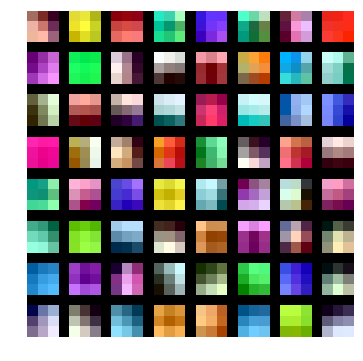

In [11]:
from vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.cpu().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()